In [1]:
# !pip install datasets
# !pip install torch
# !pip install pyarrow
# !pip install tokenizers


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

/common/home/projectgrps/CS425/CS425G9/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
from datasets import load_dataset
import ast

def prepare_dataset(batch_size=32, max_length=128, train_size=100000, val_size=10000, test_size=10000):
    dataset = load_dataset("PedroCJardim/QASports")

    train_dataset = dataset["train"].select(range(min(train_size, len(dataset["train"]))))
    val_dataset = dataset["validation"].select(range(min(val_size, len(dataset["validation"]))))
    test_dataset = dataset["test"].select(range(min(test_size, len(dataset["test"]))))

    train_context = pd.Series(train_dataset["context"])
    val_context = pd.Series(val_dataset["context"])
    # test_context = pd.Series(test_dataset["context"])

    # full_df = pd.concat([train_context,val_context,test_context])
    full_df = pd.concat([train_context,val_context])
    full = list(full_df)
    random.shuffle(full)

    def preprocess_function(examples):
        questions_preprocess = [q.strip() for q in examples["question"] if q]
        answers_preprocess = [ast.literal_eval(a)["text"] for a in examples["answer"] if a]

        df_preprocess = pd.DataFrame(questions_preprocess, columns=['questions'])
        df_preprocess['answers'] = answers_preprocess
        df_preprocess = df_preprocess[df_preprocess["answers"] != ""]
        return df_preprocess

    train_dataset = preprocess_function(train_dataset)
    val_dataset = preprocess_function(val_dataset)
    test_dataset = preprocess_function(test_dataset)
    
    # Reset the index of the DataFrame
    train_dataset = train_dataset.reset_index(drop=True)
    val_dataset = val_dataset.reset_index(drop=True)
    test_dataset = test_dataset.reset_index(drop=True)


    return train_dataset, val_dataset, test_dataset, full

train_dataset, val_dataset, test_dataset, full = prepare_dataset()

In [4]:
train_dataset

,questions,answers
0,How many field goals did Kobe Bryant score?,"9,936"
1,Which Lakers forward scored a Finals record 61...,Elgin Baylor
2,Who owns the building?,City of Memphis
3,"Who was the team's president, front office man...",Rick Pitino
4,What college did Marbury commit to?,Georgia Tech
...,...,...
65651,Where is the University System of Maryland loc...,southwest Baltimore County communities of Cato...
65652,Iguodala became the first player to win the aw...,regular season
65653,Why did Parish receive virtually no notice?,one of the most severe penalties ever levied b...
65654,How many contestants were eliminated in 2013?,sixth


In [5]:
# train BERT tokenizer on vocabulary from the sportsQA dataset "context" column
bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<bos>","<eos>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'sportsQA_context.json'))

In [6]:
x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'questions']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'answers']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids))

2 : <bos>
1562 : which
1124 : lakers
1284 : forward
1742 : scored
40 : a
1109 : finals
1126 : record
1753 : 61
1032 : points
33 : ?
3 : <eos>

 which lakers forward scored a finals record 61 points? 


2 : <bos>
5774 : elgin
2775 : baylor
3 : <eos>

 elgin baylor


In [7]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['questions'], sample['answers']
        start_token = "<bos>"
        qn = bert_tokenizer.encode(f'<bos>{en.strip()}<eos>').ids
        ans = bert_tokenizer.encode(f'<bos>{lang2.strip()}<eos>').ids
        ans_shift = ans.copy()
        ans_shift[:-1] = ans[1:]
        ans_shift[-1] = bert_tokenizer.token_to_id('<pad>')
        
        qn = torch.tensor(qn,dtype=torch.long)
        ans = torch.tensor(ans,dtype=torch.long)
        ans_shift = torch.tensor(ans_shift,dtype=torch.long)
        ans_shift[ans_shift==1]=-100
        return qn,ans,ans_shift

In [8]:
train_ds = Dataset(train_dataset)
val_ds = Dataset(val_dataset)

In [9]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim, dim, bias=False)
        
        # Add weight matrix W
        self.W1 = nn.Parameter(torch.Tensor(self.head_dim, self.head_dim))
        self.W2 = nn.Parameter(torch.Tensor(self.head_dim, self.head_dim))
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, q, k, v, mask=None):
        batch, t, c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch, q.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch, k.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch, v.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Apply weight matrix W
        q = torch.matmul(q, self.W1)
        k = torch.matmul(k, self.W2)
        
        qkT = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype, device=qkT.device)
            a, b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:, :, :a, :b] == 0, float('-inf'))
            
        qkT = F.softmax(qkT, dim=-1)
            
        attn = torch.matmul(qkT, v)
        attn = attn.permute(0, 2, 1, 3).contiguous().view(batch, t, c)
        out = self.out_proj(attn)
        return out


    


class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )
        
    def forward(self, x):
        return self.feed_forward(x)
    


class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x
    


class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)
        
    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)
        
        return x
    


class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x
    


class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.lm_head.weight
        
        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))
    
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self, src, tgt, labels=None):
        
        src_mask = self.create_src_mask(src)
        
        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)
        
        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)
            
        dec_out = self.ln_f(dec_out)
        
        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits
    
    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break
            
        return tgt.cpu().flatten()

In [10]:
config = {
    'dim': 768,
    'n_heads': 12,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 6,
    'vocab_size': bert_tokenizer.get_vocab_size(),  # Set to tokenizer vocabulary size
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}

In [11]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

122400000


In [12]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 768)
    (pos_embedding): Embedding(128, 768)
  )
  (encoders): ModuleList(
    (0-5): 6 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=3072, out_features=768, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attn): M

In [13]:
# Print model parameters to explicitly show W
# for name, param in model.named_parameters():
#     print(name, param.shape)

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))


513 51


In [15]:
test_dataset.head()

,questions,answers
0,How many.429.000.875 3.7 2002 Minnesota 3 1?,14.3
1,Who punched Kent Benson?,Abdul-Jabbar
2,How many regular-season games did the Huskies ...,126
3,In what year did Mitchell pledge her allegianc...,2013
4,When did the NBL merge with the BAA?,"August 3, 1949"


In [16]:
test_samples = [(test_dataset.loc[i,'questions'],test_dataset.loc[i,'answers']) for i in range(len(test_dataset))]


In [18]:
epochs = 6
train_losses = []
valid_losses = []
best_val_loss = 1e9

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

/tmp/ipykernel_2602388/1174862910.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [19]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    correct_train = 0
    total_train = 0
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')

    
    train_losses.append(trl/len(train_dl))
    
    gc.collect()
    torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./kaggle_checkpoint/best_model_custom_100k.pt')
            
        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./kaggle_checkpoint/checkpoint_model_epoch{ep}.pt')
        # TODO: finish fixing this part of the code (tokenizing stuff)
        print('predicting with current epoch model...')
        for (src,tgt) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

            bos = bert_tokenizer.token_to_id('<bos>')
            
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        print('-'*30,'\n\n')
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

/tmp/ipykernel_2602388/3370038993.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train step loss: 10.4917:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 10.4917:   0%|          | 1/513 [00:00<06:46,  1.26it/s]

train step loss: 8.0034:   0%|          | 1/513 [00:01<06:46,  1.26it/s] 

train step loss: 8.0034:   0%|          | 2/513 [00:01<04:44,  1.80it/s]

train step loss: 8.0655:   0%|          | 2/513 [00:01<04:44,  1.80it/s]

train step loss: 8.0655:   1%|          | 3/513 [00:01<04:02,  2.10it/s]

train step loss: 7.9894:   1%|          | 3/513 [00:01<04:02,  2.10it/s]

train step loss: 7.9894:   1%|          | 4/513 [00:01<03:44,  2.26it/s]

train step loss: 7.3442:   1%|          | 4/513 [00:02<03:44,  2.26it/s]

train step loss: 7.3442:   1%|          | 5/513 [00:02<03:35,  2.36it/s]

train step loss: 8.0138:   1%|          | 5/513 [00:02<03:35,  2.36it/s]

train step loss: 8.0138:   1%|          | 6/513 [00:02<03:28,  2.43it/s]

train step loss: 7.8047:   1%|          | 6/513 [00:03<03:28,  2.43it/s]

train step loss: 7.8047:   1%|▏         | 7/513 [00:03<03:25,  2.47it/s]

train step loss: 7.5970:   1%|▏         | 7/513 [00:03<03:25,  2.47it/s]

train step loss: 7.5970:   2%|▏         | 8/513 [00:03<03:22,  2.50it/s]

train step loss: 7.2204:   2%|▏         | 8/513 [00:03<03:22,  2.50it/s]

train step loss: 7.2204:   2%|▏         | 9/513 [00:03<03:20,  2.51it/s]

train step loss: 7.4101:   2%|▏         | 9/513 [00:04<03:20,  2.51it/s]

train step loss: 7.4101:   2%|▏         | 10/513 [00:04<03:19,  2.52it/s]

train step loss: 7.1746:   2%|▏         | 10/513 [00:04<03:19,  2.52it/s]

train step loss: 7.1746:   2%|▏         | 11/513 [00:04<03:18,  2.53it/s]

train step loss: 6.8708:   2%|▏         | 11/513 [00:05<03:18,  2.53it/s]

train step loss: 6.8708:   2%|▏         | 12/513 [00:05<03:17,  2.54it/s]

train step loss: 7.2655:   2%|▏         | 12/513 [00:05<03:17,  2.54it/s]

train step loss: 7.2655:   3%|▎         | 13/513 [00:05<03:16,  2.54it/s]

train step loss: 6.9950:   3%|▎         | 13/513 [00:05<03:16,  2.54it/s]

train step loss: 6.9950:   3%|▎         | 14/513 [00:05<03:16,  2.54it/s]

train step loss: 7.0592:   3%|▎         | 14/513 [00:06<03:16,  2.54it/s]

train step loss: 7.0592:   3%|▎         | 15/513 [00:06<03:15,  2.54it/s]

train step loss: 6.9249:   3%|▎         | 15/513 [00:06<03:15,  2.54it/s]

train step loss: 6.9249:   3%|▎         | 16/513 [00:06<03:15,  2.54it/s]

train step loss: 6.6270:   3%|▎         | 16/513 [00:07<03:15,  2.54it/s]

train step loss: 6.6270:   3%|▎         | 17/513 [00:07<03:15,  2.54it/s]

train step loss: 7.0935:   3%|▎         | 17/513 [00:07<03:15,  2.54it/s]

train step loss: 7.0935:   4%|▎         | 18/513 [00:07<03:14,  2.54it/s]

train step loss: 6.7866:   4%|▎         | 18/513 [00:07<03:14,  2.54it/s]

train step loss: 6.7866:   4%|▎         | 19/513 [00:07<03:14,  2.54it/s]

train step loss: 6.5246:   4%|▎         | 19/513 [00:08<03:14,  2.54it/s]

train step loss: 6.5246:   4%|▍         | 20/513 [00:08<03:13,  2.54it/s]

train step loss: 6.5158:   4%|▍         | 20/513 [00:08<03:13,  2.54it/s]

train step loss: 6.5158:   4%|▍         | 21/513 [00:08<03:13,  2.54it/s]

train step loss: 6.5126:   4%|▍         | 21/513 [00:09<03:13,  2.54it/s]

train step loss: 6.5126:   4%|▍         | 22/513 [00:09<03:13,  2.54it/s]

train step loss: 6.5460:   4%|▍         | 22/513 [00:09<03:13,  2.54it/s]

train step loss: 6.5460:   4%|▍         | 23/513 [00:09<03:12,  2.54it/s]

train step loss: 6.4775:   4%|▍         | 23/513 [00:09<03:12,  2.54it/s]

train step loss: 6.4775:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 6.6588:   5%|▍         | 24/513 [00:10<03:11,  2.55it/s]

train step loss: 6.6588:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 6.3532:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 6.3532:   5%|▌         | 26/513 [00:10<03:11,  2.55it/s]

train step loss: 6.2137:   5%|▌         | 26/513 [00:10<03:11,  2.55it/s]

train step loss: 6.2137:   5%|▌         | 27/513 [00:10<03:10,  2.55it/s]

train step loss: 5.9057:   5%|▌         | 27/513 [00:11<03:10,  2.55it/s]

train step loss: 5.9057:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 5.8230:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 5.8230:   6%|▌         | 29/513 [00:11<03:09,  2.55it/s]

train step loss: 6.2424:   6%|▌         | 29/513 [00:12<03:09,  2.55it/s]

train step loss: 6.2424:   6%|▌         | 30/513 [00:12<03:09,  2.55it/s]

train step loss: 5.8358:   6%|▌         | 30/513 [00:12<03:09,  2.55it/s]

train step loss: 5.8358:   6%|▌         | 31/513 [00:12<03:08,  2.55it/s]

train step loss: 5.5949:   6%|▌         | 31/513 [00:12<03:08,  2.55it/s]

train step loss: 5.5949:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 5.9657:   6%|▌         | 32/513 [00:13<03:08,  2.55it/s]

train step loss: 5.9657:   6%|▋         | 33/513 [00:13<03:08,  2.55it/s]

train step loss: 6.1258:   6%|▋         | 33/513 [00:13<03:08,  2.55it/s]

train step loss: 6.1258:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 5.9592:   7%|▋         | 34/513 [00:14<03:07,  2.55it/s]

train step loss: 5.9592:   7%|▋         | 35/513 [00:14<03:07,  2.55it/s]

train step loss: 5.8680:   7%|▋         | 35/513 [00:14<03:07,  2.55it/s]

train step loss: 5.8680:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 5.9117:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 5.9117:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 5.9146:   7%|▋         | 37/513 [00:15<03:06,  2.55it/s]

train step loss: 5.9146:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 5.8635:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 5.8635:   8%|▊         | 39/513 [00:15<03:05,  2.55it/s]

train step loss: 5.7448:   8%|▊         | 39/513 [00:16<03:05,  2.55it/s]

train step loss: 5.7448:   8%|▊         | 40/513 [00:16<03:05,  2.55it/s]

train step loss: 5.5764:   8%|▊         | 40/513 [00:16<03:05,  2.55it/s]

train step loss: 5.5764:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 5.8121:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 5.8121:   8%|▊         | 42/513 [00:16<03:04,  2.55it/s]

train step loss: 6.0226:   8%|▊         | 42/513 [00:17<03:04,  2.55it/s]

train step loss: 6.0226:   8%|▊         | 43/513 [00:17<03:04,  2.55it/s]

train step loss: 5.7500:   8%|▊         | 43/513 [00:17<03:04,  2.55it/s]

train step loss: 5.7500:   9%|▊         | 44/513 [00:17<03:04,  2.55it/s]

train step loss: 5.7580:   9%|▊         | 44/513 [00:18<03:04,  2.55it/s]

train step loss: 5.7580:   9%|▉         | 45/513 [00:18<03:03,  2.55it/s]

train step loss: 5.8631:   9%|▉         | 45/513 [00:18<03:03,  2.55it/s]

train step loss: 5.8631:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 5.4411:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 5.4411:   9%|▉         | 47/513 [00:18<03:03,  2.54it/s]

train step loss: 5.5035:   9%|▉         | 47/513 [00:19<03:03,  2.54it/s]

train step loss: 5.5035:   9%|▉         | 48/513 [00:19<03:03,  2.54it/s]

train step loss: 5.6136:   9%|▉         | 48/513 [00:19<03:03,  2.54it/s]

train step loss: 5.6136:  10%|▉         | 49/513 [00:19<03:02,  2.54it/s]

train step loss: 5.4036:  10%|▉         | 49/513 [00:20<03:02,  2.54it/s]

train step loss: 5.4036:  10%|▉         | 50/513 [00:20<03:02,  2.54it/s]

train step loss: 5.4497:  10%|▉         | 50/513 [00:20<03:02,  2.54it/s]

train step loss: 5.4497:  10%|▉         | 51/513 [00:20<03:01,  2.54it/s]

train step loss: 5.4644:  10%|▉         | 51/513 [00:20<03:01,  2.54it/s]

train step loss: 5.4644:  10%|█         | 52/513 [00:20<03:01,  2.54it/s]

train step loss: 5.3855:  10%|█         | 52/513 [00:21<03:01,  2.54it/s]

train step loss: 5.3855:  10%|█         | 53/513 [00:21<03:01,  2.54it/s]

train step loss: 5.6823:  10%|█         | 53/513 [00:21<03:01,  2.54it/s]

train step loss: 5.6823:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 5.9951:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 5.9951:  11%|█         | 55/513 [00:21<03:00,  2.54it/s]

train step loss: 4.9709:  11%|█         | 55/513 [00:22<03:00,  2.54it/s]

train step loss: 4.9709:  11%|█         | 56/513 [00:22<02:59,  2.54it/s]

train step loss: 5.3939:  11%|█         | 56/513 [00:22<02:59,  2.54it/s]

train step loss: 5.3939:  11%|█         | 57/513 [00:22<02:59,  2.54it/s]

train step loss: 5.3412:  11%|█         | 57/513 [00:23<02:59,  2.54it/s]

train step loss: 5.3412:  11%|█▏        | 58/513 [00:23<02:59,  2.54it/s]

train step loss: 5.6311:  11%|█▏        | 58/513 [00:23<02:59,  2.54it/s]

train step loss: 5.6311:  12%|█▏        | 59/513 [00:23<02:58,  2.54it/s]

train step loss: 5.4840:  12%|█▏        | 59/513 [00:23<02:58,  2.54it/s]

train step loss: 5.4840:  12%|█▏        | 60/513 [00:23<02:58,  2.54it/s]

train step loss: 5.5175:  12%|█▏        | 60/513 [00:24<02:58,  2.54it/s]

train step loss: 5.5175:  12%|█▏        | 61/513 [00:24<02:58,  2.54it/s]

train step loss: 5.1950:  12%|█▏        | 61/513 [00:24<02:58,  2.54it/s]

train step loss: 5.1950:  12%|█▏        | 62/513 [00:24<02:57,  2.53it/s]

train step loss: 5.2628:  12%|█▏        | 62/513 [00:25<02:57,  2.53it/s]

train step loss: 5.2628:  12%|█▏        | 63/513 [00:25<02:57,  2.53it/s]

train step loss: 5.2446:  12%|█▏        | 63/513 [00:25<02:57,  2.53it/s]

train step loss: 5.2446:  12%|█▏        | 64/513 [00:25<02:57,  2.53it/s]

train step loss: 5.4863:  12%|█▏        | 64/513 [00:25<02:57,  2.53it/s]

train step loss: 5.4863:  13%|█▎        | 65/513 [00:25<02:57,  2.53it/s]

train step loss: 5.3401:  13%|█▎        | 65/513 [00:26<02:57,  2.53it/s]

train step loss: 5.3401:  13%|█▎        | 66/513 [00:26<02:56,  2.53it/s]

train step loss: 5.1795:  13%|█▎        | 66/513 [00:26<02:56,  2.53it/s]

train step loss: 5.1795:  13%|█▎        | 67/513 [00:26<02:56,  2.53it/s]

train step loss: 5.1603:  13%|█▎        | 67/513 [00:27<02:56,  2.53it/s]

train step loss: 5.1603:  13%|█▎        | 68/513 [00:27<02:55,  2.53it/s]

train step loss: 5.2933:  13%|█▎        | 68/513 [00:27<02:55,  2.53it/s]

train step loss: 5.2933:  13%|█▎        | 69/513 [00:27<02:55,  2.53it/s]

train step loss: 5.0235:  13%|█▎        | 69/513 [00:27<02:55,  2.53it/s]

train step loss: 5.0235:  14%|█▎        | 70/513 [00:27<02:55,  2.53it/s]

train step loss: 5.3936:  14%|█▎        | 70/513 [00:28<02:55,  2.53it/s]

train step loss: 5.3936:  14%|█▍        | 71/513 [00:28<02:54,  2.53it/s]

train step loss: 5.3550:  14%|█▍        | 71/513 [00:28<02:54,  2.53it/s]

train step loss: 5.3550:  14%|█▍        | 72/513 [00:28<02:54,  2.53it/s]

train step loss: 4.8483:  14%|█▍        | 72/513 [00:29<02:54,  2.53it/s]

train step loss: 4.8483:  14%|█▍        | 73/513 [00:29<02:53,  2.53it/s]

train step loss: 5.7098:  14%|█▍        | 73/513 [00:29<02:53,  2.53it/s]

train step loss: 5.7098:  14%|█▍        | 74/513 [00:29<02:53,  2.53it/s]

train step loss: 5.5247:  14%|█▍        | 74/513 [00:29<02:53,  2.53it/s]

train step loss: 5.5247:  15%|█▍        | 75/513 [00:29<02:53,  2.53it/s]

train step loss: 5.1417:  15%|█▍        | 75/513 [00:30<02:53,  2.53it/s]

train step loss: 5.1417:  15%|█▍        | 76/513 [00:30<02:52,  2.53it/s]

train step loss: 5.2841:  15%|█▍        | 76/513 [00:30<02:52,  2.53it/s]

train step loss: 5.2841:  15%|█▌        | 77/513 [00:30<02:52,  2.53it/s]

train step loss: 5.3273:  15%|█▌        | 77/513 [00:31<02:52,  2.53it/s]

train step loss: 5.3273:  15%|█▌        | 78/513 [00:31<02:52,  2.53it/s]

train step loss: 5.0611:  15%|█▌        | 78/513 [00:31<02:52,  2.53it/s]

train step loss: 5.0611:  15%|█▌        | 79/513 [00:31<02:51,  2.53it/s]

train step loss: 5.1411:  15%|█▌        | 79/513 [00:31<02:51,  2.53it/s]

train step loss: 5.1411:  16%|█▌        | 80/513 [00:31<02:51,  2.53it/s]

train step loss: 5.0728:  16%|█▌        | 80/513 [00:32<02:51,  2.53it/s]

train step loss: 5.0728:  16%|█▌        | 81/513 [00:32<02:50,  2.53it/s]

train step loss: 5.1778:  16%|█▌        | 81/513 [00:32<02:50,  2.53it/s]

train step loss: 5.1778:  16%|█▌        | 82/513 [00:32<02:50,  2.52it/s]

train step loss: 5.0757:  16%|█▌        | 82/513 [00:33<02:50,  2.52it/s]

train step loss: 5.0757:  16%|█▌        | 83/513 [00:33<02:50,  2.52it/s]

train step loss: 4.7885:  16%|█▌        | 83/513 [00:33<02:50,  2.52it/s]

train step loss: 4.7885:  16%|█▋        | 84/513 [00:33<02:49,  2.52it/s]

train step loss: 5.2938:  16%|█▋        | 84/513 [00:33<02:49,  2.52it/s]

train step loss: 5.2938:  17%|█▋        | 85/513 [00:33<02:49,  2.53it/s]

train step loss: 5.4459:  17%|█▋        | 85/513 [00:34<02:49,  2.53it/s]

train step loss: 5.4459:  17%|█▋        | 86/513 [00:34<02:48,  2.53it/s]

train step loss: 5.4989:  17%|█▋        | 86/513 [00:34<02:48,  2.53it/s]

train step loss: 5.4989:  17%|█▋        | 87/513 [00:34<02:48,  2.52it/s]

train step loss: 5.2667:  17%|█▋        | 87/513 [00:35<02:48,  2.52it/s]

train step loss: 5.2667:  17%|█▋        | 88/513 [00:35<02:48,  2.52it/s]

train step loss: 5.3046:  17%|█▋        | 88/513 [00:35<02:48,  2.52it/s]

train step loss: 5.3046:  17%|█▋        | 89/513 [00:35<02:48,  2.52it/s]

train step loss: 4.9781:  17%|█▋        | 89/513 [00:35<02:48,  2.52it/s]

train step loss: 4.9781:  18%|█▊        | 90/513 [00:35<02:47,  2.52it/s]

train step loss: 4.8290:  18%|█▊        | 90/513 [00:36<02:47,  2.52it/s]

train step loss: 4.8290:  18%|█▊        | 91/513 [00:36<02:47,  2.52it/s]

train step loss: 4.9534:  18%|█▊        | 91/513 [00:36<02:47,  2.52it/s]

train step loss: 4.9534:  18%|█▊        | 92/513 [00:36<02:46,  2.52it/s]

train step loss: 4.9401:  18%|█▊        | 92/513 [00:37<02:46,  2.52it/s]

train step loss: 4.9401:  18%|█▊        | 93/513 [00:37<02:46,  2.52it/s]

train step loss: 4.8999:  18%|█▊        | 93/513 [00:37<02:46,  2.52it/s]

train step loss: 4.8999:  18%|█▊        | 94/513 [00:37<02:46,  2.52it/s]

train step loss: 5.1918:  18%|█▊        | 94/513 [00:37<02:46,  2.52it/s]

train step loss: 5.1918:  19%|█▊        | 95/513 [00:37<02:46,  2.52it/s]

train step loss: 4.6437:  19%|█▊        | 95/513 [00:38<02:46,  2.52it/s]

train step loss: 4.6437:  19%|█▊        | 96/513 [00:38<02:45,  2.52it/s]

train step loss: 5.0013:  19%|█▊        | 96/513 [00:38<02:45,  2.52it/s]

train step loss: 5.0013:  19%|█▉        | 97/513 [00:38<02:45,  2.52it/s]

train step loss: 4.5979:  19%|█▉        | 97/513 [00:38<02:45,  2.52it/s]

train step loss: 4.5979:  19%|█▉        | 98/513 [00:38<02:45,  2.51it/s]

train step loss: 4.9994:  19%|█▉        | 98/513 [00:39<02:45,  2.51it/s]

train step loss: 4.9994:  19%|█▉        | 99/513 [00:39<02:44,  2.51it/s]

train step loss: 4.8646:  19%|█▉        | 99/513 [00:39<02:44,  2.51it/s]

train step loss: 4.8646:  19%|█▉        | 100/513 [00:39<02:44,  2.51it/s]

train step loss: 4.9675:  19%|█▉        | 100/513 [00:40<02:44,  2.51it/s]

train step loss: 4.9675:  20%|█▉        | 101/513 [00:40<02:43,  2.51it/s]

train step loss: 4.9231:  20%|█▉        | 101/513 [00:40<02:43,  2.51it/s]

train step loss: 4.9231:  20%|█▉        | 102/513 [00:40<02:43,  2.52it/s]

train step loss: 4.7011:  20%|█▉        | 102/513 [00:40<02:43,  2.52it/s]

train step loss: 4.7011:  20%|██        | 103/513 [00:40<02:42,  2.52it/s]

train step loss: 4.7818:  20%|██        | 103/513 [00:41<02:42,  2.52it/s]

train step loss: 4.7818:  20%|██        | 104/513 [00:41<02:42,  2.52it/s]

train step loss: 4.6607:  20%|██        | 104/513 [00:41<02:42,  2.52it/s]

train step loss: 4.6607:  20%|██        | 105/513 [00:41<02:42,  2.52it/s]

train step loss: 5.1320:  20%|██        | 105/513 [00:42<02:42,  2.52it/s]

train step loss: 5.1320:  21%|██        | 106/513 [00:42<02:41,  2.52it/s]

train step loss: 5.2463:  21%|██        | 106/513 [00:42<02:41,  2.52it/s]

train step loss: 5.2463:  21%|██        | 107/513 [00:42<02:41,  2.52it/s]

train step loss: 4.9424:  21%|██        | 107/513 [00:42<02:41,  2.52it/s]

train step loss: 4.9424:  21%|██        | 108/513 [00:42<02:40,  2.52it/s]

train step loss: 4.5604:  21%|██        | 108/513 [00:43<02:40,  2.52it/s]

train step loss: 4.5604:  21%|██        | 109/513 [00:43<02:40,  2.51it/s]

train step loss: 4.9499:  21%|██        | 109/513 [00:43<02:40,  2.51it/s]

train step loss: 4.9499:  21%|██▏       | 110/513 [00:43<02:40,  2.51it/s]

train step loss: 4.8440:  21%|██▏       | 110/513 [00:44<02:40,  2.51it/s]

train step loss: 4.8440:  22%|██▏       | 111/513 [00:44<02:40,  2.51it/s]

train step loss: 4.4212:  22%|██▏       | 111/513 [00:44<02:40,  2.51it/s]

train step loss: 4.4212:  22%|██▏       | 112/513 [00:44<02:39,  2.51it/s]

train step loss: 4.6226:  22%|██▏       | 112/513 [00:44<02:39,  2.51it/s]

train step loss: 4.6226:  22%|██▏       | 113/513 [00:44<02:39,  2.51it/s]

train step loss: 4.7358:  22%|██▏       | 113/513 [00:45<02:39,  2.51it/s]

train step loss: 4.7358:  22%|██▏       | 114/513 [00:45<02:39,  2.51it/s]

train step loss: 4.8354:  22%|██▏       | 114/513 [00:45<02:39,  2.51it/s]

train step loss: 4.8354:  22%|██▏       | 115/513 [00:45<02:38,  2.51it/s]

train step loss: 4.8433:  22%|██▏       | 115/513 [00:46<02:38,  2.51it/s]

train step loss: 4.8433:  23%|██▎       | 116/513 [00:46<02:38,  2.51it/s]

train step loss: 4.9729:  23%|██▎       | 116/513 [00:46<02:38,  2.51it/s]

train step loss: 4.9729:  23%|██▎       | 117/513 [00:46<02:38,  2.51it/s]

train step loss: 4.6459:  23%|██▎       | 117/513 [00:46<02:38,  2.51it/s]

train step loss: 4.6459:  23%|██▎       | 118/513 [00:46<02:37,  2.51it/s]

train step loss: 4.8071:  23%|██▎       | 118/513 [00:47<02:37,  2.51it/s]

train step loss: 4.8071:  23%|██▎       | 119/513 [00:47<02:37,  2.51it/s]

train step loss: 4.6779:  23%|██▎       | 119/513 [00:47<02:37,  2.51it/s]

train step loss: 4.6779:  23%|██▎       | 120/513 [00:47<02:36,  2.51it/s]

train step loss: 4.4524:  23%|██▎       | 120/513 [00:48<02:36,  2.51it/s]

train step loss: 4.4524:  24%|██▎       | 121/513 [00:48<02:36,  2.51it/s]

train step loss: 4.5824:  24%|██▎       | 121/513 [00:48<02:36,  2.51it/s]

train step loss: 4.5824:  24%|██▍       | 122/513 [00:48<02:36,  2.51it/s]

train step loss: 4.6861:  24%|██▍       | 122/513 [00:48<02:36,  2.51it/s]

train step loss: 4.6861:  24%|██▍       | 123/513 [00:48<02:35,  2.51it/s]

train step loss: 4.9249:  24%|██▍       | 123/513 [00:49<02:35,  2.51it/s]

train step loss: 4.9249:  24%|██▍       | 124/513 [00:49<02:35,  2.51it/s]

train step loss: 4.6490:  24%|██▍       | 124/513 [00:49<02:35,  2.51it/s]

train step loss: 4.6490:  24%|██▍       | 125/513 [00:49<02:35,  2.49it/s]

train step loss: 4.7749:  24%|██▍       | 125/513 [00:50<02:35,  2.49it/s]

train step loss: 4.7749:  25%|██▍       | 126/513 [00:50<02:35,  2.49it/s]

train step loss: 4.6018:  25%|██▍       | 126/513 [00:50<02:35,  2.49it/s]

train step loss: 4.6018:  25%|██▍       | 127/513 [00:50<02:34,  2.50it/s]

train step loss: 4.9289:  25%|██▍       | 127/513 [00:50<02:34,  2.50it/s]

train step loss: 4.9289:  25%|██▍       | 128/513 [00:50<02:34,  2.50it/s]

train step loss: 5.0834:  25%|██▍       | 128/513 [00:51<02:34,  2.50it/s]

train step loss: 5.0834:  25%|██▌       | 129/513 [00:51<02:33,  2.50it/s]

train step loss: 4.6807:  25%|██▌       | 129/513 [00:51<02:33,  2.50it/s]

train step loss: 4.6807:  25%|██▌       | 130/513 [00:51<02:33,  2.50it/s]

train step loss: 4.7479:  25%|██▌       | 130/513 [00:52<02:33,  2.50it/s]

train step loss: 4.7479:  26%|██▌       | 131/513 [00:52<02:32,  2.50it/s]

train step loss: 4.3680:  26%|██▌       | 131/513 [00:52<02:32,  2.50it/s]

train step loss: 4.3680:  26%|██▌       | 132/513 [00:52<02:32,  2.50it/s]

train step loss: 4.9218:  26%|██▌       | 132/513 [00:52<02:32,  2.50it/s]

train step loss: 4.9218:  26%|██▌       | 133/513 [00:52<02:31,  2.50it/s]

train step loss: 4.3499:  26%|██▌       | 133/513 [00:53<02:31,  2.50it/s]

train step loss: 4.3499:  26%|██▌       | 134/513 [00:53<02:31,  2.50it/s]

train step loss: 4.7243:  26%|██▌       | 134/513 [00:53<02:31,  2.50it/s]

train step loss: 4.7243:  26%|██▋       | 135/513 [00:53<02:31,  2.50it/s]

train step loss: 4.5405:  26%|██▋       | 135/513 [00:54<02:31,  2.50it/s]

train step loss: 4.5405:  27%|██▋       | 136/513 [00:54<02:30,  2.50it/s]

train step loss: 4.7811:  27%|██▋       | 136/513 [00:54<02:30,  2.50it/s]

train step loss: 4.7811:  27%|██▋       | 137/513 [00:54<02:30,  2.50it/s]

train step loss: 5.1755:  27%|██▋       | 137/513 [00:54<02:30,  2.50it/s]

train step loss: 5.1755:  27%|██▋       | 138/513 [00:54<02:30,  2.49it/s]

train step loss: 4.5088:  27%|██▋       | 138/513 [00:55<02:30,  2.49it/s]

train step loss: 4.5088:  27%|██▋       | 139/513 [00:55<02:30,  2.49it/s]

train step loss: 4.5993:  27%|██▋       | 139/513 [00:55<02:30,  2.49it/s]

train step loss: 4.5993:  27%|██▋       | 140/513 [00:55<02:29,  2.49it/s]

train step loss: 4.6756:  27%|██▋       | 140/513 [00:56<02:29,  2.49it/s]

train step loss: 4.6756:  27%|██▋       | 141/513 [00:56<02:29,  2.49it/s]

train step loss: 4.5056:  27%|██▋       | 141/513 [00:56<02:29,  2.49it/s]

train step loss: 4.5056:  28%|██▊       | 142/513 [00:56<02:28,  2.49it/s]

train step loss: 4.7015:  28%|██▊       | 142/513 [00:56<02:28,  2.49it/s]

train step loss: 4.7015:  28%|██▊       | 143/513 [00:56<02:28,  2.50it/s]

train step loss: 4.7056:  28%|██▊       | 143/513 [00:57<02:28,  2.50it/s]

train step loss: 4.7056:  28%|██▊       | 144/513 [00:57<02:27,  2.50it/s]

train step loss: 4.9774:  28%|██▊       | 144/513 [00:57<02:27,  2.50it/s]

train step loss: 4.9774:  28%|██▊       | 145/513 [00:57<02:27,  2.50it/s]

train step loss: 4.8383:  28%|██▊       | 145/513 [00:58<02:27,  2.50it/s]

train step loss: 4.8383:  28%|██▊       | 146/513 [00:58<02:27,  2.50it/s]

train step loss: 4.7161:  28%|██▊       | 146/513 [00:58<02:27,  2.50it/s]

train step loss: 4.7161:  29%|██▊       | 147/513 [00:58<02:26,  2.50it/s]

train step loss: 5.0654:  29%|██▊       | 147/513 [00:58<02:26,  2.50it/s]

train step loss: 5.0654:  29%|██▉       | 148/513 [00:58<02:26,  2.50it/s]

train step loss: 4.7812:  29%|██▉       | 148/513 [00:59<02:26,  2.50it/s]

train step loss: 4.7812:  29%|██▉       | 149/513 [00:59<02:25,  2.49it/s]

train step loss: 4.4874:  29%|██▉       | 149/513 [00:59<02:25,  2.49it/s]

train step loss: 4.4874:  29%|██▉       | 150/513 [00:59<02:25,  2.49it/s]

train step loss: 4.5267:  29%|██▉       | 150/513 [01:00<02:25,  2.49it/s]

train step loss: 4.5267:  29%|██▉       | 151/513 [01:00<02:25,  2.49it/s]

train step loss: 4.3557:  29%|██▉       | 151/513 [01:00<02:25,  2.49it/s]

train step loss: 4.3557:  30%|██▉       | 152/513 [01:00<02:24,  2.49it/s]

train step loss: 4.9747:  30%|██▉       | 152/513 [01:00<02:24,  2.49it/s]

train step loss: 4.9747:  30%|██▉       | 153/513 [01:00<02:24,  2.49it/s]

train step loss: 4.5300:  30%|██▉       | 153/513 [01:01<02:24,  2.49it/s]

train step loss: 4.5300:  30%|███       | 154/513 [01:01<02:24,  2.49it/s]

train step loss: 4.5621:  30%|███       | 154/513 [01:01<02:24,  2.49it/s]

train step loss: 4.5621:  30%|███       | 155/513 [01:01<02:23,  2.49it/s]

train step loss: 4.4094:  30%|███       | 155/513 [01:02<02:23,  2.49it/s]

train step loss: 4.4094:  30%|███       | 156/513 [01:02<02:23,  2.49it/s]

train step loss: 4.7606:  30%|███       | 156/513 [01:02<02:23,  2.49it/s]

train step loss: 4.7606:  31%|███       | 157/513 [01:02<02:22,  2.49it/s]

train step loss: 4.3369:  31%|███       | 157/513 [01:02<02:22,  2.49it/s]

train step loss: 4.3369:  31%|███       | 158/513 [01:02<02:22,  2.49it/s]

train step loss: 4.6460:  31%|███       | 158/513 [01:03<02:22,  2.49it/s]

train step loss: 4.6460:  31%|███       | 159/513 [01:03<02:22,  2.49it/s]

train step loss: 4.2270:  31%|███       | 159/513 [01:03<02:22,  2.49it/s]

train step loss: 4.2270:  31%|███       | 160/513 [01:03<02:21,  2.49it/s]

train step loss: 4.1213:  31%|███       | 160/513 [01:04<02:21,  2.49it/s]

train step loss: 4.1213:  31%|███▏      | 161/513 [01:04<02:21,  2.49it/s]

train step loss: 4.8689:  31%|███▏      | 161/513 [01:04<02:21,  2.49it/s]

train step loss: 4.8689:  32%|███▏      | 162/513 [01:04<02:21,  2.49it/s]

train step loss: 4.4435:  32%|███▏      | 162/513 [01:04<02:21,  2.49it/s]

train step loss: 4.4435:  32%|███▏      | 163/513 [01:04<02:20,  2.49it/s]

train step loss: 4.8554:  32%|███▏      | 163/513 [01:05<02:20,  2.49it/s]

train step loss: 4.8554:  32%|███▏      | 164/513 [01:05<02:20,  2.49it/s]

train step loss: 4.3302:  32%|███▏      | 164/513 [01:05<02:20,  2.49it/s]

train step loss: 4.3302:  32%|███▏      | 165/513 [01:05<02:19,  2.49it/s]

train step loss: 4.4394:  32%|███▏      | 165/513 [01:06<02:19,  2.49it/s]

train step loss: 4.4394:  32%|███▏      | 166/513 [01:06<02:19,  2.49it/s]

train step loss: 4.6698:  32%|███▏      | 166/513 [01:06<02:19,  2.49it/s]

train step loss: 4.6698:  33%|███▎      | 167/513 [01:06<02:19,  2.49it/s]

train step loss: 4.0997:  33%|███▎      | 167/513 [01:07<02:19,  2.49it/s]

train step loss: 4.0997:  33%|███▎      | 168/513 [01:07<02:18,  2.49it/s]

train step loss: 4.2779:  33%|███▎      | 168/513 [01:07<02:18,  2.49it/s]

train step loss: 4.2779:  33%|███▎      | 169/513 [01:07<02:18,  2.49it/s]

train step loss: 4.4968:  33%|███▎      | 169/513 [01:07<02:18,  2.49it/s]

train step loss: 4.4968:  33%|███▎      | 170/513 [01:07<02:17,  2.49it/s]

train step loss: 4.6599:  33%|███▎      | 170/513 [01:08<02:17,  2.49it/s]

train step loss: 4.6599:  33%|███▎      | 171/513 [01:08<02:17,  2.49it/s]

train step loss: 4.5892:  33%|███▎      | 171/513 [01:08<02:17,  2.49it/s]

train step loss: 4.5892:  34%|███▎      | 172/513 [01:08<02:17,  2.49it/s]

train step loss: 4.3495:  34%|███▎      | 172/513 [01:09<02:17,  2.49it/s]

train step loss: 4.3495:  34%|███▎      | 173/513 [01:09<02:16,  2.49it/s]

train step loss: 4.0621:  34%|███▎      | 173/513 [01:09<02:16,  2.49it/s]

train step loss: 4.0621:  34%|███▍      | 174/513 [01:09<02:16,  2.49it/s]

train step loss: 4.7929:  34%|███▍      | 174/513 [01:09<02:16,  2.49it/s]

train step loss: 4.7929:  34%|███▍      | 175/513 [01:09<02:15,  2.49it/s]

train step loss: 4.5456:  34%|███▍      | 175/513 [01:10<02:15,  2.49it/s]

train step loss: 4.5456:  34%|███▍      | 176/513 [01:10<02:15,  2.49it/s]

train step loss: 4.3938:  34%|███▍      | 176/513 [01:10<02:15,  2.49it/s]

train step loss: 4.3938:  35%|███▍      | 177/513 [01:10<02:15,  2.49it/s]

train step loss: 3.9930:  35%|███▍      | 177/513 [01:11<02:15,  2.49it/s]

train step loss: 3.9930:  35%|███▍      | 178/513 [01:11<02:14,  2.49it/s]

train step loss: 4.7269:  35%|███▍      | 178/513 [01:11<02:14,  2.49it/s]

train step loss: 4.7269:  35%|███▍      | 179/513 [01:11<02:14,  2.49it/s]

train step loss: 4.4549:  35%|███▍      | 179/513 [01:11<02:14,  2.49it/s]

train step loss: 4.4549:  35%|███▌      | 180/513 [01:11<02:13,  2.49it/s]

train step loss: 4.2323:  35%|███▌      | 180/513 [01:12<02:13,  2.49it/s]

train step loss: 4.2323:  35%|███▌      | 181/513 [01:12<02:13,  2.49it/s]

train step loss: 4.7466:  35%|███▌      | 181/513 [01:12<02:13,  2.49it/s]

train step loss: 4.7466:  35%|███▌      | 182/513 [01:12<02:13,  2.49it/s]

train step loss: 4.2020:  35%|███▌      | 182/513 [01:13<02:13,  2.49it/s]

train step loss: 4.2020:  36%|███▌      | 183/513 [01:13<02:12,  2.49it/s]

train step loss: 4.4598:  36%|███▌      | 183/513 [01:13<02:12,  2.49it/s]

train step loss: 4.4598:  36%|███▌      | 184/513 [01:13<02:12,  2.49it/s]

train step loss: 4.4318:  36%|███▌      | 184/513 [01:13<02:12,  2.49it/s]

train step loss: 4.4318:  36%|███▌      | 185/513 [01:13<02:11,  2.49it/s]

train step loss: 4.2566:  36%|███▌      | 185/513 [01:14<02:11,  2.49it/s]

train step loss: 4.2566:  36%|███▋      | 186/513 [01:14<02:11,  2.48it/s]

train step loss: 4.9209:  36%|███▋      | 186/513 [01:14<02:11,  2.48it/s]

train step loss: 4.9209:  36%|███▋      | 187/513 [01:14<02:11,  2.48it/s]

train step loss: 4.5894:  36%|███▋      | 187/513 [01:15<02:11,  2.48it/s]

train step loss: 4.5894:  37%|███▋      | 188/513 [01:15<02:10,  2.48it/s]

train step loss: 4.8742:  37%|███▋      | 188/513 [01:15<02:10,  2.48it/s]

train step loss: 4.8742:  37%|███▋      | 189/513 [01:15<02:10,  2.48it/s]

train step loss: 4.7910:  37%|███▋      | 189/513 [01:15<02:10,  2.48it/s]

train step loss: 4.7910:  37%|███▋      | 190/513 [01:15<02:10,  2.48it/s]

train step loss: 4.9845:  37%|███▋      | 190/513 [01:16<02:10,  2.48it/s]

train step loss: 4.9845:  37%|███▋      | 191/513 [01:16<02:09,  2.48it/s]

train step loss: 4.3221:  37%|███▋      | 191/513 [01:16<02:09,  2.48it/s]

train step loss: 4.3221:  37%|███▋      | 192/513 [01:16<02:09,  2.48it/s]

train step loss: 4.3383:  37%|███▋      | 192/513 [01:17<02:09,  2.48it/s]

train step loss: 4.3383:  38%|███▊      | 193/513 [01:17<02:09,  2.48it/s]

train step loss: 4.7415:  38%|███▊      | 193/513 [01:17<02:09,  2.48it/s]

train step loss: 4.7415:  38%|███▊      | 194/513 [01:17<02:08,  2.48it/s]

train step loss: 4.4783:  38%|███▊      | 194/513 [01:17<02:08,  2.48it/s]

train step loss: 4.4783:  38%|███▊      | 195/513 [01:17<02:08,  2.48it/s]

train step loss: 4.4365:  38%|███▊      | 195/513 [01:18<02:08,  2.48it/s]

train step loss: 4.4365:  38%|███▊      | 196/513 [01:18<02:07,  2.48it/s]

train step loss: 4.4052:  38%|███▊      | 196/513 [01:18<02:07,  2.48it/s]

train step loss: 4.4052:  38%|███▊      | 197/513 [01:18<02:07,  2.48it/s]

train step loss: 4.3492:  38%|███▊      | 197/513 [01:19<02:07,  2.48it/s]

train step loss: 4.3492:  39%|███▊      | 198/513 [01:19<02:07,  2.48it/s]

train step loss: 4.3930:  39%|███▊      | 198/513 [01:19<02:07,  2.48it/s]

train step loss: 4.3930:  39%|███▉      | 199/513 [01:19<02:06,  2.47it/s]

train step loss: 4.3517:  39%|███▉      | 199/513 [01:19<02:06,  2.47it/s]

train step loss: 4.3517:  39%|███▉      | 200/513 [01:19<02:06,  2.47it/s]

train step loss: 4.1791:  39%|███▉      | 200/513 [01:20<02:06,  2.47it/s]

train step loss: 4.1791:  39%|███▉      | 201/513 [01:20<02:06,  2.48it/s]

train step loss: 4.3412:  39%|███▉      | 201/513 [01:20<02:06,  2.48it/s]

train step loss: 4.3412:  39%|███▉      | 202/513 [01:20<02:05,  2.48it/s]

train step loss: 4.3816:  39%|███▉      | 202/513 [01:21<02:05,  2.48it/s]

train step loss: 4.3816:  40%|███▉      | 203/513 [01:21<02:05,  2.48it/s]

train step loss: 4.3467:  40%|███▉      | 203/513 [01:21<02:05,  2.48it/s]

train step loss: 4.3467:  40%|███▉      | 204/513 [01:21<02:04,  2.48it/s]

train step loss: 4.6083:  40%|███▉      | 204/513 [01:21<02:04,  2.48it/s]

train step loss: 4.6083:  40%|███▉      | 205/513 [01:21<02:04,  2.48it/s]

train step loss: 4.3574:  40%|███▉      | 205/513 [01:22<02:04,  2.48it/s]

train step loss: 4.3574:  40%|████      | 206/513 [01:22<02:03,  2.48it/s]

train step loss: 4.1494:  40%|████      | 206/513 [01:22<02:03,  2.48it/s]

train step loss: 4.1494:  40%|████      | 207/513 [01:22<02:03,  2.48it/s]

train step loss: 4.5448:  40%|████      | 207/513 [01:23<02:03,  2.48it/s]

train step loss: 4.5448:  41%|████      | 208/513 [01:23<02:03,  2.48it/s]

train step loss: 4.6773:  41%|████      | 208/513 [01:23<02:03,  2.48it/s]

train step loss: 4.6773:  41%|████      | 209/513 [01:23<02:02,  2.47it/s]

train step loss: 4.2371:  41%|████      | 209/513 [01:23<02:02,  2.47it/s]

train step loss: 4.2371:  41%|████      | 210/513 [01:23<02:02,  2.47it/s]

train step loss: 3.8969:  41%|████      | 210/513 [01:24<02:02,  2.47it/s]

train step loss: 3.8969:  41%|████      | 211/513 [01:24<02:02,  2.48it/s]

train step loss: 4.1240:  41%|████      | 211/513 [01:24<02:02,  2.48it/s]

train step loss: 4.1240:  41%|████▏     | 212/513 [01:24<02:01,  2.48it/s]

train step loss: 4.7196:  41%|████▏     | 212/513 [01:25<02:01,  2.48it/s]

train step loss: 4.7196:  42%|████▏     | 213/513 [01:25<02:01,  2.47it/s]

train step loss: 3.9094:  42%|████▏     | 213/513 [01:25<02:01,  2.47it/s]

train step loss: 3.9094:  42%|████▏     | 214/513 [01:25<02:00,  2.47it/s]

train step loss: 4.2885:  42%|████▏     | 214/513 [01:25<02:00,  2.47it/s]

train step loss: 4.2885:  42%|████▏     | 215/513 [01:25<02:00,  2.47it/s]

train step loss: 4.3523:  42%|████▏     | 215/513 [01:26<02:00,  2.47it/s]

train step loss: 4.3523:  42%|████▏     | 216/513 [01:26<02:00,  2.47it/s]

train step loss: 4.1281:  42%|████▏     | 216/513 [01:26<02:00,  2.47it/s]

train step loss: 4.1281:  42%|████▏     | 217/513 [01:26<01:59,  2.48it/s]

train step loss: 4.8546:  42%|████▏     | 217/513 [01:27<01:59,  2.48it/s]

train step loss: 4.8546:  42%|████▏     | 218/513 [01:27<01:59,  2.48it/s]

train step loss: 3.9720:  42%|████▏     | 218/513 [01:27<01:59,  2.48it/s]

train step loss: 3.9720:  43%|████▎     | 219/513 [01:27<01:58,  2.48it/s]

train step loss: 4.6243:  43%|████▎     | 219/513 [01:27<01:58,  2.48it/s]

train step loss: 4.6243:  43%|████▎     | 220/513 [01:27<01:58,  2.48it/s]

train step loss: 3.9686:  43%|████▎     | 220/513 [01:28<01:58,  2.48it/s]

train step loss: 3.9686:  43%|████▎     | 221/513 [01:28<01:57,  2.48it/s]

train step loss: 4.3442:  43%|████▎     | 221/513 [01:28<01:57,  2.48it/s]

train step loss: 4.3442:  43%|████▎     | 222/513 [01:28<01:57,  2.48it/s]

train step loss: 3.9671:  43%|████▎     | 222/513 [01:29<01:57,  2.48it/s]

train step loss: 3.9671:  43%|████▎     | 223/513 [01:29<01:57,  2.48it/s]

train step loss: 4.2835:  43%|████▎     | 223/513 [01:29<01:57,  2.48it/s]

train step loss: 4.2835:  44%|████▎     | 224/513 [01:29<01:56,  2.48it/s]

train step loss: 4.2273:  44%|████▎     | 224/513 [01:29<01:56,  2.48it/s]

train step loss: 4.2273:  44%|████▍     | 225/513 [01:29<01:56,  2.48it/s]

train step loss: 4.3138:  44%|████▍     | 225/513 [01:30<01:56,  2.48it/s]

train step loss: 4.3138:  44%|████▍     | 226/513 [01:30<01:55,  2.48it/s]

train step loss: 4.3644:  44%|████▍     | 226/513 [01:30<01:55,  2.48it/s]

train step loss: 4.3644:  44%|████▍     | 227/513 [01:30<01:55,  2.47it/s]

train step loss: 4.4163:  44%|████▍     | 227/513 [01:31<01:55,  2.47it/s]

train step loss: 4.4163:  44%|████▍     | 228/513 [01:31<01:55,  2.47it/s]

train step loss: 4.2190:  44%|████▍     | 228/513 [01:31<01:55,  2.47it/s]

train step loss: 4.2190:  45%|████▍     | 229/513 [01:31<01:54,  2.47it/s]

train step loss: 3.9304:  45%|████▍     | 229/513 [01:32<01:54,  2.47it/s]

train step loss: 3.9304:  45%|████▍     | 230/513 [01:32<01:54,  2.47it/s]

train step loss: 4.7030:  45%|████▍     | 230/513 [01:32<01:54,  2.47it/s]

train step loss: 4.7030:  45%|████▌     | 231/513 [01:32<01:54,  2.47it/s]

train step loss: 4.4884:  45%|████▌     | 231/513 [01:32<01:54,  2.47it/s]

train step loss: 4.4884:  45%|████▌     | 232/513 [01:32<01:53,  2.47it/s]

train step loss: 4.4499:  45%|████▌     | 232/513 [01:33<01:53,  2.47it/s]

train step loss: 4.4499:  45%|████▌     | 233/513 [01:33<01:53,  2.47it/s]

train step loss: 4.0813:  45%|████▌     | 233/513 [01:33<01:53,  2.47it/s]

train step loss: 4.0813:  46%|████▌     | 234/513 [01:33<01:52,  2.47it/s]

train step loss: 4.0222:  46%|████▌     | 234/513 [01:34<01:52,  2.47it/s]

train step loss: 4.0222:  46%|████▌     | 235/513 [01:34<01:52,  2.47it/s]

train step loss: 4.3464:  46%|████▌     | 235/513 [01:34<01:52,  2.47it/s]

train step loss: 4.3464:  46%|████▌     | 236/513 [01:34<01:52,  2.47it/s]

train step loss: 4.6353:  46%|████▌     | 236/513 [01:34<01:52,  2.47it/s]

train step loss: 4.6353:  46%|████▌     | 237/513 [01:34<01:51,  2.47it/s]

train step loss: 4.4906:  46%|████▌     | 237/513 [01:35<01:51,  2.47it/s]

train step loss: 4.4906:  46%|████▋     | 238/513 [01:35<01:51,  2.47it/s]

train step loss: 4.4612:  46%|████▋     | 238/513 [01:35<01:51,  2.47it/s]

train step loss: 4.4612:  47%|████▋     | 239/513 [01:35<01:50,  2.47it/s]

train step loss: 4.2803:  47%|████▋     | 239/513 [01:36<01:50,  2.47it/s]

train step loss: 4.2803:  47%|████▋     | 240/513 [01:36<01:50,  2.47it/s]

train step loss: 4.0377:  47%|████▋     | 240/513 [01:36<01:50,  2.47it/s]

train step loss: 4.0377:  47%|████▋     | 241/513 [01:36<01:49,  2.47it/s]

train step loss: 4.4728:  47%|████▋     | 241/513 [01:36<01:49,  2.47it/s]

train step loss: 4.4728:  47%|████▋     | 242/513 [01:36<01:49,  2.47it/s]

train step loss: 3.8919:  47%|████▋     | 242/513 [01:37<01:49,  2.47it/s]

train step loss: 3.8919:  47%|████▋     | 243/513 [01:37<01:49,  2.47it/s]

train step loss: 4.1655:  47%|████▋     | 243/513 [01:37<01:49,  2.47it/s]

train step loss: 4.1655:  48%|████▊     | 244/513 [01:37<01:48,  2.47it/s]

train step loss: 4.4725:  48%|████▊     | 244/513 [01:38<01:48,  2.47it/s]

train step loss: 4.4725:  48%|████▊     | 245/513 [01:38<01:48,  2.47it/s]

train step loss: 4.5235:  48%|████▊     | 245/513 [01:38<01:48,  2.47it/s]

train step loss: 4.5235:  48%|████▊     | 246/513 [01:38<01:48,  2.47it/s]

train step loss: 4.3991:  48%|████▊     | 246/513 [01:38<01:48,  2.47it/s]

train step loss: 4.3991:  48%|████▊     | 247/513 [01:38<01:47,  2.47it/s]

train step loss: 4.2001:  48%|████▊     | 247/513 [01:39<01:47,  2.47it/s]

train step loss: 4.2001:  48%|████▊     | 248/513 [01:39<01:47,  2.47it/s]

train step loss: 4.5027:  48%|████▊     | 248/513 [01:39<01:47,  2.47it/s]

train step loss: 4.5027:  49%|████▊     | 249/513 [01:39<01:46,  2.47it/s]

train step loss: 4.6368:  49%|████▊     | 249/513 [01:40<01:46,  2.47it/s]

train step loss: 4.6368:  49%|████▊     | 250/513 [01:40<01:46,  2.47it/s]

train step loss: 4.0818:  49%|████▊     | 250/513 [01:40<01:46,  2.47it/s]

train step loss: 4.0818:  49%|████▉     | 251/513 [01:40<01:46,  2.46it/s]

train step loss: 4.2814:  49%|████▉     | 251/513 [01:40<01:46,  2.46it/s]

train step loss: 4.2814:  49%|████▉     | 252/513 [01:40<01:45,  2.47it/s]

train step loss: 4.2289:  49%|████▉     | 252/513 [01:41<01:45,  2.47it/s]

train step loss: 4.2289:  49%|████▉     | 253/513 [01:41<01:45,  2.47it/s]

train step loss: 4.6088:  49%|████▉     | 253/513 [01:41<01:45,  2.47it/s]

train step loss: 4.6088:  50%|████▉     | 254/513 [01:41<01:44,  2.47it/s]

train step loss: 4.3462:  50%|████▉     | 254/513 [01:42<01:44,  2.47it/s]

train step loss: 4.3462:  50%|████▉     | 255/513 [01:42<01:44,  2.47it/s]

train step loss: 4.4002:  50%|████▉     | 255/513 [01:42<01:44,  2.47it/s]

train step loss: 4.4002:  50%|████▉     | 256/513 [01:42<01:44,  2.47it/s]

train step loss: 4.3164:  50%|████▉     | 256/513 [01:42<01:44,  2.47it/s]

train step loss: 4.3164:  50%|█████     | 257/513 [01:42<01:43,  2.47it/s]

train step loss: 4.0661:  50%|█████     | 257/513 [01:43<01:43,  2.47it/s]

train step loss: 4.0661:  50%|█████     | 258/513 [01:43<01:43,  2.47it/s]

train step loss: 4.5002:  50%|█████     | 258/513 [01:43<01:43,  2.47it/s]

train step loss: 4.5002:  50%|█████     | 259/513 [01:43<01:42,  2.47it/s]

train step loss: 4.5148:  50%|█████     | 259/513 [01:44<01:42,  2.47it/s]

train step loss: 4.5148:  51%|█████     | 260/513 [01:44<01:42,  2.47it/s]

train step loss: 4.2980:  51%|█████     | 260/513 [01:44<01:42,  2.47it/s]

train step loss: 4.2980:  51%|█████     | 261/513 [01:44<01:42,  2.47it/s]

train step loss: 4.7649:  51%|█████     | 261/513 [01:44<01:42,  2.47it/s]

train step loss: 4.7649:  51%|█████     | 262/513 [01:44<01:41,  2.47it/s]

train step loss: 4.0544:  51%|█████     | 262/513 [01:45<01:41,  2.47it/s]

train step loss: 4.0544:  51%|█████▏    | 263/513 [01:45<01:41,  2.47it/s]

train step loss: 4.1436:  51%|█████▏    | 263/513 [01:45<01:41,  2.47it/s]

train step loss: 4.1436:  51%|█████▏    | 264/513 [01:45<01:40,  2.47it/s]

train step loss: 4.5562:  51%|█████▏    | 264/513 [01:46<01:40,  2.47it/s]

train step loss: 4.5562:  52%|█████▏    | 265/513 [01:46<01:40,  2.47it/s]

train step loss: 3.9322:  52%|█████▏    | 265/513 [01:46<01:40,  2.47it/s]

train step loss: 3.9322:  52%|█████▏    | 266/513 [01:46<01:40,  2.47it/s]

train step loss: 4.1676:  52%|█████▏    | 266/513 [01:46<01:40,  2.47it/s]

train step loss: 4.1676:  52%|█████▏    | 267/513 [01:46<01:39,  2.47it/s]

train step loss: 4.2443:  52%|█████▏    | 267/513 [01:47<01:39,  2.47it/s]

train step loss: 4.2443:  52%|█████▏    | 268/513 [01:47<01:39,  2.47it/s]

train step loss: 3.7401:  52%|█████▏    | 268/513 [01:47<01:39,  2.47it/s]

train step loss: 3.7401:  52%|█████▏    | 269/513 [01:47<01:38,  2.47it/s]

train step loss: 4.2273:  52%|█████▏    | 269/513 [01:48<01:38,  2.47it/s]

train step loss: 4.2273:  53%|█████▎    | 270/513 [01:48<01:38,  2.46it/s]

train step loss: 4.1060:  53%|█████▎    | 270/513 [01:48<01:38,  2.46it/s]

train step loss: 4.1060:  53%|█████▎    | 271/513 [01:48<01:38,  2.46it/s]

train step loss: 4.2520:  53%|█████▎    | 271/513 [01:49<01:38,  2.46it/s]

train step loss: 4.2520:  53%|█████▎    | 272/513 [01:49<01:37,  2.46it/s]

train step loss: 4.1785:  53%|█████▎    | 272/513 [01:49<01:37,  2.46it/s]

train step loss: 4.1785:  53%|█████▎    | 273/513 [01:49<01:37,  2.46it/s]

train step loss: 4.5657:  53%|█████▎    | 273/513 [01:49<01:37,  2.46it/s]

train step loss: 4.5657:  53%|█████▎    | 274/513 [01:49<01:37,  2.46it/s]

train step loss: 4.1959:  53%|█████▎    | 274/513 [01:50<01:37,  2.46it/s]

train step loss: 4.1959:  54%|█████▎    | 275/513 [01:50<01:36,  2.46it/s]

train step loss: 3.9759:  54%|█████▎    | 275/513 [01:50<01:36,  2.46it/s]

train step loss: 3.9759:  54%|█████▍    | 276/513 [01:50<01:36,  2.46it/s]

train step loss: 4.5798:  54%|█████▍    | 276/513 [01:51<01:36,  2.46it/s]

train step loss: 4.5798:  54%|█████▍    | 277/513 [01:51<01:35,  2.46it/s]

train step loss: 4.4300:  54%|█████▍    | 277/513 [01:51<01:35,  2.46it/s]

train step loss: 4.4300:  54%|█████▍    | 278/513 [01:51<01:35,  2.46it/s]

train step loss: 4.3361:  54%|█████▍    | 278/513 [01:51<01:35,  2.46it/s]

train step loss: 4.3361:  54%|█████▍    | 279/513 [01:51<01:34,  2.46it/s]

train step loss: 4.6889:  54%|█████▍    | 279/513 [01:52<01:34,  2.46it/s]

train step loss: 4.6889:  55%|█████▍    | 280/513 [01:52<01:34,  2.46it/s]

train step loss: 4.4702:  55%|█████▍    | 280/513 [01:52<01:34,  2.46it/s]

train step loss: 4.4702:  55%|█████▍    | 281/513 [01:52<01:34,  2.46it/s]

train step loss: 4.2781:  55%|█████▍    | 281/513 [01:53<01:34,  2.46it/s]

train step loss: 4.2781:  55%|█████▍    | 282/513 [01:53<01:33,  2.46it/s]

train step loss: 4.3160:  55%|█████▍    | 282/513 [01:53<01:33,  2.46it/s]

train step loss: 4.3160:  55%|█████▌    | 283/513 [01:53<01:33,  2.46it/s]

train step loss: 4.4227:  55%|█████▌    | 283/513 [01:53<01:33,  2.46it/s]

train step loss: 4.4227:  55%|█████▌    | 284/513 [01:53<01:33,  2.46it/s]

train step loss: 4.5207:  55%|█████▌    | 284/513 [01:54<01:33,  2.46it/s]

train step loss: 4.5207:  56%|█████▌    | 285/513 [01:54<01:32,  2.46it/s]

train step loss: 3.7516:  56%|█████▌    | 285/513 [01:54<01:32,  2.46it/s]

train step loss: 3.7516:  56%|█████▌    | 286/513 [01:54<01:32,  2.46it/s]

train step loss: 4.0827:  56%|█████▌    | 286/513 [01:55<01:32,  2.46it/s]

train step loss: 4.0827:  56%|█████▌    | 287/513 [01:55<01:31,  2.46it/s]

train step loss: 4.4476:  56%|█████▌    | 287/513 [01:55<01:31,  2.46it/s]

train step loss: 4.4476:  56%|█████▌    | 288/513 [01:55<01:31,  2.46it/s]

train step loss: 4.2138:  56%|█████▌    | 288/513 [01:55<01:31,  2.46it/s]

train step loss: 4.2138:  56%|█████▋    | 289/513 [01:55<01:31,  2.46it/s]

train step loss: 4.3300:  56%|█████▋    | 289/513 [01:56<01:31,  2.46it/s]

train step loss: 4.3300:  57%|█████▋    | 290/513 [01:56<01:30,  2.46it/s]

train step loss: 4.1120:  57%|█████▋    | 290/513 [01:56<01:30,  2.46it/s]

train step loss: 4.1120:  57%|█████▋    | 291/513 [01:56<01:30,  2.46it/s]

train step loss: 3.4320:  57%|█████▋    | 291/513 [01:57<01:30,  2.46it/s]

train step loss: 3.4320:  57%|█████▋    | 292/513 [01:57<01:29,  2.46it/s]

train step loss: 4.5201:  57%|█████▋    | 292/513 [01:57<01:29,  2.46it/s]

train step loss: 4.5201:  57%|█████▋    | 293/513 [01:57<01:29,  2.46it/s]

train step loss: 4.1457:  57%|█████▋    | 293/513 [01:57<01:29,  2.46it/s]

train step loss: 4.1457:  57%|█████▋    | 294/513 [01:57<01:29,  2.45it/s]

train step loss: 4.3814:  57%|█████▋    | 294/513 [01:58<01:29,  2.45it/s]

train step loss: 4.3814:  58%|█████▊    | 295/513 [01:58<01:28,  2.46it/s]

train step loss: 3.9931:  58%|█████▊    | 295/513 [01:58<01:28,  2.46it/s]

train step loss: 3.9931:  58%|█████▊    | 296/513 [01:58<01:28,  2.45it/s]

train step loss: 4.2963:  58%|█████▊    | 296/513 [01:59<01:28,  2.45it/s]

train step loss: 4.2963:  58%|█████▊    | 297/513 [01:59<01:27,  2.46it/s]

train step loss: 4.2557:  58%|█████▊    | 297/513 [01:59<01:27,  2.46it/s]

train step loss: 4.2557:  58%|█████▊    | 298/513 [01:59<01:27,  2.46it/s]

train step loss: 4.3896:  58%|█████▊    | 298/513 [02:00<01:27,  2.46it/s]

train step loss: 4.3896:  58%|█████▊    | 299/513 [02:00<01:27,  2.45it/s]

train step loss: 4.0262:  58%|█████▊    | 299/513 [02:00<01:27,  2.45it/s]

train step loss: 4.0262:  58%|█████▊    | 300/513 [02:00<01:26,  2.45it/s]

train step loss: 4.1621:  58%|█████▊    | 300/513 [02:00<01:26,  2.45it/s]

train step loss: 4.1621:  59%|█████▊    | 301/513 [02:00<01:26,  2.45it/s]

train step loss: 4.2563:  59%|█████▊    | 301/513 [02:01<01:26,  2.45it/s]

train step loss: 4.2563:  59%|█████▉    | 302/513 [02:01<01:25,  2.45it/s]

train step loss: 3.8042:  59%|█████▉    | 302/513 [02:01<01:25,  2.45it/s]

train step loss: 3.8042:  59%|█████▉    | 303/513 [02:01<01:25,  2.46it/s]

train step loss: 4.1856:  59%|█████▉    | 303/513 [02:02<01:25,  2.46it/s]

train step loss: 4.1856:  59%|█████▉    | 304/513 [02:02<01:25,  2.45it/s]

train step loss: 4.0646:  59%|█████▉    | 304/513 [02:02<01:25,  2.45it/s]

train step loss: 4.0646:  59%|█████▉    | 305/513 [02:02<01:24,  2.45it/s]

train step loss: 4.4893:  59%|█████▉    | 305/513 [02:02<01:24,  2.45it/s]

train step loss: 4.4893:  60%|█████▉    | 306/513 [02:02<01:24,  2.45it/s]

train step loss: 4.6528:  60%|█████▉    | 306/513 [02:03<01:24,  2.45it/s]

train step loss: 4.6528:  60%|█████▉    | 307/513 [02:03<01:24,  2.45it/s]

train step loss: 3.9839:  60%|█████▉    | 307/513 [02:03<01:24,  2.45it/s]

train step loss: 3.9839:  60%|██████    | 308/513 [02:03<01:23,  2.45it/s]

train step loss: 4.1815:  60%|██████    | 308/513 [02:04<01:23,  2.45it/s]

train step loss: 4.1815:  60%|██████    | 309/513 [02:04<01:23,  2.45it/s]

train step loss: 4.4762:  60%|██████    | 309/513 [02:04<01:23,  2.45it/s]

train step loss: 4.4762:  60%|██████    | 310/513 [02:04<01:22,  2.45it/s]

train step loss: 3.9478:  60%|██████    | 310/513 [02:04<01:22,  2.45it/s]

train step loss: 3.9478:  61%|██████    | 311/513 [02:04<01:22,  2.45it/s]

train step loss: 4.4397:  61%|██████    | 311/513 [02:05<01:22,  2.45it/s]

train step loss: 4.4397:  61%|██████    | 312/513 [02:05<01:22,  2.45it/s]

train step loss: 4.0157:  61%|██████    | 312/513 [02:05<01:22,  2.45it/s]

train step loss: 4.0157:  61%|██████    | 313/513 [02:05<01:21,  2.45it/s]

train step loss: 4.0746:  61%|██████    | 313/513 [02:06<01:21,  2.45it/s]

train step loss: 4.0746:  61%|██████    | 314/513 [02:06<01:21,  2.44it/s]

train step loss: 4.0188:  61%|██████    | 314/513 [02:06<01:21,  2.44it/s]

train step loss: 4.0188:  61%|██████▏   | 315/513 [02:06<01:21,  2.44it/s]

train step loss: 3.8052:  61%|██████▏   | 315/513 [02:06<01:21,  2.44it/s]

train step loss: 3.8052:  62%|██████▏   | 316/513 [02:06<01:20,  2.44it/s]

train step loss: 4.1553:  62%|██████▏   | 316/513 [02:07<01:20,  2.44it/s]

train step loss: 4.1553:  62%|██████▏   | 317/513 [02:07<01:20,  2.44it/s]

train step loss: 3.9842:  62%|██████▏   | 317/513 [02:07<01:20,  2.44it/s]

train step loss: 3.9842:  62%|██████▏   | 318/513 [02:07<01:19,  2.44it/s]

train step loss: 4.1573:  62%|██████▏   | 318/513 [02:08<01:19,  2.44it/s]

train step loss: 4.1573:  62%|██████▏   | 319/513 [02:08<01:19,  2.44it/s]

train step loss: 4.1228:  62%|██████▏   | 319/513 [02:08<01:19,  2.44it/s]

train step loss: 4.1228:  62%|██████▏   | 320/513 [02:08<01:19,  2.44it/s]

train step loss: 4.1557:  62%|██████▏   | 320/513 [02:08<01:19,  2.44it/s]

train step loss: 4.1557:  63%|██████▎   | 321/513 [02:08<01:18,  2.44it/s]

train step loss: 4.0312:  63%|██████▎   | 321/513 [02:09<01:18,  2.44it/s]

train step loss: 4.0312:  63%|██████▎   | 322/513 [02:09<01:18,  2.44it/s]

train step loss: 3.7316:  63%|██████▎   | 322/513 [02:09<01:18,  2.44it/s]

train step loss: 3.7316:  63%|██████▎   | 323/513 [02:09<01:17,  2.44it/s]

train step loss: 4.4189:  63%|██████▎   | 323/513 [02:10<01:17,  2.44it/s]

train step loss: 4.4189:  63%|██████▎   | 324/513 [02:10<01:17,  2.44it/s]

train step loss: 4.2334:  63%|██████▎   | 324/513 [02:10<01:17,  2.44it/s]

train step loss: 4.2334:  63%|██████▎   | 325/513 [02:10<01:17,  2.44it/s]

train step loss: 4.0967:  63%|██████▎   | 325/513 [02:11<01:17,  2.44it/s]

train step loss: 4.0967:  64%|██████▎   | 326/513 [02:11<01:16,  2.43it/s]

train step loss: 3.8883:  64%|██████▎   | 326/513 [02:11<01:16,  2.43it/s]

train step loss: 3.8883:  64%|██████▎   | 327/513 [02:11<01:16,  2.43it/s]

train step loss: 4.1177:  64%|██████▎   | 327/513 [02:11<01:16,  2.43it/s]

train step loss: 4.1177:  64%|██████▍   | 328/513 [02:11<01:16,  2.43it/s]

train step loss: 4.3948:  64%|██████▍   | 328/513 [02:12<01:16,  2.43it/s]

train step loss: 4.3948:  64%|██████▍   | 329/513 [02:12<01:15,  2.43it/s]

train step loss: 3.9548:  64%|██████▍   | 329/513 [02:12<01:15,  2.43it/s]

train step loss: 3.9548:  64%|██████▍   | 330/513 [02:12<01:15,  2.43it/s]

train step loss: 4.3340:  64%|██████▍   | 330/513 [02:13<01:15,  2.43it/s]

train step loss: 4.3340:  65%|██████▍   | 331/513 [02:13<01:15,  2.42it/s]

train step loss: 4.3966:  65%|██████▍   | 331/513 [02:13<01:15,  2.42it/s]

train step loss: 4.3966:  65%|██████▍   | 332/513 [02:13<01:14,  2.43it/s]

train step loss: 4.3848:  65%|██████▍   | 332/513 [02:13<01:14,  2.43it/s]

train step loss: 4.3848:  65%|██████▍   | 333/513 [02:13<01:14,  2.42it/s]

train step loss: 4.1119:  65%|██████▍   | 333/513 [02:14<01:14,  2.42it/s]

train step loss: 4.1119:  65%|██████▌   | 334/513 [02:14<01:13,  2.42it/s]

train step loss: 4.0286:  65%|██████▌   | 334/513 [02:14<01:13,  2.42it/s]

train step loss: 4.0286:  65%|██████▌   | 335/513 [02:14<01:13,  2.42it/s]

train step loss: 4.2129:  65%|██████▌   | 335/513 [02:15<01:13,  2.42it/s]

train step loss: 4.2129:  65%|██████▌   | 336/513 [02:15<01:12,  2.43it/s]

train step loss: 4.1781:  65%|██████▌   | 336/513 [02:15<01:12,  2.43it/s]

train step loss: 4.1781:  66%|██████▌   | 337/513 [02:15<01:12,  2.42it/s]

train step loss: 4.2770:  66%|██████▌   | 337/513 [02:15<01:12,  2.42it/s]

train step loss: 4.2770:  66%|██████▌   | 338/513 [02:16<01:12,  2.42it/s]

train step loss: 4.5052:  66%|██████▌   | 338/513 [02:16<01:12,  2.42it/s]

train step loss: 4.5052:  66%|██████▌   | 339/513 [02:16<01:11,  2.42it/s]

train step loss: 4.1750:  66%|██████▌   | 339/513 [02:16<01:11,  2.42it/s]

train step loss: 4.1750:  66%|██████▋   | 340/513 [02:16<01:11,  2.43it/s]

train step loss: 3.8888:  66%|██████▋   | 340/513 [02:17<01:11,  2.43it/s]

train step loss: 3.8888:  66%|██████▋   | 341/513 [02:17<01:10,  2.43it/s]

train step loss: 3.9513:  66%|██████▋   | 341/513 [02:17<01:10,  2.43it/s]

train step loss: 3.9513:  67%|██████▋   | 342/513 [02:17<01:10,  2.43it/s]

train step loss: 4.2801:  67%|██████▋   | 342/513 [02:18<01:10,  2.43it/s]

train step loss: 4.2801:  67%|██████▋   | 343/513 [02:18<01:09,  2.44it/s]

train step loss: 3.9949:  67%|██████▋   | 343/513 [02:18<01:09,  2.44it/s]

train step loss: 3.9949:  67%|██████▋   | 344/513 [02:18<01:09,  2.44it/s]

train step loss: 4.2523:  67%|██████▋   | 344/513 [02:18<01:09,  2.44it/s]

train step loss: 4.2523:  67%|██████▋   | 345/513 [02:18<01:08,  2.45it/s]

train step loss: 3.9646:  67%|██████▋   | 345/513 [02:19<01:08,  2.45it/s]

train step loss: 3.9646:  67%|██████▋   | 346/513 [02:19<01:08,  2.44it/s]

train step loss: 3.9617:  67%|██████▋   | 346/513 [02:19<01:08,  2.44it/s]

train step loss: 3.9617:  68%|██████▊   | 347/513 [02:19<01:07,  2.44it/s]

train step loss: 4.4471:  68%|██████▊   | 347/513 [02:20<01:07,  2.44it/s]

train step loss: 4.4471:  68%|██████▊   | 348/513 [02:20<01:07,  2.44it/s]

train step loss: 4.3582:  68%|██████▊   | 348/513 [02:20<01:07,  2.44it/s]

train step loss: 4.3582:  68%|██████▊   | 349/513 [02:20<01:07,  2.44it/s]

train step loss: 4.2103:  68%|██████▊   | 349/513 [02:20<01:07,  2.44it/s]

train step loss: 4.2103:  68%|██████▊   | 350/513 [02:20<01:06,  2.44it/s]

train step loss: 4.4854:  68%|██████▊   | 350/513 [02:21<01:06,  2.44it/s]

train step loss: 4.4854:  68%|██████▊   | 351/513 [02:21<01:06,  2.44it/s]

train step loss: 3.8583:  68%|██████▊   | 351/513 [02:21<01:06,  2.44it/s]

train step loss: 3.8583:  69%|██████▊   | 352/513 [02:21<01:05,  2.44it/s]

train step loss: 3.9243:  69%|██████▊   | 352/513 [02:22<01:05,  2.44it/s]

train step loss: 3.9243:  69%|██████▉   | 353/513 [02:22<01:05,  2.44it/s]

train step loss: 3.7742:  69%|██████▉   | 353/513 [02:22<01:05,  2.44it/s]

train step loss: 3.7742:  69%|██████▉   | 354/513 [02:22<01:05,  2.44it/s]

train step loss: 3.7291:  69%|██████▉   | 354/513 [02:22<01:05,  2.44it/s]

train step loss: 3.7291:  69%|██████▉   | 355/513 [02:22<01:04,  2.45it/s]

train step loss: 3.9258:  69%|██████▉   | 355/513 [02:23<01:04,  2.45it/s]

train step loss: 3.9258:  69%|██████▉   | 356/513 [02:23<01:04,  2.44it/s]

train step loss: 4.1463:  69%|██████▉   | 356/513 [02:23<01:04,  2.44it/s]

train step loss: 4.1463:  70%|██████▉   | 357/513 [02:23<01:03,  2.44it/s]

train step loss: 4.0361:  70%|██████▉   | 357/513 [02:24<01:03,  2.44it/s]

train step loss: 4.0361:  70%|██████▉   | 358/513 [02:24<01:03,  2.44it/s]

train step loss: 4.3004:  70%|██████▉   | 358/513 [02:24<01:03,  2.44it/s]

train step loss: 4.3004:  70%|██████▉   | 359/513 [02:24<01:03,  2.44it/s]

train step loss: 4.0996:  70%|██████▉   | 359/513 [02:25<01:03,  2.44it/s]

train step loss: 4.0996:  70%|███████   | 360/513 [02:25<01:02,  2.44it/s]

train step loss: 4.0354:  70%|███████   | 360/513 [02:25<01:02,  2.44it/s]

train step loss: 4.0354:  70%|███████   | 361/513 [02:25<01:02,  2.44it/s]

train step loss: 4.2276:  70%|███████   | 361/513 [02:25<01:02,  2.44it/s]

train step loss: 4.2276:  71%|███████   | 362/513 [02:25<01:01,  2.44it/s]

train step loss: 4.0103:  71%|███████   | 362/513 [02:26<01:01,  2.44it/s]

train step loss: 4.0103:  71%|███████   | 363/513 [02:26<01:01,  2.44it/s]

train step loss: 4.3739:  71%|███████   | 363/513 [02:26<01:01,  2.44it/s]

train step loss: 4.3739:  71%|███████   | 364/513 [02:26<01:01,  2.44it/s]

train step loss: 4.2359:  71%|███████   | 364/513 [02:27<01:01,  2.44it/s]

train step loss: 4.2359:  71%|███████   | 365/513 [02:27<01:00,  2.44it/s]

train step loss: 3.9626:  71%|███████   | 365/513 [02:27<01:00,  2.44it/s]

train step loss: 3.9626:  71%|███████▏  | 366/513 [02:27<01:00,  2.44it/s]

train step loss: 3.8465:  71%|███████▏  | 366/513 [02:27<01:00,  2.44it/s]

train step loss: 3.8465:  72%|███████▏  | 367/513 [02:27<00:59,  2.44it/s]

train step loss: 4.0567:  72%|███████▏  | 367/513 [02:28<00:59,  2.44it/s]

train step loss: 4.0567:  72%|███████▏  | 368/513 [02:28<00:59,  2.44it/s]

train step loss: 3.7393:  72%|███████▏  | 368/513 [02:28<00:59,  2.44it/s]

train step loss: 3.7393:  72%|███████▏  | 369/513 [02:28<00:58,  2.44it/s]

train step loss: 4.1171:  72%|███████▏  | 369/513 [02:29<00:58,  2.44it/s]

train step loss: 4.1171:  72%|███████▏  | 370/513 [02:29<00:58,  2.44it/s]

train step loss: 4.1466:  72%|███████▏  | 370/513 [02:29<00:58,  2.44it/s]

train step loss: 4.1466:  72%|███████▏  | 371/513 [02:29<00:58,  2.44it/s]

train step loss: 4.1953:  72%|███████▏  | 371/513 [02:29<00:58,  2.44it/s]

train step loss: 4.1953:  73%|███████▎  | 372/513 [02:29<00:57,  2.44it/s]

train step loss: 3.9453:  73%|███████▎  | 372/513 [02:30<00:57,  2.44it/s]

train step loss: 3.9453:  73%|███████▎  | 373/513 [02:30<00:57,  2.44it/s]

train step loss: 3.9292:  73%|███████▎  | 373/513 [02:30<00:57,  2.44it/s]

train step loss: 3.9292:  73%|███████▎  | 374/513 [02:30<00:56,  2.44it/s]

train step loss: 3.6620:  73%|███████▎  | 374/513 [02:31<00:56,  2.44it/s]

train step loss: 3.6620:  73%|███████▎  | 375/513 [02:31<00:56,  2.44it/s]

train step loss: 4.1434:  73%|███████▎  | 375/513 [02:31<00:56,  2.44it/s]

train step loss: 4.1434:  73%|███████▎  | 376/513 [02:31<00:56,  2.44it/s]

train step loss: 4.1127:  73%|███████▎  | 376/513 [02:31<00:56,  2.44it/s]

train step loss: 4.1127:  73%|███████▎  | 377/513 [02:31<00:55,  2.44it/s]

train step loss: 3.9363:  73%|███████▎  | 377/513 [02:32<00:55,  2.44it/s]

train step loss: 3.9363:  74%|███████▎  | 378/513 [02:32<00:55,  2.44it/s]

train step loss: 4.3246:  74%|███████▎  | 378/513 [02:32<00:55,  2.44it/s]

train step loss: 4.3246:  74%|███████▍  | 379/513 [02:32<00:54,  2.44it/s]

train step loss: 3.9999:  74%|███████▍  | 379/513 [02:33<00:54,  2.44it/s]

train step loss: 3.9999:  74%|███████▍  | 380/513 [02:33<00:54,  2.44it/s]

train step loss: 4.1278:  74%|███████▍  | 380/513 [02:33<00:54,  2.44it/s]

train step loss: 4.1278:  74%|███████▍  | 381/513 [02:33<00:54,  2.44it/s]

train step loss: 4.2803:  74%|███████▍  | 381/513 [02:34<00:54,  2.44it/s]

train step loss: 4.2803:  74%|███████▍  | 382/513 [02:34<00:53,  2.44it/s]

train step loss: 3.9981:  74%|███████▍  | 382/513 [02:34<00:53,  2.44it/s]

train step loss: 3.9981:  75%|███████▍  | 383/513 [02:34<00:53,  2.45it/s]

train step loss: 3.8095:  75%|███████▍  | 383/513 [02:34<00:53,  2.45it/s]

train step loss: 3.8095:  75%|███████▍  | 384/513 [02:34<00:52,  2.45it/s]

train step loss: 3.7483:  75%|███████▍  | 384/513 [02:35<00:52,  2.45it/s]

train step loss: 3.7483:  75%|███████▌  | 385/513 [02:35<00:52,  2.45it/s]

train step loss: 3.8296:  75%|███████▌  | 385/513 [02:35<00:52,  2.45it/s]

train step loss: 3.8296:  75%|███████▌  | 386/513 [02:35<00:51,  2.45it/s]

train step loss: 4.3510:  75%|███████▌  | 386/513 [02:36<00:51,  2.45it/s]

train step loss: 4.3510:  75%|███████▌  | 387/513 [02:36<00:51,  2.45it/s]

train step loss: 4.0549:  75%|███████▌  | 387/513 [02:36<00:51,  2.45it/s]

train step loss: 4.0549:  76%|███████▌  | 388/513 [02:36<00:51,  2.45it/s]

train step loss: 4.3351:  76%|███████▌  | 388/513 [02:36<00:51,  2.45it/s]

train step loss: 4.3351:  76%|███████▌  | 389/513 [02:36<00:50,  2.45it/s]

train step loss: 4.0552:  76%|███████▌  | 389/513 [02:37<00:50,  2.45it/s]

train step loss: 4.0552:  76%|███████▌  | 390/513 [02:37<00:50,  2.45it/s]

train step loss: 3.8084:  76%|███████▌  | 390/513 [02:37<00:50,  2.45it/s]

train step loss: 3.8084:  76%|███████▌  | 391/513 [02:37<00:49,  2.44it/s]

train step loss: 3.8801:  76%|███████▌  | 391/513 [02:38<00:49,  2.44it/s]

train step loss: 3.8801:  76%|███████▋  | 392/513 [02:38<00:49,  2.44it/s]

train step loss: 4.4864:  76%|███████▋  | 392/513 [02:38<00:49,  2.44it/s]

train step loss: 4.4864:  77%|███████▋  | 393/513 [02:38<00:49,  2.44it/s]

train step loss: 3.6139:  77%|███████▋  | 393/513 [02:38<00:49,  2.44it/s]

train step loss: 3.6139:  77%|███████▋  | 394/513 [02:38<00:48,  2.44it/s]

train step loss: 4.1993:  77%|███████▋  | 394/513 [02:39<00:48,  2.44it/s]

train step loss: 4.1993:  77%|███████▋  | 395/513 [02:39<00:48,  2.44it/s]

train step loss: 4.0099:  77%|███████▋  | 395/513 [02:39<00:48,  2.44it/s]

train step loss: 4.0099:  77%|███████▋  | 396/513 [02:39<00:47,  2.44it/s]

train step loss: 3.9853:  77%|███████▋  | 396/513 [02:40<00:47,  2.44it/s]

train step loss: 3.9853:  77%|███████▋  | 397/513 [02:40<00:47,  2.44it/s]

train step loss: 4.3338:  77%|███████▋  | 397/513 [02:40<00:47,  2.44it/s]

train step loss: 4.3338:  78%|███████▊  | 398/513 [02:40<00:47,  2.44it/s]

train step loss: 3.7355:  78%|███████▊  | 398/513 [02:40<00:47,  2.44it/s]

train step loss: 3.7355:  78%|███████▊  | 399/513 [02:40<00:46,  2.44it/s]

train step loss: 3.8677:  78%|███████▊  | 399/513 [02:41<00:46,  2.44it/s]

train step loss: 3.8677:  78%|███████▊  | 400/513 [02:41<00:46,  2.44it/s]

train step loss: 4.5164:  78%|███████▊  | 400/513 [02:41<00:46,  2.44it/s]

train step loss: 4.5164:  78%|███████▊  | 401/513 [02:41<00:45,  2.44it/s]

train step loss: 3.7824:  78%|███████▊  | 401/513 [02:42<00:45,  2.44it/s]

train step loss: 3.7824:  78%|███████▊  | 402/513 [02:42<00:45,  2.44it/s]

train step loss: 4.1570:  78%|███████▊  | 402/513 [02:42<00:45,  2.44it/s]

train step loss: 4.1570:  79%|███████▊  | 403/513 [02:42<00:45,  2.44it/s]

train step loss: 3.9234:  79%|███████▊  | 403/513 [02:43<00:45,  2.44it/s]

train step loss: 3.9234:  79%|███████▉  | 404/513 [02:43<00:44,  2.44it/s]

train step loss: 4.2421:  79%|███████▉  | 404/513 [02:43<00:44,  2.44it/s]

train step loss: 4.2421:  79%|███████▉  | 405/513 [02:43<00:44,  2.43it/s]

train step loss: 4.2425:  79%|███████▉  | 405/513 [02:43<00:44,  2.43it/s]

train step loss: 4.2425:  79%|███████▉  | 406/513 [02:43<00:43,  2.44it/s]

train step loss: 4.2708:  79%|███████▉  | 406/513 [02:44<00:43,  2.44it/s]

train step loss: 4.2708:  79%|███████▉  | 407/513 [02:44<00:43,  2.44it/s]

train step loss: 3.9919:  79%|███████▉  | 407/513 [02:44<00:43,  2.44it/s]

train step loss: 3.9919:  80%|███████▉  | 408/513 [02:44<00:42,  2.44it/s]

train step loss: 4.2190:  80%|███████▉  | 408/513 [02:45<00:42,  2.44it/s]

train step loss: 4.2190:  80%|███████▉  | 409/513 [02:45<00:42,  2.44it/s]

train step loss: 4.0452:  80%|███████▉  | 409/513 [02:45<00:42,  2.44it/s]

train step loss: 4.0452:  80%|███████▉  | 410/513 [02:45<00:42,  2.44it/s]

train step loss: 3.8935:  80%|███████▉  | 410/513 [02:45<00:42,  2.44it/s]

train step loss: 3.8935:  80%|████████  | 411/513 [02:45<00:41,  2.44it/s]

train step loss: 4.1320:  80%|████████  | 411/513 [02:46<00:41,  2.44it/s]

train step loss: 4.1320:  80%|████████  | 412/513 [02:46<00:41,  2.44it/s]

train step loss: 4.4595:  80%|████████  | 412/513 [02:46<00:41,  2.44it/s]

train step loss: 4.4595:  81%|████████  | 413/513 [02:46<00:40,  2.44it/s]

train step loss: 4.1416:  81%|████████  | 413/513 [02:47<00:40,  2.44it/s]

train step loss: 4.1416:  81%|████████  | 414/513 [02:47<00:40,  2.44it/s]

train step loss: 3.6323:  81%|████████  | 414/513 [02:47<00:40,  2.44it/s]

train step loss: 3.6323:  81%|████████  | 415/513 [02:47<00:40,  2.43it/s]

train step loss: 3.9250:  81%|████████  | 415/513 [02:47<00:40,  2.43it/s]

train step loss: 3.9250:  81%|████████  | 416/513 [02:47<00:39,  2.44it/s]

train step loss: 3.9864:  81%|████████  | 416/513 [02:48<00:39,  2.44it/s]

train step loss: 3.9864:  81%|████████▏ | 417/513 [02:48<00:39,  2.44it/s]

train step loss: 4.0763:  81%|████████▏ | 417/513 [02:48<00:39,  2.44it/s]

train step loss: 4.0763:  81%|████████▏ | 418/513 [02:48<00:38,  2.44it/s]

train step loss: 4.3118:  81%|████████▏ | 418/513 [02:49<00:38,  2.44it/s]

train step loss: 4.3118:  82%|████████▏ | 419/513 [02:49<00:38,  2.44it/s]

train step loss: 3.8574:  82%|████████▏ | 419/513 [02:49<00:38,  2.44it/s]

train step loss: 3.8574:  82%|████████▏ | 420/513 [02:49<00:38,  2.44it/s]

train step loss: 3.9035:  82%|████████▏ | 420/513 [02:50<00:38,  2.44it/s]

train step loss: 3.9035:  82%|████████▏ | 421/513 [02:50<00:37,  2.44it/s]

train step loss: 3.5595:  82%|████████▏ | 421/513 [02:50<00:37,  2.44it/s]

train step loss: 3.5595:  82%|████████▏ | 422/513 [02:50<00:37,  2.44it/s]

train step loss: 3.8124:  82%|████████▏ | 422/513 [02:50<00:37,  2.44it/s]

train step loss: 3.8124:  82%|████████▏ | 423/513 [02:50<00:36,  2.44it/s]

train step loss: 3.9011:  82%|████████▏ | 423/513 [02:51<00:36,  2.44it/s]

train step loss: 3.9011:  83%|████████▎ | 424/513 [02:51<00:36,  2.44it/s]

train step loss: 4.0100:  83%|████████▎ | 424/513 [02:51<00:36,  2.44it/s]

train step loss: 4.0100:  83%|████████▎ | 425/513 [02:51<00:35,  2.44it/s]

train step loss: 3.8496:  83%|████████▎ | 425/513 [02:52<00:35,  2.44it/s]

train step loss: 3.8496:  83%|████████▎ | 426/513 [02:52<00:35,  2.44it/s]

train step loss: 3.5298:  83%|████████▎ | 426/513 [02:52<00:35,  2.44it/s]

train step loss: 3.5298:  83%|████████▎ | 427/513 [02:52<00:35,  2.44it/s]

train step loss: 3.9174:  83%|████████▎ | 427/513 [02:52<00:35,  2.44it/s]

train step loss: 3.9174:  83%|████████▎ | 428/513 [02:52<00:34,  2.44it/s]

train step loss: 3.6750:  83%|████████▎ | 428/513 [02:53<00:34,  2.44it/s]

train step loss: 3.6750:  84%|████████▎ | 429/513 [02:53<00:34,  2.44it/s]

train step loss: 4.4351:  84%|████████▎ | 429/513 [02:53<00:34,  2.44it/s]

train step loss: 4.4351:  84%|████████▍ | 430/513 [02:53<00:34,  2.44it/s]

train step loss: 3.8899:  84%|████████▍ | 430/513 [02:54<00:34,  2.44it/s]

train step loss: 3.8899:  84%|████████▍ | 431/513 [02:54<00:33,  2.44it/s]

train step loss: 3.6146:  84%|████████▍ | 431/513 [02:54<00:33,  2.44it/s]

train step loss: 3.6146:  84%|████████▍ | 432/513 [02:54<00:33,  2.44it/s]

train step loss: 4.2981:  84%|████████▍ | 432/513 [02:54<00:33,  2.44it/s]

train step loss: 4.2981:  84%|████████▍ | 433/513 [02:54<00:32,  2.44it/s]

train step loss: 4.5343:  84%|████████▍ | 433/513 [02:55<00:32,  2.44it/s]

train step loss: 4.5343:  85%|████████▍ | 434/513 [02:55<00:32,  2.44it/s]

train step loss: 3.8067:  85%|████████▍ | 434/513 [02:55<00:32,  2.44it/s]

train step loss: 3.8067:  85%|████████▍ | 435/513 [02:55<00:31,  2.44it/s]

train step loss: 3.8647:  85%|████████▍ | 435/513 [02:56<00:31,  2.44it/s]

train step loss: 3.8647:  85%|████████▍ | 436/513 [02:56<00:31,  2.44it/s]

train step loss: 4.1186:  85%|████████▍ | 436/513 [02:56<00:31,  2.44it/s]

train step loss: 4.1186:  85%|████████▌ | 437/513 [02:56<00:31,  2.44it/s]

train step loss: 4.0375:  85%|████████▌ | 437/513 [02:56<00:31,  2.44it/s]

train step loss: 4.0375:  85%|████████▌ | 438/513 [02:56<00:30,  2.44it/s]

train step loss: 4.0997:  85%|████████▌ | 438/513 [02:57<00:30,  2.44it/s]

train step loss: 4.0997:  86%|████████▌ | 439/513 [02:57<00:30,  2.44it/s]

train step loss: 4.0854:  86%|████████▌ | 439/513 [02:57<00:30,  2.44it/s]

train step loss: 4.0854:  86%|████████▌ | 440/513 [02:57<00:29,  2.44it/s]

train step loss: 4.2908:  86%|████████▌ | 440/513 [02:58<00:29,  2.44it/s]

train step loss: 4.2908:  86%|████████▌ | 441/513 [02:58<00:29,  2.44it/s]

train step loss: 4.2930:  86%|████████▌ | 441/513 [02:58<00:29,  2.44it/s]

train step loss: 4.2930:  86%|████████▌ | 442/513 [02:58<00:29,  2.44it/s]

train step loss: 4.3093:  86%|████████▌ | 442/513 [02:59<00:29,  2.44it/s]

train step loss: 4.3093:  86%|████████▋ | 443/513 [02:59<00:28,  2.44it/s]

train step loss: 4.0178:  86%|████████▋ | 443/513 [02:59<00:28,  2.44it/s]

train step loss: 4.0178:  87%|████████▋ | 444/513 [02:59<00:28,  2.44it/s]

train step loss: 3.7889:  87%|████████▋ | 444/513 [02:59<00:28,  2.44it/s]

train step loss: 3.7889:  87%|████████▋ | 445/513 [02:59<00:27,  2.44it/s]

train step loss: 4.1189:  87%|████████▋ | 445/513 [03:00<00:27,  2.44it/s]

train step loss: 4.1189:  87%|████████▋ | 446/513 [03:00<00:27,  2.44it/s]

train step loss: 3.5389:  87%|████████▋ | 446/513 [03:00<00:27,  2.44it/s]

train step loss: 3.5389:  87%|████████▋ | 447/513 [03:00<00:27,  2.44it/s]

train step loss: 4.2400:  87%|████████▋ | 447/513 [03:01<00:27,  2.44it/s]

train step loss: 4.2400:  87%|████████▋ | 448/513 [03:01<00:26,  2.44it/s]

train step loss: 3.8568:  87%|████████▋ | 448/513 [03:01<00:26,  2.44it/s]

train step loss: 3.8568:  88%|████████▊ | 449/513 [03:01<00:26,  2.44it/s]

train step loss: 3.7633:  88%|████████▊ | 449/513 [03:01<00:26,  2.44it/s]

train step loss: 3.7633:  88%|████████▊ | 450/513 [03:01<00:25,  2.44it/s]

train step loss: 4.2648:  88%|████████▊ | 450/513 [03:02<00:25,  2.44it/s]

train step loss: 4.2648:  88%|████████▊ | 451/513 [03:02<00:25,  2.44it/s]

train step loss: 4.1143:  88%|████████▊ | 451/513 [03:02<00:25,  2.44it/s]

train step loss: 4.1143:  88%|████████▊ | 452/513 [03:02<00:25,  2.44it/s]

train step loss: 3.5992:  88%|████████▊ | 452/513 [03:03<00:25,  2.44it/s]

train step loss: 3.5992:  88%|████████▊ | 453/513 [03:03<00:24,  2.44it/s]

train step loss: 3.8632:  88%|████████▊ | 453/513 [03:03<00:24,  2.44it/s]

train step loss: 3.8632:  88%|████████▊ | 454/513 [03:03<00:24,  2.44it/s]

train step loss: 4.1292:  88%|████████▊ | 454/513 [03:03<00:24,  2.44it/s]

train step loss: 4.1292:  89%|████████▊ | 455/513 [03:03<00:23,  2.44it/s]

train step loss: 3.7372:  89%|████████▊ | 455/513 [03:04<00:23,  2.44it/s]

train step loss: 3.7372:  89%|████████▉ | 456/513 [03:04<00:23,  2.44it/s]

train step loss: 3.8802:  89%|████████▉ | 456/513 [03:04<00:23,  2.44it/s]

train step loss: 3.8802:  89%|████████▉ | 457/513 [03:04<00:22,  2.44it/s]

train step loss: 4.0108:  89%|████████▉ | 457/513 [03:05<00:22,  2.44it/s]

train step loss: 4.0108:  89%|████████▉ | 458/513 [03:05<00:22,  2.44it/s]

train step loss: 4.0883:  89%|████████▉ | 458/513 [03:05<00:22,  2.44it/s]

train step loss: 4.0883:  89%|████████▉ | 459/513 [03:05<00:22,  2.44it/s]

train step loss: 3.8182:  89%|████████▉ | 459/513 [03:05<00:22,  2.44it/s]

train step loss: 3.8182:  90%|████████▉ | 460/513 [03:05<00:21,  2.44it/s]

train step loss: 3.7538:  90%|████████▉ | 460/513 [03:06<00:21,  2.44it/s]

train step loss: 3.7538:  90%|████████▉ | 461/513 [03:06<00:21,  2.44it/s]

train step loss: 3.8312:  90%|████████▉ | 461/513 [03:06<00:21,  2.44it/s]

train step loss: 3.8312:  90%|█████████ | 462/513 [03:06<00:20,  2.44it/s]

train step loss: 4.1867:  90%|█████████ | 462/513 [03:07<00:20,  2.44it/s]

train step loss: 4.1867:  90%|█████████ | 463/513 [03:07<00:20,  2.44it/s]

train step loss: 3.5573:  90%|█████████ | 463/513 [03:07<00:20,  2.44it/s]

train step loss: 3.5573:  90%|█████████ | 464/513 [03:07<00:20,  2.44it/s]

train step loss: 4.0385:  90%|█████████ | 464/513 [03:08<00:20,  2.44it/s]

train step loss: 4.0385:  91%|█████████ | 465/513 [03:08<00:19,  2.44it/s]

train step loss: 3.6137:  91%|█████████ | 465/513 [03:08<00:19,  2.44it/s]

train step loss: 3.6137:  91%|█████████ | 466/513 [03:08<00:19,  2.44it/s]

train step loss: 3.8798:  91%|█████████ | 466/513 [03:08<00:19,  2.44it/s]

train step loss: 3.8798:  91%|█████████ | 467/513 [03:08<00:18,  2.44it/s]

train step loss: 4.2699:  91%|█████████ | 467/513 [03:09<00:18,  2.44it/s]

train step loss: 4.2699:  91%|█████████ | 468/513 [03:09<00:18,  2.44it/s]

train step loss: 3.6214:  91%|█████████ | 468/513 [03:09<00:18,  2.44it/s]

train step loss: 3.6214:  91%|█████████▏| 469/513 [03:09<00:18,  2.44it/s]

train step loss: 4.0073:  91%|█████████▏| 469/513 [03:10<00:18,  2.44it/s]

train step loss: 4.0073:  92%|█████████▏| 470/513 [03:10<00:17,  2.44it/s]

train step loss: 4.2248:  92%|█████████▏| 470/513 [03:10<00:17,  2.44it/s]

train step loss: 4.2248:  92%|█████████▏| 471/513 [03:10<00:17,  2.44it/s]

train step loss: 4.0861:  92%|█████████▏| 471/513 [03:10<00:17,  2.44it/s]

train step loss: 4.0861:  92%|█████████▏| 472/513 [03:10<00:16,  2.44it/s]

train step loss: 3.6495:  92%|█████████▏| 472/513 [03:11<00:16,  2.44it/s]

train step loss: 3.6495:  92%|█████████▏| 473/513 [03:11<00:16,  2.44it/s]

train step loss: 3.6749:  92%|█████████▏| 473/513 [03:11<00:16,  2.44it/s]

train step loss: 3.6749:  92%|█████████▏| 474/513 [03:11<00:15,  2.44it/s]

train step loss: 4.0920:  92%|█████████▏| 474/513 [03:12<00:15,  2.44it/s]

train step loss: 4.0920:  93%|█████████▎| 475/513 [03:12<00:15,  2.44it/s]

train step loss: 3.8569:  93%|█████████▎| 475/513 [03:12<00:15,  2.44it/s]

train step loss: 3.8569:  93%|█████████▎| 476/513 [03:12<00:15,  2.44it/s]

train step loss: 3.9530:  93%|█████████▎| 476/513 [03:12<00:15,  2.44it/s]

train step loss: 3.9530:  93%|█████████▎| 477/513 [03:12<00:14,  2.44it/s]

train step loss: 3.4209:  93%|█████████▎| 477/513 [03:13<00:14,  2.44it/s]

train step loss: 3.4209:  93%|█████████▎| 478/513 [03:13<00:14,  2.44it/s]

train step loss: 3.8708:  93%|█████████▎| 478/513 [03:13<00:14,  2.44it/s]

train step loss: 3.8708:  93%|█████████▎| 479/513 [03:13<00:13,  2.44it/s]

train step loss: 3.5353:  93%|█████████▎| 479/513 [03:14<00:13,  2.44it/s]

train step loss: 3.5353:  94%|█████████▎| 480/513 [03:14<00:13,  2.44it/s]

train step loss: 3.8492:  94%|█████████▎| 480/513 [03:14<00:13,  2.44it/s]

train step loss: 3.8492:  94%|█████████▍| 481/513 [03:14<00:13,  2.44it/s]

train step loss: 3.8479:  94%|█████████▍| 481/513 [03:15<00:13,  2.44it/s]

train step loss: 3.8479:  94%|█████████▍| 482/513 [03:15<00:12,  2.44it/s]

train step loss: 3.8409:  94%|█████████▍| 482/513 [03:15<00:12,  2.44it/s]

train step loss: 3.8409:  94%|█████████▍| 483/513 [03:15<00:12,  2.44it/s]

train step loss: 3.8384:  94%|█████████▍| 483/513 [03:15<00:12,  2.44it/s]

train step loss: 3.8384:  94%|█████████▍| 484/513 [03:15<00:11,  2.44it/s]

train step loss: 3.8925:  94%|█████████▍| 484/513 [03:16<00:11,  2.44it/s]

train step loss: 3.8925:  95%|█████████▍| 485/513 [03:16<00:11,  2.44it/s]

train step loss: 3.9485:  95%|█████████▍| 485/513 [03:16<00:11,  2.44it/s]

train step loss: 3.9485:  95%|█████████▍| 486/513 [03:16<00:11,  2.44it/s]

train step loss: 4.3312:  95%|█████████▍| 486/513 [03:17<00:11,  2.44it/s]

train step loss: 4.3312:  95%|█████████▍| 487/513 [03:17<00:10,  2.44it/s]

train step loss: 3.6823:  95%|█████████▍| 487/513 [03:17<00:10,  2.44it/s]

train step loss: 3.6823:  95%|█████████▌| 488/513 [03:17<00:10,  2.44it/s]

train step loss: 4.0209:  95%|█████████▌| 488/513 [03:17<00:10,  2.44it/s]

train step loss: 4.0209:  95%|█████████▌| 489/513 [03:17<00:09,  2.44it/s]

train step loss: 3.8346:  95%|█████████▌| 489/513 [03:18<00:09,  2.44it/s]

train step loss: 3.8346:  96%|█████████▌| 490/513 [03:18<00:09,  2.44it/s]

train step loss: 4.2152:  96%|█████████▌| 490/513 [03:18<00:09,  2.44it/s]

train step loss: 4.2152:  96%|█████████▌| 491/513 [03:18<00:09,  2.44it/s]

train step loss: 4.1163:  96%|█████████▌| 491/513 [03:19<00:09,  2.44it/s]

train step loss: 4.1163:  96%|█████████▌| 492/513 [03:19<00:08,  2.44it/s]

train step loss: 3.9617:  96%|█████████▌| 492/513 [03:19<00:08,  2.44it/s]

train step loss: 3.9617:  96%|█████████▌| 493/513 [03:19<00:08,  2.44it/s]

train step loss: 3.8737:  96%|█████████▌| 493/513 [03:19<00:08,  2.44it/s]

train step loss: 3.8737:  96%|█████████▋| 494/513 [03:19<00:07,  2.44it/s]

train step loss: 3.9057:  96%|█████████▋| 494/513 [03:20<00:07,  2.44it/s]

train step loss: 3.9057:  96%|█████████▋| 495/513 [03:20<00:07,  2.44it/s]

train step loss: 4.0473:  96%|█████████▋| 495/513 [03:20<00:07,  2.44it/s]

train step loss: 4.0473:  97%|█████████▋| 496/513 [03:20<00:06,  2.44it/s]

train step loss: 3.8093:  97%|█████████▋| 496/513 [03:21<00:06,  2.44it/s]

train step loss: 3.8093:  97%|█████████▋| 497/513 [03:21<00:06,  2.43it/s]

train step loss: 4.2053:  97%|█████████▋| 497/513 [03:21<00:06,  2.43it/s]

train step loss: 4.2053:  97%|█████████▋| 498/513 [03:21<00:06,  2.43it/s]

train step loss: 4.0522:  97%|█████████▋| 498/513 [03:21<00:06,  2.43it/s]

train step loss: 4.0522:  97%|█████████▋| 499/513 [03:21<00:05,  2.42it/s]

train step loss: 3.9089:  97%|█████████▋| 499/513 [03:22<00:05,  2.42it/s]

train step loss: 3.9089:  97%|█████████▋| 500/513 [03:22<00:05,  2.39it/s]

train step loss: 3.4196:  97%|█████████▋| 500/513 [03:22<00:05,  2.39it/s]

train step loss: 3.4196:  98%|█████████▊| 501/513 [03:22<00:05,  2.36it/s]

train step loss: 4.0532:  98%|█████████▊| 501/513 [03:23<00:05,  2.36it/s]

train step loss: 4.0532:  98%|█████████▊| 502/513 [03:23<00:04,  2.33it/s]

train step loss: 3.9099:  98%|█████████▊| 502/513 [03:23<00:04,  2.33it/s]

train step loss: 3.9099:  98%|█████████▊| 503/513 [03:23<00:04,  2.31it/s]

train step loss: 3.6495:  98%|█████████▊| 503/513 [03:24<00:04,  2.31it/s]

train step loss: 3.6495:  98%|█████████▊| 504/513 [03:24<00:03,  2.30it/s]

train step loss: 4.4201:  98%|█████████▊| 504/513 [03:24<00:03,  2.30it/s]

train step loss: 4.4201:  98%|█████████▊| 505/513 [03:24<00:03,  2.30it/s]

train step loss: 3.6937:  98%|█████████▊| 505/513 [03:25<00:03,  2.30it/s]

train step loss: 3.6937:  99%|█████████▊| 506/513 [03:25<00:03,  2.31it/s]

train step loss: 4.0591:  99%|█████████▊| 506/513 [03:25<00:03,  2.31it/s]

train step loss: 4.0591:  99%|█████████▉| 507/513 [03:25<00:02,  2.34it/s]

train step loss: 4.1309:  99%|█████████▉| 507/513 [03:25<00:02,  2.34it/s]

train step loss: 4.1309:  99%|█████████▉| 508/513 [03:25<00:02,  2.37it/s]

train step loss: 3.6737:  99%|█████████▉| 508/513 [03:26<00:02,  2.37it/s]

train step loss: 3.6737:  99%|█████████▉| 509/513 [03:26<00:01,  2.38it/s]

train step loss: 3.5850:  99%|█████████▉| 509/513 [03:26<00:01,  2.38it/s]

train step loss: 3.5850:  99%|█████████▉| 510/513 [03:26<00:01,  2.39it/s]

train step loss: 3.9623:  99%|█████████▉| 510/513 [03:27<00:01,  2.39it/s]

train step loss: 3.9623: 100%|█████████▉| 511/513 [03:27<00:00,  2.35it/s]

train step loss: 3.7807: 100%|█████████▉| 511/513 [03:27<00:00,  2.35it/s]

train step loss: 3.7807: 100%|█████████▉| 512/513 [03:27<00:00,  2.33it/s]

train step loss: 3.6449: 100%|█████████▉| 512/513 [03:27<00:00,  2.33it/s]

train step loss: 3.6449: 100%|██████████| 513/513 [03:27<00:00,  2.36it/s]

train step loss: 3.6449: 100%|██████████| 513/513 [03:28<00:00,  2.47it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/tmp/ipykernel_2602388/3370038993.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



valid step loss: 3.4435:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.4435:   2%|▏         | 1/51 [00:00<00:08,  5.77it/s]

valid step loss: 3.6218:   2%|▏         | 1/51 [00:00<00:08,  5.77it/s]

valid step loss: 3.6218:   4%|▍         | 2/51 [00:00<00:07,  6.72it/s]

valid step loss: 3.7145:   4%|▍         | 2/51 [00:00<00:07,  6.72it/s]

valid step loss: 3.7145:   6%|▌         | 3/51 [00:00<00:06,  7.21it/s]

valid step loss: 3.9020:   6%|▌         | 3/51 [00:00<00:06,  7.21it/s]

valid step loss: 3.9020:   8%|▊         | 4/51 [00:00<00:06,  7.43it/s]

valid step loss: 4.1611:   8%|▊         | 4/51 [00:00<00:06,  7.43it/s]

valid step loss: 4.1611:  10%|▉         | 5/51 [00:00<00:06,  7.55it/s]

valid step loss: 4.0475:  10%|▉         | 5/51 [00:00<00:06,  7.55it/s]

valid step loss: 4.0475:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.7517:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.7517:  14%|█▎        | 7/51 [00:00<00:05,  7.54it/s]

valid step loss: 3.9365:  14%|█▎        | 7/51 [00:01<00:05,  7.54it/s]

valid step loss: 3.9365:  16%|█▌        | 8/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.8178:  16%|█▌        | 8/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.8178:  18%|█▊        | 9/51 [00:01<00:05,  7.59it/s]

valid step loss: 3.6442:  18%|█▊        | 9/51 [00:01<00:05,  7.59it/s]

valid step loss: 3.6442:  20%|█▉        | 10/51 [00:01<00:05,  7.52it/s]

valid step loss: 3.6340:  20%|█▉        | 10/51 [00:01<00:05,  7.52it/s]

valid step loss: 3.6340:  22%|██▏       | 11/51 [00:01<00:05,  7.49it/s]

valid step loss: 3.6902:  22%|██▏       | 11/51 [00:01<00:05,  7.49it/s]

valid step loss: 3.6902:  24%|██▎       | 12/51 [00:01<00:05,  7.58it/s]

valid step loss: 4.0410:  24%|██▎       | 12/51 [00:01<00:05,  7.58it/s]

valid step loss: 4.0410:  25%|██▌       | 13/51 [00:01<00:04,  7.61it/s]

valid step loss: 4.3117:  25%|██▌       | 13/51 [00:01<00:04,  7.61it/s]

valid step loss: 4.3117:  27%|██▋       | 14/51 [00:01<00:04,  7.63it/s]

valid step loss: 4.3184:  27%|██▋       | 14/51 [00:02<00:04,  7.63it/s]

valid step loss: 4.3184:  29%|██▉       | 15/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.9655:  29%|██▉       | 15/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.9655:  31%|███▏      | 16/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.6584:  31%|███▏      | 16/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.6584:  33%|███▎      | 17/51 [00:02<00:04,  7.71it/s]

valid step loss: 3.8702:  33%|███▎      | 17/51 [00:02<00:04,  7.71it/s]

valid step loss: 3.8702:  35%|███▌      | 18/51 [00:02<00:04,  7.67it/s]

valid step loss: 3.9589:  35%|███▌      | 18/51 [00:02<00:04,  7.67it/s]

valid step loss: 3.9589:  37%|███▋      | 19/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4827:  37%|███▋      | 19/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4827:  39%|███▉      | 20/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.8872:  39%|███▉      | 20/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.8872:  41%|████      | 21/51 [00:02<00:03,  7.56it/s]

valid step loss: 4.0605:  41%|████      | 21/51 [00:02<00:03,  7.56it/s]

valid step loss: 4.0605:  43%|████▎     | 22/51 [00:02<00:03,  7.54it/s]

valid step loss: 3.9994:  43%|████▎     | 22/51 [00:03<00:03,  7.54it/s]

valid step loss: 3.9994:  45%|████▌     | 23/51 [00:03<00:03,  7.50it/s]

valid step loss: 3.8052:  45%|████▌     | 23/51 [00:03<00:03,  7.50it/s]

valid step loss: 3.8052:  47%|████▋     | 24/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.7254:  47%|████▋     | 24/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.7254:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.7480:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.7480:  51%|█████     | 26/51 [00:03<00:03,  7.64it/s]

valid step loss: 4.0403:  51%|█████     | 26/51 [00:03<00:03,  7.64it/s]

valid step loss: 4.0403:  53%|█████▎    | 27/51 [00:03<00:03,  7.68it/s]

valid step loss: 3.8973:  53%|█████▎    | 27/51 [00:03<00:03,  7.68it/s]

valid step loss: 3.8973:  55%|█████▍    | 28/51 [00:03<00:02,  7.71it/s]

valid step loss: 3.8983:  55%|█████▍    | 28/51 [00:03<00:02,  7.71it/s]

valid step loss: 3.8983:  57%|█████▋    | 29/51 [00:03<00:02,  7.72it/s]

valid step loss: 3.7971:  57%|█████▋    | 29/51 [00:03<00:02,  7.72it/s]

valid step loss: 3.7971:  59%|█████▉    | 30/51 [00:03<00:02,  7.71it/s]

valid step loss: 4.1352:  59%|█████▉    | 30/51 [00:04<00:02,  7.71it/s]

valid step loss: 4.1352:  61%|██████    | 31/51 [00:04<00:02,  7.72it/s]

valid step loss: 4.3768:  61%|██████    | 31/51 [00:04<00:02,  7.72it/s]

valid step loss: 4.3768:  63%|██████▎   | 32/51 [00:04<00:02,  7.60it/s]

valid step loss: 4.0574:  63%|██████▎   | 32/51 [00:04<00:02,  7.60it/s]

valid step loss: 4.0574:  65%|██████▍   | 33/51 [00:04<00:02,  7.53it/s]

valid step loss: 3.7264:  65%|██████▍   | 33/51 [00:04<00:02,  7.53it/s]

valid step loss: 3.7264:  67%|██████▋   | 34/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.9827:  67%|██████▋   | 34/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.9827:  69%|██████▊   | 35/51 [00:04<00:02,  7.54it/s]

valid step loss: 4.1797:  69%|██████▊   | 35/51 [00:04<00:02,  7.54it/s]

valid step loss: 4.1797:  71%|███████   | 36/51 [00:04<00:02,  7.47it/s]

valid step loss: 3.8326:  71%|███████   | 36/51 [00:04<00:02,  7.47it/s]

valid step loss: 3.8326:  73%|███████▎  | 37/51 [00:04<00:01,  7.53it/s]

valid step loss: 3.8611:  73%|███████▎  | 37/51 [00:05<00:01,  7.53it/s]

valid step loss: 3.8611:  75%|███████▍  | 38/51 [00:05<00:01,  7.54it/s]

valid step loss: 4.0402:  75%|███████▍  | 38/51 [00:05<00:01,  7.54it/s]

valid step loss: 4.0402:  76%|███████▋  | 39/51 [00:05<00:01,  7.55it/s]

valid step loss: 4.0953:  76%|███████▋  | 39/51 [00:05<00:01,  7.55it/s]

valid step loss: 4.0953:  78%|███████▊  | 40/51 [00:05<00:01,  7.52it/s]

valid step loss: 3.8720:  78%|███████▊  | 40/51 [00:05<00:01,  7.52it/s]

valid step loss: 3.8720:  80%|████████  | 41/51 [00:05<00:01,  7.55it/s]

valid step loss: 3.8000:  80%|████████  | 41/51 [00:05<00:01,  7.55it/s]

valid step loss: 3.8000:  82%|████████▏ | 42/51 [00:05<00:01,  7.57it/s]

valid step loss: 4.2170:  82%|████████▏ | 42/51 [00:05<00:01,  7.57it/s]

valid step loss: 4.2170:  84%|████████▍ | 43/51 [00:05<00:01,  7.57it/s]

valid step loss: 3.8656:  84%|████████▍ | 43/51 [00:05<00:01,  7.57it/s]

valid step loss: 3.8656:  86%|████████▋ | 44/51 [00:05<00:00,  7.59it/s]

valid step loss: 4.4286:  86%|████████▋ | 44/51 [00:05<00:00,  7.59it/s]

valid step loss: 4.4286:  88%|████████▊ | 45/51 [00:05<00:00,  7.60it/s]

valid step loss: 3.6843:  88%|████████▊ | 45/51 [00:06<00:00,  7.60it/s]

valid step loss: 3.6843:  90%|█████████ | 46/51 [00:06<00:00,  7.53it/s]

valid step loss: 3.9194:  90%|█████████ | 46/51 [00:06<00:00,  7.53it/s]

valid step loss: 3.9194:  92%|█████████▏| 47/51 [00:06<00:00,  7.55it/s]

valid step loss: 4.1280:  92%|█████████▏| 47/51 [00:06<00:00,  7.55it/s]

valid step loss: 4.1280:  94%|█████████▍| 48/51 [00:06<00:00,  7.56it/s]

valid step loss: 4.1655:  94%|█████████▍| 48/51 [00:06<00:00,  7.56it/s]

valid step loss: 4.1655:  96%|█████████▌| 49/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.7163:  96%|█████████▌| 49/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.7163:  98%|█████████▊| 50/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.5818:  98%|█████████▊| 50/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.5818: 100%|██████████| 51/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.5818: 100%|██████████| 51/51 [00:06<00:00,  7.52it/s]

epoch 0 | train_loss: 4.5563 valid_loss: 3.9117
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: How many Miami/Portland Dispersal Drafts did Sylvia Crawley have? 
Answer: 7 
ModelAnswer: two




Question: In what year did he place third in the NBA Rookie of the Year voting? 
Answer: 2007-08 
ModelAnswer: 2012




Question: How many games did the Hawks win against the Celtics? 
Answer: seven 
ModelAnswer: four




Question: Who selected Omri Casspi? 
Answer: Sacramento Kings 
ModelAnswer: new york knicks



 17%|█▋        | 1/6 [03:42<18:32, 222.44s/it]


Question: How many points per game did Walton average per game? 
Answer: 4.9 
ModelAnswer: 13. 5

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3774:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3774:   0%|          | 1/513 [00:00<03:53,  2.20it/s]

train step loss: 3.5848:   0%|          | 1/513 [00:00<03:53,  2.20it/s]

train step loss: 3.5848:   0%|          | 2/513 [00:00<03:38,  2.34it/s]

train step loss: 3.5884:   0%|          | 2/513 [00:01<03:38,  2.34it/s]

train step loss: 3.5884:   1%|          | 3/513 [00:01<03:34,  2.38it/s]

train step loss: 3.7302:   1%|          | 3/513 [00:01<03:34,  2.38it/s]

train step loss: 3.7302:   1%|          | 4/513 [00:01<03:31,  2.41it/s]

train step loss: 3.9451:   1%|          | 4/513 [00:02<03:31,  2.41it/s]

train step loss: 3.9451:   1%|          | 5/513 [00:02<03:29,  2.42it/s]

train step loss: 3.6271:   1%|          | 5/513 [00:02<03:29,  2.42it/s]

train step loss: 3.6271:   1%|          | 6/513 [00:02<03:28,  2.43it/s]

train step loss: 3.3881:   1%|          | 6/513 [00:02<03:28,  2.43it/s]

train step loss: 3.3881:   1%|▏         | 7/513 [00:02<03:28,  2.43it/s]

train step loss: 3.6990:   1%|▏         | 7/513 [00:03<03:28,  2.43it/s]

train step loss: 3.6990:   2%|▏         | 8/513 [00:03<03:27,  2.43it/s]

train step loss: 3.9651:   2%|▏         | 8/513 [00:03<03:27,  2.43it/s]

train step loss: 3.9651:   2%|▏         | 9/513 [00:03<03:26,  2.44it/s]

train step loss: 3.6658:   2%|▏         | 9/513 [00:04<03:26,  2.44it/s]

train step loss: 3.6658:   2%|▏         | 10/513 [00:04<03:26,  2.44it/s]

train step loss: 3.1600:   2%|▏         | 10/513 [00:04<03:26,  2.44it/s]

train step loss: 3.1600:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 3.8653:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 3.8653:   2%|▏         | 12/513 [00:04<03:25,  2.44it/s]

train step loss: 3.4726:   2%|▏         | 12/513 [00:05<03:25,  2.44it/s]

train step loss: 3.4726:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 3.6366:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 3.6366:   3%|▎         | 14/513 [00:05<03:24,  2.44it/s]

train step loss: 3.5512:   3%|▎         | 14/513 [00:06<03:24,  2.44it/s]

train step loss: 3.5512:   3%|▎         | 15/513 [00:06<03:23,  2.44it/s]

train step loss: 3.5827:   3%|▎         | 15/513 [00:06<03:23,  2.44it/s]

train step loss: 3.5827:   3%|▎         | 16/513 [00:06<03:23,  2.44it/s]

train step loss: 3.7838:   3%|▎         | 16/513 [00:07<03:23,  2.44it/s]

train step loss: 3.7838:   3%|▎         | 17/513 [00:07<03:23,  2.44it/s]

train step loss: 3.3787:   3%|▎         | 17/513 [00:07<03:23,  2.44it/s]

train step loss: 3.3787:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 3.3946:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 3.3946:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 3.4867:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 3.4867:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 3.8121:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 3.8121:   4%|▍         | 21/513 [00:08<03:21,  2.44it/s]

train step loss: 4.1857:   4%|▍         | 21/513 [00:09<03:21,  2.44it/s]

train step loss: 4.1857:   4%|▍         | 22/513 [00:09<03:20,  2.44it/s]

train step loss: 3.3116:   4%|▍         | 22/513 [00:09<03:20,  2.44it/s]

train step loss: 3.3116:   4%|▍         | 23/513 [00:09<03:20,  2.45it/s]

train step loss: 3.5112:   4%|▍         | 23/513 [00:09<03:20,  2.45it/s]

train step loss: 3.5112:   5%|▍         | 24/513 [00:09<03:20,  2.44it/s]

train step loss: 4.0833:   5%|▍         | 24/513 [00:10<03:20,  2.44it/s]

train step loss: 4.0833:   5%|▍         | 25/513 [00:10<03:20,  2.44it/s]

train step loss: 3.5197:   5%|▍         | 25/513 [00:10<03:20,  2.44it/s]

train step loss: 3.5197:   5%|▌         | 26/513 [00:10<03:19,  2.44it/s]

train step loss: 3.4562:   5%|▌         | 26/513 [00:11<03:19,  2.44it/s]

train step loss: 3.4562:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 3.6091:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 3.6091:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.6262:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.6262:   6%|▌         | 29/513 [00:11<03:18,  2.44it/s]

train step loss: 3.4684:   6%|▌         | 29/513 [00:12<03:18,  2.44it/s]

train step loss: 3.4684:   6%|▌         | 30/513 [00:12<03:18,  2.43it/s]

train step loss: 3.6743:   6%|▌         | 30/513 [00:12<03:18,  2.43it/s]

train step loss: 3.6743:   6%|▌         | 31/513 [00:12<03:18,  2.43it/s]

train step loss: 3.1545:   6%|▌         | 31/513 [00:13<03:18,  2.43it/s]

train step loss: 3.1545:   6%|▌         | 32/513 [00:13<03:17,  2.43it/s]

train step loss: 3.1879:   6%|▌         | 32/513 [00:13<03:17,  2.43it/s]

train step loss: 3.1879:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.7006:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.7006:   7%|▋         | 34/513 [00:13<03:16,  2.43it/s]

train step loss: 3.9059:   7%|▋         | 34/513 [00:14<03:16,  2.43it/s]

train step loss: 3.9059:   7%|▋         | 35/513 [00:14<03:16,  2.43it/s]

train step loss: 3.7567:   7%|▋         | 35/513 [00:14<03:16,  2.43it/s]

train step loss: 3.7567:   7%|▋         | 36/513 [00:14<03:16,  2.43it/s]

train step loss: 3.7846:   7%|▋         | 36/513 [00:15<03:16,  2.43it/s]

train step loss: 3.7846:   7%|▋         | 37/513 [00:15<03:15,  2.43it/s]

train step loss: 3.8425:   7%|▋         | 37/513 [00:15<03:15,  2.43it/s]

train step loss: 3.8425:   7%|▋         | 38/513 [00:15<03:15,  2.43it/s]

train step loss: 3.6934:   7%|▋         | 38/513 [00:16<03:15,  2.43it/s]

train step loss: 3.6934:   8%|▊         | 39/513 [00:16<03:15,  2.43it/s]

train step loss: 3.7971:   8%|▊         | 39/513 [00:16<03:15,  2.43it/s]

train step loss: 3.7971:   8%|▊         | 40/513 [00:16<03:14,  2.43it/s]

train step loss: 3.4828:   8%|▊         | 40/513 [00:16<03:14,  2.43it/s]

train step loss: 3.4828:   8%|▊         | 41/513 [00:16<03:14,  2.43it/s]

train step loss: 3.6075:   8%|▊         | 41/513 [00:17<03:14,  2.43it/s]

train step loss: 3.6075:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.3817:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.3817:   8%|▊         | 43/513 [00:17<03:13,  2.43it/s]

train step loss: 3.8370:   8%|▊         | 43/513 [00:18<03:13,  2.43it/s]

train step loss: 3.8370:   9%|▊         | 44/513 [00:18<03:12,  2.43it/s]

train step loss: 3.5948:   9%|▊         | 44/513 [00:18<03:12,  2.43it/s]

train step loss: 3.5948:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 4.2439:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 4.2439:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 3.6447:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 3.6447:   9%|▉         | 47/513 [00:19<03:11,  2.43it/s]

train step loss: 3.9318:   9%|▉         | 47/513 [00:19<03:11,  2.43it/s]

train step loss: 3.9318:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 3.4279:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 3.4279:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 3.8345:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 3.8345:  10%|▉         | 50/513 [00:20<03:10,  2.44it/s]

train step loss: 3.3064:  10%|▉         | 50/513 [00:20<03:10,  2.44it/s]

train step loss: 3.3064:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 3.7058:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 3.7058:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 3.5585:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 3.5585:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 3.7286:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 3.7286:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 3.2439:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 3.2439:  11%|█         | 55/513 [00:22<03:08,  2.44it/s]

train step loss: 3.9794:  11%|█         | 55/513 [00:23<03:08,  2.44it/s]

train step loss: 3.9794:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 4.0972:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 4.0972:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 3.5912:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 3.5912:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 3.4456:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 3.4456:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 3.5654:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 3.5654:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 3.8917:  12%|█▏        | 60/513 [00:25<03:05,  2.44it/s]

train step loss: 3.8917:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 3.4911:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 3.4911:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 3.6385:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 3.6385:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 3.5194:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 3.5194:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 3.8123:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 3.8123:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 3.8382:  13%|█▎        | 65/513 [00:27<03:03,  2.44it/s]

train step loss: 3.8382:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 3.1813:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 3.1813:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 3.2607:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 3.2607:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 3.7354:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 3.7354:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 3.6774:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 3.6774:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 3.3722:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 3.3722:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.4815:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.4815:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 3.8123:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 3.8123:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 3.1651:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 3.1651:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 3.5431:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 3.5431:  15%|█▍        | 75/513 [00:30<02:59,  2.44it/s]

train step loss: 3.5452:  15%|█▍        | 75/513 [00:31<02:59,  2.44it/s]

train step loss: 3.5452:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 3.4463:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 3.4463:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 3.5987:  15%|█▌        | 77/513 [00:32<02:58,  2.44it/s]

train step loss: 3.5987:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 3.7553:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 3.7553:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.5776:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.5776:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 3.4615:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 3.4615:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 3.6109:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 3.6109:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 3.4646:  16%|█▌        | 82/513 [00:34<02:56,  2.44it/s]

train step loss: 3.4646:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 3.4918:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 3.4918:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.7564:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.7564:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 3.6676:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 3.6676:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.4824:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.4824:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 3.6943:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 3.6943:  17%|█▋        | 88/513 [00:36<02:53,  2.44it/s]

train step loss: 3.7240:  17%|█▋        | 88/513 [00:36<02:53,  2.44it/s]

train step loss: 3.7240:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.6642:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.6642:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 3.8360:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 3.8360:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 3.7353:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 3.7353:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 3.7269:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 3.7269:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 3.7124:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 3.7124:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 3.5123:  18%|█▊        | 94/513 [00:39<02:51,  2.44it/s]

train step loss: 3.5123:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.2891:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.2891:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.3074:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.3074:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 3.7814:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 3.7814:  19%|█▉        | 98/513 [00:40<02:50,  2.44it/s]

train step loss: 3.2712:  19%|█▉        | 98/513 [00:40<02:50,  2.44it/s]

train step loss: 3.2712:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 3.6761:  19%|█▉        | 99/513 [00:41<02:49,  2.44it/s]

train step loss: 3.6761:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4297:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4297:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 3.5488:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 3.5488:  20%|█▉        | 102/513 [00:41<02:48,  2.44it/s]

train step loss: 3.5776:  20%|█▉        | 102/513 [00:42<02:48,  2.44it/s]

train step loss: 3.5776:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 3.4734:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 3.4734:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 3.5238:  20%|██        | 104/513 [00:43<02:47,  2.44it/s]

train step loss: 3.5238:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 3.6702:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 3.6702:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 3.5861:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 3.5861:  21%|██        | 107/513 [00:43<02:46,  2.44it/s]

train step loss: 3.3253:  21%|██        | 107/513 [00:44<02:46,  2.44it/s]

train step loss: 3.3253:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.7665:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.7665:  21%|██        | 109/513 [00:44<02:45,  2.44it/s]

train step loss: 3.6644:  21%|██        | 109/513 [00:45<02:45,  2.44it/s]

train step loss: 3.6644:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 3.5617:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 3.5617:  22%|██▏       | 111/513 [00:45<02:45,  2.44it/s]

train step loss: 3.8562:  22%|██▏       | 111/513 [00:45<02:45,  2.44it/s]

train step loss: 3.8562:  22%|██▏       | 112/513 [00:45<02:45,  2.42it/s]

train step loss: 3.4676:  22%|██▏       | 112/513 [00:46<02:45,  2.42it/s]

train step loss: 3.4676:  22%|██▏       | 113/513 [00:46<02:45,  2.41it/s]

train step loss: 3.4910:  22%|██▏       | 113/513 [00:46<02:45,  2.41it/s]

train step loss: 3.4910:  22%|██▏       | 114/513 [00:46<02:46,  2.39it/s]

train step loss: 3.7972:  22%|██▏       | 114/513 [00:47<02:46,  2.39it/s]

train step loss: 3.7972:  22%|██▏       | 115/513 [00:47<02:46,  2.38it/s]

train step loss: 3.3824:  22%|██▏       | 115/513 [00:47<02:46,  2.38it/s]

train step loss: 3.3824:  23%|██▎       | 116/513 [00:47<02:46,  2.38it/s]

train step loss: 3.7623:  23%|██▎       | 116/513 [00:48<02:46,  2.38it/s]

train step loss: 3.7623:  23%|██▎       | 117/513 [00:48<02:46,  2.38it/s]

train step loss: 3.6747:  23%|██▎       | 117/513 [00:48<02:46,  2.38it/s]

train step loss: 3.6747:  23%|██▎       | 118/513 [00:48<02:46,  2.37it/s]

train step loss: 3.4061:  23%|██▎       | 118/513 [00:48<02:46,  2.37it/s]

train step loss: 3.4061:  23%|██▎       | 119/513 [00:48<02:45,  2.37it/s]

train step loss: 3.6052:  23%|██▎       | 119/513 [00:49<02:45,  2.37it/s]

train step loss: 3.6052:  23%|██▎       | 120/513 [00:49<02:45,  2.37it/s]

train step loss: 3.5944:  23%|██▎       | 120/513 [00:49<02:45,  2.37it/s]

train step loss: 3.5944:  24%|██▎       | 121/513 [00:49<02:44,  2.39it/s]

train step loss: 3.4398:  24%|██▎       | 121/513 [00:50<02:44,  2.39it/s]

train step loss: 3.4398:  24%|██▍       | 122/513 [00:50<02:43,  2.38it/s]

train step loss: 3.3141:  24%|██▍       | 122/513 [00:50<02:43,  2.38it/s]

train step loss: 3.3141:  24%|██▍       | 123/513 [00:50<02:43,  2.38it/s]

train step loss: 3.1974:  24%|██▍       | 123/513 [00:51<02:43,  2.38it/s]

train step loss: 3.1974:  24%|██▍       | 124/513 [00:51<02:42,  2.39it/s]

train step loss: 3.5845:  24%|██▍       | 124/513 [00:51<02:42,  2.39it/s]

train step loss: 3.5845:  24%|██▍       | 125/513 [00:51<02:42,  2.38it/s]

train step loss: 3.3350:  24%|██▍       | 125/513 [00:51<02:42,  2.38it/s]

train step loss: 3.3350:  25%|██▍       | 126/513 [00:51<02:42,  2.38it/s]

train step loss: 3.9272:  25%|██▍       | 126/513 [00:52<02:42,  2.38it/s]

train step loss: 3.9272:  25%|██▍       | 127/513 [00:52<02:41,  2.38it/s]

train step loss: 3.2864:  25%|██▍       | 127/513 [00:52<02:41,  2.38it/s]

train step loss: 3.2864:  25%|██▍       | 128/513 [00:52<02:41,  2.38it/s]

train step loss: 3.3960:  25%|██▍       | 128/513 [00:53<02:41,  2.38it/s]

train step loss: 3.3960:  25%|██▌       | 129/513 [00:53<02:40,  2.39it/s]

train step loss: 3.3423:  25%|██▌       | 129/513 [00:53<02:40,  2.39it/s]

train step loss: 3.3423:  25%|██▌       | 130/513 [00:53<02:39,  2.41it/s]

train step loss: 3.6927:  25%|██▌       | 130/513 [00:53<02:39,  2.41it/s]

train step loss: 3.6927:  26%|██▌       | 131/513 [00:53<02:37,  2.42it/s]

train step loss: 3.4986:  26%|██▌       | 131/513 [00:54<02:37,  2.42it/s]

train step loss: 3.4986:  26%|██▌       | 132/513 [00:54<02:36,  2.43it/s]

train step loss: 3.4994:  26%|██▌       | 132/513 [00:54<02:36,  2.43it/s]

train step loss: 3.4994:  26%|██▌       | 133/513 [00:54<02:36,  2.43it/s]

train step loss: 3.6530:  26%|██▌       | 133/513 [00:55<02:36,  2.43it/s]

train step loss: 3.6530:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 3.6263:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 3.6263:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 3.4553:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 3.4553:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 3.8390:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 3.8390:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 3.5854:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 3.5854:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.6005:  27%|██▋       | 138/513 [00:57<02:33,  2.44it/s]

train step loss: 3.6005:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 3.2534:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 3.2534:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 3.6748:  27%|██▋       | 140/513 [00:58<02:32,  2.44it/s]

train step loss: 3.6748:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 3.5653:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 3.5653:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 3.6906:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 3.6906:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 3.3790:  28%|██▊       | 143/513 [00:59<02:31,  2.44it/s]

train step loss: 3.3790:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 3.6130:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 3.6130:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 3.7102:  28%|██▊       | 145/513 [01:00<02:30,  2.44it/s]

train step loss: 3.7102:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 3.4063:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 3.4063:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 3.6960:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 3.6960:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 3.5564:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 3.5564:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 3.5204:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 3.5204:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 3.6934:  29%|██▉       | 150/513 [01:02<02:28,  2.44it/s]

train step loss: 3.6934:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 3.6976:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 3.6976:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 3.5152:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 3.5152:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 4.1774:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 4.1774:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 3.7181:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 3.7181:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 3.6037:  30%|███       | 155/513 [01:04<02:26,  2.44it/s]

train step loss: 3.6037:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 3.9167:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 3.9167:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 3.4209:  31%|███       | 157/513 [01:05<02:25,  2.44it/s]

train step loss: 3.4209:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 3.8073:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 3.8073:  31%|███       | 159/513 [01:05<02:25,  2.43it/s]

train step loss: 3.6508:  31%|███       | 159/513 [01:05<02:25,  2.43it/s]

train step loss: 3.6508:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 3.3115:  31%|███       | 160/513 [01:06<02:24,  2.44it/s]

train step loss: 3.3115:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 3.6422:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 3.6422:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 3.3491:  32%|███▏      | 162/513 [01:07<02:23,  2.44it/s]

train step loss: 3.3491:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 3.6000:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 3.6000:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.9797:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.9797:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 3.9990:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 3.9990:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.8372:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.8372:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.8351:  33%|███▎      | 167/513 [01:09<02:21,  2.44it/s]

train step loss: 3.8351:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 3.3516:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 3.3516:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.3255:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.3255:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 3.6113:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 3.6113:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.3520:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.3520:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 3.6077:  34%|███▎      | 172/513 [01:11<02:19,  2.44it/s]

train step loss: 3.6077:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 3.7244:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 3.7244:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 3.3018:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 3.3018:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 3.6431:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 3.6431:  34%|███▍      | 176/513 [01:12<02:17,  2.44it/s]

train step loss: 3.4860:  34%|███▍      | 176/513 [01:12<02:17,  2.44it/s]

train step loss: 3.4860:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 3.3165:  35%|███▍      | 177/513 [01:13<02:17,  2.44it/s]

train step loss: 3.3165:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 3.3752:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 3.3752:  35%|███▍      | 179/513 [01:13<02:16,  2.45it/s]

train step loss: 3.2835:  35%|███▍      | 179/513 [01:14<02:16,  2.45it/s]

train step loss: 3.2835:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 3.0321:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 3.0321:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 3.3190:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 3.3190:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 3.4475:  35%|███▌      | 182/513 [01:15<02:15,  2.44it/s]

train step loss: 3.4475:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 3.3638:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 3.3638:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 3.4841:  36%|███▌      | 184/513 [01:16<02:14,  2.44it/s]

train step loss: 3.4841:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 3.4470:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 3.4470:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 3.5736:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 3.5736:  36%|███▋      | 187/513 [01:16<02:14,  2.43it/s]

train step loss: 3.5434:  36%|███▋      | 187/513 [01:17<02:14,  2.43it/s]

train step loss: 3.5434:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 3.2633:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 3.2633:  37%|███▋      | 189/513 [01:17<02:13,  2.43it/s]

train step loss: 3.6847:  37%|███▋      | 189/513 [01:18<02:13,  2.43it/s]

train step loss: 3.6847:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 3.5453:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 3.5453:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 3.9456:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 3.9456:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 3.3589:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 3.3589:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 3.5495:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 3.5495:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 3.5829:  38%|███▊      | 194/513 [01:20<02:10,  2.44it/s]

train step loss: 3.5829:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 3.6035:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 3.6035:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 3.9320:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 3.9320:  38%|███▊      | 197/513 [01:20<02:09,  2.44it/s]

train step loss: 3.6442:  38%|███▊      | 197/513 [01:21<02:09,  2.44it/s]

train step loss: 3.6442:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 3.4527:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 3.4527:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 3.5630:  39%|███▉      | 199/513 [01:22<02:08,  2.44it/s]

train step loss: 3.5630:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 3.4903:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 3.4903:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 3.4831:  39%|███▉      | 201/513 [01:23<02:07,  2.44it/s]

train step loss: 3.4831:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 3.6323:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 3.6323:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 3.8784:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 3.8784:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 3.4664:  40%|███▉      | 204/513 [01:24<02:06,  2.44it/s]

train step loss: 3.4664:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 3.6035:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 3.6035:  40%|████      | 206/513 [01:24<02:06,  2.43it/s]

train step loss: 3.4996:  40%|████      | 206/513 [01:25<02:06,  2.43it/s]

train step loss: 3.4996:  40%|████      | 207/513 [01:25<02:05,  2.43it/s]

train step loss: 3.5843:  40%|████      | 207/513 [01:25<02:05,  2.43it/s]

train step loss: 3.5843:  41%|████      | 208/513 [01:25<02:06,  2.40it/s]

train step loss: 3.3448:  41%|████      | 208/513 [01:25<02:06,  2.40it/s]

train step loss: 3.3448:  41%|████      | 209/513 [01:25<02:08,  2.37it/s]

train step loss: 3.6400:  41%|████      | 209/513 [01:26<02:08,  2.37it/s]

train step loss: 3.6400:  41%|████      | 210/513 [01:26<02:09,  2.34it/s]

train step loss: 4.1060:  41%|████      | 210/513 [01:26<02:09,  2.34it/s]

train step loss: 4.1060:  41%|████      | 211/513 [01:26<02:09,  2.33it/s]

train step loss: 3.5689:  41%|████      | 211/513 [01:27<02:09,  2.33it/s]

train step loss: 3.5689:  41%|████▏     | 212/513 [01:27<02:08,  2.34it/s]

train step loss: 3.5206:  41%|████▏     | 212/513 [01:27<02:08,  2.34it/s]

train step loss: 3.5206:  42%|████▏     | 213/513 [01:27<02:08,  2.34it/s]

train step loss: 3.7215:  42%|████▏     | 213/513 [01:28<02:08,  2.34it/s]

train step loss: 3.7215:  42%|████▏     | 214/513 [01:28<02:07,  2.34it/s]

train step loss: 3.6962:  42%|████▏     | 214/513 [01:28<02:07,  2.34it/s]

train step loss: 3.6962:  42%|████▏     | 215/513 [01:28<02:07,  2.34it/s]

train step loss: 3.4854:  42%|████▏     | 215/513 [01:28<02:07,  2.34it/s]

train step loss: 3.4854:  42%|████▏     | 216/513 [01:28<02:06,  2.34it/s]

train step loss: 3.8056:  42%|████▏     | 216/513 [01:29<02:06,  2.34it/s]

train step loss: 3.8056:  42%|████▏     | 217/513 [01:29<02:05,  2.36it/s]

train step loss: 3.3893:  42%|████▏     | 217/513 [01:29<02:05,  2.36it/s]

train step loss: 3.3893:  42%|████▏     | 218/513 [01:29<02:03,  2.38it/s]

train step loss: 3.4549:  42%|████▏     | 218/513 [01:30<02:03,  2.38it/s]

train step loss: 3.4549:  43%|████▎     | 219/513 [01:30<02:02,  2.40it/s]

train step loss: 3.6327:  43%|████▎     | 219/513 [01:30<02:02,  2.40it/s]

train step loss: 3.6327:  43%|████▎     | 220/513 [01:30<02:01,  2.41it/s]

train step loss: 3.2146:  43%|████▎     | 220/513 [01:31<02:01,  2.41it/s]

train step loss: 3.2146:  43%|████▎     | 221/513 [01:31<02:00,  2.42it/s]

train step loss: 3.7243:  43%|████▎     | 221/513 [01:31<02:00,  2.42it/s]

train step loss: 3.7243:  43%|████▎     | 222/513 [01:31<01:59,  2.43it/s]

train step loss: 3.6405:  43%|████▎     | 222/513 [01:31<01:59,  2.43it/s]

train step loss: 3.6405:  43%|████▎     | 223/513 [01:31<01:59,  2.43it/s]

train step loss: 3.9290:  43%|████▎     | 223/513 [01:32<01:59,  2.43it/s]

train step loss: 3.9290:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 3.5056:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 3.5056:  44%|████▍     | 225/513 [01:32<01:58,  2.43it/s]

train step loss: 3.1113:  44%|████▍     | 225/513 [01:33<01:58,  2.43it/s]

train step loss: 3.1113:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 3.4833:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 3.4833:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.8610:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.8610:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 3.7107:  44%|████▍     | 228/513 [01:34<01:56,  2.44it/s]

train step loss: 3.7107:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 3.4905:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 3.4905:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 3.3878:  45%|████▍     | 230/513 [01:35<01:55,  2.44it/s]

train step loss: 3.3878:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 3.4974:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 3.4974:  45%|████▌     | 232/513 [01:35<01:54,  2.44it/s]

train step loss: 3.4602:  45%|████▌     | 232/513 [01:35<01:54,  2.44it/s]

train step loss: 3.4602:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 3.5847:  45%|████▌     | 233/513 [01:36<01:54,  2.44it/s]

train step loss: 3.5847:  46%|████▌     | 234/513 [01:36<01:54,  2.45it/s]

train step loss: 3.5423:  46%|████▌     | 234/513 [01:36<01:54,  2.45it/s]

train step loss: 3.5423:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.7761:  46%|████▌     | 235/513 [01:37<01:53,  2.44it/s]

train step loss: 3.7761:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3030:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3030:  46%|████▌     | 237/513 [01:37<01:52,  2.44it/s]

train step loss: 3.4785:  46%|████▌     | 237/513 [01:37<01:52,  2.44it/s]

train step loss: 3.4785:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 3.7999:  46%|████▋     | 238/513 [01:38<01:52,  2.44it/s]

train step loss: 3.7999:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 3.3490:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 3.3490:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 3.4283:  47%|████▋     | 240/513 [01:39<01:51,  2.44it/s]

train step loss: 3.4283:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 3.4795:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 3.4795:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 3.4028:  47%|████▋     | 242/513 [01:40<01:50,  2.44it/s]

train step loss: 3.4028:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 3.7808:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 3.7808:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 3.4001:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 3.4001:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 3.4759:  48%|████▊     | 245/513 [01:41<01:49,  2.44it/s]

train step loss: 3.4759:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 4.2183:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 4.2183:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 3.5965:  48%|████▊     | 247/513 [01:42<01:49,  2.44it/s]

train step loss: 3.5965:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 3.6088:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 3.6088:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 3.3626:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 3.3626:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.1581:  49%|████▊     | 250/513 [01:43<01:47,  2.44it/s]

train step loss: 3.1581:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 3.5996:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 3.5996:  49%|████▉     | 252/513 [01:43<01:46,  2.44it/s]

train step loss: 3.3678:  49%|████▉     | 252/513 [01:44<01:46,  2.44it/s]

train step loss: 3.3678:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 3.6385:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 3.6385:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 3.1574:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 3.1574:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 3.4246:  50%|████▉     | 255/513 [01:45<01:45,  2.44it/s]

train step loss: 3.4246:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 3.5293:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 3.5293:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 3.4737:  50%|█████     | 257/513 [01:46<01:44,  2.44it/s]

train step loss: 3.4737:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 3.4385:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 3.4385:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.5333:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.5333:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 3.7650:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 3.7650:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2029:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2029:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 3.6677:  51%|█████     | 262/513 [01:48<01:42,  2.44it/s]

train step loss: 3.6677:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 3.5439:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 3.5439:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 3.7685:  51%|█████▏    | 264/513 [01:49<01:41,  2.44it/s]

train step loss: 3.7685:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 3.5154:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 3.5154:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 3.8715:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 3.8715:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 3.4840:  52%|█████▏    | 267/513 [01:50<01:40,  2.44it/s]

train step loss: 3.4840:  52%|█████▏    | 268/513 [01:50<01:40,  2.43it/s]

train step loss: 3.5308:  52%|█████▏    | 268/513 [01:50<01:40,  2.43it/s]

train step loss: 3.5308:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 3.6157:  52%|█████▏    | 269/513 [01:51<01:40,  2.44it/s]

train step loss: 3.6157:  53%|█████▎    | 270/513 [01:51<01:39,  2.43it/s]

train step loss: 3.1883:  53%|█████▎    | 270/513 [01:51<01:39,  2.43it/s]

train step loss: 3.1883:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 3.5789:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 3.5789:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 3.4804:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 3.4804:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 3.5672:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 3.5672:  53%|█████▎    | 274/513 [01:52<01:37,  2.44it/s]

train step loss: 4.1394:  53%|█████▎    | 274/513 [01:53<01:37,  2.44it/s]

train step loss: 4.1394:  54%|█████▎    | 275/513 [01:53<01:37,  2.43it/s]

train step loss: 3.3756:  54%|█████▎    | 275/513 [01:53<01:37,  2.43it/s]

train step loss: 3.3756:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.1600:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.1600:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 3.4006:  54%|█████▍    | 277/513 [01:54<01:36,  2.44it/s]

train step loss: 3.4006:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 3.3811:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 3.3811:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 3.5767:  54%|█████▍    | 279/513 [01:55<01:35,  2.44it/s]

train step loss: 3.5767:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 3.3070:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 3.3070:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 3.8187:  55%|█████▍    | 281/513 [01:56<01:35,  2.44it/s]

train step loss: 3.8187:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 3.5175:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 3.5175:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 3.6519:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 3.6519:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 3.2598:  55%|█████▌    | 284/513 [01:57<01:33,  2.44it/s]

train step loss: 3.2598:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.4089:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.4089:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 3.4410:  56%|█████▌    | 286/513 [01:58<01:32,  2.44it/s]

train step loss: 3.4410:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.2899:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.2899:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.8061:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.8061:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 3.4112:  56%|█████▋    | 289/513 [01:59<01:31,  2.44it/s]

train step loss: 3.4112:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.2235:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.2235:  57%|█████▋    | 291/513 [01:59<01:31,  2.44it/s]

train step loss: 3.3137:  57%|█████▋    | 291/513 [02:00<01:31,  2.44it/s]

train step loss: 3.3137:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 3.6055:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 3.6055:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.2013:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.2013:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 3.5398:  57%|█████▋    | 294/513 [02:01<01:29,  2.44it/s]

train step loss: 3.5398:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 3.7527:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 3.7527:  58%|█████▊    | 296/513 [02:01<01:29,  2.44it/s]

train step loss: 3.6447:  58%|█████▊    | 296/513 [02:02<01:29,  2.44it/s]

train step loss: 3.6447:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 3.4877:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 3.4877:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 3.4944:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 3.4944:  58%|█████▊    | 299/513 [02:02<01:28,  2.43it/s]

train step loss: 3.7651:  58%|█████▊    | 299/513 [02:03<01:28,  2.43it/s]

train step loss: 3.7651:  58%|█████▊    | 300/513 [02:03<01:29,  2.39it/s]

train step loss: 3.7312:  58%|█████▊    | 300/513 [02:03<01:29,  2.39it/s]

train step loss: 3.7312:  59%|█████▊    | 301/513 [02:03<01:30,  2.35it/s]

train step loss: 2.8859:  59%|█████▊    | 301/513 [02:04<01:30,  2.35it/s]

train step loss: 2.8859:  59%|█████▉    | 302/513 [02:04<01:30,  2.33it/s]

train step loss: 3.3584:  59%|█████▉    | 302/513 [02:04<01:30,  2.33it/s]

train step loss: 3.3584:  59%|█████▉    | 303/513 [02:04<01:30,  2.33it/s]

train step loss: 3.5027:  59%|█████▉    | 303/513 [02:05<01:30,  2.33it/s]

train step loss: 3.5027:  59%|█████▉    | 304/513 [02:05<01:29,  2.32it/s]

train step loss: 3.7366:  59%|█████▉    | 304/513 [02:05<01:29,  2.32it/s]

train step loss: 3.7366:  59%|█████▉    | 305/513 [02:05<01:29,  2.32it/s]

train step loss: 3.1855:  59%|█████▉    | 305/513 [02:06<01:29,  2.32it/s]

train step loss: 3.1855:  60%|█████▉    | 306/513 [02:06<01:29,  2.32it/s]

train step loss: 3.1231:  60%|█████▉    | 306/513 [02:06<01:29,  2.32it/s]

train step loss: 3.1231:  60%|█████▉    | 307/513 [02:06<01:28,  2.34it/s]

train step loss: 3.4942:  60%|█████▉    | 307/513 [02:06<01:28,  2.34it/s]

train step loss: 3.4942:  60%|██████    | 308/513 [02:06<01:26,  2.36it/s]

train step loss: 3.2785:  60%|██████    | 308/513 [02:07<01:26,  2.36it/s]

train step loss: 3.2785:  60%|██████    | 309/513 [02:07<01:25,  2.38it/s]

train step loss: 3.4736:  60%|██████    | 309/513 [02:07<01:25,  2.38it/s]

train step loss: 3.4736:  60%|██████    | 310/513 [02:07<01:24,  2.40it/s]

train step loss: 3.6650:  60%|██████    | 310/513 [02:08<01:24,  2.40it/s]

train step loss: 3.6650:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 3.7462:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 3.7462:  61%|██████    | 312/513 [02:08<01:23,  2.42it/s]

train step loss: 3.5928:  61%|██████    | 312/513 [02:08<01:23,  2.42it/s]

train step loss: 3.5928:  61%|██████    | 313/513 [02:08<01:22,  2.42it/s]

train step loss: 3.8769:  61%|██████    | 313/513 [02:09<01:22,  2.42it/s]

train step loss: 3.8769:  61%|██████    | 314/513 [02:09<01:21,  2.43it/s]

train step loss: 3.7644:  61%|██████    | 314/513 [02:09<01:21,  2.43it/s]

train step loss: 3.7644:  61%|██████▏   | 315/513 [02:09<01:21,  2.43it/s]

train step loss: 3.3478:  61%|██████▏   | 315/513 [02:10<01:21,  2.43it/s]

train step loss: 3.3478:  62%|██████▏   | 316/513 [02:10<01:21,  2.43it/s]

train step loss: 3.4372:  62%|██████▏   | 316/513 [02:10<01:21,  2.43it/s]

train step loss: 3.4372:  62%|██████▏   | 317/513 [02:10<01:20,  2.43it/s]

train step loss: 3.4779:  62%|██████▏   | 317/513 [02:10<01:20,  2.43it/s]

train step loss: 3.4779:  62%|██████▏   | 318/513 [02:10<01:20,  2.42it/s]

train step loss: 3.3154:  62%|██████▏   | 318/513 [02:11<01:20,  2.42it/s]

train step loss: 3.3154:  62%|██████▏   | 319/513 [02:11<01:20,  2.40it/s]

train step loss: 3.8046:  62%|██████▏   | 319/513 [02:11<01:20,  2.40it/s]

train step loss: 3.8046:  62%|██████▏   | 320/513 [02:11<01:21,  2.37it/s]

train step loss: 3.3168:  62%|██████▏   | 320/513 [02:12<01:21,  2.37it/s]

train step loss: 3.3168:  63%|██████▎   | 321/513 [02:12<01:21,  2.35it/s]

train step loss: 3.6768:  63%|██████▎   | 321/513 [02:12<01:21,  2.35it/s]

train step loss: 3.6768:  63%|██████▎   | 322/513 [02:12<01:21,  2.34it/s]

train step loss: 3.1342:  63%|██████▎   | 322/513 [02:13<01:21,  2.34it/s]

train step loss: 3.1342:  63%|██████▎   | 323/513 [02:13<01:21,  2.34it/s]

train step loss: 3.5817:  63%|██████▎   | 323/513 [02:13<01:21,  2.34it/s]

train step loss: 3.5817:  63%|██████▎   | 324/513 [02:13<01:20,  2.34it/s]

train step loss: 3.7826:  63%|██████▎   | 324/513 [02:13<01:20,  2.34it/s]

train step loss: 3.7826:  63%|██████▎   | 325/513 [02:13<01:20,  2.34it/s]

train step loss: 3.2768:  63%|██████▎   | 325/513 [02:14<01:20,  2.34it/s]

train step loss: 3.2768:  64%|██████▎   | 326/513 [02:14<01:19,  2.34it/s]

train step loss: 3.4640:  64%|██████▎   | 326/513 [02:14<01:19,  2.34it/s]

train step loss: 3.4640:  64%|██████▎   | 327/513 [02:14<01:19,  2.34it/s]

train step loss: 3.4670:  64%|██████▎   | 327/513 [02:15<01:19,  2.34it/s]

train step loss: 3.4670:  64%|██████▍   | 328/513 [02:15<01:18,  2.35it/s]

train step loss: 4.0047:  64%|██████▍   | 328/513 [02:15<01:18,  2.35it/s]

train step loss: 4.0047:  64%|██████▍   | 329/513 [02:15<01:17,  2.37it/s]

train step loss: 4.1044:  64%|██████▍   | 329/513 [02:16<01:17,  2.37it/s]

train step loss: 4.1044:  64%|██████▍   | 330/513 [02:16<01:16,  2.39it/s]

train step loss: 3.5426:  64%|██████▍   | 330/513 [02:16<01:16,  2.39it/s]

train step loss: 3.5426:  65%|██████▍   | 331/513 [02:16<01:15,  2.41it/s]

train step loss: 3.7373:  65%|██████▍   | 331/513 [02:16<01:15,  2.41it/s]

train step loss: 3.7373:  65%|██████▍   | 332/513 [02:16<01:14,  2.42it/s]

train step loss: 3.8529:  65%|██████▍   | 332/513 [02:17<01:14,  2.42it/s]

train step loss: 3.8529:  65%|██████▍   | 333/513 [02:17<01:14,  2.42it/s]

train step loss: 3.3577:  65%|██████▍   | 333/513 [02:17<01:14,  2.42it/s]

train step loss: 3.3577:  65%|██████▌   | 334/513 [02:17<01:13,  2.43it/s]

train step loss: 3.2962:  65%|██████▌   | 334/513 [02:18<01:13,  2.43it/s]

train step loss: 3.2962:  65%|██████▌   | 335/513 [02:18<01:13,  2.43it/s]

train step loss: 3.7008:  65%|██████▌   | 335/513 [02:18<01:13,  2.43it/s]

train step loss: 3.7008:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 3.2416:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 3.2416:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 3.3615:  66%|██████▌   | 337/513 [02:19<01:12,  2.44it/s]

train step loss: 3.3615:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 3.1566:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 3.1566:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 3.7032:  66%|██████▌   | 339/513 [02:20<01:11,  2.44it/s]

train step loss: 3.7032:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 3.4102:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 3.4102:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 3.2697:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 3.2697:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 3.5441:  67%|██████▋   | 342/513 [02:21<01:10,  2.44it/s]

train step loss: 3.5441:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 3.7685:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 3.7685:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 3.6952:  67%|██████▋   | 344/513 [02:22<01:09,  2.44it/s]

train step loss: 3.6952:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 3.8942:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 3.8942:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 3.3633:  67%|██████▋   | 346/513 [02:23<01:08,  2.44it/s]

train step loss: 3.3633:  68%|██████▊   | 347/513 [02:23<01:08,  2.44it/s]

train step loss: 3.4287:  68%|██████▊   | 347/513 [02:23<01:08,  2.44it/s]

train step loss: 3.4287:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 3.7215:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 3.7215:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 3.4780:  68%|██████▊   | 349/513 [02:24<01:07,  2.44it/s]

train step loss: 3.4780:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 3.6469:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 3.6469:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 3.5190:  68%|██████▊   | 351/513 [02:25<01:06,  2.44it/s]

train step loss: 3.5190:  69%|██████▊   | 352/513 [02:25<01:06,  2.44it/s]

train step loss: 3.6587:  69%|██████▊   | 352/513 [02:25<01:06,  2.44it/s]

train step loss: 3.6587:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 3.3456:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 3.3456:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 3.3416:  69%|██████▉   | 354/513 [02:26<01:05,  2.44it/s]

train step loss: 3.3416:  69%|██████▉   | 355/513 [02:26<01:04,  2.43it/s]

train step loss: 3.4355:  69%|██████▉   | 355/513 [02:26<01:04,  2.43it/s]

train step loss: 3.4355:  69%|██████▉   | 356/513 [02:26<01:04,  2.43it/s]

train step loss: 3.6177:  69%|██████▉   | 356/513 [02:27<01:04,  2.43it/s]

train step loss: 3.6177:  70%|██████▉   | 357/513 [02:27<01:04,  2.43it/s]

train step loss: 3.4881:  70%|██████▉   | 357/513 [02:27<01:04,  2.43it/s]

train step loss: 3.4881:  70%|██████▉   | 358/513 [02:27<01:04,  2.42it/s]

train step loss: 3.3525:  70%|██████▉   | 358/513 [02:27<01:04,  2.42it/s]

train step loss: 3.3525:  70%|██████▉   | 359/513 [02:27<01:04,  2.41it/s]

train step loss: 3.5104:  70%|██████▉   | 359/513 [02:28<01:04,  2.41it/s]

train step loss: 3.5104:  70%|███████   | 360/513 [02:28<01:04,  2.37it/s]

train step loss: 3.2970:  70%|███████   | 360/513 [02:28<01:04,  2.37it/s]

train step loss: 3.2970:  70%|███████   | 361/513 [02:28<01:04,  2.35it/s]

train step loss: 3.3131:  70%|███████   | 361/513 [02:29<01:04,  2.35it/s]

train step loss: 3.3131:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 3.7687:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 3.7687:  71%|███████   | 363/513 [02:29<01:03,  2.35it/s]

train step loss: 3.7994:  71%|███████   | 363/513 [02:30<01:03,  2.35it/s]

train step loss: 3.7994:  71%|███████   | 364/513 [02:30<01:03,  2.34it/s]

train step loss: 3.4610:  71%|███████   | 364/513 [02:30<01:03,  2.34it/s]

train step loss: 3.4610:  71%|███████   | 365/513 [02:30<01:03,  2.35it/s]

train step loss: 3.5564:  71%|███████   | 365/513 [02:30<01:03,  2.35it/s]

train step loss: 3.5564:  71%|███████▏  | 366/513 [02:30<01:02,  2.35it/s]

train step loss: 3.3127:  71%|███████▏  | 366/513 [02:31<01:02,  2.35it/s]

train step loss: 3.3127:  72%|███████▏  | 367/513 [02:31<01:02,  2.35it/s]

train step loss: 3.5935:  72%|███████▏  | 367/513 [02:31<01:02,  2.35it/s]

train step loss: 3.5935:  72%|███████▏  | 368/513 [02:31<01:01,  2.36it/s]

train step loss: 3.2395:  72%|███████▏  | 368/513 [02:32<01:01,  2.36it/s]

train step loss: 3.2395:  72%|███████▏  | 369/513 [02:32<01:00,  2.37it/s]

train step loss: 3.3872:  72%|███████▏  | 369/513 [02:32<01:00,  2.37it/s]

train step loss: 3.3872:  72%|███████▏  | 370/513 [02:32<00:59,  2.39it/s]

train step loss: 3.8789:  72%|███████▏  | 370/513 [02:33<00:59,  2.39it/s]

train step loss: 3.8789:  72%|███████▏  | 371/513 [02:33<00:58,  2.41it/s]

train step loss: 3.4252:  72%|███████▏  | 371/513 [02:33<00:58,  2.41it/s]

train step loss: 3.4252:  73%|███████▎  | 372/513 [02:33<00:58,  2.42it/s]

train step loss: 3.3024:  73%|███████▎  | 372/513 [02:33<00:58,  2.42it/s]

train step loss: 3.3024:  73%|███████▎  | 373/513 [02:33<00:57,  2.42it/s]

train step loss: 3.2370:  73%|███████▎  | 373/513 [02:34<00:57,  2.42it/s]

train step loss: 3.2370:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 3.4468:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 3.4468:  73%|███████▎  | 375/513 [02:34<00:56,  2.43it/s]

train step loss: 3.1972:  73%|███████▎  | 375/513 [02:35<00:56,  2.43it/s]

train step loss: 3.1972:  73%|███████▎  | 376/513 [02:35<00:56,  2.43it/s]

train step loss: 3.5231:  73%|███████▎  | 376/513 [02:35<00:56,  2.43it/s]

train step loss: 3.5231:  73%|███████▎  | 377/513 [02:35<00:55,  2.43it/s]

train step loss: 3.7760:  73%|███████▎  | 377/513 [02:35<00:55,  2.43it/s]

train step loss: 3.7760:  74%|███████▎  | 378/513 [02:35<00:55,  2.44it/s]

train step loss: 3.6423:  74%|███████▎  | 378/513 [02:36<00:55,  2.44it/s]

train step loss: 3.6423:  74%|███████▍  | 379/513 [02:36<00:54,  2.44it/s]

train step loss: 3.1976:  74%|███████▍  | 379/513 [02:36<00:54,  2.44it/s]

train step loss: 3.1976:  74%|███████▍  | 380/513 [02:36<00:54,  2.44it/s]

train step loss: 3.3784:  74%|███████▍  | 380/513 [02:37<00:54,  2.44it/s]

train step loss: 3.3784:  74%|███████▍  | 381/513 [02:37<00:54,  2.44it/s]

train step loss: 3.5801:  74%|███████▍  | 381/513 [02:37<00:54,  2.44it/s]

train step loss: 3.5801:  74%|███████▍  | 382/513 [02:37<00:53,  2.44it/s]

train step loss: 3.0389:  74%|███████▍  | 382/513 [02:37<00:53,  2.44it/s]

train step loss: 3.0389:  75%|███████▍  | 383/513 [02:37<00:53,  2.44it/s]

train step loss: 3.4846:  75%|███████▍  | 383/513 [02:38<00:53,  2.44it/s]

train step loss: 3.4846:  75%|███████▍  | 384/513 [02:38<00:52,  2.44it/s]

train step loss: 4.0159:  75%|███████▍  | 384/513 [02:38<00:52,  2.44it/s]

train step loss: 4.0159:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 3.3593:  75%|███████▌  | 385/513 [02:39<00:52,  2.44it/s]

train step loss: 3.3593:  75%|███████▌  | 386/513 [02:39<00:52,  2.44it/s]

train step loss: 3.6294:  75%|███████▌  | 386/513 [02:39<00:52,  2.44it/s]

train step loss: 3.6294:  75%|███████▌  | 387/513 [02:39<00:51,  2.44it/s]

train step loss: 3.7813:  75%|███████▌  | 387/513 [02:40<00:51,  2.44it/s]

train step loss: 3.7813:  76%|███████▌  | 388/513 [02:40<00:51,  2.42it/s]

train step loss: 3.5507:  76%|███████▌  | 388/513 [02:40<00:51,  2.42it/s]

train step loss: 3.5507:  76%|███████▌  | 389/513 [02:40<00:51,  2.41it/s]

train step loss: 3.6710:  76%|███████▌  | 389/513 [02:40<00:51,  2.41it/s]

train step loss: 3.6710:  76%|███████▌  | 390/513 [02:40<00:51,  2.38it/s]

train step loss: 3.3605:  76%|███████▌  | 390/513 [02:41<00:51,  2.38it/s]

train step loss: 3.3605:  76%|███████▌  | 391/513 [02:41<00:51,  2.37it/s]

train step loss: 3.4382:  76%|███████▌  | 391/513 [02:41<00:51,  2.37it/s]

train step loss: 3.4382:  76%|███████▋  | 392/513 [02:41<00:51,  2.36it/s]

train step loss: 3.3066:  76%|███████▋  | 392/513 [02:42<00:51,  2.36it/s]

train step loss: 3.3066:  77%|███████▋  | 393/513 [02:42<00:51,  2.35it/s]

train step loss: 3.4092:  77%|███████▋  | 393/513 [02:42<00:51,  2.35it/s]

train step loss: 3.4092:  77%|███████▋  | 394/513 [02:42<00:50,  2.36it/s]

train step loss: 3.3607:  77%|███████▋  | 394/513 [02:43<00:50,  2.36it/s]

train step loss: 3.3607:  77%|███████▋  | 395/513 [02:43<00:50,  2.35it/s]

train step loss: 3.3418:  77%|███████▋  | 395/513 [02:43<00:50,  2.35it/s]

train step loss: 3.3418:  77%|███████▋  | 396/513 [02:43<00:49,  2.37it/s]

train step loss: 3.4268:  77%|███████▋  | 396/513 [02:43<00:49,  2.37it/s]

train step loss: 3.4268:  77%|███████▋  | 397/513 [02:43<00:49,  2.37it/s]

train step loss: 4.0025:  77%|███████▋  | 397/513 [02:44<00:49,  2.37it/s]

train step loss: 4.0025:  78%|███████▊  | 398/513 [02:44<00:48,  2.36it/s]

train step loss: 3.9760:  78%|███████▊  | 398/513 [02:44<00:48,  2.36it/s]

train step loss: 3.9760:  78%|███████▊  | 399/513 [02:44<00:48,  2.36it/s]

train step loss: 3.6928:  78%|███████▊  | 399/513 [02:45<00:48,  2.36it/s]

train step loss: 3.6928:  78%|███████▊  | 400/513 [02:45<00:47,  2.37it/s]

train step loss: 3.4603:  78%|███████▊  | 400/513 [02:45<00:47,  2.37it/s]

train step loss: 3.4603:  78%|███████▊  | 401/513 [02:45<00:47,  2.37it/s]

train step loss: 3.4632:  78%|███████▊  | 401/513 [02:45<00:47,  2.37it/s]

train step loss: 3.4632:  78%|███████▊  | 402/513 [02:45<00:46,  2.39it/s]

train step loss: 3.4666:  78%|███████▊  | 402/513 [02:46<00:46,  2.39it/s]

train step loss: 3.4666:  79%|███████▊  | 403/513 [02:46<00:45,  2.40it/s]

train step loss: 3.5230:  79%|███████▊  | 403/513 [02:46<00:45,  2.40it/s]

train step loss: 3.5230:  79%|███████▉  | 404/513 [02:46<00:45,  2.41it/s]

train step loss: 3.6569:  79%|███████▉  | 404/513 [02:47<00:45,  2.41it/s]

train step loss: 3.6569:  79%|███████▉  | 405/513 [02:47<00:44,  2.42it/s]

train step loss: 3.1623:  79%|███████▉  | 405/513 [02:47<00:44,  2.42it/s]

train step loss: 3.1623:  79%|███████▉  | 406/513 [02:47<00:44,  2.43it/s]

train step loss: 3.5998:  79%|███████▉  | 406/513 [02:48<00:44,  2.43it/s]

train step loss: 3.5998:  79%|███████▉  | 407/513 [02:48<00:43,  2.43it/s]

train step loss: 3.1411:  79%|███████▉  | 407/513 [02:48<00:43,  2.43it/s]

train step loss: 3.1411:  80%|███████▉  | 408/513 [02:48<00:43,  2.43it/s]

train step loss: 3.5304:  80%|███████▉  | 408/513 [02:48<00:43,  2.43it/s]

train step loss: 3.5304:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 3.4251:  80%|███████▉  | 409/513 [02:49<00:42,  2.44it/s]

train step loss: 3.4251:  80%|███████▉  | 410/513 [02:49<00:42,  2.43it/s]

train step loss: 3.4418:  80%|███████▉  | 410/513 [02:49<00:42,  2.43it/s]

train step loss: 3.4418:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 3.5096:  80%|████████  | 411/513 [02:50<00:41,  2.44it/s]

train step loss: 3.5096:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 3.4491:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 3.4491:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 3.3128:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 3.3128:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 3.6715:  81%|████████  | 414/513 [02:51<00:40,  2.44it/s]

train step loss: 3.6715:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 3.4623:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 3.4623:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 3.4981:  81%|████████  | 416/513 [02:52<00:39,  2.44it/s]

train step loss: 3.4981:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 3.3852:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 3.3852:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 3.6164:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 3.6164:  82%|████████▏ | 419/513 [02:52<00:38,  2.43it/s]

train step loss: 3.6886:  82%|████████▏ | 419/513 [02:53<00:38,  2.43it/s]

train step loss: 3.6886:  82%|████████▏ | 420/513 [02:53<00:38,  2.43it/s]

train step loss: 3.2669:  82%|████████▏ | 420/513 [02:53<00:38,  2.43it/s]

train step loss: 3.2669:  82%|████████▏ | 421/513 [02:53<00:37,  2.44it/s]

train step loss: 3.7308:  82%|████████▏ | 421/513 [02:54<00:37,  2.44it/s]

train step loss: 3.7308:  82%|████████▏ | 422/513 [02:54<00:37,  2.44it/s]

train step loss: 3.4746:  82%|████████▏ | 422/513 [02:54<00:37,  2.44it/s]

train step loss: 3.4746:  82%|████████▏ | 423/513 [02:54<00:36,  2.44it/s]

train step loss: 3.4538:  82%|████████▏ | 423/513 [02:54<00:36,  2.44it/s]

train step loss: 3.4538:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 3.4601:  83%|████████▎ | 424/513 [02:55<00:36,  2.44it/s]

train step loss: 3.4601:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 3.7607:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 3.7607:  83%|████████▎ | 426/513 [02:55<00:35,  2.44it/s]

train step loss: 3.5735:  83%|████████▎ | 426/513 [02:56<00:35,  2.44it/s]

train step loss: 3.5735:  83%|████████▎ | 427/513 [02:56<00:35,  2.44it/s]

train step loss: 3.6234:  83%|████████▎ | 427/513 [02:56<00:35,  2.44it/s]

train step loss: 3.6234:  83%|████████▎ | 428/513 [02:56<00:34,  2.44it/s]

train step loss: 3.4262:  83%|████████▎ | 428/513 [02:57<00:34,  2.44it/s]

train step loss: 3.4262:  84%|████████▎ | 429/513 [02:57<00:34,  2.44it/s]

train step loss: 3.5897:  84%|████████▎ | 429/513 [02:57<00:34,  2.44it/s]

train step loss: 3.5897:  84%|████████▍ | 430/513 [02:57<00:33,  2.44it/s]

train step loss: 3.2438:  84%|████████▍ | 430/513 [02:57<00:33,  2.44it/s]

train step loss: 3.2438:  84%|████████▍ | 431/513 [02:57<00:33,  2.44it/s]

train step loss: 3.2864:  84%|████████▍ | 431/513 [02:58<00:33,  2.44it/s]

train step loss: 3.2864:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 3.3399:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 3.3399:  84%|████████▍ | 433/513 [02:58<00:32,  2.44it/s]

train step loss: 3.3476:  84%|████████▍ | 433/513 [02:59<00:32,  2.44it/s]

train step loss: 3.3476:  85%|████████▍ | 434/513 [02:59<00:32,  2.44it/s]

train step loss: 3.4427:  85%|████████▍ | 434/513 [02:59<00:32,  2.44it/s]

train step loss: 3.4427:  85%|████████▍ | 435/513 [02:59<00:31,  2.44it/s]

train step loss: 3.0653:  85%|████████▍ | 435/513 [02:59<00:31,  2.44it/s]

train step loss: 3.0653:  85%|████████▍ | 436/513 [02:59<00:31,  2.44it/s]

train step loss: 3.7362:  85%|████████▍ | 436/513 [03:00<00:31,  2.44it/s]

train step loss: 3.7362:  85%|████████▌ | 437/513 [03:00<00:31,  2.43it/s]

train step loss: 3.5189:  85%|████████▌ | 437/513 [03:00<00:31,  2.43it/s]

train step loss: 3.5189:  85%|████████▌ | 438/513 [03:00<00:30,  2.43it/s]

train step loss: 3.5911:  85%|████████▌ | 438/513 [03:01<00:30,  2.43it/s]

train step loss: 3.5911:  86%|████████▌ | 439/513 [03:01<00:30,  2.43it/s]

train step loss: 3.2901:  86%|████████▌ | 439/513 [03:01<00:30,  2.43it/s]

train step loss: 3.2901:  86%|████████▌ | 440/513 [03:01<00:29,  2.44it/s]

train step loss: 3.5976:  86%|████████▌ | 440/513 [03:01<00:29,  2.44it/s]

train step loss: 3.5976:  86%|████████▌ | 441/513 [03:01<00:29,  2.44it/s]

train step loss: 3.3013:  86%|████████▌ | 441/513 [03:02<00:29,  2.44it/s]

train step loss: 3.3013:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 3.6436:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 3.6436:  86%|████████▋ | 443/513 [03:02<00:28,  2.44it/s]

train step loss: 3.4261:  86%|████████▋ | 443/513 [03:03<00:28,  2.44it/s]

train step loss: 3.4261:  87%|████████▋ | 444/513 [03:03<00:28,  2.43it/s]

train step loss: 3.4664:  87%|████████▋ | 444/513 [03:03<00:28,  2.43it/s]

train step loss: 3.4664:  87%|████████▋ | 445/513 [03:03<00:28,  2.42it/s]

train step loss: 3.6686:  87%|████████▋ | 445/513 [03:04<00:28,  2.42it/s]

train step loss: 3.6686:  87%|████████▋ | 446/513 [03:04<00:28,  2.39it/s]

train step loss: 3.3774:  87%|████████▋ | 446/513 [03:04<00:28,  2.39it/s]

train step loss: 3.3774:  87%|████████▋ | 447/513 [03:04<00:27,  2.37it/s]

train step loss: 3.6283:  87%|████████▋ | 447/513 [03:04<00:27,  2.37it/s]

train step loss: 3.6283:  87%|████████▋ | 448/513 [03:04<00:27,  2.36it/s]

train step loss: 3.3543:  87%|████████▋ | 448/513 [03:05<00:27,  2.36it/s]

train step loss: 3.3543:  88%|████████▊ | 449/513 [03:05<00:27,  2.34it/s]

train step loss: 3.4911:  88%|████████▊ | 449/513 [03:05<00:27,  2.34it/s]

train step loss: 3.4911:  88%|████████▊ | 450/513 [03:05<00:26,  2.35it/s]

train step loss: 3.5737:  88%|████████▊ | 450/513 [03:06<00:26,  2.35it/s]

train step loss: 3.5737:  88%|████████▊ | 451/513 [03:06<00:26,  2.35it/s]

train step loss: 3.3669:  88%|████████▊ | 451/513 [03:06<00:26,  2.35it/s]

train step loss: 3.3669:  88%|████████▊ | 452/513 [03:06<00:25,  2.35it/s]

train step loss: 3.6065:  88%|████████▊ | 452/513 [03:07<00:25,  2.35it/s]

train step loss: 3.6065:  88%|████████▊ | 453/513 [03:07<00:25,  2.36it/s]

train step loss: 2.9511:  88%|████████▊ | 453/513 [03:07<00:25,  2.36it/s]

train step loss: 2.9511:  88%|████████▊ | 454/513 [03:07<00:25,  2.36it/s]

train step loss: 3.6652:  88%|████████▊ | 454/513 [03:07<00:25,  2.36it/s]

train step loss: 3.6652:  89%|████████▊ | 455/513 [03:07<00:24,  2.37it/s]

train step loss: 3.4564:  89%|████████▊ | 455/513 [03:08<00:24,  2.37it/s]

train step loss: 3.4564:  89%|████████▉ | 456/513 [03:08<00:23,  2.38it/s]

train step loss: 3.3238:  89%|████████▉ | 456/513 [03:08<00:23,  2.38it/s]

train step loss: 3.3238:  89%|████████▉ | 457/513 [03:08<00:23,  2.39it/s]

train step loss: 3.8871:  89%|████████▉ | 457/513 [03:09<00:23,  2.39it/s]

train step loss: 3.8871:  89%|████████▉ | 458/513 [03:09<00:22,  2.41it/s]

train step loss: 3.2793:  89%|████████▉ | 458/513 [03:09<00:22,  2.41it/s]

train step loss: 3.2793:  89%|████████▉ | 459/513 [03:09<00:22,  2.41it/s]

train step loss: 3.1443:  89%|████████▉ | 459/513 [03:09<00:22,  2.41it/s]

train step loss: 3.1443:  90%|████████▉ | 460/513 [03:09<00:21,  2.42it/s]

train step loss: 3.3397:  90%|████████▉ | 460/513 [03:10<00:21,  2.42it/s]

train step loss: 3.3397:  90%|████████▉ | 461/513 [03:10<00:21,  2.43it/s]

train step loss: 3.4655:  90%|████████▉ | 461/513 [03:10<00:21,  2.43it/s]

train step loss: 3.4655:  90%|█████████ | 462/513 [03:10<00:20,  2.43it/s]

train step loss: 3.2413:  90%|█████████ | 462/513 [03:11<00:20,  2.43it/s]

train step loss: 3.2413:  90%|█████████ | 463/513 [03:11<00:20,  2.44it/s]

train step loss: 3.5858:  90%|█████████ | 463/513 [03:11<00:20,  2.44it/s]

train step loss: 3.5858:  90%|█████████ | 464/513 [03:11<00:20,  2.44it/s]

train step loss: 3.3223:  90%|█████████ | 464/513 [03:11<00:20,  2.44it/s]

train step loss: 3.3223:  91%|█████████ | 465/513 [03:11<00:19,  2.44it/s]

train step loss: 3.5861:  91%|█████████ | 465/513 [03:12<00:19,  2.44it/s]

train step loss: 3.5861:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 3.3330:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 3.3330:  91%|█████████ | 467/513 [03:12<00:18,  2.44it/s]

train step loss: 3.2823:  91%|█████████ | 467/513 [03:13<00:18,  2.44it/s]

train step loss: 3.2823:  91%|█████████ | 468/513 [03:13<00:18,  2.44it/s]

train step loss: 3.4590:  91%|█████████ | 468/513 [03:13<00:18,  2.44it/s]

train step loss: 3.4590:  91%|█████████▏| 469/513 [03:13<00:18,  2.44it/s]

train step loss: 3.3117:  91%|█████████▏| 469/513 [03:14<00:18,  2.44it/s]

train step loss: 3.3117:  92%|█████████▏| 470/513 [03:14<00:17,  2.44it/s]

train step loss: 3.3493:  92%|█████████▏| 470/513 [03:14<00:17,  2.44it/s]

train step loss: 3.3493:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 3.4152:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 3.4152:  92%|█████████▏| 472/513 [03:14<00:16,  2.44it/s]

train step loss: 3.1105:  92%|█████████▏| 472/513 [03:15<00:16,  2.44it/s]

train step loss: 3.1105:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 3.4564:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 3.4564:  92%|█████████▏| 474/513 [03:15<00:15,  2.44it/s]

train step loss: 3.3153:  92%|█████████▏| 474/513 [03:16<00:15,  2.44it/s]

train step loss: 3.3153:  93%|█████████▎| 475/513 [03:16<00:15,  2.44it/s]

train step loss: 3.5622:  93%|█████████▎| 475/513 [03:16<00:15,  2.44it/s]

train step loss: 3.5622:  93%|█████████▎| 476/513 [03:16<00:15,  2.44it/s]

train step loss: 3.0913:  93%|█████████▎| 476/513 [03:16<00:15,  2.44it/s]

train step loss: 3.0913:  93%|█████████▎| 477/513 [03:16<00:14,  2.44it/s]

train step loss: 3.2303:  93%|█████████▎| 477/513 [03:17<00:14,  2.44it/s]

train step loss: 3.2303:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 3.0788:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 3.0788:  93%|█████████▎| 479/513 [03:17<00:13,  2.44it/s]

train step loss: 3.2490:  93%|█████████▎| 479/513 [03:18<00:13,  2.44it/s]

train step loss: 3.2490:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 3.7267:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 3.7267:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 3.4341:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 3.4341:  94%|█████████▍| 482/513 [03:18<00:12,  2.44it/s]

train step loss: 3.3640:  94%|█████████▍| 482/513 [03:19<00:12,  2.44it/s]

train step loss: 3.3640:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 3.1145:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 3.1145:  94%|█████████▍| 484/513 [03:19<00:11,  2.44it/s]

train step loss: 3.6449:  94%|█████████▍| 484/513 [03:20<00:11,  2.44it/s]

train step loss: 3.6449:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 3.6966:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 3.6966:  95%|█████████▍| 486/513 [03:20<00:11,  2.44it/s]

train step loss: 3.3197:  95%|█████████▍| 486/513 [03:20<00:11,  2.44it/s]

train step loss: 3.3197:  95%|█████████▍| 487/513 [03:20<00:10,  2.44it/s]

train step loss: 3.3229:  95%|█████████▍| 487/513 [03:21<00:10,  2.44it/s]

train step loss: 3.3229:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 3.6237:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 3.6237:  95%|█████████▌| 489/513 [03:21<00:09,  2.44it/s]

train step loss: 3.8100:  95%|█████████▌| 489/513 [03:22<00:09,  2.44it/s]

train step loss: 3.8100:  96%|█████████▌| 490/513 [03:22<00:09,  2.44it/s]

train step loss: 3.3121:  96%|█████████▌| 490/513 [03:22<00:09,  2.44it/s]

train step loss: 3.3121:  96%|█████████▌| 491/513 [03:22<00:09,  2.44it/s]

train step loss: 3.4335:  96%|█████████▌| 491/513 [03:23<00:09,  2.44it/s]

train step loss: 3.4335:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 3.4180:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 3.4180:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 3.2064:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 3.2064:  96%|█████████▋| 494/513 [03:23<00:07,  2.44it/s]

train step loss: 3.5214:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 3.5214:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 3.6920:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 3.6920:  97%|█████████▋| 496/513 [03:24<00:06,  2.44it/s]

train step loss: 3.4452:  97%|█████████▋| 496/513 [03:25<00:06,  2.44it/s]

train step loss: 3.4452:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 3.7093:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 3.7093:  97%|█████████▋| 498/513 [03:25<00:06,  2.44it/s]

train step loss: 3.4225:  97%|█████████▋| 498/513 [03:25<00:06,  2.44it/s]

train step loss: 3.4225:  97%|█████████▋| 499/513 [03:25<00:05,  2.44it/s]

train step loss: 3.5252:  97%|█████████▋| 499/513 [03:26<00:05,  2.44it/s]

train step loss: 3.5252:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 3.5663:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 3.5663:  98%|█████████▊| 501/513 [03:26<00:04,  2.44it/s]

train step loss: 3.3964:  98%|█████████▊| 501/513 [03:27<00:04,  2.44it/s]

train step loss: 3.3964:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 3.6182:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 3.6182:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 3.7369:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 3.7369:  98%|█████████▊| 504/513 [03:27<00:03,  2.44it/s]

train step loss: 3.4564:  98%|█████████▊| 504/513 [03:28<00:03,  2.44it/s]

train step loss: 3.4564:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 3.2899:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 3.2899:  99%|█████████▊| 506/513 [03:28<00:02,  2.44it/s]

train step loss: 3.7594:  99%|█████████▊| 506/513 [03:29<00:02,  2.44it/s]

train step loss: 3.7594:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 3.3392:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 3.3392:  99%|█████████▉| 508/513 [03:29<00:02,  2.44it/s]

train step loss: 3.4253:  99%|█████████▉| 508/513 [03:30<00:02,  2.44it/s]

train step loss: 3.4253:  99%|█████████▉| 509/513 [03:30<00:01,  2.43it/s]

train step loss: 3.6881:  99%|█████████▉| 509/513 [03:30<00:01,  2.43it/s]

train step loss: 3.6881:  99%|█████████▉| 510/513 [03:30<00:01,  2.44it/s]

train step loss: 3.5082:  99%|█████████▉| 510/513 [03:30<00:01,  2.44it/s]

train step loss: 3.5082: 100%|█████████▉| 511/513 [03:30<00:00,  2.44it/s]

train step loss: 3.4653: 100%|█████████▉| 511/513 [03:31<00:00,  2.44it/s]

train step loss: 3.4653: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 3.3537: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 3.3537: 100%|██████████| 513/513 [03:31<00:00,  2.48it/s]

train step loss: 3.3537: 100%|██████████| 513/513 [03:31<00:00,  2.42it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2756:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2756:   2%|▏         | 1/51 [00:00<00:09,  5.45it/s]

valid step loss: 3.3024:   2%|▏         | 1/51 [00:00<00:09,  5.45it/s]

valid step loss: 3.3024:   4%|▍         | 2/51 [00:00<00:07,  6.63it/s]

valid step loss: 3.3721:   4%|▍         | 2/51 [00:00<00:07,  6.63it/s]

valid step loss: 3.3721:   6%|▌         | 3/51 [00:00<00:06,  7.03it/s]

valid step loss: 3.7049:   6%|▌         | 3/51 [00:00<00:06,  7.03it/s]

valid step loss: 3.7049:   8%|▊         | 4/51 [00:00<00:06,  7.32it/s]

valid step loss: 3.9188:   8%|▊         | 4/51 [00:00<00:06,  7.32it/s]

valid step loss: 3.9188:  10%|▉         | 5/51 [00:00<00:06,  7.44it/s]

valid step loss: 3.7442:  10%|▉         | 5/51 [00:00<00:06,  7.44it/s]

valid step loss: 3.7442:  12%|█▏        | 6/51 [00:00<00:05,  7.53it/s]

valid step loss: 3.5565:  12%|█▏        | 6/51 [00:00<00:05,  7.53it/s]

valid step loss: 3.5565:  14%|█▎        | 7/51 [00:00<00:05,  7.58it/s]

valid step loss: 3.6421:  14%|█▎        | 7/51 [00:01<00:05,  7.58it/s]

valid step loss: 3.6421:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.5760:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.5760:  18%|█▊        | 9/51 [00:01<00:05,  7.59it/s]

valid step loss: 3.4144:  18%|█▊        | 9/51 [00:01<00:05,  7.59it/s]

valid step loss: 3.4144:  20%|█▉        | 10/51 [00:01<00:05,  7.55it/s]

valid step loss: 3.4244:  20%|█▉        | 10/51 [00:01<00:05,  7.55it/s]

valid step loss: 3.4244:  22%|██▏       | 11/51 [00:01<00:05,  7.54it/s]

valid step loss: 3.3660:  22%|██▏       | 11/51 [00:01<00:05,  7.54it/s]

valid step loss: 3.3660:  24%|██▎       | 12/51 [00:01<00:05,  7.56it/s]

valid step loss: 3.7906:  24%|██▎       | 12/51 [00:01<00:05,  7.56it/s]

valid step loss: 3.7906:  25%|██▌       | 13/51 [00:01<00:05,  7.55it/s]

valid step loss: 4.0934:  25%|██▌       | 13/51 [00:01<00:05,  7.55it/s]

valid step loss: 4.0934:  27%|██▋       | 14/51 [00:01<00:04,  7.56it/s]

valid step loss: 4.0486:  27%|██▋       | 14/51 [00:02<00:04,  7.56it/s]

valid step loss: 4.0486:  29%|██▉       | 15/51 [00:02<00:04,  7.57it/s]

valid step loss: 3.6877:  29%|██▉       | 15/51 [00:02<00:04,  7.57it/s]

valid step loss: 3.6877:  31%|███▏      | 16/51 [00:02<00:04,  7.52it/s]

valid step loss: 3.3207:  31%|███▏      | 16/51 [00:02<00:04,  7.52it/s]

valid step loss: 3.3207:  33%|███▎      | 17/51 [00:02<00:04,  7.53it/s]

valid step loss: 3.5143:  33%|███▎      | 17/51 [00:02<00:04,  7.53it/s]

valid step loss: 3.5143:  35%|███▌      | 18/51 [00:02<00:04,  7.59it/s]

valid step loss: 3.7284:  35%|███▌      | 18/51 [00:02<00:04,  7.59it/s]

valid step loss: 3.7284:  37%|███▋      | 19/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.2229:  37%|███▋      | 19/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.2229:  39%|███▉      | 20/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.6005:  39%|███▉      | 20/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.6005:  41%|████      | 21/51 [00:02<00:03,  7.67it/s]

valid step loss: 3.7970:  41%|████      | 21/51 [00:02<00:03,  7.67it/s]

valid step loss: 3.7970:  43%|████▎     | 22/51 [00:02<00:03,  7.64it/s]

valid step loss: 3.6586:  43%|████▎     | 22/51 [00:03<00:03,  7.64it/s]

valid step loss: 3.6586:  45%|████▌     | 23/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.5235:  45%|████▌     | 23/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.5235:  47%|████▋     | 24/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.4249:  47%|████▋     | 24/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.4249:  49%|████▉     | 25/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.3824:  49%|████▉     | 25/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.3824:  51%|█████     | 26/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.7556:  51%|█████     | 26/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.7556:  53%|█████▎    | 27/51 [00:03<00:03,  7.59it/s]

valid step loss: 3.6964:  53%|█████▎    | 27/51 [00:03<00:03,  7.59it/s]

valid step loss: 3.6964:  55%|█████▍    | 28/51 [00:03<00:03,  7.58it/s]

valid step loss: 3.6919:  55%|█████▍    | 28/51 [00:03<00:03,  7.58it/s]

valid step loss: 3.6919:  57%|█████▋    | 29/51 [00:03<00:02,  7.62it/s]

valid step loss: 3.6053:  57%|█████▋    | 29/51 [00:03<00:02,  7.62it/s]

valid step loss: 3.6053:  59%|█████▉    | 30/51 [00:03<00:02,  7.64it/s]

valid step loss: 3.8319:  59%|█████▉    | 30/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.8319:  61%|██████    | 31/51 [00:04<00:02,  7.66it/s]

valid step loss: 3.9636:  61%|██████    | 31/51 [00:04<00:02,  7.66it/s]

valid step loss: 3.9636:  63%|██████▎   | 32/51 [00:04<00:02,  7.68it/s]

valid step loss: 3.7845:  63%|██████▎   | 32/51 [00:04<00:02,  7.68it/s]

valid step loss: 3.7845:  65%|██████▍   | 33/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.5218:  65%|██████▍   | 33/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.5218:  67%|██████▋   | 34/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.6415:  67%|██████▋   | 34/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.6415:  69%|██████▊   | 35/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.8401:  69%|██████▊   | 35/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.8401:  71%|███████   | 36/51 [00:04<00:01,  7.64it/s]

valid step loss: 3.5585:  71%|███████   | 36/51 [00:04<00:01,  7.64it/s]

valid step loss: 3.5585:  73%|███████▎  | 37/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.6286:  73%|███████▎  | 37/51 [00:05<00:01,  7.63it/s]

valid step loss: 3.6286:  75%|███████▍  | 38/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.7903:  75%|███████▍  | 38/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.7903:  76%|███████▋  | 39/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.6785:  76%|███████▋  | 39/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.6785:  78%|███████▊  | 40/51 [00:05<00:01,  7.67it/s]

valid step loss: 3.5272:  78%|███████▊  | 40/51 [00:05<00:01,  7.67it/s]

valid step loss: 3.5272:  80%|████████  | 41/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.4859:  80%|████████  | 41/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.4859:  82%|████████▏ | 42/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.9662:  82%|████████▏ | 42/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.9662:  84%|████████▍ | 43/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.6568:  84%|████████▍ | 43/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.6568:  86%|████████▋ | 44/51 [00:05<00:00,  7.71it/s]

valid step loss: 4.0848:  86%|████████▋ | 44/51 [00:05<00:00,  7.71it/s]

valid step loss: 4.0848:  88%|████████▊ | 45/51 [00:05<00:00,  7.69it/s]

valid step loss: 3.4531:  88%|████████▊ | 45/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.4531:  90%|█████████ | 46/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.7764:  90%|█████████ | 46/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.7764:  92%|█████████▏| 47/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.8466:  92%|█████████▏| 47/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.8466:  94%|█████████▍| 48/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.9966:  94%|█████████▍| 48/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.9966:  96%|█████████▌| 49/51 [00:06<00:00,  7.62it/s]

valid step loss: 3.5046:  96%|█████████▌| 49/51 [00:06<00:00,  7.62it/s]

valid step loss: 3.5046:  98%|█████████▊| 50/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.3022:  98%|█████████▊| 50/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.3022: 100%|██████████| 51/51 [00:06<00:00,  7.72it/s]

valid step loss: 3.3022: 100%|██████████| 51/51 [00:06<00:00,  7.52it/s]

epoch 1 | train_loss: 3.5327 valid_loss: 3.6408
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What happened on January 12, 1968? 
Answer: he suffered a scratched left cornea 
ModelAnswer: the team




Question: What was the name of the head coach that Johnson complained to the media about? 
Answer: Paul Westhead 
ModelAnswer: mike krzyzewski




Question: How many rebounds per game were averaged as he was a senior? 
Answer: 14.0 
ModelAnswer: 10. 5




Question: How many Atlantic 10 Tournament Championships has Xavier won in its first 15 seasons in the A-10? 
Answer: four 
ModelAnswer: two



 33%|███▎      | 2/6 [07:27<14:56, 224.13s/it]


Question: How many NCAA tournament berths did the team have? 
Answer: two 
ModelAnswer: two

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.8230:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.8230:   0%|          | 1/513 [00:00<03:50,  2.22it/s]

train step loss: 3.1206:   0%|          | 1/513 [00:00<03:50,  2.22it/s]

train step loss: 3.1206:   0%|          | 2/513 [00:00<03:36,  2.35it/s]

train step loss: 3.0268:   0%|          | 2/513 [00:01<03:36,  2.35it/s]

train step loss: 3.0268:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 3.1542:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 3.1542:   1%|          | 4/513 [00:01<03:30,  2.42it/s]

train step loss: 3.3251:   1%|          | 4/513 [00:02<03:30,  2.42it/s]

train step loss: 3.3251:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 2.7036:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 2.7036:   1%|          | 6/513 [00:02<03:28,  2.44it/s]

train step loss: 3.3971:   1%|          | 6/513 [00:02<03:28,  2.44it/s]

train step loss: 3.3971:   1%|▏         | 7/513 [00:02<03:27,  2.44it/s]

train step loss: 3.0236:   1%|▏         | 7/513 [00:03<03:27,  2.44it/s]

train step loss: 3.0236:   2%|▏         | 8/513 [00:03<03:26,  2.44it/s]

train step loss: 3.0256:   2%|▏         | 8/513 [00:03<03:26,  2.44it/s]

train step loss: 3.0256:   2%|▏         | 9/513 [00:03<03:26,  2.45it/s]

train step loss: 3.0154:   2%|▏         | 9/513 [00:04<03:26,  2.45it/s]

train step loss: 3.0154:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 3.2048:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 3.2048:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 2.8125:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 2.8125:   2%|▏         | 12/513 [00:04<03:24,  2.45it/s]

train step loss: 3.3315:   2%|▏         | 12/513 [00:05<03:24,  2.45it/s]

train step loss: 3.3315:   3%|▎         | 13/513 [00:05<03:24,  2.45it/s]

train step loss: 2.9750:   3%|▎         | 13/513 [00:05<03:24,  2.45it/s]

train step loss: 2.9750:   3%|▎         | 14/513 [00:05<03:23,  2.45it/s]

train step loss: 2.9300:   3%|▎         | 14/513 [00:06<03:23,  2.45it/s]

train step loss: 2.9300:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 3.2988:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 3.2988:   3%|▎         | 16/513 [00:06<03:23,  2.45it/s]

train step loss: 2.8175:   3%|▎         | 16/513 [00:06<03:23,  2.45it/s]

train step loss: 2.8175:   3%|▎         | 17/513 [00:06<03:22,  2.45it/s]

train step loss: 2.9575:   3%|▎         | 17/513 [00:07<03:22,  2.45it/s]

train step loss: 2.9575:   4%|▎         | 18/513 [00:07<03:22,  2.45it/s]

train step loss: 3.1187:   4%|▎         | 18/513 [00:07<03:22,  2.45it/s]

train step loss: 3.1187:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 3.1694:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 3.1694:   4%|▍         | 20/513 [00:08<03:21,  2.45it/s]

train step loss: 2.7910:   4%|▍         | 20/513 [00:08<03:21,  2.45it/s]

train step loss: 2.7910:   4%|▍         | 21/513 [00:08<03:21,  2.44it/s]

train step loss: 2.9915:   4%|▍         | 21/513 [00:09<03:21,  2.44it/s]

train step loss: 2.9915:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 3.1733:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 3.1733:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 3.1049:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 3.1049:   5%|▍         | 24/513 [00:09<03:20,  2.44it/s]

train step loss: 3.7103:   5%|▍         | 24/513 [00:10<03:20,  2.44it/s]

train step loss: 3.7103:   5%|▍         | 25/513 [00:10<03:20,  2.44it/s]

train step loss: 2.9177:   5%|▍         | 25/513 [00:10<03:20,  2.44it/s]

train step loss: 2.9177:   5%|▌         | 26/513 [00:10<03:20,  2.43it/s]

train step loss: 2.9839:   5%|▌         | 26/513 [00:11<03:20,  2.43it/s]

train step loss: 2.9839:   5%|▌         | 27/513 [00:11<03:20,  2.43it/s]

train step loss: 2.8432:   5%|▌         | 27/513 [00:11<03:20,  2.43it/s]

train step loss: 2.8432:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.1419:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.1419:   6%|▌         | 29/513 [00:11<03:18,  2.43it/s]

train step loss: 3.1920:   6%|▌         | 29/513 [00:12<03:18,  2.43it/s]

train step loss: 3.1920:   6%|▌         | 30/513 [00:12<03:18,  2.44it/s]

train step loss: 3.2028:   6%|▌         | 30/513 [00:12<03:18,  2.44it/s]

train step loss: 3.2028:   6%|▌         | 31/513 [00:12<03:18,  2.43it/s]

train step loss: 2.8544:   6%|▌         | 31/513 [00:13<03:18,  2.43it/s]

train step loss: 2.8544:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 3.2204:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 3.2204:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.2446:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.2446:   7%|▋         | 34/513 [00:13<03:16,  2.44it/s]

train step loss: 3.1463:   7%|▋         | 34/513 [00:14<03:16,  2.44it/s]

train step loss: 3.1463:   7%|▋         | 35/513 [00:14<03:16,  2.44it/s]

train step loss: 2.8817:   7%|▋         | 35/513 [00:14<03:16,  2.44it/s]

train step loss: 2.8817:   7%|▋         | 36/513 [00:14<03:15,  2.44it/s]

train step loss: 3.0150:   7%|▋         | 36/513 [00:15<03:15,  2.44it/s]

train step loss: 3.0150:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 2.9291:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 2.9291:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 3.1051:   7%|▋         | 38/513 [00:16<03:14,  2.44it/s]

train step loss: 3.1051:   8%|▊         | 39/513 [00:16<03:14,  2.44it/s]

train step loss: 3.0168:   8%|▊         | 39/513 [00:16<03:14,  2.44it/s]

train step loss: 3.0168:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 3.1626:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 3.1626:   8%|▊         | 41/513 [00:16<03:13,  2.44it/s]

train step loss: 2.7855:   8%|▊         | 41/513 [00:17<03:13,  2.44it/s]

train step loss: 2.7855:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.0663:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.0663:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 3.2620:   8%|▊         | 43/513 [00:18<03:12,  2.44it/s]

train step loss: 3.2620:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 3.0768:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 3.0768:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 3.0818:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 3.0818:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 3.0841:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 3.0841:   9%|▉         | 47/513 [00:19<03:10,  2.45it/s]

train step loss: 3.0004:   9%|▉         | 47/513 [00:19<03:10,  2.45it/s]

train step loss: 3.0004:   9%|▉         | 48/513 [00:19<03:10,  2.45it/s]

train step loss: 3.0012:   9%|▉         | 48/513 [00:20<03:10,  2.45it/s]

train step loss: 3.0012:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 3.1065:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 3.1065:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.9865:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.9865:  10%|▉         | 51/513 [00:20<03:08,  2.45it/s]

train step loss: 2.9169:  10%|▉         | 51/513 [00:21<03:08,  2.45it/s]

train step loss: 2.9169:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 3.2047:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 3.2047:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 3.1011:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 3.1011:  11%|█         | 54/513 [00:22<03:07,  2.44it/s]

train step loss: 3.1811:  11%|█         | 54/513 [00:22<03:07,  2.44it/s]

train step loss: 3.1811:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.9769:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.9769:  11%|█         | 56/513 [00:22<03:07,  2.44it/s]

train step loss: 3.0200:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 3.0200:  11%|█         | 57/513 [00:23<03:06,  2.44it/s]

train step loss: 3.2925:  11%|█         | 57/513 [00:23<03:06,  2.44it/s]

train step loss: 3.2925:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 2.9290:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 2.9290:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 3.1016:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 3.1016:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 3.0860:  12%|█▏        | 60/513 [00:25<03:05,  2.44it/s]

train step loss: 3.0860:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 3.1669:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 3.1669:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 2.9811:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 2.9811:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 2.9619:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 2.9619:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 3.0703:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 3.0703:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 3.0138:  13%|█▎        | 65/513 [00:27<03:03,  2.44it/s]

train step loss: 3.0138:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 3.4092:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 3.4092:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.8451:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.8451:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 3.1175:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 3.1175:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 3.2440:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 3.2440:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 3.1862:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 3.1862:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.1622:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.1622:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 3.0554:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 3.0554:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 2.6929:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 2.6929:  14%|█▍        | 74/513 [00:30<03:00,  2.44it/s]

train step loss: 2.7542:  14%|█▍        | 74/513 [00:30<03:00,  2.44it/s]

train step loss: 2.7542:  15%|█▍        | 75/513 [00:30<02:59,  2.44it/s]

train step loss: 2.9054:  15%|█▍        | 75/513 [00:31<02:59,  2.44it/s]

train step loss: 2.9054:  15%|█▍        | 76/513 [00:31<02:59,  2.44it/s]

train step loss: 2.9547:  15%|█▍        | 76/513 [00:31<02:59,  2.44it/s]

train step loss: 2.9547:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 3.0767:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 3.0767:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 3.1516:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 3.1516:  15%|█▌        | 79/513 [00:32<02:58,  2.44it/s]

train step loss: 2.9948:  15%|█▌        | 79/513 [00:32<02:58,  2.44it/s]

train step loss: 2.9948:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 3.4280:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 3.4280:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 3.0627:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 3.0627:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.9418:  16%|█▌        | 82/513 [00:34<02:56,  2.44it/s]

train step loss: 2.9418:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.8790:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.8790:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.0863:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.0863:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 3.1171:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 3.1171:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.1882:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.1882:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 3.1867:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 3.1867:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 3.1295:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 3.1295:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.2634:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.2634:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 2.9391:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 2.9391:  18%|█▊        | 91/513 [00:37<02:52,  2.44it/s]

train step loss: 3.3255:  18%|█▊        | 91/513 [00:37<02:52,  2.44it/s]

train step loss: 3.3255:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 2.7968:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 2.7968:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 3.0927:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 3.0927:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 2.9572:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 2.9572:  19%|█▊        | 95/513 [00:38<02:51,  2.44it/s]

train step loss: 3.4788:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.4788:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.3554:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.3554:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 3.2640:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 3.2640:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.2849:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.2849:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 2.8469:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 2.8469:  19%|█▉        | 100/513 [00:40<02:49,  2.44it/s]

train step loss: 3.1702:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.1702:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.8948:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.8948:  20%|█▉        | 102/513 [00:41<02:48,  2.44it/s]

train step loss: 3.1806:  20%|█▉        | 102/513 [00:42<02:48,  2.44it/s]

train step loss: 3.1806:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 3.0368:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 3.0368:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 3.1484:  20%|██        | 104/513 [00:43<02:47,  2.44it/s]

train step loss: 3.1484:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 3.2733:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 3.2733:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 3.1745:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 3.1745:  21%|██        | 107/513 [00:43<02:46,  2.44it/s]

train step loss: 2.9526:  21%|██        | 107/513 [00:44<02:46,  2.44it/s]

train step loss: 2.9526:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.3953:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.3953:  21%|██        | 109/513 [00:44<02:45,  2.44it/s]

train step loss: 3.0481:  21%|██        | 109/513 [00:45<02:45,  2.44it/s]

train step loss: 3.0481:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 2.8936:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 2.8936:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 3.2487:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 3.2487:  22%|██▏       | 112/513 [00:45<02:44,  2.44it/s]

train step loss: 3.1656:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 3.1656:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.9925:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.9925:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 3.1265:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 3.1265:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 2.8059:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 2.8059:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 2.8431:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 2.8431:  23%|██▎       | 117/513 [00:47<02:42,  2.44it/s]

train step loss: 3.2149:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 3.2149:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 3.4648:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 3.4648:  23%|██▎       | 119/513 [00:48<02:41,  2.44it/s]

train step loss: 2.9056:  23%|██▎       | 119/513 [00:49<02:41,  2.44it/s]

train step loss: 2.9056:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 3.1810:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 3.1810:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.9477:  24%|██▎       | 121/513 [00:50<02:40,  2.44it/s]

train step loss: 2.9477:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 2.9131:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 2.9131:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 3.1449:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 3.1449:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 3.1698:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 3.1698:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.7467:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.7467:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 3.3147:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 3.3147:  25%|██▍       | 127/513 [00:52<02:37,  2.44it/s]

train step loss: 3.1068:  25%|██▍       | 127/513 [00:52<02:37,  2.44it/s]

train step loss: 3.1068:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 3.0854:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 3.0854:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 3.0946:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 3.0946:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 2.7465:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 2.7465:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 3.1462:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 3.1462:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.9709:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.9709:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 3.2092:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 3.2092:  26%|██▌       | 134/513 [00:54<02:35,  2.43it/s]

train step loss: 3.1834:  26%|██▌       | 134/513 [00:55<02:35,  2.43it/s]

train step loss: 3.1834:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 3.1403:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 3.1403:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 3.1185:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 3.1185:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 2.7511:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 2.7511:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.1338:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.1338:  27%|██▋       | 139/513 [00:56<02:33,  2.44it/s]

train step loss: 3.2854:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 3.2854:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 3.3731:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 3.3731:  27%|██▋       | 141/513 [00:57<02:32,  2.44it/s]

train step loss: 3.0347:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 3.0347:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 3.0291:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 3.0291:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 3.1804:  28%|██▊       | 143/513 [00:59<02:31,  2.44it/s]

train step loss: 3.1804:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 3.1967:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 3.1967:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 3.4341:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 3.4341:  28%|██▊       | 146/513 [00:59<02:30,  2.44it/s]

train step loss: 2.9617:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 2.9617:  29%|██▊       | 147/513 [01:00<02:29,  2.44it/s]

train step loss: 3.0327:  29%|██▊       | 147/513 [01:00<02:29,  2.44it/s]

train step loss: 3.0327:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 2.8481:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 2.8481:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.9727:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.9727:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.8171:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.8171:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 3.1051:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 3.1051:  30%|██▉       | 152/513 [01:02<02:28,  2.44it/s]

train step loss: 2.9852:  30%|██▉       | 152/513 [01:02<02:28,  2.44it/s]

train step loss: 2.9852:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 3.0667:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 3.0667:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 3.1083:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 3.1083:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.9165:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.9165:  30%|███       | 156/513 [01:03<02:26,  2.44it/s]

train step loss: 2.9395:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.9395:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 3.0386:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 3.0386:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 2.9903:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 2.9903:  31%|███       | 159/513 [01:05<02:24,  2.44it/s]

train step loss: 2.9125:  31%|███       | 159/513 [01:05<02:24,  2.44it/s]

train step loss: 2.9125:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 3.1387:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 3.1387:  31%|███▏      | 161/513 [01:05<02:24,  2.44it/s]

train step loss: 3.4034:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 3.4034:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 3.0484:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 3.0484:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 3.1254:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 3.1254:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.2387:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.2387:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 3.0648:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 3.0648:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.4193:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.4193:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.1016:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.1016:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 2.9702:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 2.9702:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.0499:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.0499:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 2.9204:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 2.9204:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.1140:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.1140:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.9868:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.9868:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 3.4484:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 3.4484:  34%|███▍      | 174/513 [01:11<02:19,  2.44it/s]

train step loss: 2.8675:  34%|███▍      | 174/513 [01:11<02:19,  2.44it/s]

train step loss: 2.8675:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 3.1093:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 3.1093:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.8318:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.8318:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.9342:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.9342:  35%|███▍      | 178/513 [01:12<02:17,  2.43it/s]

train step loss: 3.0520:  35%|███▍      | 178/513 [01:13<02:17,  2.43it/s]

train step loss: 3.0520:  35%|███▍      | 179/513 [01:13<02:17,  2.44it/s]

train step loss: 3.1080:  35%|███▍      | 179/513 [01:13<02:17,  2.44it/s]

train step loss: 3.1080:  35%|███▌      | 180/513 [01:13<02:17,  2.43it/s]

train step loss: 2.8791:  35%|███▌      | 180/513 [01:14<02:17,  2.43it/s]

train step loss: 2.8791:  35%|███▌      | 181/513 [01:14<02:16,  2.43it/s]

train step loss: 3.1002:  35%|███▌      | 181/513 [01:14<02:16,  2.43it/s]

train step loss: 3.1002:  35%|███▌      | 182/513 [01:14<02:16,  2.43it/s]

train step loss: 2.8612:  35%|███▌      | 182/513 [01:15<02:16,  2.43it/s]

train step loss: 2.8612:  36%|███▌      | 183/513 [01:15<02:15,  2.43it/s]

train step loss: 2.9006:  36%|███▌      | 183/513 [01:15<02:15,  2.43it/s]

train step loss: 2.9006:  36%|███▌      | 184/513 [01:15<02:15,  2.42it/s]

train step loss: 3.3001:  36%|███▌      | 184/513 [01:15<02:15,  2.42it/s]

train step loss: 3.3001:  36%|███▌      | 185/513 [01:15<02:15,  2.42it/s]

train step loss: 3.1090:  36%|███▌      | 185/513 [01:16<02:15,  2.42it/s]

train step loss: 3.1090:  36%|███▋      | 186/513 [01:16<02:15,  2.41it/s]

train step loss: 3.0938:  36%|███▋      | 186/513 [01:16<02:15,  2.41it/s]

train step loss: 3.0938:  36%|███▋      | 187/513 [01:16<02:18,  2.35it/s]

train step loss: 3.0051:  36%|███▋      | 187/513 [01:17<02:18,  2.35it/s]

train step loss: 3.0051:  37%|███▋      | 188/513 [01:17<02:19,  2.33it/s]

train step loss: 3.1414:  37%|███▋      | 188/513 [01:17<02:19,  2.33it/s]

train step loss: 3.1414:  37%|███▋      | 189/513 [01:17<02:19,  2.32it/s]

train step loss: 3.2340:  37%|███▋      | 189/513 [01:18<02:19,  2.32it/s]

train step loss: 3.2340:  37%|███▋      | 190/513 [01:18<02:19,  2.32it/s]

train step loss: 3.1823:  37%|███▋      | 190/513 [01:18<02:19,  2.32it/s]

train step loss: 3.1823:  37%|███▋      | 191/513 [01:18<02:19,  2.31it/s]

train step loss: 3.3704:  37%|███▋      | 191/513 [01:18<02:19,  2.31it/s]

train step loss: 3.3704:  37%|███▋      | 192/513 [01:18<02:18,  2.32it/s]

train step loss: 3.0575:  37%|███▋      | 192/513 [01:19<02:18,  2.32it/s]

train step loss: 3.0575:  38%|███▊      | 193/513 [01:19<02:16,  2.34it/s]

train step loss: 3.1772:  38%|███▊      | 193/513 [01:19<02:16,  2.34it/s]

train step loss: 3.1772:  38%|███▊      | 194/513 [01:19<02:14,  2.37it/s]

train step loss: 2.9092:  38%|███▊      | 194/513 [01:20<02:14,  2.37it/s]

train step loss: 2.9092:  38%|███▊      | 195/513 [01:20<02:13,  2.39it/s]

train step loss: 3.0807:  38%|███▊      | 195/513 [01:20<02:13,  2.39it/s]

train step loss: 3.0807:  38%|███▊      | 196/513 [01:20<02:11,  2.40it/s]

train step loss: 2.7870:  38%|███▊      | 196/513 [01:20<02:11,  2.40it/s]

train step loss: 2.7870:  38%|███▊      | 197/513 [01:20<02:10,  2.41it/s]

train step loss: 2.8526:  38%|███▊      | 197/513 [01:21<02:10,  2.41it/s]

train step loss: 2.8526:  39%|███▊      | 198/513 [01:21<02:10,  2.42it/s]

train step loss: 2.8157:  39%|███▊      | 198/513 [01:21<02:10,  2.42it/s]

train step loss: 2.8157:  39%|███▉      | 199/513 [01:21<02:09,  2.42it/s]

train step loss: 2.9664:  39%|███▉      | 199/513 [01:22<02:09,  2.42it/s]

train step loss: 2.9664:  39%|███▉      | 200/513 [01:22<02:08,  2.43it/s]

train step loss: 2.7148:  39%|███▉      | 200/513 [01:22<02:08,  2.43it/s]

train step loss: 2.7148:  39%|███▉      | 201/513 [01:22<02:08,  2.43it/s]

train step loss: 3.2265:  39%|███▉      | 201/513 [01:22<02:08,  2.43it/s]

train step loss: 3.2265:  39%|███▉      | 202/513 [01:22<02:07,  2.43it/s]

train step loss: 3.4175:  39%|███▉      | 202/513 [01:23<02:07,  2.43it/s]

train step loss: 3.4175:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 2.9470:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 2.9470:  40%|███▉      | 204/513 [01:23<02:06,  2.43it/s]

train step loss: 3.2756:  40%|███▉      | 204/513 [01:24<02:06,  2.43it/s]

train step loss: 3.2756:  40%|███▉      | 205/513 [01:24<02:06,  2.43it/s]

train step loss: 3.2198:  40%|███▉      | 205/513 [01:24<02:06,  2.43it/s]

train step loss: 3.2198:  40%|████      | 206/513 [01:24<02:06,  2.43it/s]

train step loss: 2.9704:  40%|████      | 206/513 [01:25<02:06,  2.43it/s]

train step loss: 2.9704:  40%|████      | 207/513 [01:25<02:05,  2.43it/s]

train step loss: 3.3590:  40%|████      | 207/513 [01:25<02:05,  2.43it/s]

train step loss: 3.3590:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 3.1595:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 3.1595:  41%|████      | 209/513 [01:25<02:04,  2.44it/s]

train step loss: 3.0803:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 3.0803:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 2.9352:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 2.9352:  41%|████      | 211/513 [01:26<02:04,  2.43it/s]

train step loss: 2.9445:  41%|████      | 211/513 [01:27<02:04,  2.43it/s]

train step loss: 2.9445:  41%|████▏     | 212/513 [01:27<02:04,  2.42it/s]

train step loss: 3.3797:  41%|████▏     | 212/513 [01:27<02:04,  2.42it/s]

train step loss: 3.3797:  42%|████▏     | 213/513 [01:27<02:06,  2.37it/s]

train step loss: 3.0873:  42%|████▏     | 213/513 [01:27<02:06,  2.37it/s]

train step loss: 3.0873:  42%|████▏     | 214/513 [01:27<02:07,  2.35it/s]

train step loss: 3.0514:  42%|████▏     | 214/513 [01:28<02:07,  2.35it/s]

train step loss: 3.0514:  42%|████▏     | 215/513 [01:28<02:07,  2.33it/s]

train step loss: 2.9142:  42%|████▏     | 215/513 [01:28<02:07,  2.33it/s]

train step loss: 2.9142:  42%|████▏     | 216/513 [01:28<02:07,  2.33it/s]

train step loss: 2.8734:  42%|████▏     | 216/513 [01:29<02:07,  2.33it/s]

train step loss: 2.8734:  42%|████▏     | 217/513 [01:29<02:06,  2.33it/s]

train step loss: 2.8948:  42%|████▏     | 217/513 [01:29<02:06,  2.33it/s]

train step loss: 2.8948:  42%|████▏     | 218/513 [01:29<02:06,  2.33it/s]

train step loss: 2.8733:  42%|████▏     | 218/513 [01:30<02:06,  2.33it/s]

train step loss: 2.8733:  43%|████▎     | 219/513 [01:30<02:06,  2.33it/s]

train step loss: 3.1558:  43%|████▎     | 219/513 [01:30<02:06,  2.33it/s]

train step loss: 3.1558:  43%|████▎     | 220/513 [01:30<02:04,  2.35it/s]

train step loss: 2.9789:  43%|████▎     | 220/513 [01:30<02:04,  2.35it/s]

train step loss: 2.9789:  43%|████▎     | 221/513 [01:30<02:03,  2.37it/s]

train step loss: 3.1100:  43%|████▎     | 221/513 [01:31<02:03,  2.37it/s]

train step loss: 3.1100:  43%|████▎     | 222/513 [01:31<02:01,  2.39it/s]

train step loss: 3.0580:  43%|████▎     | 222/513 [01:31<02:01,  2.39it/s]

train step loss: 3.0580:  43%|████▎     | 223/513 [01:31<02:00,  2.40it/s]

train step loss: 2.8480:  43%|████▎     | 223/513 [01:32<02:00,  2.40it/s]

train step loss: 2.8480:  44%|████▎     | 224/513 [01:32<01:59,  2.41it/s]

train step loss: 3.1602:  44%|████▎     | 224/513 [01:32<01:59,  2.41it/s]

train step loss: 3.1602:  44%|████▍     | 225/513 [01:32<01:58,  2.42it/s]

train step loss: 3.0558:  44%|████▍     | 225/513 [01:33<01:58,  2.42it/s]

train step loss: 3.0558:  44%|████▍     | 226/513 [01:33<01:58,  2.43it/s]

train step loss: 3.0022:  44%|████▍     | 226/513 [01:33<01:58,  2.43it/s]

train step loss: 3.0022:  44%|████▍     | 227/513 [01:33<01:57,  2.43it/s]

train step loss: 3.3065:  44%|████▍     | 227/513 [01:33<01:57,  2.43it/s]

train step loss: 3.3065:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 2.8544:  44%|████▍     | 228/513 [01:34<01:56,  2.44it/s]

train step loss: 2.8544:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 3.0477:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 3.0477:  45%|████▍     | 230/513 [01:34<01:56,  2.44it/s]

train step loss: 2.9800:  45%|████▍     | 230/513 [01:35<01:56,  2.44it/s]

train step loss: 2.9800:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 3.1185:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 3.1185:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 3.1737:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 3.1737:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 3.2327:  45%|████▌     | 233/513 [01:36<01:54,  2.44it/s]

train step loss: 3.2327:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 3.1676:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 3.1676:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.0581:  46%|████▌     | 235/513 [01:37<01:53,  2.44it/s]

train step loss: 3.0581:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3214:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3214:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3291:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.3291:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 2.9329:  46%|████▋     | 238/513 [01:38<01:52,  2.44it/s]

train step loss: 2.9329:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 2.8371:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 2.8371:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 2.9605:  47%|████▋     | 240/513 [01:39<01:51,  2.44it/s]

train step loss: 2.9605:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 2.9629:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 2.9629:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 3.2188:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 3.2188:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 3.2430:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 3.2430:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 2.8848:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 2.8848:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 3.0234:  48%|████▊     | 245/513 [01:41<01:49,  2.44it/s]

train step loss: 3.0234:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 3.2089:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 3.2089:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 3.1324:  48%|████▊     | 247/513 [01:42<01:49,  2.44it/s]

train step loss: 3.1324:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.9443:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.9443:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.8750:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.8750:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.2218:  49%|████▊     | 250/513 [01:43<01:47,  2.44it/s]

train step loss: 3.2218:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 3.1208:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 3.1208:  49%|████▉     | 252/513 [01:43<01:46,  2.44it/s]

train step loss: 3.1658:  49%|████▉     | 252/513 [01:44<01:46,  2.44it/s]

train step loss: 3.1658:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.9504:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.9504:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.9530:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.9530:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.9217:  50%|████▉     | 255/513 [01:45<01:45,  2.44it/s]

train step loss: 2.9217:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 3.0623:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 3.0623:  50%|█████     | 257/513 [01:45<01:45,  2.44it/s]

train step loss: 3.1718:  50%|█████     | 257/513 [01:46<01:45,  2.44it/s]

train step loss: 3.1718:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 3.3365:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 3.3365:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.0644:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.0644:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 2.9679:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.9679:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2445:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2445:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.9500:  51%|█████     | 262/513 [01:48<01:42,  2.44it/s]

train step loss: 2.9500:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 3.2323:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 3.2323:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 2.9507:  51%|█████▏    | 264/513 [01:49<01:41,  2.44it/s]

train step loss: 2.9507:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.8783:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.8783:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 3.0337:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 3.0337:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 3.0454:  52%|█████▏    | 267/513 [01:50<01:40,  2.44it/s]

train step loss: 3.0454:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 3.2519:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 3.2519:  52%|█████▏    | 269/513 [01:50<01:39,  2.44it/s]

train step loss: 2.8327:  52%|█████▏    | 269/513 [01:51<01:39,  2.44it/s]

train step loss: 2.8327:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.9462:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.9462:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 3.0056:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 3.0056:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 2.6500:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 2.6500:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 3.0267:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 3.0267:  53%|█████▎    | 274/513 [01:52<01:37,  2.44it/s]

train step loss: 3.0011:  53%|█████▎    | 274/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0011:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 2.8201:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 2.8201:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0450:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0450:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 3.2893:  54%|█████▍    | 277/513 [01:54<01:36,  2.44it/s]

train step loss: 3.2893:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 3.0625:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 3.0625:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 3.0072:  54%|█████▍    | 279/513 [01:55<01:35,  2.44it/s]

train step loss: 3.0072:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.9750:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.9750:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 3.0216:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 3.0216:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 3.2286:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 3.2286:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 3.0811:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 3.0811:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.8479:  55%|█████▌    | 284/513 [01:57<01:33,  2.44it/s]

train step loss: 2.8479:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.0216:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.0216:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 3.2162:  56%|█████▌    | 286/513 [01:58<01:33,  2.44it/s]

train step loss: 3.2162:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.0384:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.0384:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.0511:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.0511:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 2.6119:  56%|█████▋    | 289/513 [01:59<01:31,  2.44it/s]

train step loss: 2.6119:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.3651:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.3651:  57%|█████▋    | 291/513 [01:59<01:31,  2.44it/s]

train step loss: 3.0130:  57%|█████▋    | 291/513 [02:00<01:31,  2.44it/s]

train step loss: 3.0130:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1107:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1107:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1302:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1302:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 3.0014:  57%|█████▋    | 294/513 [02:01<01:29,  2.44it/s]

train step loss: 3.0014:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.8386:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.8386:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 3.1481:  58%|█████▊    | 296/513 [02:02<01:28,  2.44it/s]

train step loss: 3.1481:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 2.9740:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 2.9740:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 3.2213:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 3.2213:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 3.2897:  58%|█████▊    | 299/513 [02:03<01:27,  2.44it/s]

train step loss: 3.2897:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 2.9178:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 2.9178:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 3.0815:  59%|█████▊    | 301/513 [02:04<01:26,  2.44it/s]

train step loss: 3.0815:  59%|█████▉    | 302/513 [02:04<01:26,  2.44it/s]

train step loss: 3.0381:  59%|█████▉    | 302/513 [02:04<01:26,  2.44it/s]

train step loss: 3.0381:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 3.1442:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 3.1442:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 2.8474:  59%|█████▉    | 304/513 [02:05<01:25,  2.44it/s]

train step loss: 2.8474:  59%|█████▉    | 305/513 [02:05<01:25,  2.43it/s]

train step loss: 3.1364:  59%|█████▉    | 305/513 [02:05<01:25,  2.43it/s]

train step loss: 3.1364:  60%|█████▉    | 306/513 [02:05<01:25,  2.42it/s]

train step loss: 3.1776:  60%|█████▉    | 306/513 [02:06<01:25,  2.42it/s]

train step loss: 3.1776:  60%|█████▉    | 307/513 [02:06<01:26,  2.37it/s]

train step loss: 2.7552:  60%|█████▉    | 307/513 [02:06<01:26,  2.37it/s]

train step loss: 2.7552:  60%|██████    | 308/513 [02:06<01:27,  2.34it/s]

train step loss: 2.9852:  60%|██████    | 308/513 [02:07<01:27,  2.34it/s]

train step loss: 2.9852:  60%|██████    | 309/513 [02:07<01:28,  2.31it/s]

train step loss: 2.9773:  60%|██████    | 309/513 [02:07<01:28,  2.31it/s]

train step loss: 2.9773:  60%|██████    | 310/513 [02:07<01:27,  2.33it/s]

train step loss: 3.4713:  60%|██████    | 310/513 [02:07<01:27,  2.33it/s]

train step loss: 3.4713:  61%|██████    | 311/513 [02:07<01:26,  2.33it/s]

train step loss: 2.9723:  61%|██████    | 311/513 [02:08<01:26,  2.33it/s]

train step loss: 2.9723:  61%|██████    | 312/513 [02:08<01:26,  2.33it/s]

train step loss: 2.9274:  61%|██████    | 312/513 [02:08<01:26,  2.33it/s]

train step loss: 2.9274:  61%|██████    | 313/513 [02:08<01:26,  2.32it/s]

train step loss: 3.1515:  61%|██████    | 313/513 [02:09<01:26,  2.32it/s]

train step loss: 3.1515:  61%|██████    | 314/513 [02:09<01:24,  2.34it/s]

train step loss: 2.9172:  61%|██████    | 314/513 [02:09<01:24,  2.34it/s]

train step loss: 2.9172:  61%|██████▏   | 315/513 [02:09<01:23,  2.37it/s]

train step loss: 2.9938:  61%|██████▏   | 315/513 [02:10<01:23,  2.37it/s]

train step loss: 2.9938:  62%|██████▏   | 316/513 [02:10<01:22,  2.39it/s]

train step loss: 2.8400:  62%|██████▏   | 316/513 [02:10<01:22,  2.39it/s]

train step loss: 2.8400:  62%|██████▏   | 317/513 [02:10<01:21,  2.40it/s]

train step loss: 3.2228:  62%|██████▏   | 317/513 [02:10<01:21,  2.40it/s]

train step loss: 3.2228:  62%|██████▏   | 318/513 [02:10<01:20,  2.41it/s]

train step loss: 3.7234:  62%|██████▏   | 318/513 [02:11<01:20,  2.41it/s]

train step loss: 3.7234:  62%|██████▏   | 319/513 [02:11<01:20,  2.42it/s]

train step loss: 3.1795:  62%|██████▏   | 319/513 [02:11<01:20,  2.42it/s]

train step loss: 3.1795:  62%|██████▏   | 320/513 [02:11<01:19,  2.43it/s]

train step loss: 3.0195:  62%|██████▏   | 320/513 [02:12<01:19,  2.43it/s]

train step loss: 3.0195:  63%|██████▎   | 321/513 [02:12<01:19,  2.43it/s]

train step loss: 3.3126:  63%|██████▎   | 321/513 [02:12<01:19,  2.43it/s]

train step loss: 3.3126:  63%|██████▎   | 322/513 [02:12<01:18,  2.43it/s]

train step loss: 2.9083:  63%|██████▎   | 322/513 [02:12<01:18,  2.43it/s]

train step loss: 2.9083:  63%|██████▎   | 323/513 [02:12<01:18,  2.43it/s]

train step loss: 3.3443:  63%|██████▎   | 323/513 [02:13<01:18,  2.43it/s]

train step loss: 3.3443:  63%|██████▎   | 324/513 [02:13<01:17,  2.43it/s]

train step loss: 3.0316:  63%|██████▎   | 324/513 [02:13<01:17,  2.43it/s]

train step loss: 3.0316:  63%|██████▎   | 325/513 [02:13<01:17,  2.42it/s]

train step loss: 2.8343:  63%|██████▎   | 325/513 [02:14<01:17,  2.42it/s]

train step loss: 2.8343:  64%|██████▎   | 326/513 [02:14<01:17,  2.41it/s]

train step loss: 3.0126:  64%|██████▎   | 326/513 [02:14<01:17,  2.41it/s]

train step loss: 3.0126:  64%|██████▎   | 327/513 [02:14<01:18,  2.37it/s]

train step loss: 3.1853:  64%|██████▎   | 327/513 [02:15<01:18,  2.37it/s]

train step loss: 3.1853:  64%|██████▍   | 328/513 [02:15<01:18,  2.35it/s]

train step loss: 3.2130:  64%|██████▍   | 328/513 [02:15<01:18,  2.35it/s]

train step loss: 3.2130:  64%|██████▍   | 329/513 [02:15<01:19,  2.33it/s]

train step loss: 3.1335:  64%|██████▍   | 329/513 [02:15<01:19,  2.33it/s]

train step loss: 3.1335:  64%|██████▍   | 330/513 [02:15<01:18,  2.33it/s]

train step loss: 3.1664:  64%|██████▍   | 330/513 [02:16<01:18,  2.33it/s]

train step loss: 3.1664:  65%|██████▍   | 331/513 [02:16<01:17,  2.34it/s]

train step loss: 3.0409:  65%|██████▍   | 331/513 [02:16<01:17,  2.34it/s]

train step loss: 3.0409:  65%|██████▍   | 332/513 [02:16<01:17,  2.33it/s]

train step loss: 3.1373:  65%|██████▍   | 332/513 [02:17<01:17,  2.33it/s]

train step loss: 3.1373:  65%|██████▍   | 333/513 [02:17<01:17,  2.33it/s]

train step loss: 3.2462:  65%|██████▍   | 333/513 [02:17<01:17,  2.33it/s]

train step loss: 3.2462:  65%|██████▌   | 334/513 [02:17<01:16,  2.35it/s]

train step loss: 3.3918:  65%|██████▌   | 334/513 [02:18<01:16,  2.35it/s]

train step loss: 3.3918:  65%|██████▌   | 335/513 [02:18<01:15,  2.36it/s]

train step loss: 2.8228:  65%|██████▌   | 335/513 [02:18<01:15,  2.36it/s]

train step loss: 2.8228:  65%|██████▌   | 336/513 [02:18<01:14,  2.39it/s]

train step loss: 3.0754:  65%|██████▌   | 336/513 [02:18<01:14,  2.39it/s]

train step loss: 3.0754:  66%|██████▌   | 337/513 [02:18<01:13,  2.40it/s]

train step loss: 2.8052:  66%|██████▌   | 337/513 [02:19<01:13,  2.40it/s]

train step loss: 2.8052:  66%|██████▌   | 338/513 [02:19<01:12,  2.41it/s]

train step loss: 2.9185:  66%|██████▌   | 338/513 [02:19<01:12,  2.41it/s]

train step loss: 2.9185:  66%|██████▌   | 339/513 [02:19<01:11,  2.42it/s]

train step loss: 3.0436:  66%|██████▌   | 339/513 [02:20<01:11,  2.42it/s]

train step loss: 3.0436:  66%|██████▋   | 340/513 [02:20<01:11,  2.43it/s]

train step loss: 3.0424:  66%|██████▋   | 340/513 [02:20<01:11,  2.43it/s]

train step loss: 3.0424:  66%|██████▋   | 341/513 [02:20<01:10,  2.43it/s]

train step loss: 3.0568:  66%|██████▋   | 341/513 [02:20<01:10,  2.43it/s]

train step loss: 3.0568:  67%|██████▋   | 342/513 [02:20<01:10,  2.43it/s]

train step loss: 2.9633:  67%|██████▋   | 342/513 [02:21<01:10,  2.43it/s]

train step loss: 2.9633:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 3.0704:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 3.0704:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 3.2370:  67%|██████▋   | 344/513 [02:22<01:09,  2.44it/s]

train step loss: 3.2370:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 3.3677:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 3.3677:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 3.1545:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 3.1545:  68%|██████▊   | 347/513 [02:22<01:08,  2.44it/s]

train step loss: 3.0823:  68%|██████▊   | 347/513 [02:23<01:08,  2.44it/s]

train step loss: 3.0823:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 3.1574:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 3.1574:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 2.9644:  68%|██████▊   | 349/513 [02:24<01:07,  2.44it/s]

train step loss: 2.9644:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 2.8132:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 2.8132:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 3.3493:  68%|██████▊   | 351/513 [02:25<01:06,  2.44it/s]

train step loss: 3.3493:  69%|██████▊   | 352/513 [02:25<01:05,  2.44it/s]

train step loss: 3.0390:  69%|██████▊   | 352/513 [02:25<01:05,  2.44it/s]

train step loss: 3.0390:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 2.9750:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 2.9750:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 2.8786:  69%|██████▉   | 354/513 [02:26<01:05,  2.44it/s]

train step loss: 2.8786:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 3.2253:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 3.2253:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 3.0487:  69%|██████▉   | 356/513 [02:27<01:04,  2.44it/s]

train step loss: 3.0487:  70%|██████▉   | 357/513 [02:27<01:03,  2.44it/s]

train step loss: 3.0670:  70%|██████▉   | 357/513 [02:27<01:03,  2.44it/s]

train step loss: 3.0670:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 3.3289:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 3.3289:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 2.9214:  70%|██████▉   | 359/513 [02:28<01:03,  2.44it/s]

train step loss: 2.9214:  70%|███████   | 360/513 [02:28<01:02,  2.43it/s]

train step loss: 2.9973:  70%|███████   | 360/513 [02:28<01:02,  2.43it/s]

train step loss: 2.9973:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 3.2281:  70%|███████   | 361/513 [02:29<01:02,  2.44it/s]

train step loss: 3.2281:  71%|███████   | 362/513 [02:29<01:01,  2.44it/s]

train step loss: 2.9782:  71%|███████   | 362/513 [02:29<01:01,  2.44it/s]

train step loss: 2.9782:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 2.9424:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 2.9424:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 3.1260:  71%|███████   | 364/513 [02:30<01:01,  2.44it/s]

train step loss: 3.1260:  71%|███████   | 365/513 [02:30<01:00,  2.44it/s]

train step loss: 2.9517:  71%|███████   | 365/513 [02:30<01:00,  2.44it/s]

train step loss: 2.9517:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 2.9993:  71%|███████▏  | 366/513 [02:31<01:00,  2.44it/s]

train step loss: 2.9993:  72%|███████▏  | 367/513 [02:31<00:59,  2.44it/s]

train step loss: 3.0283:  72%|███████▏  | 367/513 [02:31<00:59,  2.44it/s]

train step loss: 3.0283:  72%|███████▏  | 368/513 [02:31<00:59,  2.44it/s]

train step loss: 3.2667:  72%|███████▏  | 368/513 [02:32<00:59,  2.44it/s]

train step loss: 3.2667:  72%|███████▏  | 369/513 [02:32<00:59,  2.43it/s]

train step loss: 2.8940:  72%|███████▏  | 369/513 [02:32<00:59,  2.43it/s]

train step loss: 2.8940:  72%|███████▏  | 370/513 [02:32<00:58,  2.44it/s]

train step loss: 3.0277:  72%|███████▏  | 370/513 [02:32<00:58,  2.44it/s]

train step loss: 3.0277:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 2.9436:  72%|███████▏  | 371/513 [02:33<00:58,  2.44it/s]

train step loss: 2.9436:  73%|███████▎  | 372/513 [02:33<00:57,  2.44it/s]

train step loss: 2.8662:  73%|███████▎  | 372/513 [02:33<00:57,  2.44it/s]

train step loss: 2.8662:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 3.2598:  73%|███████▎  | 373/513 [02:34<00:57,  2.44it/s]

train step loss: 3.2598:  73%|███████▎  | 374/513 [02:34<00:57,  2.44it/s]

train step loss: 3.0057:  73%|███████▎  | 374/513 [02:34<00:57,  2.44it/s]

train step loss: 3.0057:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 3.4380:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 3.4380:  73%|███████▎  | 376/513 [02:34<00:56,  2.43it/s]

train step loss: 2.9843:  73%|███████▎  | 376/513 [02:35<00:56,  2.43it/s]

train step loss: 2.9843:  73%|███████▎  | 377/513 [02:35<00:55,  2.44it/s]

train step loss: 3.0878:  73%|███████▎  | 377/513 [02:35<00:55,  2.44it/s]

train step loss: 3.0878:  74%|███████▎  | 378/513 [02:35<00:55,  2.42it/s]

train step loss: 3.2386:  74%|███████▎  | 378/513 [02:36<00:55,  2.42it/s]

train step loss: 3.2386:  74%|███████▍  | 379/513 [02:36<00:55,  2.40it/s]

train step loss: 3.1261:  74%|███████▍  | 379/513 [02:36<00:55,  2.40it/s]

train step loss: 3.1261:  74%|███████▍  | 380/513 [02:36<00:56,  2.37it/s]

train step loss: 3.1957:  74%|███████▍  | 380/513 [02:37<00:56,  2.37it/s]

train step loss: 3.1957:  74%|███████▍  | 381/513 [02:37<00:55,  2.36it/s]

train step loss: 3.0830:  74%|███████▍  | 381/513 [02:37<00:55,  2.36it/s]

train step loss: 3.0830:  74%|███████▍  | 382/513 [02:37<00:55,  2.34it/s]

train step loss: 3.1323:  74%|███████▍  | 382/513 [02:37<00:55,  2.34it/s]

train step loss: 3.1323:  75%|███████▍  | 383/513 [02:37<00:55,  2.35it/s]

train step loss: 3.2289:  75%|███████▍  | 383/513 [02:38<00:55,  2.35it/s]

train step loss: 3.2289:  75%|███████▍  | 384/513 [02:38<00:55,  2.34it/s]

train step loss: 2.8383:  75%|███████▍  | 384/513 [02:38<00:55,  2.34it/s]

train step loss: 2.8383:  75%|███████▌  | 385/513 [02:38<00:54,  2.35it/s]

train step loss: 2.8548:  75%|███████▌  | 385/513 [02:39<00:54,  2.35it/s]

train step loss: 2.8548:  75%|███████▌  | 386/513 [02:39<00:54,  2.35it/s]

train step loss: 3.1016:  75%|███████▌  | 386/513 [02:39<00:54,  2.35it/s]

train step loss: 3.1016:  75%|███████▌  | 387/513 [02:39<00:53,  2.34it/s]

train step loss: 2.8474:  75%|███████▌  | 387/513 [02:39<00:53,  2.34it/s]

train step loss: 2.8474:  76%|███████▌  | 388/513 [02:39<00:53,  2.35it/s]

train step loss: 2.9306:  76%|███████▌  | 388/513 [02:40<00:53,  2.35it/s]

train step loss: 2.9306:  76%|███████▌  | 389/513 [02:40<00:52,  2.38it/s]

train step loss: 3.0592:  76%|███████▌  | 389/513 [02:40<00:52,  2.38it/s]

train step loss: 3.0592:  76%|███████▌  | 390/513 [02:40<00:51,  2.39it/s]

train step loss: 2.9784:  76%|███████▌  | 390/513 [02:41<00:51,  2.39it/s]

train step loss: 2.9784:  76%|███████▌  | 391/513 [02:41<00:50,  2.41it/s]

train step loss: 3.0053:  76%|███████▌  | 391/513 [02:41<00:50,  2.41it/s]

train step loss: 3.0053:  76%|███████▋  | 392/513 [02:41<00:50,  2.42it/s]

train step loss: 2.9313:  76%|███████▋  | 392/513 [02:42<00:50,  2.42it/s]

train step loss: 2.9313:  77%|███████▋  | 393/513 [02:42<00:49,  2.42it/s]

train step loss: 3.4108:  77%|███████▋  | 393/513 [02:42<00:49,  2.42it/s]

train step loss: 3.4108:  77%|███████▋  | 394/513 [02:42<00:49,  2.43it/s]

train step loss: 2.7680:  77%|███████▋  | 394/513 [02:42<00:49,  2.43it/s]

train step loss: 2.7680:  77%|███████▋  | 395/513 [02:42<00:48,  2.43it/s]

train step loss: 3.0935:  77%|███████▋  | 395/513 [02:43<00:48,  2.43it/s]

train step loss: 3.0935:  77%|███████▋  | 396/513 [02:43<00:48,  2.44it/s]

train step loss: 2.9771:  77%|███████▋  | 396/513 [02:43<00:48,  2.44it/s]

train step loss: 2.9771:  77%|███████▋  | 397/513 [02:43<00:47,  2.43it/s]

train step loss: 2.8888:  77%|███████▋  | 397/513 [02:44<00:47,  2.43it/s]

train step loss: 2.8888:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 3.1786:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 3.1786:  78%|███████▊  | 399/513 [02:44<00:46,  2.44it/s]

train step loss: 3.0971:  78%|███████▊  | 399/513 [02:44<00:46,  2.44it/s]

train step loss: 3.0971:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 2.9405:  78%|███████▊  | 400/513 [02:45<00:46,  2.44it/s]

train step loss: 2.9405:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 2.7742:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 2.7742:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 3.0311:  78%|███████▊  | 402/513 [02:46<00:45,  2.44it/s]

train step loss: 3.0311:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 3.0242:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 3.0242:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 3.2279:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 3.2279:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 3.1594:  79%|███████▉  | 405/513 [02:47<00:44,  2.44it/s]

train step loss: 3.1594:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 2.9356:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 2.9356:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 2.8944:  79%|███████▉  | 407/513 [02:48<00:43,  2.44it/s]

train step loss: 2.8944:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 3.2636:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 3.2636:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 2.9695:  80%|███████▉  | 409/513 [02:49<00:42,  2.44it/s]

train step loss: 2.9695:  80%|███████▉  | 410/513 [02:49<00:42,  2.44it/s]

train step loss: 2.7962:  80%|███████▉  | 410/513 [02:49<00:42,  2.44it/s]

train step loss: 2.7962:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 2.9024:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 2.9024:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 3.0807:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 3.0807:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 3.2880:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 3.2880:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 2.7833:  81%|████████  | 414/513 [02:51<00:40,  2.44it/s]

train step loss: 2.7833:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 3.3584:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 3.3584:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 2.9992:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 2.9992:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 2.9984:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 2.9984:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 2.9966:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 2.9966:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 2.6889:  82%|████████▏ | 419/513 [02:53<00:38,  2.44it/s]

train step loss: 2.6889:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 2.9825:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 2.9825:  82%|████████▏ | 421/513 [02:53<00:37,  2.44it/s]

train step loss: 2.8584:  82%|████████▏ | 421/513 [02:53<00:37,  2.44it/s]

train step loss: 2.8584:  82%|████████▏ | 422/513 [02:53<00:37,  2.44it/s]

train step loss: 2.9490:  82%|████████▏ | 422/513 [02:54<00:37,  2.44it/s]

train step loss: 2.9490:  82%|████████▏ | 423/513 [02:54<00:37,  2.43it/s]

train step loss: 2.7905:  82%|████████▏ | 423/513 [02:54<00:37,  2.43it/s]

train step loss: 2.7905:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 2.8628:  83%|████████▎ | 424/513 [02:55<00:36,  2.44it/s]

train step loss: 2.8628:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 3.1102:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 3.1102:  83%|████████▎ | 426/513 [02:55<00:35,  2.44it/s]

train step loss: 2.8869:  83%|████████▎ | 426/513 [02:55<00:35,  2.44it/s]

train step loss: 2.8869:  83%|████████▎ | 427/513 [02:55<00:35,  2.44it/s]

train step loss: 2.9424:  83%|████████▎ | 427/513 [02:56<00:35,  2.44it/s]

train step loss: 2.9424:  83%|████████▎ | 428/513 [02:56<00:34,  2.44it/s]

train step loss: 2.9001:  83%|████████▎ | 428/513 [02:56<00:34,  2.44it/s]

train step loss: 2.9001:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 2.6708:  84%|████████▎ | 429/513 [02:57<00:34,  2.44it/s]

train step loss: 2.6708:  84%|████████▍ | 430/513 [02:57<00:34,  2.44it/s]

train step loss: 2.9241:  84%|████████▍ | 430/513 [02:57<00:34,  2.44it/s]

train step loss: 2.9241:  84%|████████▍ | 431/513 [02:57<00:33,  2.43it/s]

train step loss: 2.9273:  84%|████████▍ | 431/513 [02:58<00:33,  2.43it/s]

train step loss: 2.9273:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 3.1199:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 3.1199:  84%|████████▍ | 433/513 [02:58<00:33,  2.38it/s]

train step loss: 3.1443:  84%|████████▍ | 433/513 [02:58<00:33,  2.38it/s]

train step loss: 3.1443:  85%|████████▍ | 434/513 [02:58<00:33,  2.36it/s]

train step loss: 2.9440:  85%|████████▍ | 434/513 [02:59<00:33,  2.36it/s]

train step loss: 2.9440:  85%|████████▍ | 435/513 [02:59<00:33,  2.36it/s]

train step loss: 3.0843:  85%|████████▍ | 435/513 [02:59<00:33,  2.36it/s]

train step loss: 3.0843:  85%|████████▍ | 436/513 [02:59<00:32,  2.34it/s]

train step loss: 2.9623:  85%|████████▍ | 436/513 [03:00<00:32,  2.34it/s]

train step loss: 2.9623:  85%|████████▌ | 437/513 [03:00<00:32,  2.35it/s]

train step loss: 3.1508:  85%|████████▌ | 437/513 [03:00<00:32,  2.35it/s]

train step loss: 3.1508:  85%|████████▌ | 438/513 [03:00<00:31,  2.34it/s]

train step loss: 3.2386:  85%|████████▌ | 438/513 [03:01<00:31,  2.34it/s]

train step loss: 3.2386:  86%|████████▌ | 439/513 [03:01<00:31,  2.35it/s]

train step loss: 3.1060:  86%|████████▌ | 439/513 [03:01<00:31,  2.35it/s]

train step loss: 3.1060:  86%|████████▌ | 440/513 [03:01<00:31,  2.35it/s]

train step loss: 3.3247:  86%|████████▌ | 440/513 [03:01<00:31,  2.35it/s]

train step loss: 3.3247:  86%|████████▌ | 441/513 [03:01<00:30,  2.34it/s]

train step loss: 3.0112:  86%|████████▌ | 441/513 [03:02<00:30,  2.34it/s]

train step loss: 3.0112:  86%|████████▌ | 442/513 [03:02<00:30,  2.36it/s]

train step loss: 3.2438:  86%|████████▌ | 442/513 [03:02<00:30,  2.36it/s]

train step loss: 3.2438:  86%|████████▋ | 443/513 [03:02<00:29,  2.38it/s]

train step loss: 3.1404:  86%|████████▋ | 443/513 [03:03<00:29,  2.38it/s]

train step loss: 3.1404:  87%|████████▋ | 444/513 [03:03<00:28,  2.40it/s]

train step loss: 2.9826:  87%|████████▋ | 444/513 [03:03<00:28,  2.40it/s]

train step loss: 2.9826:  87%|████████▋ | 445/513 [03:03<00:28,  2.41it/s]

train step loss: 2.9731:  87%|████████▋ | 445/513 [03:03<00:28,  2.41it/s]

train step loss: 2.9731:  87%|████████▋ | 446/513 [03:03<00:27,  2.42it/s]

train step loss: 3.0899:  87%|████████▋ | 446/513 [03:04<00:27,  2.42it/s]

train step loss: 3.0899:  87%|████████▋ | 447/513 [03:04<00:27,  2.42it/s]

train step loss: 3.3103:  87%|████████▋ | 447/513 [03:04<00:27,  2.42it/s]

train step loss: 3.3103:  87%|████████▋ | 448/513 [03:04<00:26,  2.43it/s]

train step loss: 2.8133:  87%|████████▋ | 448/513 [03:05<00:26,  2.43it/s]

train step loss: 2.8133:  88%|████████▊ | 449/513 [03:05<00:26,  2.43it/s]

train step loss: 3.1966:  88%|████████▊ | 449/513 [03:05<00:26,  2.43it/s]

train step loss: 3.1966:  88%|████████▊ | 450/513 [03:05<00:25,  2.43it/s]

train step loss: 3.0928:  88%|████████▊ | 450/513 [03:06<00:25,  2.43it/s]

train step loss: 3.0928:  88%|████████▊ | 451/513 [03:06<00:25,  2.44it/s]

train step loss: 2.9462:  88%|████████▊ | 451/513 [03:06<00:25,  2.44it/s]

train step loss: 2.9462:  88%|████████▊ | 452/513 [03:06<00:25,  2.43it/s]

train step loss: 2.8553:  88%|████████▊ | 452/513 [03:06<00:25,  2.43it/s]

train step loss: 2.8553:  88%|████████▊ | 453/513 [03:06<00:24,  2.44it/s]

train step loss: 2.8877:  88%|████████▊ | 453/513 [03:07<00:24,  2.44it/s]

train step loss: 2.8877:  88%|████████▊ | 454/513 [03:07<00:24,  2.43it/s]

train step loss: 3.1503:  88%|████████▊ | 454/513 [03:07<00:24,  2.43it/s]

train step loss: 3.1503:  89%|████████▊ | 455/513 [03:07<00:23,  2.44it/s]

train step loss: 3.0922:  89%|████████▊ | 455/513 [03:08<00:23,  2.44it/s]

train step loss: 3.0922:  89%|████████▉ | 456/513 [03:08<00:23,  2.44it/s]

train step loss: 3.0545:  89%|████████▉ | 456/513 [03:08<00:23,  2.44it/s]

train step loss: 3.0545:  89%|████████▉ | 457/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1942:  89%|████████▉ | 457/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1942:  89%|████████▉ | 458/513 [03:08<00:22,  2.44it/s]

train step loss: 3.0284:  89%|████████▉ | 458/513 [03:09<00:22,  2.44it/s]

train step loss: 3.0284:  89%|████████▉ | 459/513 [03:09<00:22,  2.44it/s]

train step loss: 3.0462:  89%|████████▉ | 459/513 [03:09<00:22,  2.44it/s]

train step loss: 3.0462:  90%|████████▉ | 460/513 [03:09<00:21,  2.44it/s]

train step loss: 3.2696:  90%|████████▉ | 460/513 [03:10<00:21,  2.44it/s]

train step loss: 3.2696:  90%|████████▉ | 461/513 [03:10<00:21,  2.44it/s]

train step loss: 2.8819:  90%|████████▉ | 461/513 [03:10<00:21,  2.44it/s]

train step loss: 2.8819:  90%|█████████ | 462/513 [03:10<00:20,  2.44it/s]

train step loss: 2.8829:  90%|█████████ | 462/513 [03:10<00:20,  2.44it/s]

train step loss: 2.8829:  90%|█████████ | 463/513 [03:10<00:20,  2.44it/s]

train step loss: 3.5348:  90%|█████████ | 463/513 [03:11<00:20,  2.44it/s]

train step loss: 3.5348:  90%|█████████ | 464/513 [03:11<00:20,  2.44it/s]

train step loss: 2.8958:  90%|█████████ | 464/513 [03:11<00:20,  2.44it/s]

train step loss: 2.8958:  91%|█████████ | 465/513 [03:11<00:19,  2.44it/s]

train step loss: 2.9759:  91%|█████████ | 465/513 [03:12<00:19,  2.44it/s]

train step loss: 2.9759:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 3.0873:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 3.0873:  91%|█████████ | 467/513 [03:12<00:18,  2.44it/s]

train step loss: 2.7057:  91%|█████████ | 467/513 [03:12<00:18,  2.44it/s]

train step loss: 2.7057:  91%|█████████ | 468/513 [03:12<00:18,  2.44it/s]

train step loss: 3.0278:  91%|█████████ | 468/513 [03:13<00:18,  2.44it/s]

train step loss: 3.0278:  91%|█████████▏| 469/513 [03:13<00:18,  2.44it/s]

train step loss: 3.0564:  91%|█████████▏| 469/513 [03:13<00:18,  2.44it/s]

train step loss: 3.0564:  92%|█████████▏| 470/513 [03:13<00:17,  2.44it/s]

train step loss: 3.2890:  92%|█████████▏| 470/513 [03:14<00:17,  2.44it/s]

train step loss: 3.2890:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 2.9309:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 2.9309:  92%|█████████▏| 472/513 [03:14<00:16,  2.44it/s]

train step loss: 3.1526:  92%|█████████▏| 472/513 [03:15<00:16,  2.44it/s]

train step loss: 3.1526:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 2.8392:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 2.8392:  92%|█████████▏| 474/513 [03:15<00:15,  2.44it/s]

train step loss: 3.0263:  92%|█████████▏| 474/513 [03:15<00:15,  2.44it/s]

train step loss: 3.0263:  93%|█████████▎| 475/513 [03:15<00:15,  2.44it/s]

train step loss: 2.8858:  93%|█████████▎| 475/513 [03:16<00:15,  2.44it/s]

train step loss: 2.8858:  93%|█████████▎| 476/513 [03:16<00:15,  2.43it/s]

train step loss: 3.0785:  93%|█████████▎| 476/513 [03:16<00:15,  2.43it/s]

train step loss: 3.0785:  93%|█████████▎| 477/513 [03:16<00:14,  2.43it/s]

train step loss: 2.8003:  93%|█████████▎| 477/513 [03:17<00:14,  2.43it/s]

train step loss: 2.8003:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 3.3194:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 3.3194:  93%|█████████▎| 479/513 [03:17<00:13,  2.44it/s]

train step loss: 2.9692:  93%|█████████▎| 479/513 [03:17<00:13,  2.44it/s]

train step loss: 2.9692:  94%|█████████▎| 480/513 [03:17<00:13,  2.44it/s]

train step loss: 3.2874:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 3.2874:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 3.0766:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 3.0766:  94%|█████████▍| 482/513 [03:18<00:12,  2.43it/s]

train step loss: 3.1840:  94%|█████████▍| 482/513 [03:19<00:12,  2.43it/s]

train step loss: 3.1840:  94%|█████████▍| 483/513 [03:19<00:12,  2.42it/s]

train step loss: 3.1164:  94%|█████████▍| 483/513 [03:19<00:12,  2.42it/s]

train step loss: 3.1164:  94%|█████████▍| 484/513 [03:19<00:11,  2.42it/s]

train step loss: 2.9407:  94%|█████████▍| 484/513 [03:19<00:11,  2.42it/s]

train step loss: 2.9407:  95%|█████████▍| 485/513 [03:19<00:11,  2.39it/s]

train step loss: 2.9716:  95%|█████████▍| 485/513 [03:20<00:11,  2.39it/s]

train step loss: 2.9716:  95%|█████████▍| 486/513 [03:20<00:11,  2.37it/s]

train step loss: 3.1327:  95%|█████████▍| 486/513 [03:20<00:11,  2.37it/s]

train step loss: 3.1327:  95%|█████████▍| 487/513 [03:20<00:10,  2.37it/s]

train step loss: 2.9378:  95%|█████████▍| 487/513 [03:21<00:10,  2.37it/s]

train step loss: 2.9378:  95%|█████████▌| 488/513 [03:21<00:10,  2.35it/s]

train step loss: 3.1822:  95%|█████████▌| 488/513 [03:21<00:10,  2.35it/s]

train step loss: 3.1822:  95%|█████████▌| 489/513 [03:21<00:10,  2.36it/s]

train step loss: 2.9692:  95%|█████████▌| 489/513 [03:22<00:10,  2.36it/s]

train step loss: 2.9692:  96%|█████████▌| 490/513 [03:22<00:09,  2.36it/s]

train step loss: 3.2447:  96%|█████████▌| 490/513 [03:22<00:09,  2.36it/s]

train step loss: 3.2447:  96%|█████████▌| 491/513 [03:22<00:09,  2.36it/s]

train step loss: 2.9760:  96%|█████████▌| 491/513 [03:22<00:09,  2.36it/s]

train step loss: 2.9760:  96%|█████████▌| 492/513 [03:22<00:08,  2.36it/s]

train step loss: 3.0128:  96%|█████████▌| 492/513 [03:23<00:08,  2.36it/s]

train step loss: 3.0128:  96%|█████████▌| 493/513 [03:23<00:08,  2.36it/s]

train step loss: 3.4253:  96%|█████████▌| 493/513 [03:23<00:08,  2.36it/s]

train step loss: 3.4253:  96%|█████████▋| 494/513 [03:23<00:08,  2.36it/s]

train step loss: 3.0783:  96%|█████████▋| 494/513 [03:24<00:08,  2.36it/s]

train step loss: 3.0783:  96%|█████████▋| 495/513 [03:24<00:07,  2.37it/s]

train step loss: 2.9097:  96%|█████████▋| 495/513 [03:24<00:07,  2.37it/s]

train step loss: 2.9097:  97%|█████████▋| 496/513 [03:24<00:07,  2.39it/s]

train step loss: 2.9885:  97%|█████████▋| 496/513 [03:25<00:07,  2.39it/s]

train step loss: 2.9885:  97%|█████████▋| 497/513 [03:25<00:06,  2.40it/s]

train step loss: 3.1543:  97%|█████████▋| 497/513 [03:25<00:06,  2.40it/s]

train step loss: 3.1543:  97%|█████████▋| 498/513 [03:25<00:06,  2.41it/s]

train step loss: 3.2082:  97%|█████████▋| 498/513 [03:25<00:06,  2.41it/s]

train step loss: 3.2082:  97%|█████████▋| 499/513 [03:25<00:05,  2.42it/s]

train step loss: 3.1035:  97%|█████████▋| 499/513 [03:26<00:05,  2.42it/s]

train step loss: 3.1035:  97%|█████████▋| 500/513 [03:26<00:05,  2.43it/s]

train step loss: 3.0093:  97%|█████████▋| 500/513 [03:26<00:05,  2.43it/s]

train step loss: 3.0093:  98%|█████████▊| 501/513 [03:26<00:04,  2.43it/s]

train step loss: 3.0026:  98%|█████████▊| 501/513 [03:27<00:04,  2.43it/s]

train step loss: 3.0026:  98%|█████████▊| 502/513 [03:27<00:04,  2.43it/s]

train step loss: 2.8490:  98%|█████████▊| 502/513 [03:27<00:04,  2.43it/s]

train step loss: 2.8490:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 3.3575:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 3.3575:  98%|█████████▊| 504/513 [03:27<00:03,  2.44it/s]

train step loss: 2.8552:  98%|█████████▊| 504/513 [03:28<00:03,  2.44it/s]

train step loss: 2.8552:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 3.2307:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 3.2307:  99%|█████████▊| 506/513 [03:28<00:02,  2.44it/s]

train step loss: 3.1116:  99%|█████████▊| 506/513 [03:29<00:02,  2.44it/s]

train step loss: 3.1116:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 3.3680:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 3.3680:  99%|█████████▉| 508/513 [03:29<00:02,  2.44it/s]

train step loss: 3.0993:  99%|█████████▉| 508/513 [03:29<00:02,  2.44it/s]

train step loss: 3.0993:  99%|█████████▉| 509/513 [03:29<00:01,  2.43it/s]

train step loss: 3.0323:  99%|█████████▉| 509/513 [03:30<00:01,  2.43it/s]

train step loss: 3.0323:  99%|█████████▉| 510/513 [03:30<00:01,  2.43it/s]

train step loss: 3.0453:  99%|█████████▉| 510/513 [03:30<00:01,  2.43it/s]

train step loss: 3.0453: 100%|█████████▉| 511/513 [03:30<00:00,  2.43it/s]

train step loss: 2.8819: 100%|█████████▉| 511/513 [03:31<00:00,  2.43it/s]

train step loss: 2.8819: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 2.8682: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 2.8682: 100%|██████████| 513/513 [03:31<00:00,  2.48it/s]

train step loss: 2.8682: 100%|██████████| 513/513 [03:31<00:00,  2.42it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1624:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1624:   2%|▏         | 1/51 [00:00<00:08,  5.84it/s]

valid step loss: 3.1137:   2%|▏         | 1/51 [00:00<00:08,  5.84it/s]

valid step loss: 3.1137:   4%|▍         | 2/51 [00:00<00:07,  6.92it/s]

valid step loss: 3.2505:   4%|▍         | 2/51 [00:00<00:07,  6.92it/s]

valid step loss: 3.2505:   6%|▌         | 3/51 [00:00<00:06,  7.29it/s]

valid step loss: 3.6053:   6%|▌         | 3/51 [00:00<00:06,  7.29it/s]

valid step loss: 3.6053:   8%|▊         | 4/51 [00:00<00:06,  7.47it/s]

valid step loss: 3.7254:   8%|▊         | 4/51 [00:00<00:06,  7.47it/s]

valid step loss: 3.7254:  10%|▉         | 5/51 [00:00<00:06,  7.56it/s]

valid step loss: 3.5415:  10%|▉         | 5/51 [00:00<00:06,  7.56it/s]

valid step loss: 3.5415:  12%|█▏        | 6/51 [00:00<00:05,  7.61it/s]

valid step loss: 3.4060:  12%|█▏        | 6/51 [00:00<00:05,  7.61it/s]

valid step loss: 3.4060:  14%|█▎        | 7/51 [00:00<00:05,  7.62it/s]

valid step loss: 3.5047:  14%|█▎        | 7/51 [00:01<00:05,  7.62it/s]

valid step loss: 3.5047:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.3714:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.3714:  18%|█▊        | 9/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.3519:  18%|█▊        | 9/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.3519:  20%|█▉        | 10/51 [00:01<00:05,  7.70it/s]

valid step loss: 3.2536:  20%|█▉        | 10/51 [00:01<00:05,  7.70it/s]

valid step loss: 3.2536:  22%|██▏       | 11/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.2500:  22%|██▏       | 11/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.2500:  24%|██▎       | 12/51 [00:01<00:05,  7.71it/s]

valid step loss: 3.6855:  24%|██▎       | 12/51 [00:01<00:05,  7.71it/s]

valid step loss: 3.6855:  25%|██▌       | 13/51 [00:01<00:04,  7.75it/s]

valid step loss: 3.9908:  25%|██▌       | 13/51 [00:01<00:04,  7.75it/s]

valid step loss: 3.9908:  27%|██▋       | 14/51 [00:01<00:04,  7.74it/s]

valid step loss: 3.9295:  27%|██▋       | 14/51 [00:01<00:04,  7.74it/s]

valid step loss: 3.9295:  29%|██▉       | 15/51 [00:01<00:04,  7.74it/s]

valid step loss: 3.5793:  29%|██▉       | 15/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.5793:  31%|███▏      | 16/51 [00:02<00:04,  7.75it/s]

valid step loss: 3.2173:  31%|███▏      | 16/51 [00:02<00:04,  7.75it/s]

valid step loss: 3.2173:  33%|███▎      | 17/51 [00:02<00:04,  7.75it/s]

valid step loss: 3.3445:  33%|███▎      | 17/51 [00:02<00:04,  7.75it/s]

valid step loss: 3.3445:  35%|███▌      | 18/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.6121:  35%|███▌      | 18/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.6121:  37%|███▋      | 19/51 [00:02<00:04,  7.73it/s]

valid step loss: 3.0526:  37%|███▋      | 19/51 [00:02<00:04,  7.73it/s]

valid step loss: 3.0526:  39%|███▉      | 20/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.4556:  39%|███▉      | 20/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.4556:  41%|████      | 21/51 [00:02<00:03,  7.77it/s]

valid step loss: 3.6563:  41%|████      | 21/51 [00:02<00:03,  7.77it/s]

valid step loss: 3.6563:  43%|████▎     | 22/51 [00:02<00:03,  7.76it/s]

valid step loss: 3.4825:  43%|████▎     | 22/51 [00:03<00:03,  7.76it/s]

valid step loss: 3.4825:  45%|████▌     | 23/51 [00:03<00:03,  7.75it/s]

valid step loss: 3.4093:  45%|████▌     | 23/51 [00:03<00:03,  7.75it/s]

valid step loss: 3.4093:  47%|████▋     | 24/51 [00:03<00:03,  7.75it/s]

valid step loss: 3.3102:  47%|████▋     | 24/51 [00:03<00:03,  7.75it/s]

valid step loss: 3.3102:  49%|████▉     | 25/51 [00:03<00:03,  7.71it/s]

valid step loss: 3.3337:  49%|████▉     | 25/51 [00:03<00:03,  7.71it/s]

valid step loss: 3.3337:  51%|█████     | 26/51 [00:03<00:03,  7.64it/s]

valid step loss: 3.5854:  51%|█████     | 26/51 [00:03<00:03,  7.64it/s]

valid step loss: 3.5854:  53%|█████▎    | 27/51 [00:03<00:03,  7.73it/s]

valid step loss: 3.5479:  53%|█████▎    | 27/51 [00:03<00:03,  7.73it/s]

valid step loss: 3.5479:  55%|█████▍    | 28/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5914:  55%|█████▍    | 28/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5914:  57%|█████▋    | 29/51 [00:03<00:02,  7.58it/s]

valid step loss: 3.4905:  57%|█████▋    | 29/51 [00:03<00:02,  7.58it/s]

valid step loss: 3.4905:  59%|█████▉    | 30/51 [00:03<00:02,  7.67it/s]

valid step loss: 3.6969:  59%|█████▉    | 30/51 [00:04<00:02,  7.67it/s]

valid step loss: 3.6969:  61%|██████    | 31/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.8065:  61%|██████    | 31/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.8065:  63%|██████▎   | 32/51 [00:04<00:02,  7.78it/s]

valid step loss: 3.6520:  63%|██████▎   | 32/51 [00:04<00:02,  7.78it/s]

valid step loss: 3.6520:  65%|██████▍   | 33/51 [00:04<00:02,  7.80it/s]

valid step loss: 3.4265:  65%|██████▍   | 33/51 [00:04<00:02,  7.80it/s]

valid step loss: 3.4265:  67%|██████▋   | 34/51 [00:04<00:02,  7.81it/s]

valid step loss: 3.5248:  67%|██████▋   | 34/51 [00:04<00:02,  7.81it/s]

valid step loss: 3.5248:  69%|██████▊   | 35/51 [00:04<00:02,  7.82it/s]

valid step loss: 3.7007:  69%|██████▊   | 35/51 [00:04<00:02,  7.82it/s]

valid step loss: 3.7007:  71%|███████   | 36/51 [00:04<00:01,  7.78it/s]

valid step loss: 3.4842:  71%|███████   | 36/51 [00:04<00:01,  7.78it/s]

valid step loss: 3.4842:  73%|███████▎  | 37/51 [00:04<00:01,  7.75it/s]

valid step loss: 3.5025:  73%|███████▎  | 37/51 [00:04<00:01,  7.75it/s]

valid step loss: 3.5025:  75%|███████▍  | 38/51 [00:04<00:01,  7.70it/s]

valid step loss: 3.6986:  75%|███████▍  | 38/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.6986:  76%|███████▋  | 39/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.6221:  76%|███████▋  | 39/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.6221:  78%|███████▊  | 40/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.3444:  78%|███████▊  | 40/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.3444:  80%|████████  | 41/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.3304:  80%|████████  | 41/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.3304:  82%|████████▏ | 42/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.7928:  82%|████████▏ | 42/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.7928:  84%|████████▍ | 43/51 [00:05<00:01,  7.82it/s]

valid step loss: 3.5488:  84%|████████▍ | 43/51 [00:05<00:01,  7.82it/s]

valid step loss: 3.5488:  86%|████████▋ | 44/51 [00:05<00:00,  7.81it/s]

valid step loss: 3.9424:  86%|████████▋ | 44/51 [00:05<00:00,  7.81it/s]

valid step loss: 3.9424:  88%|████████▊ | 45/51 [00:05<00:00,  7.78it/s]

valid step loss: 3.3026:  88%|████████▊ | 45/51 [00:05<00:00,  7.78it/s]

valid step loss: 3.3026:  90%|█████████ | 46/51 [00:05<00:00,  7.76it/s]

valid step loss: 3.6675:  90%|█████████ | 46/51 [00:06<00:00,  7.76it/s]

valid step loss: 3.6675:  92%|█████████▏| 47/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.6940:  92%|█████████▏| 47/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.6940:  94%|█████████▍| 48/51 [00:06<00:00,  7.76it/s]

valid step loss: 3.9515:  94%|█████████▍| 48/51 [00:06<00:00,  7.76it/s]

valid step loss: 3.9515:  96%|█████████▌| 49/51 [00:06<00:00,  7.73it/s]

valid step loss: 3.4311:  96%|█████████▌| 49/51 [00:06<00:00,  7.73it/s]

valid step loss: 3.4311:  98%|█████████▊| 50/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.2739:  98%|█████████▊| 50/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.2739: 100%|██████████| 51/51 [00:06<00:00,  7.80it/s]

valid step loss: 3.2739: 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]

epoch 2 | train_loss: 3.0615 valid_loss: 3.5138
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: On what day did the Nets lose to the Chicago Bulls? 
Answer: Christmas Day 
ModelAnswer: january 6




Question: What was the 6th season of the NBA? 
Answer: 1951-52 
ModelAnswer: 2006 - 07




Question: Becky Hammon visited Ellsworth Air Force Base in what state? 
Answer: South Dakota 
ModelAnswer: texas




Question: Who is the first player in NBA history to have been named the Finals MVP with three different franchises? 
Answer: James 
ModelAnswer: lebron james



 50%|█████     | 3/6 [11:13<11:14, 224.67s/it]


Question: When was Isiah Thomas born? 
Answer: March 1998 
ModelAnswer: june 25, 1986 of the year of the year of the 1988 of the 1988 of the 2001

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.6570:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.6570:   0%|          | 1/513 [00:00<03:48,  2.24it/s]

train step loss: 2.4096:   0%|          | 1/513 [00:00<03:48,  2.24it/s]

train step loss: 2.4096:   0%|          | 2/513 [00:00<03:36,  2.36it/s]

train step loss: 2.7399:   0%|          | 2/513 [00:01<03:36,  2.36it/s]

train step loss: 2.7399:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.5682:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.5682:   1%|          | 4/513 [00:01<03:29,  2.43it/s]

train step loss: 2.6992:   1%|          | 4/513 [00:02<03:29,  2.43it/s]

train step loss: 2.6992:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 2.5578:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 2.5578:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 2.7688:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 2.7688:   1%|▏         | 7/513 [00:02<03:26,  2.45it/s]

train step loss: 2.4858:   1%|▏         | 7/513 [00:03<03:26,  2.45it/s]

train step loss: 2.4858:   2%|▏         | 8/513 [00:03<03:25,  2.45it/s]

train step loss: 2.6743:   2%|▏         | 8/513 [00:03<03:25,  2.45it/s]

train step loss: 2.6743:   2%|▏         | 9/513 [00:03<03:25,  2.45it/s]

train step loss: 2.5705:   2%|▏         | 9/513 [00:04<03:25,  2.45it/s]

train step loss: 2.5705:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 2.5301:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 2.5301:   2%|▏         | 11/513 [00:04<03:24,  2.46it/s]

train step loss: 2.4381:   2%|▏         | 11/513 [00:04<03:24,  2.46it/s]

train step loss: 2.4381:   2%|▏         | 12/513 [00:04<03:23,  2.46it/s]

train step loss: 2.7762:   2%|▏         | 12/513 [00:05<03:23,  2.46it/s]

train step loss: 2.7762:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 2.6458:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 2.6458:   3%|▎         | 14/513 [00:05<03:23,  2.46it/s]

train step loss: 2.6048:   3%|▎         | 14/513 [00:06<03:23,  2.46it/s]

train step loss: 2.6048:   3%|▎         | 15/513 [00:06<03:22,  2.46it/s]

train step loss: 2.4715:   3%|▎         | 15/513 [00:06<03:22,  2.46it/s]

train step loss: 2.4715:   3%|▎         | 16/513 [00:06<03:22,  2.46it/s]

train step loss: 2.3817:   3%|▎         | 16/513 [00:06<03:22,  2.46it/s]

train step loss: 2.3817:   3%|▎         | 17/513 [00:06<03:21,  2.46it/s]

train step loss: 2.6626:   3%|▎         | 17/513 [00:07<03:21,  2.46it/s]

train step loss: 2.6626:   4%|▎         | 18/513 [00:07<03:21,  2.45it/s]

train step loss: 2.4418:   4%|▎         | 18/513 [00:07<03:21,  2.45it/s]

train step loss: 2.4418:   4%|▎         | 19/513 [00:07<03:21,  2.46it/s]

train step loss: 2.7316:   4%|▎         | 19/513 [00:08<03:21,  2.46it/s]

train step loss: 2.7316:   4%|▍         | 20/513 [00:08<03:20,  2.45it/s]

train step loss: 2.4813:   4%|▍         | 20/513 [00:08<03:20,  2.45it/s]

train step loss: 2.4813:   4%|▍         | 21/513 [00:08<03:20,  2.46it/s]

train step loss: 2.4752:   4%|▍         | 21/513 [00:08<03:20,  2.46it/s]

train step loss: 2.4752:   4%|▍         | 22/513 [00:08<03:20,  2.45it/s]

train step loss: 2.3672:   4%|▍         | 22/513 [00:09<03:20,  2.45it/s]

train step loss: 2.3672:   4%|▍         | 23/513 [00:09<03:19,  2.45it/s]

train step loss: 2.5243:   4%|▍         | 23/513 [00:09<03:19,  2.45it/s]

train step loss: 2.5243:   5%|▍         | 24/513 [00:09<03:19,  2.45it/s]

train step loss: 2.6811:   5%|▍         | 24/513 [00:10<03:19,  2.45it/s]

train step loss: 2.6811:   5%|▍         | 25/513 [00:10<03:18,  2.45it/s]

train step loss: 2.5531:   5%|▍         | 25/513 [00:10<03:18,  2.45it/s]

train step loss: 2.5531:   5%|▌         | 26/513 [00:10<03:18,  2.45it/s]

train step loss: 2.4990:   5%|▌         | 26/513 [00:11<03:18,  2.45it/s]

train step loss: 2.4990:   5%|▌         | 27/513 [00:11<03:18,  2.45it/s]

train step loss: 2.4366:   5%|▌         | 27/513 [00:11<03:18,  2.45it/s]

train step loss: 2.4366:   5%|▌         | 28/513 [00:11<03:18,  2.45it/s]

train step loss: 2.5248:   5%|▌         | 28/513 [00:11<03:18,  2.45it/s]

train step loss: 2.5248:   6%|▌         | 29/513 [00:11<03:17,  2.45it/s]

train step loss: 2.1479:   6%|▌         | 29/513 [00:12<03:17,  2.45it/s]

train step loss: 2.1479:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 2.5695:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 2.5695:   6%|▌         | 31/513 [00:12<03:17,  2.45it/s]

train step loss: 2.4612:   6%|▌         | 31/513 [00:13<03:17,  2.45it/s]

train step loss: 2.4612:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 2.3421:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 2.3421:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 2.6452:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 2.6452:   7%|▋         | 34/513 [00:13<03:16,  2.44it/s]

train step loss: 2.6574:   7%|▋         | 34/513 [00:14<03:16,  2.44it/s]

train step loss: 2.6574:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 2.6823:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 2.6823:   7%|▋         | 36/513 [00:14<03:15,  2.44it/s]

train step loss: 2.6748:   7%|▋         | 36/513 [00:15<03:15,  2.44it/s]

train step loss: 2.6748:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 2.6288:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 2.6288:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 2.5386:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 2.5386:   8%|▊         | 39/513 [00:15<03:14,  2.43it/s]

train step loss: 2.7264:   8%|▊         | 39/513 [00:16<03:14,  2.43it/s]

train step loss: 2.7264:   8%|▊         | 40/513 [00:16<03:14,  2.43it/s]

train step loss: 2.5548:   8%|▊         | 40/513 [00:16<03:14,  2.43it/s]

train step loss: 2.5548:   8%|▊         | 41/513 [00:16<03:13,  2.43it/s]

train step loss: 2.7829:   8%|▊         | 41/513 [00:17<03:13,  2.43it/s]

train step loss: 2.7829:   8%|▊         | 42/513 [00:17<03:13,  2.43it/s]

train step loss: 2.5460:   8%|▊         | 42/513 [00:17<03:13,  2.43it/s]

train step loss: 2.5460:   8%|▊         | 43/513 [00:17<03:13,  2.43it/s]

train step loss: 2.6706:   8%|▊         | 43/513 [00:18<03:13,  2.43it/s]

train step loss: 2.6706:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 2.5290:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 2.5290:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 2.5528:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 2.5528:   9%|▉         | 46/513 [00:18<03:11,  2.43it/s]

train step loss: 2.4785:   9%|▉         | 46/513 [00:19<03:11,  2.43it/s]

train step loss: 2.4785:   9%|▉         | 47/513 [00:19<03:11,  2.44it/s]

train step loss: 2.5271:   9%|▉         | 47/513 [00:19<03:11,  2.44it/s]

train step loss: 2.5271:   9%|▉         | 48/513 [00:19<03:11,  2.43it/s]

train step loss: 2.6497:   9%|▉         | 48/513 [00:20<03:11,  2.43it/s]

train step loss: 2.6497:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 2.4305:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 2.4305:  10%|▉         | 50/513 [00:20<03:10,  2.43it/s]

train step loss: 2.3469:  10%|▉         | 50/513 [00:20<03:10,  2.43it/s]

train step loss: 2.3469:  10%|▉         | 51/513 [00:20<03:09,  2.43it/s]

train step loss: 2.5332:  10%|▉         | 51/513 [00:21<03:09,  2.43it/s]

train step loss: 2.5332:  10%|█         | 52/513 [00:21<03:09,  2.43it/s]

train step loss: 2.5222:  10%|█         | 52/513 [00:21<03:09,  2.43it/s]

train step loss: 2.5222:  10%|█         | 53/513 [00:21<03:08,  2.43it/s]

train step loss: 2.5845:  10%|█         | 53/513 [00:22<03:08,  2.43it/s]

train step loss: 2.5845:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.5726:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.5726:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.4914:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.4914:  11%|█         | 56/513 [00:22<03:06,  2.44it/s]

train step loss: 2.6426:  11%|█         | 56/513 [00:23<03:06,  2.44it/s]

train step loss: 2.6426:  11%|█         | 57/513 [00:23<03:06,  2.44it/s]

train step loss: 2.9274:  11%|█         | 57/513 [00:23<03:06,  2.44it/s]

train step loss: 2.9274:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 2.4140:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 2.4140:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 2.6032:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 2.6032:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.3819:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.3819:  12%|█▏        | 61/513 [00:24<03:05,  2.44it/s]

train step loss: 2.3478:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 2.3478:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.4840:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.4840:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 2.6997:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 2.6997:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.6092:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.6092:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.7519:  13%|█▎        | 65/513 [00:27<03:03,  2.44it/s]

train step loss: 2.7519:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 2.7467:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 2.7467:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.5580:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.5580:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 2.6583:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 2.6583:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 2.5718:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 2.5718:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 2.7349:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 2.7349:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 2.5082:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 2.5082:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 2.6079:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 2.6079:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 2.7134:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 2.7134:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 2.6317:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 2.6317:  15%|█▍        | 75/513 [00:30<02:59,  2.44it/s]

train step loss: 2.5184:  15%|█▍        | 75/513 [00:31<02:59,  2.44it/s]

train step loss: 2.5184:  15%|█▍        | 76/513 [00:31<02:59,  2.44it/s]

train step loss: 2.6407:  15%|█▍        | 76/513 [00:31<02:59,  2.44it/s]

train step loss: 2.6407:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.6248:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.6248:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 2.5509:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 2.5509:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 2.5456:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 2.5456:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 2.8027:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 2.8027:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 2.4885:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 2.4885:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.8356:  16%|█▌        | 82/513 [00:34<02:56,  2.44it/s]

train step loss: 2.8356:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.6547:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.6547:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.6374:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.6374:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 2.4337:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 2.4337:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 2.5083:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 2.5083:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 2.5600:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5600:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5171:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5171:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 2.5221:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 2.5221:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 2.6456:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 2.6456:  18%|█▊        | 91/513 [00:37<02:52,  2.44it/s]

train step loss: 2.4017:  18%|█▊        | 91/513 [00:37<02:52,  2.44it/s]

train step loss: 2.4017:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 2.7678:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 2.7678:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.3490:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.3490:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 2.4733:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 2.4733:  19%|█▊        | 95/513 [00:38<02:50,  2.44it/s]

train step loss: 2.6839:  19%|█▊        | 95/513 [00:39<02:50,  2.44it/s]

train step loss: 2.6839:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 2.6525:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 2.6525:  19%|█▉        | 97/513 [00:39<02:50,  2.45it/s]

train step loss: 2.8374:  19%|█▉        | 97/513 [00:40<02:50,  2.45it/s]

train step loss: 2.8374:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 2.5275:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 2.5275:  19%|█▉        | 99/513 [00:40<02:49,  2.45it/s]

train step loss: 2.5296:  19%|█▉        | 99/513 [00:40<02:49,  2.45it/s]

train step loss: 2.5296:  19%|█▉        | 100/513 [00:40<02:48,  2.45it/s]

train step loss: 2.4205:  19%|█▉        | 100/513 [00:41<02:48,  2.45it/s]

train step loss: 2.4205:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.8744:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.8744:  20%|█▉        | 102/513 [00:41<02:48,  2.44it/s]

train step loss: 2.5267:  20%|█▉        | 102/513 [00:42<02:48,  2.44it/s]

train step loss: 2.5267:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 2.7926:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 2.7926:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 2.6707:  20%|██        | 104/513 [00:43<02:47,  2.44it/s]

train step loss: 2.6707:  20%|██        | 105/513 [00:43<02:46,  2.44it/s]

train step loss: 2.4206:  20%|██        | 105/513 [00:43<02:46,  2.44it/s]

train step loss: 2.4206:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 2.5473:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 2.5473:  21%|██        | 107/513 [00:43<02:46,  2.44it/s]

train step loss: 2.4948:  21%|██        | 107/513 [00:44<02:46,  2.44it/s]

train step loss: 2.4948:  21%|██        | 108/513 [00:44<02:46,  2.44it/s]

train step loss: 2.8222:  21%|██        | 108/513 [00:44<02:46,  2.44it/s]

train step loss: 2.8222:  21%|██        | 109/513 [00:44<02:45,  2.44it/s]

train step loss: 2.5839:  21%|██        | 109/513 [00:45<02:45,  2.44it/s]

train step loss: 2.5839:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 2.5580:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 2.5580:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 2.5772:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 2.5772:  22%|██▏       | 112/513 [00:45<02:44,  2.44it/s]

train step loss: 2.5908:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 2.5908:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.7323:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.7323:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 2.5418:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 2.5418:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 2.7692:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 2.7692:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 2.6441:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 2.6441:  23%|██▎       | 117/513 [00:47<02:42,  2.44it/s]

train step loss: 2.5661:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 2.5661:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 2.6145:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 2.6145:  23%|██▎       | 119/513 [00:48<02:41,  2.44it/s]

train step loss: 2.5203:  23%|██▎       | 119/513 [00:49<02:41,  2.44it/s]

train step loss: 2.5203:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 2.7175:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 2.7175:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.7078:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.7078:  24%|██▍       | 122/513 [00:49<02:40,  2.44it/s]

train step loss: 2.5413:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 2.5413:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 2.7931:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 2.7931:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 2.6354:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 2.6354:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.7173:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.7173:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 2.4197:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 2.4197:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.5246:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.5246:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.7039:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.7039:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 2.6424:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 2.6424:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 2.7009:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 2.7009:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 2.7064:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 2.7064:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.7111:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.7111:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.7042:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.7042:  26%|██▌       | 134/513 [00:54<02:35,  2.44it/s]

train step loss: 2.5267:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 2.5267:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 2.6429:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 2.6429:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 2.9119:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 2.9119:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 2.3811:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 2.3811:  27%|██▋       | 138/513 [00:56<02:33,  2.45it/s]

train step loss: 2.7908:  27%|██▋       | 138/513 [00:56<02:33,  2.45it/s]

train step loss: 2.7908:  27%|██▋       | 139/513 [00:56<02:32,  2.44it/s]

train step loss: 2.8945:  27%|██▋       | 139/513 [00:57<02:32,  2.44it/s]

train step loss: 2.8945:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.8356:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.8356:  27%|██▋       | 141/513 [00:57<02:32,  2.44it/s]

train step loss: 2.7555:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 2.7555:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 2.4772:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 2.4772:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 2.3490:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 2.3490:  28%|██▊       | 144/513 [00:58<02:30,  2.44it/s]

train step loss: 2.7234:  28%|██▊       | 144/513 [00:59<02:30,  2.44it/s]

train step loss: 2.7234:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 2.5454:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 2.5454:  28%|██▊       | 146/513 [00:59<02:30,  2.44it/s]

train step loss: 2.6428:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 2.6428:  29%|██▊       | 147/513 [01:00<02:29,  2.44it/s]

train step loss: 2.2561:  29%|██▊       | 147/513 [01:00<02:29,  2.44it/s]

train step loss: 2.2561:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 2.7042:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 2.7042:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.7185:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.7185:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.5679:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.5679:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 2.6587:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 2.6587:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 2.5960:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 2.5960:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 2.7650:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 2.7650:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.7206:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.7206:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.6254:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.6254:  30%|███       | 156/513 [01:03<02:26,  2.44it/s]

train step loss: 2.5684:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.5684:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 2.6833:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 2.6833:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 2.4824:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 2.4824:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 2.6234:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 2.6234:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 2.7947:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 2.7947:  31%|███▏      | 161/513 [01:05<02:24,  2.44it/s]

train step loss: 2.7381:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 2.7381:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.5714:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.5714:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 2.9118:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 2.9118:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 2.3953:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 2.3953:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.5889:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 2.5889:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.5180:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.5180:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.5964:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.5964:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 2.5920:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 2.5920:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 2.8235:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 2.8235:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 2.3825:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 2.3825:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.6673:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.6673:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.6885:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.6885:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 2.6155:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 2.6155:  34%|███▍      | 174/513 [01:11<02:19,  2.43it/s]

train step loss: 2.7362:  34%|███▍      | 174/513 [01:11<02:19,  2.43it/s]

train step loss: 2.7362:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 2.6078:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 2.6078:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.4767:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.4767:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.6346:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.6346:  35%|███▍      | 178/513 [01:12<02:17,  2.44it/s]

train step loss: 2.5999:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 2.5999:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.6028:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.6028:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 2.7206:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 2.7206:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 2.6569:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 2.6569:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.6230:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.6230:  36%|███▌      | 183/513 [01:14<02:15,  2.44it/s]

train step loss: 2.7937:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 2.7937:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.5152:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.5152:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 2.9791:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 2.9791:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 2.6930:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 2.6930:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 2.4781:  36%|███▋      | 187/513 [01:17<02:13,  2.44it/s]

train step loss: 2.4781:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.7474:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.7474:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.7725:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.7725:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 2.6117:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 2.6117:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 2.6621:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 2.6621:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 2.7741:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 2.7741:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 2.2965:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 2.2965:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.4764:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.4764:  38%|███▊      | 195/513 [01:19<02:10,  2.44it/s]

train step loss: 2.5343:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 2.5343:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.6594:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.6594:  38%|███▊      | 197/513 [01:20<02:09,  2.44it/s]

train step loss: 2.6210:  38%|███▊      | 197/513 [01:21<02:09,  2.44it/s]

train step loss: 2.6210:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 2.5633:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 2.5633:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 2.5092:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 2.5092:  39%|███▉      | 200/513 [01:21<02:08,  2.44it/s]

train step loss: 2.3803:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 2.3803:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.7431:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.7431:  39%|███▉      | 202/513 [01:22<02:08,  2.42it/s]

train step loss: 2.5121:  39%|███▉      | 202/513 [01:23<02:08,  2.42it/s]

train step loss: 2.5121:  40%|███▉      | 203/513 [01:23<02:10,  2.37it/s]

train step loss: 2.5471:  40%|███▉      | 203/513 [01:23<02:10,  2.37it/s]

train step loss: 2.5471:  40%|███▉      | 204/513 [01:23<02:11,  2.34it/s]

train step loss: 2.3333:  40%|███▉      | 204/513 [01:24<02:11,  2.34it/s]

train step loss: 2.3333:  40%|███▉      | 205/513 [01:24<02:12,  2.32it/s]

train step loss: 2.4022:  40%|███▉      | 205/513 [01:24<02:12,  2.32it/s]

train step loss: 2.4022:  40%|████      | 206/513 [01:24<02:12,  2.32it/s]

train step loss: 2.5927:  40%|████      | 206/513 [01:24<02:12,  2.32it/s]

train step loss: 2.5927:  40%|████      | 207/513 [01:24<02:11,  2.32it/s]

train step loss: 2.4740:  40%|████      | 207/513 [01:25<02:11,  2.32it/s]

train step loss: 2.4740:  41%|████      | 208/513 [01:25<02:11,  2.32it/s]

train step loss: 2.8264:  41%|████      | 208/513 [01:25<02:11,  2.32it/s]

train step loss: 2.8264:  41%|████      | 209/513 [01:25<02:10,  2.33it/s]

train step loss: 2.4583:  41%|████      | 209/513 [01:26<02:10,  2.33it/s]

train step loss: 2.4583:  41%|████      | 210/513 [01:26<02:08,  2.35it/s]

train step loss: 2.6482:  41%|████      | 210/513 [01:26<02:08,  2.35it/s]

train step loss: 2.6482:  41%|████      | 211/513 [01:26<02:07,  2.38it/s]

train step loss: 2.6002:  41%|████      | 211/513 [01:27<02:07,  2.38it/s]

train step loss: 2.6002:  41%|████▏     | 212/513 [01:27<02:05,  2.39it/s]

train step loss: 2.6394:  41%|████▏     | 212/513 [01:27<02:05,  2.39it/s]

train step loss: 2.6394:  42%|████▏     | 213/513 [01:27<02:04,  2.41it/s]

train step loss: 2.5880:  42%|████▏     | 213/513 [01:27<02:04,  2.41it/s]

train step loss: 2.5880:  42%|████▏     | 214/513 [01:27<02:03,  2.42it/s]

train step loss: 2.3933:  42%|████▏     | 214/513 [01:28<02:03,  2.42it/s]

train step loss: 2.3933:  42%|████▏     | 215/513 [01:28<02:03,  2.42it/s]

train step loss: 2.6924:  42%|████▏     | 215/513 [01:28<02:03,  2.42it/s]

train step loss: 2.6924:  42%|████▏     | 216/513 [01:28<02:02,  2.43it/s]

train step loss: 2.5595:  42%|████▏     | 216/513 [01:29<02:02,  2.43it/s]

train step loss: 2.5595:  42%|████▏     | 217/513 [01:29<02:01,  2.43it/s]

train step loss: 2.5935:  42%|████▏     | 217/513 [01:29<02:01,  2.43it/s]

train step loss: 2.5935:  42%|████▏     | 218/513 [01:29<02:01,  2.42it/s]

train step loss: 2.2749:  42%|████▏     | 218/513 [01:29<02:01,  2.42it/s]

train step loss: 2.2749:  43%|████▎     | 219/513 [01:29<02:01,  2.43it/s]

train step loss: 2.6161:  43%|████▎     | 219/513 [01:30<02:01,  2.43it/s]

train step loss: 2.6161:  43%|████▎     | 220/513 [01:30<02:01,  2.42it/s]

train step loss: 2.6610:  43%|████▎     | 220/513 [01:30<02:01,  2.42it/s]

train step loss: 2.6610:  43%|████▎     | 221/513 [01:30<02:01,  2.40it/s]

train step loss: 2.5397:  43%|████▎     | 221/513 [01:31<02:01,  2.40it/s]

train step loss: 2.5397:  43%|████▎     | 222/513 [01:31<02:02,  2.37it/s]

train step loss: 2.4751:  43%|████▎     | 222/513 [01:31<02:02,  2.37it/s]

train step loss: 2.4751:  43%|████▎     | 223/513 [01:31<02:03,  2.35it/s]

train step loss: 2.6330:  43%|████▎     | 223/513 [01:32<02:03,  2.35it/s]

train step loss: 2.6330:  44%|████▎     | 224/513 [01:32<02:03,  2.33it/s]

train step loss: 2.6272:  44%|████▎     | 224/513 [01:32<02:03,  2.33it/s]

train step loss: 2.6272:  44%|████▍     | 225/513 [01:32<02:02,  2.34it/s]

train step loss: 2.6309:  44%|████▍     | 225/513 [01:32<02:02,  2.34it/s]

train step loss: 2.6309:  44%|████▍     | 226/513 [01:32<02:02,  2.34it/s]

train step loss: 2.5996:  44%|████▍     | 226/513 [01:33<02:02,  2.34it/s]

train step loss: 2.5996:  44%|████▍     | 227/513 [01:33<02:02,  2.34it/s]

train step loss: 2.9266:  44%|████▍     | 227/513 [01:33<02:02,  2.34it/s]

train step loss: 2.9266:  44%|████▍     | 228/513 [01:33<02:01,  2.34it/s]

train step loss: 2.6394:  44%|████▍     | 228/513 [01:34<02:01,  2.34it/s]

train step loss: 2.6394:  45%|████▍     | 229/513 [01:34<02:01,  2.35it/s]

train step loss: 2.5498:  45%|████▍     | 229/513 [01:34<02:01,  2.35it/s]

train step loss: 2.5498:  45%|████▍     | 230/513 [01:34<02:00,  2.35it/s]

train step loss: 2.5731:  45%|████▍     | 230/513 [01:35<02:00,  2.35it/s]

train step loss: 2.5731:  45%|████▌     | 231/513 [01:35<01:58,  2.38it/s]

train step loss: 2.6545:  45%|████▌     | 231/513 [01:35<01:58,  2.38it/s]

train step loss: 2.6545:  45%|████▌     | 232/513 [01:35<01:57,  2.40it/s]

train step loss: 2.6193:  45%|████▌     | 232/513 [01:35<01:57,  2.40it/s]

train step loss: 2.6193:  45%|████▌     | 233/513 [01:35<01:56,  2.41it/s]

train step loss: 2.6686:  45%|████▌     | 233/513 [01:36<01:56,  2.41it/s]

train step loss: 2.6686:  46%|████▌     | 234/513 [01:36<01:55,  2.42it/s]

train step loss: 2.6343:  46%|████▌     | 234/513 [01:36<01:55,  2.42it/s]

train step loss: 2.6343:  46%|████▌     | 235/513 [01:36<01:54,  2.42it/s]

train step loss: 2.7940:  46%|████▌     | 235/513 [01:37<01:54,  2.42it/s]

train step loss: 2.7940:  46%|████▌     | 236/513 [01:37<01:54,  2.43it/s]

train step loss: 2.6913:  46%|████▌     | 236/513 [01:37<01:54,  2.43it/s]

train step loss: 2.6913:  46%|████▌     | 237/513 [01:37<01:53,  2.43it/s]

train step loss: 2.5017:  46%|████▌     | 237/513 [01:37<01:53,  2.43it/s]

train step loss: 2.5017:  46%|████▋     | 238/513 [01:37<01:53,  2.43it/s]

train step loss: 2.4266:  46%|████▋     | 238/513 [01:38<01:53,  2.43it/s]

train step loss: 2.4266:  47%|████▋     | 239/513 [01:38<01:52,  2.43it/s]

train step loss: 2.3443:  47%|████▋     | 239/513 [01:38<01:52,  2.43it/s]

train step loss: 2.3443:  47%|████▋     | 240/513 [01:38<01:52,  2.43it/s]

train step loss: 2.9007:  47%|████▋     | 240/513 [01:39<01:52,  2.43it/s]

train step loss: 2.9007:  47%|████▋     | 241/513 [01:39<01:51,  2.43it/s]

train step loss: 2.4444:  47%|████▋     | 241/513 [01:39<01:51,  2.43it/s]

train step loss: 2.4444:  47%|████▋     | 242/513 [01:39<01:52,  2.41it/s]

train step loss: 2.4853:  47%|████▋     | 242/513 [01:40<01:52,  2.41it/s]

train step loss: 2.4853:  47%|████▋     | 243/513 [01:40<01:53,  2.38it/s]

train step loss: 2.4781:  47%|████▋     | 243/513 [01:40<01:53,  2.38it/s]

train step loss: 2.4781:  48%|████▊     | 244/513 [01:40<01:53,  2.37it/s]

train step loss: 2.4555:  48%|████▊     | 244/513 [01:40<01:53,  2.37it/s]

train step loss: 2.4555:  48%|████▊     | 245/513 [01:40<01:54,  2.35it/s]

train step loss: 2.3802:  48%|████▊     | 245/513 [01:41<01:54,  2.35it/s]

train step loss: 2.3802:  48%|████▊     | 246/513 [01:41<01:53,  2.35it/s]

train step loss: 2.5871:  48%|████▊     | 246/513 [01:41<01:53,  2.35it/s]

train step loss: 2.5871:  48%|████▊     | 247/513 [01:41<01:53,  2.35it/s]

train step loss: 2.9205:  48%|████▊     | 247/513 [01:42<01:53,  2.35it/s]

train step loss: 2.9205:  48%|████▊     | 248/513 [01:42<01:52,  2.35it/s]

train step loss: 2.5232:  48%|████▊     | 248/513 [01:42<01:52,  2.35it/s]

train step loss: 2.5232:  49%|████▊     | 249/513 [01:42<01:53,  2.33it/s]

train step loss: 2.4305:  49%|████▊     | 249/513 [01:43<01:53,  2.33it/s]

train step loss: 2.4305:  49%|████▊     | 250/513 [01:43<01:52,  2.35it/s]

train step loss: 2.7322:  49%|████▊     | 250/513 [01:43<01:52,  2.35it/s]

train step loss: 2.7322:  49%|████▉     | 251/513 [01:43<01:51,  2.34it/s]

train step loss: 2.2665:  49%|████▉     | 251/513 [01:43<01:51,  2.34it/s]

train step loss: 2.2665:  49%|████▉     | 252/513 [01:43<01:50,  2.36it/s]

train step loss: 2.7369:  49%|████▉     | 252/513 [01:44<01:50,  2.36it/s]

train step loss: 2.7369:  49%|████▉     | 253/513 [01:44<01:49,  2.38it/s]

train step loss: 2.4459:  49%|████▉     | 253/513 [01:44<01:49,  2.38it/s]

train step loss: 2.4459:  50%|████▉     | 254/513 [01:44<01:47,  2.40it/s]

train step loss: 2.7423:  50%|████▉     | 254/513 [01:45<01:47,  2.40it/s]

train step loss: 2.7423:  50%|████▉     | 255/513 [01:45<01:47,  2.41it/s]

train step loss: 2.4346:  50%|████▉     | 255/513 [01:45<01:47,  2.41it/s]

train step loss: 2.4346:  50%|████▉     | 256/513 [01:45<01:46,  2.42it/s]

train step loss: 2.4597:  50%|████▉     | 256/513 [01:45<01:46,  2.42it/s]

train step loss: 2.4597:  50%|█████     | 257/513 [01:45<01:45,  2.43it/s]

train step loss: 2.5554:  50%|█████     | 257/513 [01:46<01:45,  2.43it/s]

train step loss: 2.5554:  50%|█████     | 258/513 [01:46<01:44,  2.43it/s]

train step loss: 2.5619:  50%|█████     | 258/513 [01:46<01:44,  2.43it/s]

train step loss: 2.5619:  50%|█████     | 259/513 [01:46<01:44,  2.43it/s]

train step loss: 2.5876:  50%|█████     | 259/513 [01:47<01:44,  2.43it/s]

train step loss: 2.5876:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.7490:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.7490:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.4900:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.4900:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.7161:  51%|█████     | 262/513 [01:48<01:42,  2.44it/s]

train step loss: 2.7161:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.6489:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.6489:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 2.4060:  51%|█████▏    | 264/513 [01:49<01:41,  2.44it/s]

train step loss: 2.4060:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.6344:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.6344:  52%|█████▏    | 266/513 [01:49<01:41,  2.43it/s]

train step loss: 2.7328:  52%|█████▏    | 266/513 [01:49<01:41,  2.43it/s]

train step loss: 2.7328:  52%|█████▏    | 267/513 [01:49<01:41,  2.43it/s]

train step loss: 2.5928:  52%|█████▏    | 267/513 [01:50<01:41,  2.43it/s]

train step loss: 2.5928:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 2.7096:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 2.7096:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 2.6353:  52%|█████▏    | 269/513 [01:51<01:40,  2.44it/s]

train step loss: 2.6353:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.4833:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.4833:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.6110:  53%|█████▎    | 271/513 [01:52<01:39,  2.44it/s]

train step loss: 2.6110:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 2.8624:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 2.8624:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.4617:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.4617:  53%|█████▎    | 274/513 [01:52<01:38,  2.44it/s]

train step loss: 2.6223:  53%|█████▎    | 274/513 [01:53<01:38,  2.44it/s]

train step loss: 2.6223:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 2.8104:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 2.8104:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 2.7209:  54%|█████▍    | 276/513 [01:54<01:37,  2.44it/s]

train step loss: 2.7209:  54%|█████▍    | 277/513 [01:54<01:36,  2.44it/s]

train step loss: 2.4182:  54%|█████▍    | 277/513 [01:54<01:36,  2.44it/s]

train step loss: 2.4182:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 2.5187:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 2.5187:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 2.7975:  54%|█████▍    | 279/513 [01:55<01:35,  2.44it/s]

train step loss: 2.7975:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.6274:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.6274:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 2.5719:  55%|█████▍    | 281/513 [01:56<01:35,  2.44it/s]

train step loss: 2.5719:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 2.4220:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 2.4220:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.8181:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.8181:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.5169:  55%|█████▌    | 284/513 [01:57<01:33,  2.44it/s]

train step loss: 2.5169:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 2.6950:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 2.6950:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 2.8351:  56%|█████▌    | 286/513 [01:58<01:32,  2.44it/s]

train step loss: 2.8351:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 2.6712:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 2.6712:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 2.2721:  56%|█████▌    | 288/513 [01:59<01:32,  2.44it/s]

train step loss: 2.2721:  56%|█████▋    | 289/513 [01:59<01:31,  2.44it/s]

train step loss: 2.3712:  56%|█████▋    | 289/513 [01:59<01:31,  2.44it/s]

train step loss: 2.3712:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 2.7003:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 2.7003:  57%|█████▋    | 291/513 [01:59<01:30,  2.44it/s]

train step loss: 2.6488:  57%|█████▋    | 291/513 [02:00<01:30,  2.44it/s]

train step loss: 2.6488:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 2.5034:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 2.5034:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 2.5300:  57%|█████▋    | 293/513 [02:01<01:30,  2.44it/s]

train step loss: 2.5300:  57%|█████▋    | 294/513 [02:01<01:29,  2.44it/s]

train step loss: 2.4138:  57%|█████▋    | 294/513 [02:01<01:29,  2.44it/s]

train step loss: 2.4138:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.6751:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.6751:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 2.5879:  58%|█████▊    | 296/513 [02:02<01:28,  2.44it/s]

train step loss: 2.5879:  58%|█████▊    | 297/513 [02:02<01:28,  2.43it/s]

train step loss: 2.6415:  58%|█████▊    | 297/513 [02:02<01:28,  2.43it/s]

train step loss: 2.6415:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 2.6536:  58%|█████▊    | 298/513 [02:03<01:28,  2.43it/s]

train step loss: 2.6536:  58%|█████▊    | 299/513 [02:03<01:29,  2.40it/s]

train step loss: 2.5666:  58%|█████▊    | 299/513 [02:03<01:29,  2.40it/s]

train step loss: 2.5666:  58%|█████▊    | 300/513 [02:03<01:29,  2.37it/s]

train step loss: 2.5690:  58%|█████▊    | 300/513 [02:04<01:29,  2.37it/s]

train step loss: 2.5690:  59%|█████▊    | 301/513 [02:04<01:29,  2.36it/s]

train step loss: 2.5963:  59%|█████▊    | 301/513 [02:04<01:29,  2.36it/s]

train step loss: 2.5963:  59%|█████▉    | 302/513 [02:04<01:30,  2.34it/s]

train step loss: 2.7490:  59%|█████▉    | 302/513 [02:04<01:30,  2.34it/s]

train step loss: 2.7490:  59%|█████▉    | 303/513 [02:04<01:29,  2.34it/s]

train step loss: 2.7264:  59%|█████▉    | 303/513 [02:05<01:29,  2.34it/s]

train step loss: 2.7264:  59%|█████▉    | 304/513 [02:05<01:29,  2.34it/s]

train step loss: 2.4609:  59%|█████▉    | 304/513 [02:05<01:29,  2.34it/s]

train step loss: 2.4609:  59%|█████▉    | 305/513 [02:05<01:28,  2.34it/s]

train step loss: 2.6703:  59%|█████▉    | 305/513 [02:06<01:28,  2.34it/s]

train step loss: 2.6703:  60%|█████▉    | 306/513 [02:06<01:28,  2.34it/s]

train step loss: 2.5176:  60%|█████▉    | 306/513 [02:06<01:28,  2.34it/s]

train step loss: 2.5176:  60%|█████▉    | 307/513 [02:06<01:27,  2.34it/s]

train step loss: 2.5019:  60%|█████▉    | 307/513 [02:06<01:27,  2.34it/s]

train step loss: 2.5019:  60%|██████    | 308/513 [02:06<01:26,  2.36it/s]

train step loss: 2.7233:  60%|██████    | 308/513 [02:07<01:26,  2.36it/s]

train step loss: 2.7233:  60%|██████    | 309/513 [02:07<01:25,  2.38it/s]

train step loss: 2.7711:  60%|██████    | 309/513 [02:07<01:25,  2.38it/s]

train step loss: 2.7711:  60%|██████    | 310/513 [02:07<01:24,  2.39it/s]

train step loss: 2.7603:  60%|██████    | 310/513 [02:08<01:24,  2.39it/s]

train step loss: 2.7603:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 2.6313:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 2.6313:  61%|██████    | 312/513 [02:08<01:23,  2.42it/s]

train step loss: 2.8380:  61%|██████    | 312/513 [02:09<01:23,  2.42it/s]

train step loss: 2.8380:  61%|██████    | 313/513 [02:09<01:22,  2.43it/s]

train step loss: 2.7113:  61%|██████    | 313/513 [02:09<01:22,  2.43it/s]

train step loss: 2.7113:  61%|██████    | 314/513 [02:09<01:21,  2.43it/s]

train step loss: 2.5262:  61%|██████    | 314/513 [02:09<01:21,  2.43it/s]

train step loss: 2.5262:  61%|██████▏   | 315/513 [02:09<01:21,  2.43it/s]

train step loss: 2.7019:  61%|██████▏   | 315/513 [02:10<01:21,  2.43it/s]

train step loss: 2.7019:  62%|██████▏   | 316/513 [02:10<01:20,  2.44it/s]

train step loss: 2.5155:  62%|██████▏   | 316/513 [02:10<01:20,  2.44it/s]

train step loss: 2.5155:  62%|██████▏   | 317/513 [02:10<01:20,  2.44it/s]

train step loss: 2.5769:  62%|██████▏   | 317/513 [02:11<01:20,  2.44it/s]

train step loss: 2.5769:  62%|██████▏   | 318/513 [02:11<01:20,  2.43it/s]

train step loss: 2.5376:  62%|██████▏   | 318/513 [02:11<01:20,  2.43it/s]

train step loss: 2.5376:  62%|██████▏   | 319/513 [02:11<01:19,  2.44it/s]

train step loss: 2.6764:  62%|██████▏   | 319/513 [02:11<01:19,  2.44it/s]

train step loss: 2.6764:  62%|██████▏   | 320/513 [02:11<01:19,  2.44it/s]

train step loss: 2.6708:  62%|██████▏   | 320/513 [02:12<01:19,  2.44it/s]

train step loss: 2.6708:  63%|██████▎   | 321/513 [02:12<01:18,  2.44it/s]

train step loss: 2.8176:  63%|██████▎   | 321/513 [02:12<01:18,  2.44it/s]

train step loss: 2.8176:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 2.3411:  63%|██████▎   | 322/513 [02:13<01:18,  2.44it/s]

train step loss: 2.3411:  63%|██████▎   | 323/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6213:  63%|██████▎   | 323/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6213:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6128:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6128:  63%|██████▎   | 325/513 [02:13<01:16,  2.44it/s]

train step loss: 2.7959:  63%|██████▎   | 325/513 [02:14<01:16,  2.44it/s]

train step loss: 2.7959:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 2.6729:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 2.6729:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 2.5156:  64%|██████▎   | 327/513 [02:15<01:16,  2.44it/s]

train step loss: 2.5156:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5180:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5180:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5767:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5767:  64%|██████▍   | 330/513 [02:16<01:14,  2.44it/s]

train step loss: 2.5016:  64%|██████▍   | 330/513 [02:16<01:14,  2.44it/s]

train step loss: 2.5016:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 2.5456:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 2.5456:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 2.5927:  65%|██████▍   | 332/513 [02:17<01:14,  2.44it/s]

train step loss: 2.5927:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 2.5544:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 2.5544:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 2.3862:  65%|██████▌   | 334/513 [02:18<01:13,  2.44it/s]

train step loss: 2.3862:  65%|██████▌   | 335/513 [02:18<01:13,  2.43it/s]

train step loss: 2.4394:  65%|██████▌   | 335/513 [02:18<01:13,  2.43it/s]

train step loss: 2.4394:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7738:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7738:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7924:  66%|██████▌   | 337/513 [02:19<01:12,  2.44it/s]

train step loss: 2.7924:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 2.7189:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 2.7189:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 2.5463:  66%|██████▌   | 339/513 [02:20<01:11,  2.44it/s]

train step loss: 2.5463:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 2.4287:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 2.4287:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 2.5969:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 2.5969:  67%|██████▋   | 342/513 [02:20<01:09,  2.44it/s]

train step loss: 2.5560:  67%|██████▋   | 342/513 [02:21<01:09,  2.44it/s]

train step loss: 2.5560:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 2.4965:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 2.4965:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 2.5662:  67%|██████▋   | 344/513 [02:22<01:09,  2.44it/s]

train step loss: 2.5662:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 2.6339:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 2.6339:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 2.6260:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 2.6260:  68%|██████▊   | 347/513 [02:22<01:07,  2.44it/s]

train step loss: 2.5809:  68%|██████▊   | 347/513 [02:23<01:07,  2.44it/s]

train step loss: 2.5809:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 2.6296:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 2.6296:  68%|██████▊   | 349/513 [02:23<01:07,  2.43it/s]

train step loss: 2.8130:  68%|██████▊   | 349/513 [02:24<01:07,  2.43it/s]

train step loss: 2.8130:  68%|██████▊   | 350/513 [02:24<01:07,  2.43it/s]

train step loss: 2.5991:  68%|██████▊   | 350/513 [02:24<01:07,  2.43it/s]

train step loss: 2.5991:  68%|██████▊   | 351/513 [02:24<01:06,  2.43it/s]

train step loss: 2.7649:  68%|██████▊   | 351/513 [02:25<01:06,  2.43it/s]

train step loss: 2.7649:  69%|██████▊   | 352/513 [02:25<01:06,  2.43it/s]

train step loss: 2.5823:  69%|██████▊   | 352/513 [02:25<01:06,  2.43it/s]

train step loss: 2.5823:  69%|██████▉   | 353/513 [02:25<01:05,  2.43it/s]

train step loss: 2.4925:  69%|██████▉   | 353/513 [02:25<01:05,  2.43it/s]

train step loss: 2.4925:  69%|██████▉   | 354/513 [02:25<01:05,  2.42it/s]

train step loss: 2.6314:  69%|██████▉   | 354/513 [02:26<01:05,  2.42it/s]

train step loss: 2.6314:  69%|██████▉   | 355/513 [02:26<01:05,  2.40it/s]

train step loss: 2.8536:  69%|██████▉   | 355/513 [02:26<01:05,  2.40it/s]

train step loss: 2.8536:  69%|██████▉   | 356/513 [02:26<01:06,  2.37it/s]

train step loss: 2.6474:  69%|██████▉   | 356/513 [02:27<01:06,  2.37it/s]

train step loss: 2.6474:  70%|██████▉   | 357/513 [02:27<01:06,  2.35it/s]

train step loss: 2.7886:  70%|██████▉   | 357/513 [02:27<01:06,  2.35it/s]

train step loss: 2.7886:  70%|██████▉   | 358/513 [02:27<01:06,  2.34it/s]

train step loss: 2.6124:  70%|██████▉   | 358/513 [02:28<01:06,  2.34it/s]

train step loss: 2.6124:  70%|██████▉   | 359/513 [02:28<01:05,  2.34it/s]

train step loss: 2.7603:  70%|██████▉   | 359/513 [02:28<01:05,  2.34it/s]

train step loss: 2.7603:  70%|███████   | 360/513 [02:28<01:05,  2.34it/s]

train step loss: 2.8264:  70%|███████   | 360/513 [02:28<01:05,  2.34it/s]

train step loss: 2.8264:  70%|███████   | 361/513 [02:28<01:05,  2.33it/s]

train step loss: 2.7613:  70%|███████   | 361/513 [02:29<01:05,  2.33it/s]

train step loss: 2.7613:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 2.8624:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 2.8624:  71%|███████   | 363/513 [02:29<01:03,  2.35it/s]

train step loss: 2.8858:  71%|███████   | 363/513 [02:30<01:03,  2.35it/s]

train step loss: 2.8858:  71%|███████   | 364/513 [02:30<01:03,  2.36it/s]

train step loss: 2.7981:  71%|███████   | 364/513 [02:30<01:03,  2.36it/s]

train step loss: 2.7981:  71%|███████   | 365/513 [02:30<01:02,  2.38it/s]

train step loss: 2.7939:  71%|███████   | 365/513 [02:30<01:02,  2.38it/s]

train step loss: 2.7939:  71%|███████▏  | 366/513 [02:30<01:01,  2.40it/s]

train step loss: 2.4703:  71%|███████▏  | 366/513 [02:31<01:01,  2.40it/s]

train step loss: 2.4703:  72%|███████▏  | 367/513 [02:31<01:00,  2.41it/s]

train step loss: 2.5992:  72%|███████▏  | 367/513 [02:31<01:00,  2.41it/s]

train step loss: 2.5992:  72%|███████▏  | 368/513 [02:31<00:59,  2.42it/s]

train step loss: 2.7107:  72%|███████▏  | 368/513 [02:32<00:59,  2.42it/s]

train step loss: 2.7107:  72%|███████▏  | 369/513 [02:32<00:59,  2.43it/s]

train step loss: 2.6325:  72%|███████▏  | 369/513 [02:32<00:59,  2.43it/s]

train step loss: 2.6325:  72%|███████▏  | 370/513 [02:32<00:58,  2.43it/s]

train step loss: 2.3130:  72%|███████▏  | 370/513 [02:33<00:58,  2.43it/s]

train step loss: 2.3130:  72%|███████▏  | 371/513 [02:33<00:58,  2.43it/s]

train step loss: 2.7361:  72%|███████▏  | 371/513 [02:33<00:58,  2.43it/s]

train step loss: 2.7361:  73%|███████▎  | 372/513 [02:33<00:57,  2.43it/s]

train step loss: 2.8256:  73%|███████▎  | 372/513 [02:33<00:57,  2.43it/s]

train step loss: 2.8256:  73%|███████▎  | 373/513 [02:33<00:57,  2.43it/s]

train step loss: 2.4658:  73%|███████▎  | 373/513 [02:34<00:57,  2.43it/s]

train step loss: 2.4658:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 3.0341:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 3.0341:  73%|███████▎  | 375/513 [02:34<00:56,  2.43it/s]

train step loss: 2.5805:  73%|███████▎  | 375/513 [02:35<00:56,  2.43it/s]

train step loss: 2.5805:  73%|███████▎  | 376/513 [02:35<00:56,  2.42it/s]

train step loss: 2.6232:  73%|███████▎  | 376/513 [02:35<00:56,  2.42it/s]

train step loss: 2.6232:  73%|███████▎  | 377/513 [02:35<00:56,  2.43it/s]

train step loss: 2.6654:  73%|███████▎  | 377/513 [02:35<00:56,  2.43it/s]

train step loss: 2.6654:  74%|███████▎  | 378/513 [02:35<00:56,  2.39it/s]

train step loss: 2.3840:  74%|███████▎  | 378/513 [02:36<00:56,  2.39it/s]

train step loss: 2.3840:  74%|███████▍  | 379/513 [02:36<00:56,  2.36it/s]

train step loss: 2.6372:  74%|███████▍  | 379/513 [02:36<00:56,  2.36it/s]

train step loss: 2.6372:  74%|███████▍  | 380/513 [02:36<00:56,  2.35it/s]

train step loss: 2.4060:  74%|███████▍  | 380/513 [02:37<00:56,  2.35it/s]

train step loss: 2.4060:  74%|███████▍  | 381/513 [02:37<00:56,  2.35it/s]

train step loss: 2.7789:  74%|███████▍  | 381/513 [02:37<00:56,  2.35it/s]

train step loss: 2.7789:  74%|███████▍  | 382/513 [02:37<00:55,  2.35it/s]

train step loss: 2.4215:  74%|███████▍  | 382/513 [02:38<00:55,  2.35it/s]

train step loss: 2.4215:  75%|███████▍  | 383/513 [02:38<00:55,  2.35it/s]

train step loss: 2.4331:  75%|███████▍  | 383/513 [02:38<00:55,  2.35it/s]

train step loss: 2.4331:  75%|███████▍  | 384/513 [02:38<00:54,  2.35it/s]

train step loss: 2.5984:  75%|███████▍  | 384/513 [02:38<00:54,  2.35it/s]

train step loss: 2.5984:  75%|███████▌  | 385/513 [02:38<00:54,  2.35it/s]

train step loss: 2.8383:  75%|███████▌  | 385/513 [02:39<00:54,  2.35it/s]

train step loss: 2.8383:  75%|███████▌  | 386/513 [02:39<00:53,  2.36it/s]

train step loss: 2.6894:  75%|███████▌  | 386/513 [02:39<00:53,  2.36it/s]

train step loss: 2.6894:  75%|███████▌  | 387/513 [02:39<00:53,  2.36it/s]

train step loss: 2.6553:  75%|███████▌  | 387/513 [02:40<00:53,  2.36it/s]

train step loss: 2.6553:  76%|███████▌  | 388/513 [02:40<00:52,  2.38it/s]

train step loss: 2.4991:  76%|███████▌  | 388/513 [02:40<00:52,  2.38it/s]

train step loss: 2.4991:  76%|███████▌  | 389/513 [02:40<00:51,  2.40it/s]

train step loss: 2.8290:  76%|███████▌  | 389/513 [02:40<00:51,  2.40it/s]

train step loss: 2.8290:  76%|███████▌  | 390/513 [02:40<00:50,  2.41it/s]

train step loss: 2.7152:  76%|███████▌  | 390/513 [02:41<00:50,  2.41it/s]

train step loss: 2.7152:  76%|███████▌  | 391/513 [02:41<00:50,  2.42it/s]

train step loss: 2.7945:  76%|███████▌  | 391/513 [02:41<00:50,  2.42it/s]

train step loss: 2.7945:  76%|███████▋  | 392/513 [02:41<00:49,  2.43it/s]

train step loss: 2.6422:  76%|███████▋  | 392/513 [02:42<00:49,  2.43it/s]

train step loss: 2.6422:  77%|███████▋  | 393/513 [02:42<00:49,  2.43it/s]

train step loss: 2.6376:  77%|███████▋  | 393/513 [02:42<00:49,  2.43it/s]

train step loss: 2.6376:  77%|███████▋  | 394/513 [02:42<00:48,  2.43it/s]

train step loss: 2.4983:  77%|███████▋  | 394/513 [02:43<00:48,  2.43it/s]

train step loss: 2.4983:  77%|███████▋  | 395/513 [02:43<00:48,  2.43it/s]

train step loss: 2.5146:  77%|███████▋  | 395/513 [02:43<00:48,  2.43it/s]

train step loss: 2.5146:  77%|███████▋  | 396/513 [02:43<00:47,  2.44it/s]

train step loss: 2.6423:  77%|███████▋  | 396/513 [02:43<00:47,  2.44it/s]

train step loss: 2.6423:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 2.8488:  77%|███████▋  | 397/513 [02:44<00:47,  2.44it/s]

train step loss: 2.8488:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 2.7502:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 2.7502:  78%|███████▊  | 399/513 [02:44<00:46,  2.44it/s]

train step loss: 2.6201:  78%|███████▊  | 399/513 [02:45<00:46,  2.44it/s]

train step loss: 2.6201:  78%|███████▊  | 400/513 [02:45<00:46,  2.44it/s]

train step loss: 2.5725:  78%|███████▊  | 400/513 [02:45<00:46,  2.44it/s]

train step loss: 2.5725:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 2.6034:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 2.6034:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 2.6278:  78%|███████▊  | 402/513 [02:46<00:45,  2.44it/s]

train step loss: 2.6278:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 2.8293:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 2.8293:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 2.6552:  79%|███████▉  | 404/513 [02:47<00:44,  2.44it/s]

train step loss: 2.6552:  79%|███████▉  | 405/513 [02:47<00:44,  2.44it/s]

train step loss: 2.9106:  79%|███████▉  | 405/513 [02:47<00:44,  2.44it/s]

train step loss: 2.9106:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 2.6735:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 2.6735:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 2.7430:  79%|███████▉  | 407/513 [02:48<00:43,  2.44it/s]

train step loss: 2.7430:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 2.5736:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 2.5736:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 2.7950:  80%|███████▉  | 409/513 [02:49<00:42,  2.44it/s]

train step loss: 2.7950:  80%|███████▉  | 410/513 [02:49<00:42,  2.44it/s]

train step loss: 2.6846:  80%|███████▉  | 410/513 [02:49<00:42,  2.44it/s]

train step loss: 2.6846:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 2.8680:  80%|████████  | 411/513 [02:50<00:41,  2.44it/s]

train step loss: 2.8680:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 2.7489:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 2.7489:  81%|████████  | 413/513 [02:50<00:41,  2.44it/s]

train step loss: 2.4486:  81%|████████  | 413/513 [02:50<00:41,  2.44it/s]

train step loss: 2.4486:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 2.4304:  81%|████████  | 414/513 [02:51<00:40,  2.44it/s]

train step loss: 2.4304:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 2.5979:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 2.5979:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 2.7138:  81%|████████  | 416/513 [02:52<00:39,  2.44it/s]

train step loss: 2.7138:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 2.6519:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 2.6519:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 2.4615:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 2.4615:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 2.6027:  82%|████████▏ | 419/513 [02:53<00:38,  2.44it/s]

train step loss: 2.6027:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 2.7916:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 2.7916:  82%|████████▏ | 421/513 [02:53<00:37,  2.44it/s]

train step loss: 2.6162:  82%|████████▏ | 421/513 [02:54<00:37,  2.44it/s]

train step loss: 2.6162:  82%|████████▏ | 422/513 [02:54<00:37,  2.44it/s]

train step loss: 2.6606:  82%|████████▏ | 422/513 [02:54<00:37,  2.44it/s]

train step loss: 2.6606:  82%|████████▏ | 423/513 [02:54<00:36,  2.44it/s]

train step loss: 2.5492:  82%|████████▏ | 423/513 [02:54<00:36,  2.44it/s]

train step loss: 2.5492:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 2.7508:  83%|████████▎ | 424/513 [02:55<00:36,  2.44it/s]

train step loss: 2.7508:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 2.7674:  83%|████████▎ | 425/513 [02:55<00:36,  2.44it/s]

train step loss: 2.7674:  83%|████████▎ | 426/513 [02:55<00:35,  2.44it/s]

train step loss: 2.6320:  83%|████████▎ | 426/513 [02:56<00:35,  2.44it/s]

train step loss: 2.6320:  83%|████████▎ | 427/513 [02:56<00:35,  2.44it/s]

train step loss: 2.5748:  83%|████████▎ | 427/513 [02:56<00:35,  2.44it/s]

train step loss: 2.5748:  83%|████████▎ | 428/513 [02:56<00:34,  2.44it/s]

train step loss: 2.4052:  83%|████████▎ | 428/513 [02:56<00:34,  2.44it/s]

train step loss: 2.4052:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 2.6243:  84%|████████▎ | 429/513 [02:57<00:34,  2.44it/s]

train step loss: 2.6243:  84%|████████▍ | 430/513 [02:57<00:33,  2.44it/s]

train step loss: 2.6222:  84%|████████▍ | 430/513 [02:57<00:33,  2.44it/s]

train step loss: 2.6222:  84%|████████▍ | 431/513 [02:57<00:33,  2.44it/s]

train step loss: 2.6079:  84%|████████▍ | 431/513 [02:58<00:33,  2.44it/s]

train step loss: 2.6079:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 2.4179:  84%|████████▍ | 432/513 [02:58<00:33,  2.44it/s]

train step loss: 2.4179:  84%|████████▍ | 433/513 [02:58<00:32,  2.44it/s]

train step loss: 2.4802:  84%|████████▍ | 433/513 [02:59<00:32,  2.44it/s]

train step loss: 2.4802:  85%|████████▍ | 434/513 [02:59<00:32,  2.44it/s]

train step loss: 2.6644:  85%|████████▍ | 434/513 [02:59<00:32,  2.44it/s]

train step loss: 2.6644:  85%|████████▍ | 435/513 [02:59<00:31,  2.44it/s]

train step loss: 2.5483:  85%|████████▍ | 435/513 [02:59<00:31,  2.44it/s]

train step loss: 2.5483:  85%|████████▍ | 436/513 [02:59<00:31,  2.44it/s]

train step loss: 2.6580:  85%|████████▍ | 436/513 [03:00<00:31,  2.44it/s]

train step loss: 2.6580:  85%|████████▌ | 437/513 [03:00<00:31,  2.44it/s]

train step loss: 2.7757:  85%|████████▌ | 437/513 [03:00<00:31,  2.44it/s]

train step loss: 2.7757:  85%|████████▌ | 438/513 [03:00<00:30,  2.44it/s]

train step loss: 2.7159:  85%|████████▌ | 438/513 [03:01<00:30,  2.44it/s]

train step loss: 2.7159:  86%|████████▌ | 439/513 [03:01<00:30,  2.44it/s]

train step loss: 2.5391:  86%|████████▌ | 439/513 [03:01<00:30,  2.44it/s]

train step loss: 2.5391:  86%|████████▌ | 440/513 [03:01<00:29,  2.44it/s]

train step loss: 2.9095:  86%|████████▌ | 440/513 [03:01<00:29,  2.44it/s]

train step loss: 2.9095:  86%|████████▌ | 441/513 [03:01<00:29,  2.44it/s]

train step loss: 2.6099:  86%|████████▌ | 441/513 [03:02<00:29,  2.44it/s]

train step loss: 2.6099:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 2.7624:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 2.7624:  86%|████████▋ | 443/513 [03:02<00:28,  2.44it/s]

train step loss: 2.5463:  86%|████████▋ | 443/513 [03:03<00:28,  2.44it/s]

train step loss: 2.5463:  87%|████████▋ | 444/513 [03:03<00:28,  2.44it/s]

train step loss: 2.4336:  87%|████████▋ | 444/513 [03:03<00:28,  2.44it/s]

train step loss: 2.4336:  87%|████████▋ | 445/513 [03:03<00:27,  2.44it/s]

train step loss: 2.8039:  87%|████████▋ | 445/513 [03:03<00:27,  2.44it/s]

train step loss: 2.8039:  87%|████████▋ | 446/513 [03:03<00:27,  2.44it/s]

train step loss: 2.7984:  87%|████████▋ | 446/513 [03:04<00:27,  2.44it/s]

train step loss: 2.7984:  87%|████████▋ | 447/513 [03:04<00:27,  2.44it/s]

train step loss: 2.6483:  87%|████████▋ | 447/513 [03:04<00:27,  2.44it/s]

train step loss: 2.6483:  87%|████████▋ | 448/513 [03:04<00:26,  2.44it/s]

train step loss: 2.7638:  87%|████████▋ | 448/513 [03:05<00:26,  2.44it/s]

train step loss: 2.7638:  88%|████████▊ | 449/513 [03:05<00:26,  2.40it/s]

train step loss: 2.6255:  88%|████████▊ | 449/513 [03:05<00:26,  2.40it/s]

train step loss: 2.6255:  88%|████████▊ | 450/513 [03:05<00:26,  2.39it/s]

train step loss: 2.6804:  88%|████████▊ | 450/513 [03:06<00:26,  2.39it/s]

train step loss: 2.6804:  88%|████████▊ | 451/513 [03:06<00:26,  2.36it/s]

train step loss: 2.4819:  88%|████████▊ | 451/513 [03:06<00:26,  2.36it/s]

train step loss: 2.4819:  88%|████████▊ | 452/513 [03:06<00:26,  2.35it/s]

train step loss: 2.6379:  88%|████████▊ | 452/513 [03:06<00:26,  2.35it/s]

train step loss: 2.6379:  88%|████████▊ | 453/513 [03:06<00:25,  2.34it/s]

train step loss: 2.5257:  88%|████████▊ | 453/513 [03:07<00:25,  2.34it/s]

train step loss: 2.5257:  88%|████████▊ | 454/513 [03:07<00:25,  2.34it/s]

train step loss: 2.5509:  88%|████████▊ | 454/513 [03:07<00:25,  2.34it/s]

train step loss: 2.5509:  89%|████████▊ | 455/513 [03:07<00:24,  2.34it/s]

train step loss: 2.5726:  89%|████████▊ | 455/513 [03:08<00:24,  2.34it/s]

train step loss: 2.5726:  89%|████████▉ | 456/513 [03:08<00:24,  2.34it/s]

train step loss: 2.7492:  89%|████████▉ | 456/513 [03:08<00:24,  2.34it/s]

train step loss: 2.7492:  89%|████████▉ | 457/513 [03:08<00:23,  2.35it/s]

train step loss: 2.8177:  89%|████████▉ | 457/513 [03:09<00:23,  2.35it/s]

train step loss: 2.8177:  89%|████████▉ | 458/513 [03:09<00:23,  2.34it/s]

train step loss: 2.4664:  89%|████████▉ | 458/513 [03:09<00:23,  2.34it/s]

train step loss: 2.4664:  89%|████████▉ | 459/513 [03:09<00:22,  2.36it/s]

train step loss: 2.6389:  89%|████████▉ | 459/513 [03:09<00:22,  2.36it/s]

train step loss: 2.6389:  90%|████████▉ | 460/513 [03:09<00:22,  2.38it/s]

train step loss: 2.9600:  90%|████████▉ | 460/513 [03:10<00:22,  2.38it/s]

train step loss: 2.9600:  90%|████████▉ | 461/513 [03:10<00:21,  2.40it/s]

train step loss: 2.6770:  90%|████████▉ | 461/513 [03:10<00:21,  2.40it/s]

train step loss: 2.6770:  90%|█████████ | 462/513 [03:10<00:21,  2.41it/s]

train step loss: 2.6285:  90%|█████████ | 462/513 [03:11<00:21,  2.41it/s]

train step loss: 2.6285:  90%|█████████ | 463/513 [03:11<00:20,  2.41it/s]

train step loss: 2.5682:  90%|█████████ | 463/513 [03:11<00:20,  2.41it/s]

train step loss: 2.5682:  90%|█████████ | 464/513 [03:11<00:20,  2.42it/s]

train step loss: 2.8625:  90%|█████████ | 464/513 [03:11<00:20,  2.42it/s]

train step loss: 2.8625:  91%|█████████ | 465/513 [03:11<00:19,  2.42it/s]

train step loss: 2.6568:  91%|█████████ | 465/513 [03:12<00:19,  2.42it/s]

train step loss: 2.6568:  91%|█████████ | 466/513 [03:12<00:19,  2.43it/s]

train step loss: 2.9602:  91%|█████████ | 466/513 [03:12<00:19,  2.43it/s]

train step loss: 2.9602:  91%|█████████ | 467/513 [03:12<00:18,  2.43it/s]

train step loss: 2.7402:  91%|█████████ | 467/513 [03:13<00:18,  2.43it/s]

train step loss: 2.7402:  91%|█████████ | 468/513 [03:13<00:18,  2.43it/s]

train step loss: 2.4973:  91%|█████████ | 468/513 [03:13<00:18,  2.43it/s]

train step loss: 2.4973:  91%|█████████▏| 469/513 [03:13<00:18,  2.43it/s]

train step loss: 2.7087:  91%|█████████▏| 469/513 [03:13<00:18,  2.43it/s]

train step loss: 2.7087:  92%|█████████▏| 470/513 [03:13<00:17,  2.43it/s]

train step loss: 2.6714:  92%|█████████▏| 470/513 [03:14<00:17,  2.43it/s]

train step loss: 2.6714:  92%|█████████▏| 471/513 [03:14<00:17,  2.43it/s]

train step loss: 2.8433:  92%|█████████▏| 471/513 [03:14<00:17,  2.43it/s]

train step loss: 2.8433:  92%|█████████▏| 472/513 [03:14<00:16,  2.43it/s]

train step loss: 2.6697:  92%|█████████▏| 472/513 [03:15<00:16,  2.43it/s]

train step loss: 2.6697:  92%|█████████▏| 473/513 [03:15<00:16,  2.40it/s]

train step loss: 2.6877:  92%|█████████▏| 473/513 [03:15<00:16,  2.40it/s]

train step loss: 2.6877:  92%|█████████▏| 474/513 [03:15<00:16,  2.37it/s]

train step loss: 2.7598:  92%|█████████▏| 474/513 [03:16<00:16,  2.37it/s]

train step loss: 2.7598:  93%|█████████▎| 475/513 [03:16<00:16,  2.36it/s]

train step loss: 2.7305:  93%|█████████▎| 475/513 [03:16<00:16,  2.36it/s]

train step loss: 2.7305:  93%|█████████▎| 476/513 [03:16<00:15,  2.36it/s]

train step loss: 2.3757:  93%|█████████▎| 476/513 [03:16<00:15,  2.36it/s]

train step loss: 2.3757:  93%|█████████▎| 477/513 [03:16<00:15,  2.35it/s]

train step loss: 2.5048:  93%|█████████▎| 477/513 [03:17<00:15,  2.35it/s]

train step loss: 2.5048:  93%|█████████▎| 478/513 [03:17<00:14,  2.35it/s]

train step loss: 2.6212:  93%|█████████▎| 478/513 [03:17<00:14,  2.35it/s]

train step loss: 2.6212:  93%|█████████▎| 479/513 [03:17<00:14,  2.36it/s]

train step loss: 2.6292:  93%|█████████▎| 479/513 [03:18<00:14,  2.36it/s]

train step loss: 2.6292:  94%|█████████▎| 480/513 [03:18<00:14,  2.36it/s]

train step loss: 2.4835:  94%|█████████▎| 480/513 [03:18<00:14,  2.36it/s]

train step loss: 2.4835:  94%|█████████▍| 481/513 [03:18<00:13,  2.36it/s]

train step loss: 2.4978:  94%|█████████▍| 481/513 [03:19<00:13,  2.36it/s]

train step loss: 2.4978:  94%|█████████▍| 482/513 [03:19<00:13,  2.36it/s]

train step loss: 2.6224:  94%|█████████▍| 482/513 [03:19<00:13,  2.36it/s]

train step loss: 2.6224:  94%|█████████▍| 483/513 [03:19<00:12,  2.37it/s]

train step loss: 2.7707:  94%|█████████▍| 483/513 [03:19<00:12,  2.37it/s]

train step loss: 2.7707:  94%|█████████▍| 484/513 [03:19<00:12,  2.37it/s]

train step loss: 2.5681:  94%|█████████▍| 484/513 [03:20<00:12,  2.37it/s]

train step loss: 2.5681:  95%|█████████▍| 485/513 [03:20<00:11,  2.39it/s]

train step loss: 2.6818:  95%|█████████▍| 485/513 [03:20<00:11,  2.39it/s]

train step loss: 2.6818:  95%|█████████▍| 486/513 [03:20<00:11,  2.40it/s]

train step loss: 2.7187:  95%|█████████▍| 486/513 [03:21<00:11,  2.40it/s]

train step loss: 2.7187:  95%|█████████▍| 487/513 [03:21<00:10,  2.41it/s]

train step loss: 2.5631:  95%|█████████▍| 487/513 [03:21<00:10,  2.41it/s]

train step loss: 2.5631:  95%|█████████▌| 488/513 [03:21<00:10,  2.42it/s]

train step loss: 2.6494:  95%|█████████▌| 488/513 [03:21<00:10,  2.42it/s]

train step loss: 2.6494:  95%|█████████▌| 489/513 [03:21<00:09,  2.42it/s]

train step loss: 3.0708:  95%|█████████▌| 489/513 [03:22<00:09,  2.42it/s]

train step loss: 3.0708:  96%|█████████▌| 490/513 [03:22<00:09,  2.43it/s]

train step loss: 2.6216:  96%|█████████▌| 490/513 [03:22<00:09,  2.43it/s]

train step loss: 2.6216:  96%|█████████▌| 491/513 [03:22<00:09,  2.43it/s]

train step loss: 2.6215:  96%|█████████▌| 491/513 [03:23<00:09,  2.43it/s]

train step loss: 2.6215:  96%|█████████▌| 492/513 [03:23<00:08,  2.43it/s]

train step loss: 2.6055:  96%|█████████▌| 492/513 [03:23<00:08,  2.43it/s]

train step loss: 2.6055:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 2.7013:  96%|█████████▌| 493/513 [03:24<00:08,  2.44it/s]

train step loss: 2.7013:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 2.7027:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 2.7027:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 2.5497:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 2.5497:  97%|█████████▋| 496/513 [03:24<00:06,  2.44it/s]

train step loss: 2.6511:  97%|█████████▋| 496/513 [03:25<00:06,  2.44it/s]

train step loss: 2.6511:  97%|█████████▋| 497/513 [03:25<00:06,  2.43it/s]

train step loss: 2.9192:  97%|█████████▋| 497/513 [03:25<00:06,  2.43it/s]

train step loss: 2.9192:  97%|█████████▋| 498/513 [03:25<00:06,  2.43it/s]

train step loss: 2.6594:  97%|█████████▋| 498/513 [03:26<00:06,  2.43it/s]

train step loss: 2.6594:  97%|█████████▋| 499/513 [03:26<00:05,  2.43it/s]

train step loss: 2.6289:  97%|█████████▋| 499/513 [03:26<00:05,  2.43it/s]

train step loss: 2.6289:  97%|█████████▋| 500/513 [03:26<00:05,  2.42it/s]

train step loss: 2.8832:  97%|█████████▋| 500/513 [03:26<00:05,  2.42it/s]

train step loss: 2.8832:  98%|█████████▊| 501/513 [03:26<00:05,  2.39it/s]

train step loss: 2.7439:  98%|█████████▊| 501/513 [03:27<00:05,  2.39it/s]

train step loss: 2.7439:  98%|█████████▊| 502/513 [03:27<00:04,  2.38it/s]

train step loss: 2.7414:  98%|█████████▊| 502/513 [03:27<00:04,  2.38it/s]

train step loss: 2.7414:  98%|█████████▊| 503/513 [03:27<00:04,  2.37it/s]

train step loss: 2.5351:  98%|█████████▊| 503/513 [03:28<00:04,  2.37it/s]

train step loss: 2.5351:  98%|█████████▊| 504/513 [03:28<00:03,  2.37it/s]

train step loss: 2.7493:  98%|█████████▊| 504/513 [03:28<00:03,  2.37it/s]

train step loss: 2.7493:  98%|█████████▊| 505/513 [03:28<00:03,  2.36it/s]

train step loss: 2.3771:  98%|█████████▊| 505/513 [03:29<00:03,  2.36it/s]

train step loss: 2.3771:  99%|█████████▊| 506/513 [03:29<00:02,  2.36it/s]

train step loss: 2.8473:  99%|█████████▊| 506/513 [03:29<00:02,  2.36it/s]

train step loss: 2.8473:  99%|█████████▉| 507/513 [03:29<00:02,  2.37it/s]

train step loss: 2.7287:  99%|█████████▉| 507/513 [03:29<00:02,  2.37it/s]

train step loss: 2.7287:  99%|█████████▉| 508/513 [03:29<00:02,  2.37it/s]

train step loss: 2.7766:  99%|█████████▉| 508/513 [03:30<00:02,  2.37it/s]

train step loss: 2.7766:  99%|█████████▉| 509/513 [03:30<00:01,  2.37it/s]

train step loss: 2.6249:  99%|█████████▉| 509/513 [03:30<00:01,  2.37it/s]

train step loss: 2.6249:  99%|█████████▉| 510/513 [03:30<00:01,  2.36it/s]

train step loss: 2.5173:  99%|█████████▉| 510/513 [03:31<00:01,  2.36it/s]

train step loss: 2.5173: 100%|█████████▉| 511/513 [03:31<00:00,  2.38it/s]

train step loss: 2.8160: 100%|█████████▉| 511/513 [03:31<00:00,  2.38it/s]

train step loss: 2.8160: 100%|█████████▉| 512/513 [03:31<00:00,  2.38it/s]

train step loss: 2.7207: 100%|█████████▉| 512/513 [03:31<00:00,  2.38it/s]

train step loss: 2.7207: 100%|██████████| 513/513 [03:31<00:00,  2.42it/s]

train step loss: 2.7207: 100%|██████████| 513/513 [03:32<00:00,  2.42it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1183:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1183:   2%|▏         | 1/51 [00:00<00:09,  5.46it/s]

valid step loss: 3.0294:   2%|▏         | 1/51 [00:00<00:09,  5.46it/s]

valid step loss: 3.0294:   4%|▍         | 2/51 [00:00<00:07,  6.68it/s]

valid step loss: 3.2759:   4%|▍         | 2/51 [00:00<00:07,  6.68it/s]

valid step loss: 3.2759:   6%|▌         | 3/51 [00:00<00:06,  7.14it/s]

valid step loss: 3.7085:   6%|▌         | 3/51 [00:00<00:06,  7.14it/s]

valid step loss: 3.7085:   8%|▊         | 4/51 [00:00<00:06,  7.41it/s]

valid step loss: 3.7039:   8%|▊         | 4/51 [00:00<00:06,  7.41it/s]

valid step loss: 3.7039:  10%|▉         | 5/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.5066:  10%|▉         | 5/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.5066:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.3995:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.3995:  14%|█▎        | 7/51 [00:00<00:05,  7.69it/s]

valid step loss: 3.5114:  14%|█▎        | 7/51 [00:01<00:05,  7.69it/s]

valid step loss: 3.5114:  16%|█▌        | 8/51 [00:01<00:05,  7.77it/s]

valid step loss: 3.4261:  16%|█▌        | 8/51 [00:01<00:05,  7.77it/s]

valid step loss: 3.4261:  18%|█▊        | 9/51 [00:01<00:05,  7.74it/s]

valid step loss: 3.3528:  18%|█▊        | 9/51 [00:01<00:05,  7.74it/s]

valid step loss: 3.3528:  20%|█▉        | 10/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.2845:  20%|█▉        | 10/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.2845:  22%|██▏       | 11/51 [00:01<00:05,  7.76it/s]

valid step loss: 3.2449:  22%|██▏       | 11/51 [00:01<00:05,  7.76it/s]

valid step loss: 3.2449:  24%|██▎       | 12/51 [00:01<00:05,  7.80it/s]

valid step loss: 3.6971:  24%|██▎       | 12/51 [00:01<00:05,  7.80it/s]

valid step loss: 3.6971:  25%|██▌       | 13/51 [00:01<00:04,  7.83it/s]

valid step loss: 3.9436:  25%|██▌       | 13/51 [00:01<00:04,  7.83it/s]

valid step loss: 3.9436:  27%|██▋       | 14/51 [00:01<00:04,  7.79it/s]

valid step loss: 4.0556:  27%|██▋       | 14/51 [00:01<00:04,  7.79it/s]

valid step loss: 4.0556:  29%|██▉       | 15/51 [00:01<00:04,  7.77it/s]

valid step loss: 3.5188:  29%|██▉       | 15/51 [00:02<00:04,  7.77it/s]

valid step loss: 3.5188:  31%|███▏      | 16/51 [00:02<00:04,  7.77it/s]

valid step loss: 3.1062:  31%|███▏      | 16/51 [00:02<00:04,  7.77it/s]

valid step loss: 3.1062:  33%|███▎      | 17/51 [00:02<00:04,  7.79it/s]

valid step loss: 3.3186:  33%|███▎      | 17/51 [00:02<00:04,  7.79it/s]

valid step loss: 3.3186:  35%|███▌      | 18/51 [00:02<00:04,  7.81it/s]

valid step loss: 3.5782:  35%|███▌      | 18/51 [00:02<00:04,  7.81it/s]

valid step loss: 3.5782:  37%|███▋      | 19/51 [00:02<00:04,  7.81it/s]

valid step loss: 3.0114:  37%|███▋      | 19/51 [00:02<00:04,  7.81it/s]

valid step loss: 3.0114:  39%|███▉      | 20/51 [00:02<00:03,  7.82it/s]

valid step loss: 3.4109:  39%|███▉      | 20/51 [00:02<00:03,  7.82it/s]

valid step loss: 3.4109:  41%|████      | 21/51 [00:02<00:03,  7.82it/s]

valid step loss: 3.6174:  41%|████      | 21/51 [00:02<00:03,  7.82it/s]

valid step loss: 3.6174:  43%|████▎     | 22/51 [00:02<00:03,  7.76it/s]

valid step loss: 3.4351:  43%|████▎     | 22/51 [00:03<00:03,  7.76it/s]

valid step loss: 3.4351:  45%|████▌     | 23/51 [00:03<00:03,  7.76it/s]

valid step loss: 3.4387:  45%|████▌     | 23/51 [00:03<00:03,  7.76it/s]

valid step loss: 3.4387:  47%|████▋     | 24/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.3489:  47%|████▋     | 24/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.3489:  49%|████▉     | 25/51 [00:03<00:03,  7.78it/s]

valid step loss: 3.3199:  49%|████▉     | 25/51 [00:03<00:03,  7.78it/s]

valid step loss: 3.3199:  51%|█████     | 26/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.5854:  51%|█████     | 26/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.5854:  53%|█████▎    | 27/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.5522:  53%|█████▎    | 27/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.5522:  55%|█████▍    | 28/51 [00:03<00:02,  7.78it/s]

valid step loss: 3.6195:  55%|█████▍    | 28/51 [00:03<00:02,  7.78it/s]

valid step loss: 3.6195:  57%|█████▋    | 29/51 [00:03<00:02,  7.79it/s]

valid step loss: 3.4822:  57%|█████▋    | 29/51 [00:03<00:02,  7.79it/s]

valid step loss: 3.4822:  59%|█████▉    | 30/51 [00:03<00:02,  7.71it/s]

valid step loss: 3.6514:  59%|█████▉    | 30/51 [00:04<00:02,  7.71it/s]

valid step loss: 3.6514:  61%|██████    | 31/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.7712:  61%|██████    | 31/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.7712:  63%|██████▎   | 32/51 [00:04<00:02,  7.78it/s]

valid step loss: 3.6486:  63%|██████▎   | 32/51 [00:04<00:02,  7.78it/s]

valid step loss: 3.6486:  65%|██████▍   | 33/51 [00:04<00:02,  7.76it/s]

valid step loss: 3.4593:  65%|██████▍   | 33/51 [00:04<00:02,  7.76it/s]

valid step loss: 3.4593:  67%|██████▋   | 34/51 [00:04<00:02,  7.73it/s]

valid step loss: 3.4933:  67%|██████▋   | 34/51 [00:04<00:02,  7.73it/s]

valid step loss: 3.4933:  69%|██████▊   | 35/51 [00:04<00:02,  7.76it/s]

valid step loss: 3.7481:  69%|██████▊   | 35/51 [00:04<00:02,  7.76it/s]

valid step loss: 3.7481:  71%|███████   | 36/51 [00:04<00:01,  7.77it/s]

valid step loss: 3.4813:  71%|███████   | 36/51 [00:04<00:01,  7.77it/s]

valid step loss: 3.4813:  73%|███████▎  | 37/51 [00:04<00:01,  7.76it/s]

valid step loss: 3.4602:  73%|███████▎  | 37/51 [00:04<00:01,  7.76it/s]

valid step loss: 3.4602:  75%|███████▍  | 38/51 [00:04<00:01,  7.74it/s]

valid step loss: 3.7081:  75%|███████▍  | 38/51 [00:05<00:01,  7.74it/s]

valid step loss: 3.7081:  76%|███████▋  | 39/51 [00:05<00:01,  7.75it/s]

valid step loss: 3.5823:  76%|███████▋  | 39/51 [00:05<00:01,  7.75it/s]

valid step loss: 3.5823:  78%|███████▊  | 40/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.3146:  78%|███████▊  | 40/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.3146:  80%|████████  | 41/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.3697:  80%|████████  | 41/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.3697:  82%|████████▏ | 42/51 [00:05<00:01,  7.76it/s]

valid step loss: 3.7318:  82%|████████▏ | 42/51 [00:05<00:01,  7.76it/s]

valid step loss: 3.7318:  84%|████████▍ | 43/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.5469:  84%|████████▍ | 43/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.5469:  86%|████████▋ | 44/51 [00:05<00:00,  7.79it/s]

valid step loss: 3.9309:  86%|████████▋ | 44/51 [00:05<00:00,  7.79it/s]

valid step loss: 3.9309:  88%|████████▊ | 45/51 [00:05<00:00,  7.80it/s]

valid step loss: 3.3350:  88%|████████▊ | 45/51 [00:05<00:00,  7.80it/s]

valid step loss: 3.3350:  90%|█████████ | 46/51 [00:05<00:00,  7.78it/s]

valid step loss: 3.6955:  90%|█████████ | 46/51 [00:06<00:00,  7.78it/s]

valid step loss: 3.6955:  92%|█████████▏| 47/51 [00:06<00:00,  7.79it/s]

valid step loss: 3.6669:  92%|█████████▏| 47/51 [00:06<00:00,  7.79it/s]

valid step loss: 3.6669:  94%|█████████▍| 48/51 [00:06<00:00,  7.80it/s]

valid step loss: 3.9676:  94%|█████████▍| 48/51 [00:06<00:00,  7.80it/s]

valid step loss: 3.9676:  96%|█████████▌| 49/51 [00:06<00:00,  7.80it/s]

valid step loss: 3.4222:  96%|█████████▌| 49/51 [00:06<00:00,  7.80it/s]

valid step loss: 3.4222:  98%|█████████▊| 50/51 [00:06<00:00,  7.78it/s]

valid step loss: 3.1873:  98%|█████████▊| 50/51 [00:06<00:00,  7.78it/s]

valid step loss: 3.1873: 100%|██████████| 51/51 [00:06<00:00,  7.82it/s]

valid step loss: 3.1873: 100%|██████████| 51/51 [00:06<00:00,  7.68it/s]

epoch 3 | train_loss: 2.6194 valid_loss: 3.5054
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: How many expansion teams joined 1990s Year Top Seed Record No.? 
Answer: 2 
ModelAnswer: three and one one one one one of the indiana pacers 1




Question: When was Scott relieved from his head coaching duties for the Hornets? 
Answer: November 12, 2009 
ModelAnswer: june 28, 2007 and 2011




Question: How many points did Aldridge score in his first 14 games? 
Answer: 14.7 
ModelAnswer: 30 1. 8 - 10 and 10




Question: What percentage of his shots did he shoot from the three-point line? 
Answer: 37.3% 
ModelAnswer: 41. 5 and 7 - of the 11 - of 7



 67%|██████▋   | 4/6 [14:58<07:30, 225.04s/it]


Question: Who won the Three-Point Shootout? 
Answer: Blake Ahearn 
ModelAnswer: larry bird and the mavericks of the nba finals mvp

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.2265:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.2265:   0%|          | 1/513 [00:00<03:49,  2.23it/s]

train step loss: 2.2717:   0%|          | 1/513 [00:00<03:49,  2.23it/s]

train step loss: 2.2717:   0%|          | 2/513 [00:00<03:36,  2.36it/s]

train step loss: 2.1509:   0%|          | 2/513 [00:01<03:36,  2.36it/s]

train step loss: 2.1509:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.1907:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.1907:   1%|          | 4/513 [00:01<03:29,  2.43it/s]

train step loss: 2.2416:   1%|          | 4/513 [00:02<03:29,  2.43it/s]

train step loss: 2.2416:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 2.3911:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 2.3911:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 2.0237:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 2.0237:   1%|▏         | 7/513 [00:02<03:27,  2.44it/s]

train step loss: 1.9419:   1%|▏         | 7/513 [00:03<03:27,  2.44it/s]

train step loss: 1.9419:   2%|▏         | 8/513 [00:03<03:26,  2.44it/s]

train step loss: 2.1304:   2%|▏         | 8/513 [00:03<03:26,  2.44it/s]

train step loss: 2.1304:   2%|▏         | 9/513 [00:03<03:25,  2.45it/s]

train step loss: 2.2505:   2%|▏         | 9/513 [00:04<03:25,  2.45it/s]

train step loss: 2.2505:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 2.2088:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 2.2088:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 2.1856:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 2.1856:   2%|▏         | 12/513 [00:04<03:24,  2.44it/s]

train step loss: 2.2614:   2%|▏         | 12/513 [00:05<03:24,  2.44it/s]

train step loss: 2.2614:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 2.0852:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 2.0852:   3%|▎         | 14/513 [00:05<03:24,  2.44it/s]

train step loss: 2.2641:   3%|▎         | 14/513 [00:06<03:24,  2.44it/s]

train step loss: 2.2641:   3%|▎         | 15/513 [00:06<03:24,  2.44it/s]

train step loss: 2.1155:   3%|▎         | 15/513 [00:06<03:24,  2.44it/s]

train step loss: 2.1155:   3%|▎         | 16/513 [00:06<03:23,  2.44it/s]

train step loss: 2.1617:   3%|▎         | 16/513 [00:06<03:23,  2.44it/s]

train step loss: 2.1617:   3%|▎         | 17/513 [00:06<03:23,  2.44it/s]

train step loss: 2.1185:   3%|▎         | 17/513 [00:07<03:23,  2.44it/s]

train step loss: 2.1185:   4%|▎         | 18/513 [00:07<03:23,  2.44it/s]

train step loss: 2.0276:   4%|▎         | 18/513 [00:07<03:23,  2.44it/s]

train step loss: 2.0276:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 2.0177:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 2.0177:   4%|▍         | 20/513 [00:08<03:22,  2.44it/s]

train step loss: 2.1728:   4%|▍         | 20/513 [00:08<03:22,  2.44it/s]

train step loss: 2.1728:   4%|▍         | 21/513 [00:08<03:22,  2.44it/s]

train step loss: 2.0607:   4%|▍         | 21/513 [00:09<03:22,  2.44it/s]

train step loss: 2.0607:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 2.2328:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 2.2328:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 2.0813:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 2.0813:   5%|▍         | 24/513 [00:09<03:20,  2.44it/s]

train step loss: 2.1158:   5%|▍         | 24/513 [00:10<03:20,  2.44it/s]

train step loss: 2.1158:   5%|▍         | 25/513 [00:10<03:19,  2.44it/s]

train step loss: 2.2371:   5%|▍         | 25/513 [00:10<03:19,  2.44it/s]

train step loss: 2.2371:   5%|▌         | 26/513 [00:10<03:19,  2.44it/s]

train step loss: 1.9059:   5%|▌         | 26/513 [00:11<03:19,  2.44it/s]

train step loss: 1.9059:   5%|▌         | 27/513 [00:11<03:18,  2.44it/s]

train step loss: 2.0669:   5%|▌         | 27/513 [00:11<03:18,  2.44it/s]

train step loss: 2.0669:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 1.9393:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 1.9393:   6%|▌         | 29/513 [00:11<03:18,  2.44it/s]

train step loss: 2.2323:   6%|▌         | 29/513 [00:12<03:18,  2.44it/s]

train step loss: 2.2323:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 2.0646:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 2.0646:   6%|▌         | 31/513 [00:12<03:17,  2.44it/s]

train step loss: 1.9744:   6%|▌         | 31/513 [00:13<03:17,  2.44it/s]

train step loss: 1.9744:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 2.1579:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 2.1579:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 2.1102:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 2.1102:   7%|▋         | 34/513 [00:13<03:16,  2.44it/s]

train step loss: 2.0962:   7%|▋         | 34/513 [00:14<03:16,  2.44it/s]

train step loss: 2.0962:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 2.2116:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 2.2116:   7%|▋         | 36/513 [00:14<03:15,  2.44it/s]

train step loss: 2.0217:   7%|▋         | 36/513 [00:15<03:15,  2.44it/s]

train step loss: 2.0217:   7%|▋         | 37/513 [00:15<03:14,  2.44it/s]

train step loss: 2.1604:   7%|▋         | 37/513 [00:15<03:14,  2.44it/s]

train step loss: 2.1604:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 2.2247:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 2.2247:   8%|▊         | 39/513 [00:15<03:14,  2.44it/s]

train step loss: 2.2021:   8%|▊         | 39/513 [00:16<03:14,  2.44it/s]

train step loss: 2.2021:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.9940:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.9940:   8%|▊         | 41/513 [00:16<03:13,  2.44it/s]

train step loss: 2.1983:   8%|▊         | 41/513 [00:17<03:13,  2.44it/s]

train step loss: 2.1983:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 2.0905:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 2.0905:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 2.1579:   8%|▊         | 43/513 [00:18<03:12,  2.44it/s]

train step loss: 2.1579:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 2.1700:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 2.1700:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 2.1956:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 2.1956:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 2.0947:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 2.0947:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.0287:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.0287:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 2.0637:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 2.0637:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 2.4364:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 2.4364:  10%|▉         | 50/513 [00:20<03:10,  2.44it/s]

train step loss: 2.0936:  10%|▉         | 50/513 [00:20<03:10,  2.44it/s]

train step loss: 2.0936:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 2.2712:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 2.2712:  10%|█         | 52/513 [00:21<03:09,  2.44it/s]

train step loss: 2.0144:  10%|█         | 52/513 [00:21<03:09,  2.44it/s]

train step loss: 2.0144:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 2.3390:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 2.3390:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.1914:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.1914:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.1811:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.1811:  11%|█         | 56/513 [00:22<03:07,  2.44it/s]

train step loss: 2.0713:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 2.0713:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 2.1357:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 2.1357:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 2.2830:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 2.2830:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.9932:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.9932:  12%|█▏        | 60/513 [00:24<03:06,  2.43it/s]

train step loss: 2.1610:  12%|█▏        | 60/513 [00:25<03:06,  2.43it/s]

train step loss: 2.1610:  12%|█▏        | 61/513 [00:25<03:05,  2.43it/s]

train step loss: 2.1321:  12%|█▏        | 61/513 [00:25<03:05,  2.43it/s]

train step loss: 2.1321:  12%|█▏        | 62/513 [00:25<03:05,  2.43it/s]

train step loss: 2.0502:  12%|█▏        | 62/513 [00:25<03:05,  2.43it/s]

train step loss: 2.0502:  12%|█▏        | 63/513 [00:25<03:05,  2.43it/s]

train step loss: 2.1539:  12%|█▏        | 63/513 [00:26<03:05,  2.43it/s]

train step loss: 2.1539:  12%|█▏        | 64/513 [00:26<03:04,  2.43it/s]

train step loss: 2.2199:  12%|█▏        | 64/513 [00:26<03:04,  2.43it/s]

train step loss: 2.2199:  13%|█▎        | 65/513 [00:26<03:04,  2.43it/s]

train step loss: 2.0834:  13%|█▎        | 65/513 [00:27<03:04,  2.43it/s]

train step loss: 2.0834:  13%|█▎        | 66/513 [00:27<03:03,  2.43it/s]

train step loss: 2.0996:  13%|█▎        | 66/513 [00:27<03:03,  2.43it/s]

train step loss: 2.0996:  13%|█▎        | 67/513 [00:27<03:03,  2.43it/s]

train step loss: 2.3177:  13%|█▎        | 67/513 [00:27<03:03,  2.43it/s]

train step loss: 2.3177:  13%|█▎        | 68/513 [00:27<03:03,  2.43it/s]

train step loss: 1.9724:  13%|█▎        | 68/513 [00:28<03:03,  2.43it/s]

train step loss: 1.9724:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 2.1938:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 2.1938:  14%|█▎        | 70/513 [00:28<03:02,  2.43it/s]

train step loss: 2.0403:  14%|█▎        | 70/513 [00:29<03:02,  2.43it/s]

train step loss: 2.0403:  14%|█▍        | 71/513 [00:29<03:01,  2.43it/s]

train step loss: 2.1360:  14%|█▍        | 71/513 [00:29<03:01,  2.43it/s]

train step loss: 2.1360:  14%|█▍        | 72/513 [00:29<03:01,  2.43it/s]

train step loss: 2.2083:  14%|█▍        | 72/513 [00:29<03:01,  2.43it/s]

train step loss: 2.2083:  14%|█▍        | 73/513 [00:29<03:01,  2.43it/s]

train step loss: 2.1697:  14%|█▍        | 73/513 [00:30<03:01,  2.43it/s]

train step loss: 2.1697:  14%|█▍        | 74/513 [00:30<03:01,  2.43it/s]

train step loss: 2.0860:  14%|█▍        | 74/513 [00:30<03:01,  2.43it/s]

train step loss: 2.0860:  15%|█▍        | 75/513 [00:30<03:00,  2.43it/s]

train step loss: 2.0838:  15%|█▍        | 75/513 [00:31<03:00,  2.43it/s]

train step loss: 2.0838:  15%|█▍        | 76/513 [00:31<03:00,  2.42it/s]

train step loss: 2.2181:  15%|█▍        | 76/513 [00:31<03:00,  2.42it/s]

train step loss: 2.2181:  15%|█▌        | 77/513 [00:31<03:00,  2.42it/s]

train step loss: 2.2625:  15%|█▌        | 77/513 [00:32<03:00,  2.42it/s]

train step loss: 2.2625:  15%|█▌        | 78/513 [00:32<02:59,  2.42it/s]

train step loss: 2.1209:  15%|█▌        | 78/513 [00:32<02:59,  2.42it/s]

train step loss: 2.1209:  15%|█▌        | 79/513 [00:32<02:59,  2.42it/s]

train step loss: 2.0446:  15%|█▌        | 79/513 [00:32<02:59,  2.42it/s]

train step loss: 2.0446:  16%|█▌        | 80/513 [00:32<02:58,  2.42it/s]

train step loss: 2.2291:  16%|█▌        | 80/513 [00:33<02:58,  2.42it/s]

train step loss: 2.2291:  16%|█▌        | 81/513 [00:33<02:58,  2.42it/s]

train step loss: 2.2482:  16%|█▌        | 81/513 [00:33<02:58,  2.42it/s]

train step loss: 2.2482:  16%|█▌        | 82/513 [00:33<02:57,  2.42it/s]

train step loss: 2.2074:  16%|█▌        | 82/513 [00:34<02:57,  2.42it/s]

train step loss: 2.2074:  16%|█▌        | 83/513 [00:34<02:57,  2.42it/s]

train step loss: 2.0293:  16%|█▌        | 83/513 [00:34<02:57,  2.42it/s]

train step loss: 2.0293:  16%|█▋        | 84/513 [00:34<02:56,  2.43it/s]

train step loss: 2.1646:  16%|█▋        | 84/513 [00:34<02:56,  2.43it/s]

train step loss: 2.1646:  17%|█▋        | 85/513 [00:34<02:55,  2.43it/s]

train step loss: 1.8356:  17%|█▋        | 85/513 [00:35<02:55,  2.43it/s]

train step loss: 1.8356:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 2.1198:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 2.1198:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 2.0591:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 2.0591:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 1.9799:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 1.9799:  17%|█▋        | 89/513 [00:36<02:54,  2.44it/s]

train step loss: 2.3064:  17%|█▋        | 89/513 [00:36<02:54,  2.44it/s]

train step loss: 2.3064:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 2.0549:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 2.0549:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.1176:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.1176:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 2.3327:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 2.3327:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.0954:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.0954:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 1.9867:  18%|█▊        | 94/513 [00:39<02:51,  2.44it/s]

train step loss: 1.9867:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 2.1017:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 2.1017:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 2.0810:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 2.0810:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 2.1930:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 2.1930:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 2.0777:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 2.0777:  19%|█▉        | 99/513 [00:40<02:49,  2.45it/s]

train step loss: 2.0350:  19%|█▉        | 99/513 [00:41<02:49,  2.45it/s]

train step loss: 2.0350:  19%|█▉        | 100/513 [00:41<02:48,  2.44it/s]

train step loss: 2.1143:  19%|█▉        | 100/513 [00:41<02:48,  2.44it/s]

train step loss: 2.1143:  20%|█▉        | 101/513 [00:41<02:48,  2.45it/s]

train step loss: 1.9978:  20%|█▉        | 101/513 [00:41<02:48,  2.45it/s]

train step loss: 1.9978:  20%|█▉        | 102/513 [00:41<02:48,  2.45it/s]

train step loss: 2.0940:  20%|█▉        | 102/513 [00:42<02:48,  2.45it/s]

train step loss: 2.0940:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 1.9263:  20%|██        | 103/513 [00:42<02:47,  2.44it/s]

train step loss: 1.9263:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 2.1702:  20%|██        | 104/513 [00:43<02:47,  2.44it/s]

train step loss: 2.1702:  20%|██        | 105/513 [00:43<02:46,  2.44it/s]

train step loss: 2.0323:  20%|██        | 105/513 [00:43<02:46,  2.44it/s]

train step loss: 2.0323:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 2.2670:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 2.2670:  21%|██        | 107/513 [00:43<02:46,  2.45it/s]

train step loss: 2.1348:  21%|██        | 107/513 [00:44<02:46,  2.45it/s]

train step loss: 2.1348:  21%|██        | 108/513 [00:44<02:45,  2.45it/s]

train step loss: 2.1754:  21%|██        | 108/513 [00:44<02:45,  2.45it/s]

train step loss: 2.1754:  21%|██        | 109/513 [00:44<02:45,  2.45it/s]

train step loss: 2.0035:  21%|██        | 109/513 [00:45<02:45,  2.45it/s]

train step loss: 2.0035:  21%|██▏       | 110/513 [00:45<02:44,  2.44it/s]

train step loss: 2.3619:  21%|██▏       | 110/513 [00:45<02:44,  2.44it/s]

train step loss: 2.3619:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 2.2061:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 2.2061:  22%|██▏       | 112/513 [00:45<02:44,  2.44it/s]

train step loss: 2.0851:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 2.0851:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.1183:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 2.1183:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 2.1340:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 2.1340:  22%|██▏       | 115/513 [00:47<02:42,  2.44it/s]

train step loss: 2.0551:  22%|██▏       | 115/513 [00:47<02:42,  2.44it/s]

train step loss: 2.0551:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 2.0798:  23%|██▎       | 116/513 [00:48<02:42,  2.44it/s]

train step loss: 2.0798:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 2.2804:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 2.2804:  23%|██▎       | 118/513 [00:48<02:42,  2.44it/s]

train step loss: 2.1220:  23%|██▎       | 118/513 [00:48<02:42,  2.44it/s]

train step loss: 2.1220:  23%|██▎       | 119/513 [00:48<02:41,  2.44it/s]

train step loss: 2.0692:  23%|██▎       | 119/513 [00:49<02:41,  2.44it/s]

train step loss: 2.0692:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 2.0272:  23%|██▎       | 120/513 [00:49<02:41,  2.44it/s]

train step loss: 2.0272:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.1428:  24%|██▎       | 121/513 [00:50<02:40,  2.44it/s]

train step loss: 2.1428:  24%|██▍       | 122/513 [00:50<02:40,  2.43it/s]

train step loss: 2.2921:  24%|██▍       | 122/513 [00:50<02:40,  2.43it/s]

train step loss: 2.2921:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 2.0988:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 2.0988:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 2.1647:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 2.1647:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.0752:  24%|██▍       | 125/513 [00:51<02:38,  2.44it/s]

train step loss: 2.0752:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 2.0768:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 2.0768:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.1981:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.1981:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.0805:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.0805:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 1.9873:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 1.9873:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 2.2384:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 2.2384:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 2.1627:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 2.1627:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.0734:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.0734:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.2346:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.2346:  26%|██▌       | 134/513 [00:54<02:35,  2.44it/s]

train step loss: 2.0945:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 2.0945:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 2.0242:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 2.0242:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 2.1511:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 2.1511:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1323:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1323:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1872:  27%|██▋       | 138/513 [00:57<02:33,  2.44it/s]

train step loss: 2.1872:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 2.2552:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 2.2552:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.1487:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.1487:  27%|██▋       | 141/513 [00:57<02:32,  2.44it/s]

train step loss: 2.2870:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 2.2870:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 2.0844:  28%|██▊       | 142/513 [00:58<02:31,  2.44it/s]

train step loss: 2.0844:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 2.2553:  28%|██▊       | 143/513 [00:59<02:31,  2.44it/s]

train step loss: 2.2553:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 2.1197:  28%|██▊       | 144/513 [00:59<02:31,  2.44it/s]

train step loss: 2.1197:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 1.9960:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 1.9960:  28%|██▊       | 146/513 [00:59<02:30,  2.44it/s]

train step loss: 2.2581:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 2.2581:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 2.3728:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 2.3728:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 2.2312:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 2.2312:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.1908:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.1908:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.0561:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.0561:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 2.0463:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 2.0463:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 2.1211:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 2.1211:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 1.9676:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 1.9676:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.2907:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.2907:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.1021:  30%|███       | 155/513 [01:04<02:26,  2.44it/s]

train step loss: 2.1021:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.0751:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.0751:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.1909:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.1909:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 2.0665:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 2.0665:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 2.1358:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 2.1358:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 2.2272:  31%|███       | 160/513 [01:06<02:24,  2.44it/s]

train step loss: 2.2272:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 2.0665:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 2.0665:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.1940:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.1940:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 2.2426:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 2.2426:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2336:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2336:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2038:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 2.2038:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.1698:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.1698:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.2587:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.2587:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 2.1118:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 2.1118:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.1864:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.1864:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 2.2244:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 2.2244:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.1219:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.1219:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.2563:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.2563:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 2.1070:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 2.1070:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.1930:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.1930:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 2.2624:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 2.2624:  34%|███▍      | 176/513 [01:12<02:18,  2.43it/s]

train step loss: 2.1341:  34%|███▍      | 176/513 [01:12<02:18,  2.43it/s]

train step loss: 2.1341:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 1.9601:  35%|███▍      | 177/513 [01:13<02:17,  2.44it/s]

train step loss: 1.9601:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 2.3989:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 2.3989:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.2562:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.2562:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 2.1672:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 2.1672:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 2.1504:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 2.1504:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.0728:  35%|███▌      | 182/513 [01:15<02:15,  2.44it/s]

train step loss: 2.0728:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 2.4551:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 2.4551:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.0548:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.0548:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 2.2145:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 2.2145:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 2.2576:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 2.2576:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 2.1505:  36%|███▋      | 187/513 [01:17<02:13,  2.44it/s]

train step loss: 2.1505:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.1592:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.1592:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.2643:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.2643:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 2.1064:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 2.1064:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 2.1672:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 2.1672:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 2.3077:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 2.3077:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 2.2541:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 2.2541:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.2734:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.2734:  38%|███▊      | 195/513 [01:19<02:10,  2.43it/s]

train step loss: 2.1141:  38%|███▊      | 195/513 [01:20<02:10,  2.43it/s]

train step loss: 2.1141:  38%|███▊      | 196/513 [01:20<02:10,  2.44it/s]

train step loss: 2.1795:  38%|███▊      | 196/513 [01:20<02:10,  2.44it/s]

train step loss: 2.1795:  38%|███▊      | 197/513 [01:20<02:09,  2.43it/s]

train step loss: 2.2041:  38%|███▊      | 197/513 [01:21<02:09,  2.43it/s]

train step loss: 2.2041:  39%|███▊      | 198/513 [01:21<02:09,  2.43it/s]

train step loss: 2.1967:  39%|███▊      | 198/513 [01:21<02:09,  2.43it/s]

train step loss: 2.1967:  39%|███▉      | 199/513 [01:21<02:08,  2.43it/s]

train step loss: 2.0399:  39%|███▉      | 199/513 [01:22<02:08,  2.43it/s]

train step loss: 2.0399:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 2.0544:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 2.0544:  39%|███▉      | 201/513 [01:22<02:08,  2.44it/s]

train step loss: 2.2561:  39%|███▉      | 201/513 [01:22<02:08,  2.44it/s]

train step loss: 2.2561:  39%|███▉      | 202/513 [01:22<02:07,  2.44it/s]

train step loss: 2.2286:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 2.2286:  40%|███▉      | 203/513 [01:23<02:07,  2.43it/s]

train step loss: 2.1075:  40%|███▉      | 203/513 [01:23<02:07,  2.43it/s]

train step loss: 2.1075:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 1.9915:  40%|███▉      | 204/513 [01:24<02:06,  2.44it/s]

train step loss: 1.9915:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 2.1210:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 2.1210:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 2.3207:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 2.3207:  40%|████      | 207/513 [01:24<02:05,  2.44it/s]

train step loss: 2.2652:  40%|████      | 207/513 [01:25<02:05,  2.44it/s]

train step loss: 2.2652:  41%|████      | 208/513 [01:25<02:07,  2.39it/s]

train step loss: 2.0173:  41%|████      | 208/513 [01:25<02:07,  2.39it/s]

train step loss: 2.0173:  41%|████      | 209/513 [01:25<02:09,  2.34it/s]

train step loss: 2.1559:  41%|████      | 209/513 [01:26<02:09,  2.34it/s]

train step loss: 2.1559:  41%|████      | 210/513 [01:26<02:10,  2.31it/s]

train step loss: 2.2036:  41%|████      | 210/513 [01:26<02:10,  2.31it/s]

train step loss: 2.2036:  41%|████      | 211/513 [01:26<02:10,  2.31it/s]

train step loss: 2.2351:  41%|████      | 211/513 [01:27<02:10,  2.31it/s]

train step loss: 2.2351:  41%|████▏     | 212/513 [01:27<02:10,  2.31it/s]

train step loss: 2.3639:  41%|████▏     | 212/513 [01:27<02:10,  2.31it/s]

train step loss: 2.3639:  42%|████▏     | 213/513 [01:27<02:10,  2.31it/s]

train step loss: 2.0903:  42%|████▏     | 213/513 [01:27<02:10,  2.31it/s]

train step loss: 2.0903:  42%|████▏     | 214/513 [01:27<02:09,  2.31it/s]

train step loss: 2.3162:  42%|████▏     | 214/513 [01:28<02:09,  2.31it/s]

train step loss: 2.3162:  42%|████▏     | 215/513 [01:28<02:07,  2.34it/s]

train step loss: 2.1536:  42%|████▏     | 215/513 [01:28<02:07,  2.34it/s]

train step loss: 2.1536:  42%|████▏     | 216/513 [01:28<02:05,  2.37it/s]

train step loss: 2.1529:  42%|████▏     | 216/513 [01:29<02:05,  2.37it/s]

train step loss: 2.1529:  42%|████▏     | 217/513 [01:29<02:03,  2.39it/s]

train step loss: 2.2655:  42%|████▏     | 217/513 [01:29<02:03,  2.39it/s]

train step loss: 2.2655:  42%|████▏     | 218/513 [01:29<02:02,  2.41it/s]

train step loss: 2.2025:  42%|████▏     | 218/513 [01:30<02:02,  2.41it/s]

train step loss: 2.2025:  43%|████▎     | 219/513 [01:30<02:01,  2.42it/s]

train step loss: 2.3034:  43%|████▎     | 219/513 [01:30<02:01,  2.42it/s]

train step loss: 2.3034:  43%|████▎     | 220/513 [01:30<02:01,  2.42it/s]

train step loss: 2.2153:  43%|████▎     | 220/513 [01:30<02:01,  2.42it/s]

train step loss: 2.2153:  43%|████▎     | 221/513 [01:30<02:00,  2.43it/s]

train step loss: 2.0274:  43%|████▎     | 221/513 [01:31<02:00,  2.43it/s]

train step loss: 2.0274:  43%|████▎     | 222/513 [01:31<01:59,  2.43it/s]

train step loss: 2.1827:  43%|████▎     | 222/513 [01:31<01:59,  2.43it/s]

train step loss: 2.1827:  43%|████▎     | 223/513 [01:31<01:59,  2.43it/s]

train step loss: 2.1878:  43%|████▎     | 223/513 [01:32<01:59,  2.43it/s]

train step loss: 2.1878:  44%|████▎     | 224/513 [01:32<01:58,  2.43it/s]

train step loss: 2.0949:  44%|████▎     | 224/513 [01:32<01:58,  2.43it/s]

train step loss: 2.0949:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 2.1920:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 2.1920:  44%|████▍     | 226/513 [01:32<01:57,  2.44it/s]

train step loss: 2.3683:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 2.3683:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 2.0640:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 2.0640:  44%|████▍     | 228/513 [01:33<01:57,  2.43it/s]

train step loss: 2.2449:  44%|████▍     | 228/513 [01:34<01:57,  2.43it/s]

train step loss: 2.2449:  45%|████▍     | 229/513 [01:34<01:56,  2.43it/s]

train step loss: 2.1737:  45%|████▍     | 229/513 [01:34<01:56,  2.43it/s]

train step loss: 2.1737:  45%|████▍     | 230/513 [01:34<01:58,  2.39it/s]

train step loss: 2.2787:  45%|████▍     | 230/513 [01:35<01:58,  2.39it/s]

train step loss: 2.2787:  45%|████▌     | 231/513 [01:35<01:59,  2.36it/s]

train step loss: 2.2790:  45%|████▌     | 231/513 [01:35<01:59,  2.36it/s]

train step loss: 2.2790:  45%|████▌     | 232/513 [01:35<02:00,  2.33it/s]

train step loss: 2.2690:  45%|████▌     | 232/513 [01:35<02:00,  2.33it/s]

train step loss: 2.2690:  45%|████▌     | 233/513 [01:35<02:00,  2.33it/s]

train step loss: 2.0717:  45%|████▌     | 233/513 [01:36<02:00,  2.33it/s]

train step loss: 2.0717:  46%|████▌     | 234/513 [01:36<02:00,  2.32it/s]

train step loss: 2.1258:  46%|████▌     | 234/513 [01:36<02:00,  2.32it/s]

train step loss: 2.1258:  46%|████▌     | 235/513 [01:36<01:59,  2.32it/s]

train step loss: 2.0585:  46%|████▌     | 235/513 [01:37<01:59,  2.32it/s]

train step loss: 2.0585:  46%|████▌     | 236/513 [01:37<01:59,  2.33it/s]

train step loss: 2.1503:  46%|████▌     | 236/513 [01:37<01:59,  2.33it/s]

train step loss: 2.1503:  46%|████▌     | 237/513 [01:37<01:57,  2.34it/s]

train step loss: 2.2343:  46%|████▌     | 237/513 [01:38<01:57,  2.34it/s]

train step loss: 2.2343:  46%|████▋     | 238/513 [01:38<01:56,  2.35it/s]

train step loss: 2.3452:  46%|████▋     | 238/513 [01:38<01:56,  2.35it/s]

train step loss: 2.3452:  47%|████▋     | 239/513 [01:38<01:55,  2.38it/s]

train step loss: 2.1705:  47%|████▋     | 239/513 [01:38<01:55,  2.38it/s]

train step loss: 2.1705:  47%|████▋     | 240/513 [01:38<01:53,  2.40it/s]

train step loss: 2.2120:  47%|████▋     | 240/513 [01:39<01:53,  2.40it/s]

train step loss: 2.2120:  47%|████▋     | 241/513 [01:39<01:52,  2.41it/s]

train step loss: 2.3483:  47%|████▋     | 241/513 [01:39<01:52,  2.41it/s]

train step loss: 2.3483:  47%|████▋     | 242/513 [01:39<01:51,  2.42it/s]

train step loss: 2.0773:  47%|████▋     | 242/513 [01:40<01:51,  2.42it/s]

train step loss: 2.0773:  47%|████▋     | 243/513 [01:40<01:51,  2.43it/s]

train step loss: 2.2405:  47%|████▋     | 243/513 [01:40<01:51,  2.43it/s]

train step loss: 2.2405:  48%|████▊     | 244/513 [01:40<01:50,  2.43it/s]

train step loss: 2.2063:  48%|████▊     | 244/513 [01:40<01:50,  2.43it/s]

train step loss: 2.2063:  48%|████▊     | 245/513 [01:40<01:50,  2.43it/s]

train step loss: 2.1080:  48%|████▊     | 245/513 [01:41<01:50,  2.43it/s]

train step loss: 2.1080:  48%|████▊     | 246/513 [01:41<01:49,  2.43it/s]

train step loss: 2.1968:  48%|████▊     | 246/513 [01:41<01:49,  2.43it/s]

train step loss: 2.1968:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 2.2281:  48%|████▊     | 247/513 [01:42<01:49,  2.44it/s]

train step loss: 2.2281:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.1447:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.1447:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.1729:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.1729:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 2.1027:  49%|████▊     | 250/513 [01:43<01:47,  2.44it/s]

train step loss: 2.1027:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 2.1736:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 2.1736:  49%|████▉     | 252/513 [01:43<01:46,  2.44it/s]

train step loss: 2.0610:  49%|████▉     | 252/513 [01:44<01:46,  2.44it/s]

train step loss: 2.0610:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.0961:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.0961:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.0354:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.0354:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.1794:  50%|████▉     | 255/513 [01:45<01:45,  2.44it/s]

train step loss: 2.1794:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 2.2225:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 2.2225:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 2.3562:  50%|█████     | 257/513 [01:46<01:44,  2.44it/s]

train step loss: 2.3562:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 2.2623:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 2.2623:  50%|█████     | 259/513 [01:46<01:43,  2.44it/s]

train step loss: 2.2466:  50%|█████     | 259/513 [01:47<01:43,  2.44it/s]

train step loss: 2.2466:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.1372:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.1372:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.1663:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.1663:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.2669:  51%|█████     | 262/513 [01:48<01:42,  2.44it/s]

train step loss: 2.2669:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.1015:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.1015:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 2.1729:  51%|█████▏    | 264/513 [01:49<01:42,  2.44it/s]

train step loss: 2.1729:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.1053:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.1053:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 2.0723:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 2.0723:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 2.2114:  52%|█████▏    | 267/513 [01:50<01:40,  2.44it/s]

train step loss: 2.2114:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 2.2235:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 2.2235:  52%|█████▏    | 269/513 [01:50<01:39,  2.44it/s]

train step loss: 2.2832:  52%|█████▏    | 269/513 [01:51<01:39,  2.44it/s]

train step loss: 2.2832:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.1306:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.1306:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.3876:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.3876:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 2.2296:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 2.2296:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.2832:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.2832:  53%|█████▎    | 274/513 [01:52<01:38,  2.43it/s]

train step loss: 2.0082:  53%|█████▎    | 274/513 [01:53<01:38,  2.43it/s]

train step loss: 2.0082:  54%|█████▎    | 275/513 [01:53<01:37,  2.43it/s]

train step loss: 2.0441:  54%|█████▎    | 275/513 [01:53<01:37,  2.43it/s]

train step loss: 2.0441:  54%|█████▍    | 276/513 [01:53<01:37,  2.43it/s]

train step loss: 2.2639:  54%|█████▍    | 276/513 [01:53<01:37,  2.43it/s]

train step loss: 2.2639:  54%|█████▍    | 277/513 [01:53<01:37,  2.43it/s]

train step loss: 2.1781:  54%|█████▍    | 277/513 [01:54<01:37,  2.43it/s]

train step loss: 2.1781:  54%|█████▍    | 278/513 [01:54<01:36,  2.43it/s]

train step loss: 2.4046:  54%|█████▍    | 278/513 [01:54<01:36,  2.43it/s]

train step loss: 2.4046:  54%|█████▍    | 279/513 [01:54<01:36,  2.43it/s]

train step loss: 2.1987:  54%|█████▍    | 279/513 [01:55<01:36,  2.43it/s]

train step loss: 2.1987:  55%|█████▍    | 280/513 [01:55<01:35,  2.43it/s]

train step loss: 2.1913:  55%|█████▍    | 280/513 [01:55<01:35,  2.43it/s]

train step loss: 2.1913:  55%|█████▍    | 281/513 [01:55<01:35,  2.43it/s]

train step loss: 2.0347:  55%|█████▍    | 281/513 [01:56<01:35,  2.43it/s]

train step loss: 2.0347:  55%|█████▍    | 282/513 [01:56<01:35,  2.42it/s]

train step loss: 2.2596:  55%|█████▍    | 282/513 [01:56<01:35,  2.42it/s]

train step loss: 2.2596:  55%|█████▌    | 283/513 [01:56<01:36,  2.38it/s]

train step loss: 2.1363:  55%|█████▌    | 283/513 [01:56<01:36,  2.38it/s]

train step loss: 2.1363:  55%|█████▌    | 284/513 [01:56<01:37,  2.35it/s]

train step loss: 2.2297:  55%|█████▌    | 284/513 [01:57<01:37,  2.35it/s]

train step loss: 2.2297:  56%|█████▌    | 285/513 [01:57<01:38,  2.32it/s]

train step loss: 2.1524:  56%|█████▌    | 285/513 [01:57<01:38,  2.32it/s]

train step loss: 2.1524:  56%|█████▌    | 286/513 [01:57<01:37,  2.34it/s]

train step loss: 2.4172:  56%|█████▌    | 286/513 [01:58<01:37,  2.34it/s]

train step loss: 2.4172:  56%|█████▌    | 287/513 [01:58<01:36,  2.35it/s]

train step loss: 2.1030:  56%|█████▌    | 287/513 [01:58<01:36,  2.35it/s]

train step loss: 2.1030:  56%|█████▌    | 288/513 [01:58<01:35,  2.35it/s]

train step loss: 2.2862:  56%|█████▌    | 288/513 [01:59<01:35,  2.35it/s]

train step loss: 2.2862:  56%|█████▋    | 289/513 [01:59<01:35,  2.34it/s]

train step loss: 2.1220:  56%|█████▋    | 289/513 [01:59<01:35,  2.34it/s]

train step loss: 2.1220:  57%|█████▋    | 290/513 [01:59<01:35,  2.34it/s]

train step loss: 2.1255:  57%|█████▋    | 290/513 [01:59<01:35,  2.34it/s]

train step loss: 2.1255:  57%|█████▋    | 291/513 [01:59<01:34,  2.35it/s]

train step loss: 2.3324:  57%|█████▋    | 291/513 [02:00<01:34,  2.35it/s]

train step loss: 2.3324:  57%|█████▋    | 292/513 [02:00<01:32,  2.38it/s]

train step loss: 2.1286:  57%|█████▋    | 292/513 [02:00<01:32,  2.38it/s]

train step loss: 2.1286:  57%|█████▋    | 293/513 [02:00<01:31,  2.40it/s]

train step loss: 2.2285:  57%|█████▋    | 293/513 [02:01<01:31,  2.40it/s]

train step loss: 2.2285:  57%|█████▋    | 294/513 [02:01<01:30,  2.41it/s]

train step loss: 2.0608:  57%|█████▋    | 294/513 [02:01<01:30,  2.41it/s]

train step loss: 2.0608:  58%|█████▊    | 295/513 [02:01<01:30,  2.42it/s]

train step loss: 2.1759:  58%|█████▊    | 295/513 [02:01<01:30,  2.42it/s]

train step loss: 2.1759:  58%|█████▊    | 296/513 [02:01<01:29,  2.43it/s]

train step loss: 2.1129:  58%|█████▊    | 296/513 [02:02<01:29,  2.43it/s]

train step loss: 2.1129:  58%|█████▊    | 297/513 [02:02<01:29,  2.42it/s]

train step loss: 2.1782:  58%|█████▊    | 297/513 [02:02<01:29,  2.42it/s]

train step loss: 2.1782:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 2.4216:  58%|█████▊    | 298/513 [02:03<01:28,  2.43it/s]

train step loss: 2.4216:  58%|█████▊    | 299/513 [02:03<01:27,  2.43it/s]

train step loss: 2.0817:  58%|█████▊    | 299/513 [02:03<01:27,  2.43it/s]

train step loss: 2.0817:  58%|█████▊    | 300/513 [02:03<01:27,  2.43it/s]

train step loss: 2.1278:  58%|█████▊    | 300/513 [02:04<01:27,  2.43it/s]

train step loss: 2.1278:  59%|█████▊    | 301/513 [02:04<01:27,  2.43it/s]

train step loss: 2.3566:  59%|█████▊    | 301/513 [02:04<01:27,  2.43it/s]

train step loss: 2.3566:  59%|█████▉    | 302/513 [02:04<01:26,  2.43it/s]

train step loss: 2.1126:  59%|█████▉    | 302/513 [02:04<01:26,  2.43it/s]

train step loss: 2.1126:  59%|█████▉    | 303/513 [02:04<01:26,  2.43it/s]

train step loss: 2.2541:  59%|█████▉    | 303/513 [02:05<01:26,  2.43it/s]

train step loss: 2.2541:  59%|█████▉    | 304/513 [02:05<01:25,  2.43it/s]

train step loss: 2.1216:  59%|█████▉    | 304/513 [02:05<01:25,  2.43it/s]

train step loss: 2.1216:  59%|█████▉    | 305/513 [02:05<01:26,  2.41it/s]

train step loss: 2.3086:  59%|█████▉    | 305/513 [02:06<01:26,  2.41it/s]

train step loss: 2.3086:  60%|█████▉    | 306/513 [02:06<01:26,  2.38it/s]

train step loss: 2.2210:  60%|█████▉    | 306/513 [02:06<01:26,  2.38it/s]

train step loss: 2.2210:  60%|█████▉    | 307/513 [02:06<01:27,  2.36it/s]

train step loss: 2.2855:  60%|█████▉    | 307/513 [02:06<01:27,  2.36it/s]

train step loss: 2.2855:  60%|██████    | 308/513 [02:06<01:27,  2.34it/s]

train step loss: 2.3198:  60%|██████    | 308/513 [02:07<01:27,  2.34it/s]

train step loss: 2.3198:  60%|██████    | 309/513 [02:07<01:27,  2.33it/s]

train step loss: 2.1843:  60%|██████    | 309/513 [02:07<01:27,  2.33it/s]

train step loss: 2.1843:  60%|██████    | 310/513 [02:07<01:26,  2.35it/s]

train step loss: 2.0450:  60%|██████    | 310/513 [02:08<01:26,  2.35it/s]

train step loss: 2.0450:  61%|██████    | 311/513 [02:08<01:25,  2.36it/s]

train step loss: 2.1137:  61%|██████    | 311/513 [02:08<01:25,  2.36it/s]

train step loss: 2.1137:  61%|██████    | 312/513 [02:08<01:25,  2.35it/s]

train step loss: 2.1811:  61%|██████    | 312/513 [02:09<01:25,  2.35it/s]

train step loss: 2.1811:  61%|██████    | 313/513 [02:09<01:25,  2.34it/s]

train step loss: 2.2435:  61%|██████    | 313/513 [02:09<01:25,  2.34it/s]

train step loss: 2.2435:  61%|██████    | 314/513 [02:09<01:24,  2.35it/s]

train step loss: 2.0276:  61%|██████    | 314/513 [02:09<01:24,  2.35it/s]

train step loss: 2.0276:  61%|██████▏   | 315/513 [02:09<01:23,  2.36it/s]

train step loss: 2.2041:  61%|██████▏   | 315/513 [02:10<01:23,  2.36it/s]

train step loss: 2.2041:  62%|██████▏   | 316/513 [02:10<01:22,  2.39it/s]

train step loss: 2.2965:  62%|██████▏   | 316/513 [02:10<01:22,  2.39it/s]

train step loss: 2.2965:  62%|██████▏   | 317/513 [02:10<01:21,  2.40it/s]

train step loss: 2.2084:  62%|██████▏   | 317/513 [02:11<01:21,  2.40it/s]

train step loss: 2.2084:  62%|██████▏   | 318/513 [02:11<01:20,  2.41it/s]

train step loss: 2.2069:  62%|██████▏   | 318/513 [02:11<01:20,  2.41it/s]

train step loss: 2.2069:  62%|██████▏   | 319/513 [02:11<01:20,  2.42it/s]

train step loss: 2.1033:  62%|██████▏   | 319/513 [02:12<01:20,  2.42it/s]

train step loss: 2.1033:  62%|██████▏   | 320/513 [02:12<01:19,  2.43it/s]

train step loss: 2.0477:  62%|██████▏   | 320/513 [02:12<01:19,  2.43it/s]

train step loss: 2.0477:  63%|██████▎   | 321/513 [02:12<01:18,  2.43it/s]

train step loss: 2.3922:  63%|██████▎   | 321/513 [02:12<01:18,  2.43it/s]

train step loss: 2.3922:  63%|██████▎   | 322/513 [02:12<01:18,  2.43it/s]

train step loss: 2.2314:  63%|██████▎   | 322/513 [02:13<01:18,  2.43it/s]

train step loss: 2.2314:  63%|██████▎   | 323/513 [02:13<01:17,  2.44it/s]

train step loss: 2.0837:  63%|██████▎   | 323/513 [02:13<01:17,  2.44it/s]

train step loss: 2.0837:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 2.3290:  63%|██████▎   | 324/513 [02:14<01:17,  2.44it/s]

train step loss: 2.3290:  63%|██████▎   | 325/513 [02:14<01:17,  2.43it/s]

train step loss: 2.0701:  63%|██████▎   | 325/513 [02:14<01:17,  2.43it/s]

train step loss: 2.0701:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 2.3786:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 2.3786:  64%|██████▎   | 327/513 [02:14<01:16,  2.43it/s]

train step loss: 2.1288:  64%|██████▎   | 327/513 [02:15<01:16,  2.43it/s]

train step loss: 2.1288:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 2.2674:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 2.2674:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 2.1625:  64%|██████▍   | 329/513 [02:16<01:15,  2.44it/s]

train step loss: 2.1625:  64%|██████▍   | 330/513 [02:16<01:15,  2.44it/s]

train step loss: 2.1483:  64%|██████▍   | 330/513 [02:16<01:15,  2.44it/s]

train step loss: 2.1483:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 1.9489:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 1.9489:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 2.3331:  65%|██████▍   | 332/513 [02:17<01:14,  2.44it/s]

train step loss: 2.3331:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 2.2649:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 2.2649:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 2.2080:  65%|██████▌   | 334/513 [02:18<01:13,  2.44it/s]

train step loss: 2.2080:  65%|██████▌   | 335/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2459:  65%|██████▌   | 335/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2459:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2842:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2842:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2175:  66%|██████▌   | 337/513 [02:19<01:12,  2.44it/s]

train step loss: 2.2175:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 2.1030:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 2.1030:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 2.2750:  66%|██████▌   | 339/513 [02:20<01:11,  2.44it/s]

train step loss: 2.2750:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 2.1454:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 2.1454:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 2.1210:  66%|██████▋   | 341/513 [02:21<01:10,  2.44it/s]

train step loss: 2.1210:  67%|██████▋   | 342/513 [02:21<01:10,  2.44it/s]

train step loss: 2.1478:  67%|██████▋   | 342/513 [02:21<01:10,  2.44it/s]

train step loss: 2.1478:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 2.2546:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 2.2546:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 2.2168:  67%|██████▋   | 344/513 [02:22<01:09,  2.44it/s]

train step loss: 2.2168:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 2.1646:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 2.1646:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 2.0571:  67%|██████▋   | 346/513 [02:23<01:08,  2.44it/s]

train step loss: 2.0571:  68%|██████▊   | 347/513 [02:23<01:08,  2.44it/s]

train step loss: 2.1568:  68%|██████▊   | 347/513 [02:23<01:08,  2.44it/s]

train step loss: 2.1568:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 2.2365:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 2.2365:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 2.2025:  68%|██████▊   | 349/513 [02:24<01:07,  2.44it/s]

train step loss: 2.2025:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 2.1535:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 2.1535:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 2.2963:  68%|██████▊   | 351/513 [02:25<01:06,  2.44it/s]

train step loss: 2.2963:  69%|██████▊   | 352/513 [02:25<01:05,  2.44it/s]

train step loss: 2.2187:  69%|██████▊   | 352/513 [02:25<01:05,  2.44it/s]

train step loss: 2.2187:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 2.2208:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 2.2208:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 2.1090:  69%|██████▉   | 354/513 [02:26<01:05,  2.44it/s]

train step loss: 2.1090:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 2.0887:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 2.0887:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 2.2626:  69%|██████▉   | 356/513 [02:27<01:04,  2.44it/s]

train step loss: 2.2626:  70%|██████▉   | 357/513 [02:27<01:04,  2.44it/s]

train step loss: 2.1708:  70%|██████▉   | 357/513 [02:27<01:04,  2.44it/s]

train step loss: 2.1708:  70%|██████▉   | 358/513 [02:27<01:04,  2.42it/s]

train step loss: 2.1234:  70%|██████▉   | 358/513 [02:28<01:04,  2.42it/s]

train step loss: 2.1234:  70%|██████▉   | 359/513 [02:28<01:04,  2.40it/s]

train step loss: 2.0625:  70%|██████▉   | 359/513 [02:28<01:04,  2.40it/s]

train step loss: 2.0625:  70%|███████   | 360/513 [02:28<01:04,  2.37it/s]

train step loss: 2.2038:  70%|███████   | 360/513 [02:28<01:04,  2.37it/s]

train step loss: 2.2038:  70%|███████   | 361/513 [02:28<01:04,  2.35it/s]

train step loss: 2.1296:  70%|███████   | 361/513 [02:29<01:04,  2.35it/s]

train step loss: 2.1296:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 2.0709:  71%|███████   | 362/513 [02:29<01:04,  2.34it/s]

train step loss: 2.0709:  71%|███████   | 363/513 [02:29<01:04,  2.34it/s]

train step loss: 1.9211:  71%|███████   | 363/513 [02:30<01:04,  2.34it/s]

train step loss: 1.9211:  71%|███████   | 364/513 [02:30<01:03,  2.34it/s]

train step loss: 2.1316:  71%|███████   | 364/513 [02:30<01:03,  2.34it/s]

train step loss: 2.1316:  71%|███████   | 365/513 [02:30<01:03,  2.34it/s]

train step loss: 2.2941:  71%|███████   | 365/513 [02:31<01:03,  2.34it/s]

train step loss: 2.2941:  71%|███████▏  | 366/513 [02:31<01:02,  2.34it/s]

train step loss: 2.4642:  71%|███████▏  | 366/513 [02:31<01:02,  2.34it/s]

train step loss: 2.4642:  72%|███████▏  | 367/513 [02:31<01:02,  2.35it/s]

train step loss: 2.3755:  72%|███████▏  | 367/513 [02:31<01:02,  2.35it/s]

train step loss: 2.3755:  72%|███████▏  | 368/513 [02:31<01:01,  2.36it/s]

train step loss: 2.4067:  72%|███████▏  | 368/513 [02:32<01:01,  2.36it/s]

train step loss: 2.4067:  72%|███████▏  | 369/513 [02:32<01:00,  2.38it/s]

train step loss: 2.1089:  72%|███████▏  | 369/513 [02:32<01:00,  2.38it/s]

train step loss: 2.1089:  72%|███████▏  | 370/513 [02:32<00:59,  2.40it/s]

train step loss: 2.2186:  72%|███████▏  | 370/513 [02:33<00:59,  2.40it/s]

train step loss: 2.2186:  72%|███████▏  | 371/513 [02:33<00:58,  2.41it/s]

train step loss: 2.1613:  72%|███████▏  | 371/513 [02:33<00:58,  2.41it/s]

train step loss: 2.1613:  73%|███████▎  | 372/513 [02:33<00:58,  2.42it/s]

train step loss: 2.1372:  73%|███████▎  | 372/513 [02:33<00:58,  2.42it/s]

train step loss: 2.1372:  73%|███████▎  | 373/513 [02:33<00:57,  2.42it/s]

train step loss: 2.2123:  73%|███████▎  | 373/513 [02:34<00:57,  2.42it/s]

train step loss: 2.2123:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 2.2262:  73%|███████▎  | 374/513 [02:34<00:57,  2.43it/s]

train step loss: 2.2262:  73%|███████▎  | 375/513 [02:34<00:56,  2.43it/s]

train step loss: 2.3591:  73%|███████▎  | 375/513 [02:35<00:56,  2.43it/s]

train step loss: 2.3591:  73%|███████▎  | 376/513 [02:35<00:56,  2.43it/s]

train step loss: 2.0742:  73%|███████▎  | 376/513 [02:35<00:56,  2.43it/s]

train step loss: 2.0742:  73%|███████▎  | 377/513 [02:35<00:55,  2.43it/s]

train step loss: 2.0697:  73%|███████▎  | 377/513 [02:35<00:55,  2.43it/s]

train step loss: 2.0697:  74%|███████▎  | 378/513 [02:35<00:55,  2.44it/s]

train step loss: 2.2006:  74%|███████▎  | 378/513 [02:36<00:55,  2.44it/s]

train step loss: 2.2006:  74%|███████▍  | 379/513 [02:36<00:54,  2.44it/s]

train step loss: 2.1695:  74%|███████▍  | 379/513 [02:36<00:54,  2.44it/s]

train step loss: 2.1695:  74%|███████▍  | 380/513 [02:36<00:54,  2.44it/s]

train step loss: 2.1080:  74%|███████▍  | 380/513 [02:37<00:54,  2.44it/s]

train step loss: 2.1080:  74%|███████▍  | 381/513 [02:37<00:54,  2.43it/s]

train step loss: 2.2833:  74%|███████▍  | 381/513 [02:37<00:54,  2.43it/s]

train step loss: 2.2833:  74%|███████▍  | 382/513 [02:37<00:53,  2.44it/s]

train step loss: 2.0734:  74%|███████▍  | 382/513 [02:38<00:53,  2.44it/s]

train step loss: 2.0734:  75%|███████▍  | 383/513 [02:38<00:53,  2.43it/s]

train step loss: 2.1353:  75%|███████▍  | 383/513 [02:38<00:53,  2.43it/s]

train step loss: 2.1353:  75%|███████▍  | 384/513 [02:38<00:53,  2.43it/s]

train step loss: 2.1237:  75%|███████▍  | 384/513 [02:38<00:53,  2.43it/s]

train step loss: 2.1237:  75%|███████▌  | 385/513 [02:38<00:52,  2.43it/s]

train step loss: 2.1589:  75%|███████▌  | 385/513 [02:39<00:52,  2.43it/s]

train step loss: 2.1589:  75%|███████▌  | 386/513 [02:39<00:52,  2.42it/s]

train step loss: 2.1961:  75%|███████▌  | 386/513 [02:39<00:52,  2.42it/s]

train step loss: 2.1961:  75%|███████▌  | 387/513 [02:39<00:52,  2.40it/s]

train step loss: 2.1485:  75%|███████▌  | 387/513 [02:40<00:52,  2.40it/s]

train step loss: 2.1485:  76%|███████▌  | 388/513 [02:40<00:52,  2.37it/s]

train step loss: 2.2330:  76%|███████▌  | 388/513 [02:40<00:52,  2.37it/s]

train step loss: 2.2330:  76%|███████▌  | 389/513 [02:40<00:52,  2.36it/s]

train step loss: 2.2481:  76%|███████▌  | 389/513 [02:40<00:52,  2.36it/s]

train step loss: 2.2481:  76%|███████▌  | 390/513 [02:40<00:52,  2.35it/s]

train step loss: 2.1955:  76%|███████▌  | 390/513 [02:41<00:52,  2.35it/s]

train step loss: 2.1955:  76%|███████▌  | 391/513 [02:41<00:52,  2.34it/s]

train step loss: 2.1275:  76%|███████▌  | 391/513 [02:41<00:52,  2.34it/s]

train step loss: 2.1275:  76%|███████▋  | 392/513 [02:41<00:51,  2.36it/s]

train step loss: 2.2997:  76%|███████▋  | 392/513 [02:42<00:51,  2.36it/s]

train step loss: 2.2997:  77%|███████▋  | 393/513 [02:42<00:50,  2.36it/s]

train step loss: 1.9584:  77%|███████▋  | 393/513 [02:42<00:50,  2.36it/s]

train step loss: 1.9584:  77%|███████▋  | 394/513 [02:42<00:50,  2.36it/s]

train step loss: 2.5074:  77%|███████▋  | 394/513 [02:43<00:50,  2.36it/s]

train step loss: 2.5074:  77%|███████▋  | 395/513 [02:43<00:50,  2.35it/s]

train step loss: 2.1258:  77%|███████▋  | 395/513 [02:43<00:50,  2.35it/s]

train step loss: 2.1258:  77%|███████▋  | 396/513 [02:43<00:49,  2.36it/s]

train step loss: 2.1553:  77%|███████▋  | 396/513 [02:43<00:49,  2.36it/s]

train step loss: 2.1553:  77%|███████▋  | 397/513 [02:43<00:48,  2.37it/s]

train step loss: 2.1495:  77%|███████▋  | 397/513 [02:44<00:48,  2.37it/s]

train step loss: 2.1495:  78%|███████▊  | 398/513 [02:44<00:48,  2.39it/s]

train step loss: 2.1391:  78%|███████▊  | 398/513 [02:44<00:48,  2.39it/s]

train step loss: 2.1391:  78%|███████▊  | 399/513 [02:44<00:47,  2.40it/s]

train step loss: 2.1235:  78%|███████▊  | 399/513 [02:45<00:47,  2.40it/s]

train step loss: 2.1235:  78%|███████▊  | 400/513 [02:45<00:46,  2.41it/s]

train step loss: 2.3137:  78%|███████▊  | 400/513 [02:45<00:46,  2.41it/s]

train step loss: 2.3137:  78%|███████▊  | 401/513 [02:45<00:46,  2.42it/s]

train step loss: 2.2043:  78%|███████▊  | 401/513 [02:45<00:46,  2.42it/s]

train step loss: 2.2043:  78%|███████▊  | 402/513 [02:45<00:45,  2.42it/s]

train step loss: 2.2129:  78%|███████▊  | 402/513 [02:46<00:45,  2.42it/s]

train step loss: 2.2129:  79%|███████▊  | 403/513 [02:46<00:45,  2.43it/s]

train step loss: 2.2439:  79%|███████▊  | 403/513 [02:46<00:45,  2.43it/s]

train step loss: 2.2439:  79%|███████▉  | 404/513 [02:46<00:44,  2.43it/s]

train step loss: 2.1889:  79%|███████▉  | 404/513 [02:47<00:44,  2.43it/s]

train step loss: 2.1889:  79%|███████▉  | 405/513 [02:47<00:44,  2.43it/s]

train step loss: 2.2233:  79%|███████▉  | 405/513 [02:47<00:44,  2.43it/s]

train step loss: 2.2233:  79%|███████▉  | 406/513 [02:47<00:43,  2.43it/s]

train step loss: 2.1999:  79%|███████▉  | 406/513 [02:48<00:43,  2.43it/s]

train step loss: 2.1999:  79%|███████▉  | 407/513 [02:48<00:43,  2.43it/s]

train step loss: 2.2049:  79%|███████▉  | 407/513 [02:48<00:43,  2.43it/s]

train step loss: 2.2049:  80%|███████▉  | 408/513 [02:48<00:43,  2.43it/s]

train step loss: 2.1739:  80%|███████▉  | 408/513 [02:48<00:43,  2.43it/s]

train step loss: 2.1739:  80%|███████▉  | 409/513 [02:48<00:42,  2.43it/s]

train step loss: 2.2126:  80%|███████▉  | 409/513 [02:49<00:42,  2.43it/s]

train step loss: 2.2126:  80%|███████▉  | 410/513 [02:49<00:42,  2.43it/s]

train step loss: 1.9777:  80%|███████▉  | 410/513 [02:49<00:42,  2.43it/s]

train step loss: 1.9777:  80%|████████  | 411/513 [02:49<00:41,  2.43it/s]

train step loss: 2.2857:  80%|████████  | 411/513 [02:50<00:41,  2.43it/s]

train step loss: 2.2857:  80%|████████  | 412/513 [02:50<00:41,  2.43it/s]

train step loss: 2.1791:  80%|████████  | 412/513 [02:50<00:41,  2.43it/s]

train step loss: 2.1791:  81%|████████  | 413/513 [02:50<00:41,  2.43it/s]

train step loss: 2.1646:  81%|████████  | 413/513 [02:50<00:41,  2.43it/s]

train step loss: 2.1646:  81%|████████  | 414/513 [02:50<00:40,  2.42it/s]

train step loss: 2.1497:  81%|████████  | 414/513 [02:51<00:40,  2.42it/s]

train step loss: 2.1497:  81%|████████  | 415/513 [02:51<00:40,  2.43it/s]

train step loss: 2.1331:  81%|████████  | 415/513 [02:51<00:40,  2.43it/s]

train step loss: 2.1331:  81%|████████  | 416/513 [02:51<00:40,  2.41it/s]

train step loss: 2.0081:  81%|████████  | 416/513 [02:52<00:40,  2.41it/s]

train step loss: 2.0081:  81%|████████▏ | 417/513 [02:52<00:40,  2.39it/s]

train step loss: 2.2600:  81%|████████▏ | 417/513 [02:52<00:40,  2.39it/s]

train step loss: 2.2600:  81%|████████▏ | 418/513 [02:52<00:40,  2.37it/s]

train step loss: 2.1452:  81%|████████▏ | 418/513 [02:53<00:40,  2.37it/s]

train step loss: 2.1452:  82%|████████▏ | 419/513 [02:53<00:39,  2.36it/s]

train step loss: 2.4155:  82%|████████▏ | 419/513 [02:53<00:39,  2.36it/s]

train step loss: 2.4155:  82%|████████▏ | 420/513 [02:53<00:39,  2.36it/s]

train step loss: 2.2289:  82%|████████▏ | 420/513 [02:53<00:39,  2.36it/s]

train step loss: 2.2289:  82%|████████▏ | 421/513 [02:53<00:39,  2.35it/s]

train step loss: 1.8694:  82%|████████▏ | 421/513 [02:54<00:39,  2.35it/s]

train step loss: 1.8694:  82%|████████▏ | 422/513 [02:54<00:38,  2.36it/s]

train step loss: 2.2884:  82%|████████▏ | 422/513 [02:54<00:38,  2.36it/s]

train step loss: 2.2884:  82%|████████▏ | 423/513 [02:54<00:38,  2.37it/s]

train step loss: 2.1646:  82%|████████▏ | 423/513 [02:55<00:38,  2.37it/s]

train step loss: 2.1646:  83%|████████▎ | 424/513 [02:55<00:37,  2.37it/s]

train step loss: 2.0837:  83%|████████▎ | 424/513 [02:55<00:37,  2.37it/s]

train step loss: 2.0837:  83%|████████▎ | 425/513 [02:55<00:37,  2.37it/s]

train step loss: 2.2601:  83%|████████▎ | 425/513 [02:56<00:37,  2.37it/s]

train step loss: 2.2601:  83%|████████▎ | 426/513 [02:56<00:36,  2.36it/s]

train step loss: 2.2159:  83%|████████▎ | 426/513 [02:56<00:36,  2.36it/s]

train step loss: 2.2159:  83%|████████▎ | 427/513 [02:56<00:36,  2.37it/s]

train step loss: 2.2492:  83%|████████▎ | 427/513 [02:56<00:36,  2.37it/s]

train step loss: 2.2492:  83%|████████▎ | 428/513 [02:56<00:35,  2.38it/s]

train step loss: 2.2207:  83%|████████▎ | 428/513 [02:57<00:35,  2.38it/s]

train step loss: 2.2207:  84%|████████▎ | 429/513 [02:57<00:35,  2.39it/s]

train step loss: 2.1742:  84%|████████▎ | 429/513 [02:57<00:35,  2.39it/s]

train step loss: 2.1742:  84%|████████▍ | 430/513 [02:57<00:34,  2.41it/s]

train step loss: 2.3115:  84%|████████▍ | 430/513 [02:58<00:34,  2.41it/s]

train step loss: 2.3115:  84%|████████▍ | 431/513 [02:58<00:33,  2.42it/s]

train step loss: 2.1727:  84%|████████▍ | 431/513 [02:58<00:33,  2.42it/s]

train step loss: 2.1727:  84%|████████▍ | 432/513 [02:58<00:33,  2.42it/s]

train step loss: 2.3273:  84%|████████▍ | 432/513 [02:58<00:33,  2.42it/s]

train step loss: 2.3273:  84%|████████▍ | 433/513 [02:58<00:33,  2.42it/s]

train step loss: 2.1878:  84%|████████▍ | 433/513 [02:59<00:33,  2.42it/s]

train step loss: 2.1878:  85%|████████▍ | 434/513 [02:59<00:32,  2.43it/s]

train step loss: 2.2271:  85%|████████▍ | 434/513 [02:59<00:32,  2.43it/s]

train step loss: 2.2271:  85%|████████▍ | 435/513 [02:59<00:32,  2.43it/s]

train step loss: 2.2619:  85%|████████▍ | 435/513 [03:00<00:32,  2.43it/s]

train step loss: 2.2619:  85%|████████▍ | 436/513 [03:00<00:31,  2.44it/s]

train step loss: 2.0243:  85%|████████▍ | 436/513 [03:00<00:31,  2.44it/s]

train step loss: 2.0243:  85%|████████▌ | 437/513 [03:00<00:31,  2.44it/s]

train step loss: 2.0933:  85%|████████▌ | 437/513 [03:00<00:31,  2.44it/s]

train step loss: 2.0933:  85%|████████▌ | 438/513 [03:00<00:30,  2.44it/s]

train step loss: 2.1320:  85%|████████▌ | 438/513 [03:01<00:30,  2.44it/s]

train step loss: 2.1320:  86%|████████▌ | 439/513 [03:01<00:30,  2.44it/s]

train step loss: 2.1240:  86%|████████▌ | 439/513 [03:01<00:30,  2.44it/s]

train step loss: 2.1240:  86%|████████▌ | 440/513 [03:01<00:29,  2.44it/s]

train step loss: 2.2318:  86%|████████▌ | 440/513 [03:02<00:29,  2.44it/s]

train step loss: 2.2318:  86%|████████▌ | 441/513 [03:02<00:29,  2.44it/s]

train step loss: 2.0289:  86%|████████▌ | 441/513 [03:02<00:29,  2.44it/s]

train step loss: 2.0289:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 1.9789:  86%|████████▌ | 442/513 [03:02<00:29,  2.44it/s]

train step loss: 1.9789:  86%|████████▋ | 443/513 [03:02<00:28,  2.44it/s]

train step loss: 2.1245:  86%|████████▋ | 443/513 [03:03<00:28,  2.44it/s]

train step loss: 2.1245:  87%|████████▋ | 444/513 [03:03<00:28,  2.44it/s]

train step loss: 2.1492:  87%|████████▋ | 444/513 [03:03<00:28,  2.44it/s]

train step loss: 2.1492:  87%|████████▋ | 445/513 [03:03<00:27,  2.44it/s]

train step loss: 2.0963:  87%|████████▋ | 445/513 [03:04<00:27,  2.44it/s]

train step loss: 2.0963:  87%|████████▋ | 446/513 [03:04<00:27,  2.44it/s]

train step loss: 2.2064:  87%|████████▋ | 446/513 [03:04<00:27,  2.44it/s]

train step loss: 2.2064:  87%|████████▋ | 447/513 [03:04<00:27,  2.44it/s]

train step loss: 2.1792:  87%|████████▋ | 447/513 [03:05<00:27,  2.44it/s]

train step loss: 2.1792:  87%|████████▋ | 448/513 [03:05<00:26,  2.44it/s]

train step loss: 2.2636:  87%|████████▋ | 448/513 [03:05<00:26,  2.44it/s]

train step loss: 2.2636:  88%|████████▊ | 449/513 [03:05<00:26,  2.44it/s]

train step loss: 2.1001:  88%|████████▊ | 449/513 [03:05<00:26,  2.44it/s]

train step loss: 2.1001:  88%|████████▊ | 450/513 [03:05<00:25,  2.44it/s]

train step loss: 2.1480:  88%|████████▊ | 450/513 [03:06<00:25,  2.44it/s]

train step loss: 2.1480:  88%|████████▊ | 451/513 [03:06<00:25,  2.44it/s]

train step loss: 2.0719:  88%|████████▊ | 451/513 [03:06<00:25,  2.44it/s]

train step loss: 2.0719:  88%|████████▊ | 452/513 [03:06<00:24,  2.44it/s]

train step loss: 2.2172:  88%|████████▊ | 452/513 [03:07<00:24,  2.44it/s]

train step loss: 2.2172:  88%|████████▊ | 453/513 [03:07<00:24,  2.44it/s]

train step loss: 2.2251:  88%|████████▊ | 453/513 [03:07<00:24,  2.44it/s]

train step loss: 2.2251:  88%|████████▊ | 454/513 [03:07<00:24,  2.44it/s]

train step loss: 2.1561:  88%|████████▊ | 454/513 [03:07<00:24,  2.44it/s]

train step loss: 2.1561:  89%|████████▊ | 455/513 [03:07<00:23,  2.44it/s]

train step loss: 2.1149:  89%|████████▊ | 455/513 [03:08<00:23,  2.44it/s]

train step loss: 2.1149:  89%|████████▉ | 456/513 [03:08<00:23,  2.44it/s]

train step loss: 2.1195:  89%|████████▉ | 456/513 [03:08<00:23,  2.44it/s]

train step loss: 2.1195:  89%|████████▉ | 457/513 [03:08<00:22,  2.44it/s]

train step loss: 2.4222:  89%|████████▉ | 457/513 [03:09<00:22,  2.44it/s]

train step loss: 2.4222:  89%|████████▉ | 458/513 [03:09<00:22,  2.44it/s]

train step loss: 2.2912:  89%|████████▉ | 458/513 [03:09<00:22,  2.44it/s]

train step loss: 2.2912:  89%|████████▉ | 459/513 [03:09<00:22,  2.44it/s]

train step loss: 2.1975:  89%|████████▉ | 459/513 [03:09<00:22,  2.44it/s]

train step loss: 2.1975:  90%|████████▉ | 460/513 [03:09<00:21,  2.44it/s]

train step loss: 2.2330:  90%|████████▉ | 460/513 [03:10<00:21,  2.44it/s]

train step loss: 2.2330:  90%|████████▉ | 461/513 [03:10<00:21,  2.44it/s]

train step loss: 2.1365:  90%|████████▉ | 461/513 [03:10<00:21,  2.44it/s]

train step loss: 2.1365:  90%|█████████ | 462/513 [03:10<00:20,  2.44it/s]

train step loss: 2.1302:  90%|█████████ | 462/513 [03:11<00:20,  2.44it/s]

train step loss: 2.1302:  90%|█████████ | 463/513 [03:11<00:20,  2.44it/s]

train step loss: 2.0385:  90%|█████████ | 463/513 [03:11<00:20,  2.44it/s]

train step loss: 2.0385:  90%|█████████ | 464/513 [03:11<00:20,  2.44it/s]

train step loss: 2.3010:  90%|█████████ | 464/513 [03:12<00:20,  2.44it/s]

train step loss: 2.3010:  91%|█████████ | 465/513 [03:12<00:19,  2.44it/s]

train step loss: 2.1915:  91%|█████████ | 465/513 [03:12<00:19,  2.44it/s]

train step loss: 2.1915:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 2.2441:  91%|█████████ | 466/513 [03:12<00:19,  2.44it/s]

train step loss: 2.2441:  91%|█████████ | 467/513 [03:12<00:18,  2.44it/s]

train step loss: 2.2877:  91%|█████████ | 467/513 [03:13<00:18,  2.44it/s]

train step loss: 2.2877:  91%|█████████ | 468/513 [03:13<00:18,  2.44it/s]

train step loss: 2.0937:  91%|█████████ | 468/513 [03:13<00:18,  2.44it/s]

train step loss: 2.0937:  91%|█████████▏| 469/513 [03:13<00:18,  2.44it/s]

train step loss: 2.2043:  91%|█████████▏| 469/513 [03:14<00:18,  2.44it/s]

train step loss: 2.2043:  92%|█████████▏| 470/513 [03:14<00:17,  2.44it/s]

train step loss: 2.1132:  92%|█████████▏| 470/513 [03:14<00:17,  2.44it/s]

train step loss: 2.1132:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 2.1243:  92%|█████████▏| 471/513 [03:14<00:17,  2.44it/s]

train step loss: 2.1243:  92%|█████████▏| 472/513 [03:14<00:16,  2.44it/s]

train step loss: 2.2186:  92%|█████████▏| 472/513 [03:15<00:16,  2.44it/s]

train step loss: 2.2186:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 2.3171:  92%|█████████▏| 473/513 [03:15<00:16,  2.44it/s]

train step loss: 2.3171:  92%|█████████▏| 474/513 [03:15<00:15,  2.44it/s]

train step loss: 2.2474:  92%|█████████▏| 474/513 [03:16<00:15,  2.44it/s]

train step loss: 2.2474:  93%|█████████▎| 475/513 [03:16<00:15,  2.44it/s]

train step loss: 2.1736:  93%|█████████▎| 475/513 [03:16<00:15,  2.44it/s]

train step loss: 2.1736:  93%|█████████▎| 476/513 [03:16<00:15,  2.44it/s]

train step loss: 2.1726:  93%|█████████▎| 476/513 [03:16<00:15,  2.44it/s]

train step loss: 2.1726:  93%|█████████▎| 477/513 [03:16<00:14,  2.44it/s]

train step loss: 2.2648:  93%|█████████▎| 477/513 [03:17<00:14,  2.44it/s]

train step loss: 2.2648:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 2.0311:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 2.0311:  93%|█████████▎| 479/513 [03:17<00:13,  2.44it/s]

train step loss: 2.2603:  93%|█████████▎| 479/513 [03:18<00:13,  2.44it/s]

train step loss: 2.2603:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 2.2149:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 2.2149:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 2.2616:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 2.2616:  94%|█████████▍| 482/513 [03:18<00:12,  2.44it/s]

train step loss: 2.1129:  94%|█████████▍| 482/513 [03:19<00:12,  2.44it/s]

train step loss: 2.1129:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 2.2391:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 2.2391:  94%|█████████▍| 484/513 [03:19<00:11,  2.44it/s]

train step loss: 2.1801:  94%|█████████▍| 484/513 [03:20<00:11,  2.44it/s]

train step loss: 2.1801:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 2.1052:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 2.1052:  95%|█████████▍| 486/513 [03:20<00:11,  2.44it/s]

train step loss: 2.1668:  95%|█████████▍| 486/513 [03:21<00:11,  2.44it/s]

train step loss: 2.1668:  95%|█████████▍| 487/513 [03:21<00:10,  2.44it/s]

train step loss: 2.2757:  95%|█████████▍| 487/513 [03:21<00:10,  2.44it/s]

train step loss: 2.2757:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 2.2845:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 2.2845:  95%|█████████▌| 489/513 [03:21<00:09,  2.44it/s]

train step loss: 2.2205:  95%|█████████▌| 489/513 [03:22<00:09,  2.44it/s]

train step loss: 2.2205:  96%|█████████▌| 490/513 [03:22<00:09,  2.44it/s]

train step loss: 2.1771:  96%|█████████▌| 490/513 [03:22<00:09,  2.44it/s]

train step loss: 2.1771:  96%|█████████▌| 491/513 [03:22<00:09,  2.44it/s]

train step loss: 2.1936:  96%|█████████▌| 491/513 [03:23<00:09,  2.44it/s]

train step loss: 2.1936:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 2.3116:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 2.3116:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 2.0059:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 2.0059:  96%|█████████▋| 494/513 [03:23<00:07,  2.44it/s]

train step loss: 2.1082:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 2.1082:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 2.2215:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 2.2215:  97%|█████████▋| 496/513 [03:24<00:06,  2.44it/s]

train step loss: 2.3167:  97%|█████████▋| 496/513 [03:25<00:06,  2.44it/s]

train step loss: 2.3167:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 2.2844:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 2.2844:  97%|█████████▋| 498/513 [03:25<00:06,  2.44it/s]

train step loss: 2.0052:  97%|█████████▋| 498/513 [03:25<00:06,  2.44it/s]

train step loss: 2.0052:  97%|█████████▋| 499/513 [03:25<00:05,  2.44it/s]

train step loss: 2.1350:  97%|█████████▋| 499/513 [03:26<00:05,  2.44it/s]

train step loss: 2.1350:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 2.2188:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 2.2188:  98%|█████████▊| 501/513 [03:26<00:04,  2.44it/s]

train step loss: 2.2210:  98%|█████████▊| 501/513 [03:27<00:04,  2.44it/s]

train step loss: 2.2210:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 2.2376:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 2.2376:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 2.1628:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 2.1628:  98%|█████████▊| 504/513 [03:27<00:03,  2.44it/s]

train step loss: 2.2635:  98%|█████████▊| 504/513 [03:28<00:03,  2.44it/s]

train step loss: 2.2635:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 2.3069:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 2.3069:  99%|█████████▊| 506/513 [03:28<00:02,  2.44it/s]

train step loss: 2.3344:  99%|█████████▊| 506/513 [03:29<00:02,  2.44it/s]

train step loss: 2.3344:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 2.1971:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 2.1971:  99%|█████████▉| 508/513 [03:29<00:02,  2.44it/s]

train step loss: 2.2916:  99%|█████████▉| 508/513 [03:30<00:02,  2.44it/s]

train step loss: 2.2916:  99%|█████████▉| 509/513 [03:30<00:01,  2.43it/s]

train step loss: 2.2751:  99%|█████████▉| 509/513 [03:30<00:01,  2.43it/s]

train step loss: 2.2751:  99%|█████████▉| 510/513 [03:30<00:01,  2.43it/s]

train step loss: 2.4908:  99%|█████████▉| 510/513 [03:30<00:01,  2.43it/s]

train step loss: 2.4908: 100%|█████████▉| 511/513 [03:30<00:00,  2.43it/s]

train step loss: 2.0725: 100%|█████████▉| 511/513 [03:31<00:00,  2.43it/s]

train step loss: 2.0725: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 2.1256: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 2.1256: 100%|██████████| 513/513 [03:31<00:00,  2.48it/s]

train step loss: 2.1256: 100%|██████████| 513/513 [03:31<00:00,  2.42it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1667:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1667:   2%|▏         | 1/51 [00:00<00:09,  5.39it/s]

valid step loss: 2.9879:   2%|▏         | 1/51 [00:00<00:09,  5.39it/s]

valid step loss: 2.9879:   4%|▍         | 2/51 [00:00<00:07,  6.64it/s]

valid step loss: 3.3740:   4%|▍         | 2/51 [00:00<00:07,  6.64it/s]

valid step loss: 3.3740:   6%|▌         | 3/51 [00:00<00:06,  7.10it/s]

valid step loss: 3.7261:   6%|▌         | 3/51 [00:00<00:06,  7.10it/s]

valid step loss: 3.7261:   8%|▊         | 4/51 [00:00<00:06,  7.36it/s]

valid step loss: 3.7243:   8%|▊         | 4/51 [00:00<00:06,  7.36it/s]

valid step loss: 3.7243:  10%|▉         | 5/51 [00:00<00:06,  7.52it/s]

valid step loss: 3.6304:  10%|▉         | 5/51 [00:00<00:06,  7.52it/s]

valid step loss: 3.6304:  12%|█▏        | 6/51 [00:00<00:05,  7.52it/s]

valid step loss: 3.4121:  12%|█▏        | 6/51 [00:00<00:05,  7.52it/s]

valid step loss: 3.4121:  14%|█▎        | 7/51 [00:00<00:05,  7.50it/s]

valid step loss: 3.4914:  14%|█▎        | 7/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.4914:  16%|█▌        | 8/51 [00:01<00:05,  7.30it/s]

valid step loss: 3.3278:  16%|█▌        | 8/51 [00:01<00:05,  7.30it/s]

valid step loss: 3.3278:  18%|█▊        | 9/51 [00:01<00:05,  7.39it/s]

valid step loss: 3.4313:  18%|█▊        | 9/51 [00:01<00:05,  7.39it/s]

valid step loss: 3.4313:  20%|█▉        | 10/51 [00:01<00:05,  7.44it/s]

valid step loss: 3.2920:  20%|█▉        | 10/51 [00:01<00:05,  7.44it/s]

valid step loss: 3.2920:  22%|██▏       | 11/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.2165:  22%|██▏       | 11/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.2165:  24%|██▎       | 12/51 [00:01<00:05,  7.56it/s]

valid step loss: 3.8153:  24%|██▎       | 12/51 [00:01<00:05,  7.56it/s]

valid step loss: 3.8153:  25%|██▌       | 13/51 [00:01<00:05,  7.57it/s]

valid step loss: 4.0177:  25%|██▌       | 13/51 [00:01<00:05,  7.57it/s]

valid step loss: 4.0177:  27%|██▋       | 14/51 [00:01<00:04,  7.58it/s]

valid step loss: 4.0963:  27%|██▋       | 14/51 [00:02<00:04,  7.58it/s]

valid step loss: 4.0963:  29%|██▉       | 15/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.5993:  29%|██▉       | 15/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.5993:  31%|███▏      | 16/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.1179:  31%|███▏      | 16/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.1179:  33%|███▎      | 17/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.3475:  33%|███▎      | 17/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.3475:  35%|███▌      | 18/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.6725:  35%|███▌      | 18/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.6725:  37%|███▋      | 19/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.0712:  37%|███▋      | 19/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.0712:  39%|███▉      | 20/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4486:  39%|███▉      | 20/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4486:  41%|████      | 21/51 [00:02<00:03,  7.66it/s]

valid step loss: 3.6416:  41%|████      | 21/51 [00:02<00:03,  7.66it/s]

valid step loss: 3.6416:  43%|████▎     | 22/51 [00:02<00:03,  7.67it/s]

valid step loss: 3.4654:  43%|████▎     | 22/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.4654:  45%|████▌     | 23/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.4123:  45%|████▌     | 23/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.4123:  47%|████▋     | 24/51 [00:03<00:03,  7.53it/s]

valid step loss: 3.3548:  47%|████▋     | 24/51 [00:03<00:03,  7.53it/s]

valid step loss: 3.3548:  49%|████▉     | 25/51 [00:03<00:03,  7.50it/s]

valid step loss: 3.4184:  49%|████▉     | 25/51 [00:03<00:03,  7.50it/s]

valid step loss: 3.4184:  51%|█████     | 26/51 [00:03<00:03,  7.55it/s]

valid step loss: 3.5630:  51%|█████     | 26/51 [00:03<00:03,  7.55it/s]

valid step loss: 3.5630:  53%|█████▎    | 27/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.6760:  53%|█████▎    | 27/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.6760:  55%|█████▍    | 28/51 [00:03<00:03,  7.59it/s]

valid step loss: 3.7636:  55%|█████▍    | 28/51 [00:03<00:03,  7.59it/s]

valid step loss: 3.7636:  57%|█████▋    | 29/51 [00:03<00:02,  7.58it/s]

valid step loss: 3.5930:  57%|█████▋    | 29/51 [00:04<00:02,  7.58it/s]

valid step loss: 3.5930:  59%|█████▉    | 30/51 [00:04<00:02,  7.57it/s]

valid step loss: 3.6366:  59%|█████▉    | 30/51 [00:04<00:02,  7.57it/s]

valid step loss: 3.6366:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.7898:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.7898:  63%|██████▎   | 32/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.7077:  63%|██████▎   | 32/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.7077:  65%|██████▍   | 33/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.4971:  65%|██████▍   | 33/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.4971:  67%|██████▋   | 34/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.5308:  67%|██████▋   | 34/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.5308:  69%|██████▊   | 35/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.7637:  69%|██████▊   | 35/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.7637:  71%|███████   | 36/51 [00:04<00:01,  7.64it/s]

valid step loss: 3.5249:  71%|███████   | 36/51 [00:04<00:01,  7.64it/s]

valid step loss: 3.5249:  73%|███████▎  | 37/51 [00:04<00:01,  7.65it/s]

valid step loss: 3.5747:  73%|███████▎  | 37/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.5747:  75%|███████▍  | 38/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.8440:  75%|███████▍  | 38/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.8440:  76%|███████▋  | 39/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.6109:  76%|███████▋  | 39/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.6109:  78%|███████▊  | 40/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.3393:  78%|███████▊  | 40/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.3393:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.3812:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.3812:  82%|████████▏ | 42/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.7551:  82%|████████▏ | 42/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.7551:  84%|████████▍ | 43/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.5676:  84%|████████▍ | 43/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.5676:  86%|████████▋ | 44/51 [00:05<00:00,  7.64it/s]

valid step loss: 3.9985:  86%|████████▋ | 44/51 [00:05<00:00,  7.64it/s]

valid step loss: 3.9985:  88%|████████▊ | 45/51 [00:05<00:00,  7.63it/s]

valid step loss: 3.3724:  88%|████████▊ | 45/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.3724:  90%|█████████ | 46/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.8043:  90%|█████████ | 46/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.8043:  92%|█████████▏| 47/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.7058:  92%|█████████▏| 47/51 [00:06<00:00,  7.63it/s]

valid step loss: 3.7058:  94%|█████████▍| 48/51 [00:06<00:00,  7.64it/s]

valid step loss: 4.0498:  94%|█████████▍| 48/51 [00:06<00:00,  7.64it/s]

valid step loss: 4.0498:  96%|█████████▌| 49/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.4463:  96%|█████████▌| 49/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.4463:  98%|█████████▊| 50/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.2743:  98%|█████████▊| 50/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.2743: 100%|██████████| 51/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.2743: 100%|██████████| 51/51 [00:06<00:00,  7.51it/s]

epoch 4 | train_loss: 2.1728 valid_loss: 3.5496
saving epoch checkpoint...


predicting with current epoch model...



Question: Who inherited Williams' players and recruits? 
Answer: Bill Self 
ModelAnswer: coach jackson the nba. j. j. j. j. brown




Question: Which team did the Lakers face in the first round of the playoffs? 
Answer: Phoenix Suns 
ModelAnswer: boston celtics




Question: What was the name of the 1992-93 team? 
Answer: Fab Five 
ModelAnswer: new york knicks




Question: How many points did Chalmers score in the loss to the Minnesota Timberwolves? 
Answer: 24 
ModelAnswer: 22 the best, the mavericks



 83%|████████▎ | 5/6 [18:43<03:45, 225.01s/it]


Question: Who looked through a curtain to separate the press from the workout? 
Answer: Oregonian reporter 
ModelAnswer: james worthy the the washington wizards, and the the the celtics - court the. j. j. j. j. j. j. j. j. j. j. j. j. j. j. j. j. j

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.6781:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.6781:   0%|          | 1/513 [00:00<03:49,  2.23it/s]

train step loss: 1.7386:   0%|          | 1/513 [00:00<03:49,  2.23it/s]

train step loss: 1.7386:   0%|          | 2/513 [00:00<03:36,  2.36it/s]

train step loss: 1.7598:   0%|          | 2/513 [00:01<03:36,  2.36it/s]

train step loss: 1.7598:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 1.8048:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 1.8048:   1%|          | 4/513 [00:01<03:30,  2.42it/s]

train step loss: 1.6047:   1%|          | 4/513 [00:02<03:30,  2.42it/s]

train step loss: 1.6047:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 1.6333:   1%|          | 5/513 [00:02<03:28,  2.43it/s]

train step loss: 1.6333:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 1.7558:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 1.7558:   1%|▏         | 7/513 [00:02<03:26,  2.45it/s]

train step loss: 1.6259:   1%|▏         | 7/513 [00:03<03:26,  2.45it/s]

train step loss: 1.6259:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 1.6429:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 1.6429:   2%|▏         | 9/513 [00:03<03:25,  2.45it/s]

train step loss: 1.5925:   2%|▏         | 9/513 [00:04<03:25,  2.45it/s]

train step loss: 1.5925:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 1.5915:   2%|▏         | 10/513 [00:04<03:25,  2.45it/s]

train step loss: 1.5915:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 1.6322:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 1.6322:   2%|▏         | 12/513 [00:04<03:24,  2.45it/s]

train step loss: 1.6375:   2%|▏         | 12/513 [00:05<03:24,  2.45it/s]

train step loss: 1.6375:   3%|▎         | 13/513 [00:05<03:23,  2.45it/s]

train step loss: 1.7728:   3%|▎         | 13/513 [00:05<03:23,  2.45it/s]

train step loss: 1.7728:   3%|▎         | 14/513 [00:05<03:23,  2.45it/s]

train step loss: 1.7378:   3%|▎         | 14/513 [00:06<03:23,  2.45it/s]

train step loss: 1.7378:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 1.6253:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 1.6253:   3%|▎         | 16/513 [00:06<03:22,  2.45it/s]

train step loss: 1.7344:   3%|▎         | 16/513 [00:06<03:22,  2.45it/s]

train step loss: 1.7344:   3%|▎         | 17/513 [00:06<03:22,  2.45it/s]

train step loss: 1.6889:   3%|▎         | 17/513 [00:07<03:22,  2.45it/s]

train step loss: 1.6889:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 1.5099:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 1.5099:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 1.7618:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 1.7618:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 1.7139:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 1.7139:   4%|▍         | 21/513 [00:08<03:21,  2.44it/s]

train step loss: 1.6336:   4%|▍         | 21/513 [00:09<03:21,  2.44it/s]

train step loss: 1.6336:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 1.7170:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 1.7170:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 1.7319:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 1.7319:   5%|▍         | 24/513 [00:09<03:20,  2.44it/s]

train step loss: 1.5649:   5%|▍         | 24/513 [00:10<03:20,  2.44it/s]

train step loss: 1.5649:   5%|▍         | 25/513 [00:10<03:20,  2.43it/s]

train step loss: 1.6560:   5%|▍         | 25/513 [00:10<03:20,  2.43it/s]

train step loss: 1.6560:   5%|▌         | 26/513 [00:10<03:19,  2.44it/s]

train step loss: 1.7962:   5%|▌         | 26/513 [00:11<03:19,  2.44it/s]

train step loss: 1.7962:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 1.8693:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 1.8693:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 1.7960:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 1.7960:   6%|▌         | 29/513 [00:11<03:18,  2.44it/s]

train step loss: 1.6832:   6%|▌         | 29/513 [00:12<03:18,  2.44it/s]

train step loss: 1.6832:   6%|▌         | 30/513 [00:12<03:18,  2.44it/s]

train step loss: 1.7513:   6%|▌         | 30/513 [00:12<03:18,  2.44it/s]

train step loss: 1.7513:   6%|▌         | 31/513 [00:12<03:17,  2.44it/s]

train step loss: 1.6984:   6%|▌         | 31/513 [00:13<03:17,  2.44it/s]

train step loss: 1.6984:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 1.6794:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 1.6794:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 1.5632:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 1.5632:   7%|▋         | 34/513 [00:13<03:16,  2.44it/s]

train step loss: 1.5605:   7%|▋         | 34/513 [00:14<03:16,  2.44it/s]

train step loss: 1.5605:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 1.7846:   7%|▋         | 35/513 [00:14<03:15,  2.44it/s]

train step loss: 1.7846:   7%|▋         | 36/513 [00:14<03:15,  2.44it/s]

train step loss: 1.5921:   7%|▋         | 36/513 [00:15<03:15,  2.44it/s]

train step loss: 1.5921:   7%|▋         | 37/513 [00:15<03:14,  2.44it/s]

train step loss: 1.7369:   7%|▋         | 37/513 [00:15<03:14,  2.44it/s]

train step loss: 1.7369:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 1.7400:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 1.7400:   8%|▊         | 39/513 [00:15<03:14,  2.44it/s]

train step loss: 1.7701:   8%|▊         | 39/513 [00:16<03:14,  2.44it/s]

train step loss: 1.7701:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.6711:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.6711:   8%|▊         | 41/513 [00:16<03:13,  2.44it/s]

train step loss: 1.4840:   8%|▊         | 41/513 [00:17<03:13,  2.44it/s]

train step loss: 1.4840:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 1.6378:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 1.6378:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 1.7213:   8%|▊         | 43/513 [00:18<03:12,  2.44it/s]

train step loss: 1.7213:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 1.7107:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 1.7107:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 1.7029:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 1.7029:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 1.6992:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 1.6992:   9%|▉         | 47/513 [00:19<03:11,  2.44it/s]

train step loss: 1.7609:   9%|▉         | 47/513 [00:19<03:11,  2.44it/s]

train step loss: 1.7609:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 1.7661:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 1.7661:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 1.7632:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 1.7632:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 1.5736:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 1.5736:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 1.6456:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 1.6456:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 1.7815:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 1.7815:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 1.7397:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 1.7397:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 1.6684:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 1.6684:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.7322:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.7322:  11%|█         | 56/513 [00:22<03:07,  2.44it/s]

train step loss: 1.7078:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 1.7078:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 1.7385:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 1.7385:  11%|█▏        | 58/513 [00:23<03:07,  2.43it/s]

train step loss: 1.7426:  11%|█▏        | 58/513 [00:24<03:07,  2.43it/s]

train step loss: 1.7426:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.6968:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.6968:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 1.5595:  12%|█▏        | 60/513 [00:25<03:05,  2.44it/s]

train step loss: 1.5595:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 1.6515:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 1.6515:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 1.7754:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 1.7754:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 1.7317:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 1.7317:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 1.6813:  12%|█▏        | 64/513 [00:26<03:04,  2.44it/s]

train step loss: 1.6813:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 1.5688:  13%|█▎        | 65/513 [00:27<03:03,  2.44it/s]

train step loss: 1.5688:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 1.6728:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 1.6728:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 1.5607:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 1.5607:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 1.6071:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 1.6071:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 1.6967:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 1.6967:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 1.6946:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 1.6946:  14%|█▍        | 71/513 [00:29<03:00,  2.44it/s]

train step loss: 1.6779:  14%|█▍        | 71/513 [00:29<03:00,  2.44it/s]

train step loss: 1.6779:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.6021:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.6021:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 1.9716:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 1.9716:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 1.7388:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 1.7388:  15%|█▍        | 75/513 [00:30<02:59,  2.45it/s]

train step loss: 1.7126:  15%|█▍        | 75/513 [00:31<02:59,  2.45it/s]

train step loss: 1.7126:  15%|█▍        | 76/513 [00:31<02:58,  2.45it/s]

train step loss: 1.8026:  15%|█▍        | 76/513 [00:31<02:58,  2.45it/s]

train step loss: 1.8026:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 1.7280:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 1.7280:  15%|█▌        | 78/513 [00:31<02:57,  2.45it/s]

train step loss: 1.7739:  15%|█▌        | 78/513 [00:32<02:57,  2.45it/s]

train step loss: 1.7739:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 1.8117:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 1.8117:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 1.5818:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 1.5818:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 1.8133:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 1.8133:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 1.6615:  16%|█▌        | 82/513 [00:34<02:56,  2.44it/s]

train step loss: 1.6615:  16%|█▌        | 83/513 [00:34<02:55,  2.44it/s]

train step loss: 1.7882:  16%|█▌        | 83/513 [00:34<02:55,  2.44it/s]

train step loss: 1.7882:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 1.7847:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 1.7847:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 1.6541:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 1.6541:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 1.5629:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 1.5629:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 1.7500:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 1.7500:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 1.7705:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 1.7705:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 1.6958:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 1.6958:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 1.6912:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 1.6912:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 1.6538:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 1.6538:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 1.6929:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 1.6929:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 1.6252:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 1.6252:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 1.6998:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 1.6998:  19%|█▊        | 95/513 [00:38<02:51,  2.44it/s]

train step loss: 1.6618:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 1.6618:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 1.7778:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 1.7778:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 1.7172:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 1.7172:  19%|█▉        | 98/513 [00:40<02:50,  2.44it/s]

train step loss: 1.6646:  19%|█▉        | 98/513 [00:40<02:50,  2.44it/s]

train step loss: 1.6646:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 1.5531:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 1.5531:  19%|█▉        | 100/513 [00:40<02:49,  2.44it/s]

train step loss: 1.7511:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 1.7511:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 1.6491:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 1.6491:  20%|█▉        | 102/513 [00:41<02:48,  2.43it/s]

train step loss: 1.7600:  20%|█▉        | 102/513 [00:42<02:48,  2.43it/s]

train step loss: 1.7600:  20%|██        | 103/513 [00:42<02:48,  2.44it/s]

train step loss: 1.6703:  20%|██        | 103/513 [00:42<02:48,  2.44it/s]

train step loss: 1.6703:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 1.5775:  20%|██        | 104/513 [00:43<02:47,  2.44it/s]

train step loss: 1.5775:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 1.6946:  20%|██        | 105/513 [00:43<02:47,  2.44it/s]

train step loss: 1.6946:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 1.8369:  21%|██        | 106/513 [00:43<02:46,  2.44it/s]

train step loss: 1.8369:  21%|██        | 107/513 [00:43<02:46,  2.44it/s]

train step loss: 1.7335:  21%|██        | 107/513 [00:44<02:46,  2.44it/s]

train step loss: 1.7335:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 1.6924:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 1.6924:  21%|██        | 109/513 [00:44<02:45,  2.44it/s]

train step loss: 1.7617:  21%|██        | 109/513 [00:45<02:45,  2.44it/s]

train step loss: 1.7617:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 1.7022:  21%|██▏       | 110/513 [00:45<02:45,  2.44it/s]

train step loss: 1.7022:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 1.7405:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 1.7405:  22%|██▏       | 112/513 [00:45<02:44,  2.44it/s]

train step loss: 1.5848:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 1.5848:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 1.6354:  22%|██▏       | 113/513 [00:46<02:43,  2.44it/s]

train step loss: 1.6354:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 1.7617:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 1.7617:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 1.5870:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 1.5870:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 1.7960:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 1.7960:  23%|██▎       | 117/513 [00:47<02:42,  2.44it/s]

train step loss: 1.7919:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 1.7919:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 1.7011:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 1.7011:  23%|██▎       | 119/513 [00:48<02:41,  2.44it/s]

train step loss: 1.7179:  23%|██▎       | 119/513 [00:49<02:41,  2.44it/s]

train step loss: 1.7179:  23%|██▎       | 120/513 [00:49<02:40,  2.44it/s]

train step loss: 1.7952:  23%|██▎       | 120/513 [00:49<02:40,  2.44it/s]

train step loss: 1.7952:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 1.5293:  24%|██▎       | 121/513 [00:50<02:40,  2.44it/s]

train step loss: 1.5293:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 1.8503:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 1.8503:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 1.6524:  24%|██▍       | 123/513 [00:50<02:39,  2.44it/s]

train step loss: 1.6524:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 1.7432:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 1.7432:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 1.7181:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 1.7181:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 1.6792:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 1.6792:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 1.7984:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 1.7984:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 1.6360:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 1.6360:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 1.8123:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 1.8123:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 1.7880:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 1.7880:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 1.7005:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 1.7005:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 1.7390:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 1.7390:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 1.5118:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 1.5118:  26%|██▌       | 134/513 [00:54<02:35,  2.43it/s]

train step loss: 1.7644:  26%|██▌       | 134/513 [00:55<02:35,  2.43it/s]

train step loss: 1.7644:  26%|██▋       | 135/513 [00:55<02:36,  2.42it/s]

train step loss: 1.6881:  26%|██▋       | 135/513 [00:55<02:36,  2.42it/s]

train step loss: 1.6881:  27%|██▋       | 136/513 [00:55<02:35,  2.42it/s]

train step loss: 1.7550:  27%|██▋       | 136/513 [00:56<02:35,  2.42it/s]

train step loss: 1.7550:  27%|██▋       | 137/513 [00:56<02:36,  2.41it/s]

train step loss: 1.6959:  27%|██▋       | 137/513 [00:56<02:36,  2.41it/s]

train step loss: 1.6959:  27%|██▋       | 138/513 [00:56<02:37,  2.38it/s]

train step loss: 1.4740:  27%|██▋       | 138/513 [00:57<02:37,  2.38it/s]

train step loss: 1.4740:  27%|██▋       | 139/513 [00:57<02:37,  2.37it/s]

train step loss: 1.7321:  27%|██▋       | 139/513 [00:57<02:37,  2.37it/s]

train step loss: 1.7321:  27%|██▋       | 140/513 [00:57<02:37,  2.37it/s]

train step loss: 1.7395:  27%|██▋       | 140/513 [00:57<02:37,  2.37it/s]

train step loss: 1.7395:  27%|██▋       | 141/513 [00:57<02:38,  2.35it/s]

train step loss: 1.8195:  27%|██▋       | 141/513 [00:58<02:38,  2.35it/s]

train step loss: 1.8195:  28%|██▊       | 142/513 [00:58<02:37,  2.36it/s]

train step loss: 1.7565:  28%|██▊       | 142/513 [00:58<02:37,  2.36it/s]

train step loss: 1.7565:  28%|██▊       | 143/513 [00:58<02:36,  2.36it/s]

train step loss: 1.7287:  28%|██▊       | 143/513 [00:59<02:36,  2.36it/s]

train step loss: 1.7287:  28%|██▊       | 144/513 [00:59<02:36,  2.35it/s]

train step loss: 1.7527:  28%|██▊       | 144/513 [00:59<02:36,  2.35it/s]

train step loss: 1.7527:  28%|██▊       | 145/513 [00:59<02:36,  2.35it/s]

train step loss: 1.6932:  28%|██▊       | 145/513 [01:00<02:36,  2.35it/s]

train step loss: 1.6932:  28%|██▊       | 146/513 [01:00<02:35,  2.36it/s]

train step loss: 1.6899:  28%|██▊       | 146/513 [01:00<02:35,  2.36it/s]

train step loss: 1.6899:  29%|██▊       | 147/513 [01:00<02:34,  2.36it/s]

train step loss: 1.8397:  29%|██▊       | 147/513 [01:00<02:34,  2.36it/s]

train step loss: 1.8397:  29%|██▉       | 148/513 [01:00<02:34,  2.37it/s]

train step loss: 1.6768:  29%|██▉       | 148/513 [01:01<02:34,  2.37it/s]

train step loss: 1.6768:  29%|██▉       | 149/513 [01:01<02:32,  2.39it/s]

train step loss: 1.9019:  29%|██▉       | 149/513 [01:01<02:32,  2.39it/s]

train step loss: 1.9019:  29%|██▉       | 150/513 [01:01<02:31,  2.40it/s]

train step loss: 1.7448:  29%|██▉       | 150/513 [01:02<02:31,  2.40it/s]

train step loss: 1.7448:  29%|██▉       | 151/513 [01:02<02:29,  2.42it/s]

train step loss: 1.7467:  29%|██▉       | 151/513 [01:02<02:29,  2.42it/s]

train step loss: 1.7467:  30%|██▉       | 152/513 [01:02<02:29,  2.42it/s]

train step loss: 1.7163:  30%|██▉       | 152/513 [01:02<02:29,  2.42it/s]

train step loss: 1.7163:  30%|██▉       | 153/513 [01:02<02:28,  2.42it/s]

train step loss: 1.4736:  30%|██▉       | 153/513 [01:03<02:28,  2.42it/s]

train step loss: 1.4736:  30%|███       | 154/513 [01:03<02:27,  2.43it/s]

train step loss: 1.7144:  30%|███       | 154/513 [01:03<02:27,  2.43it/s]

train step loss: 1.7144:  30%|███       | 155/513 [01:03<02:27,  2.43it/s]

train step loss: 1.6796:  30%|███       | 155/513 [01:04<02:27,  2.43it/s]

train step loss: 1.6796:  30%|███       | 156/513 [01:04<02:26,  2.43it/s]

train step loss: 1.7104:  30%|███       | 156/513 [01:04<02:26,  2.43it/s]

train step loss: 1.7104:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 1.7831:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 1.7831:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 1.6663:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 1.6663:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 1.6870:  31%|███       | 159/513 [01:05<02:25,  2.44it/s]

train step loss: 1.6870:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 1.5755:  31%|███       | 160/513 [01:06<02:24,  2.44it/s]

train step loss: 1.5755:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 1.7411:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 1.7411:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 1.5890:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 1.5890:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 1.5785:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 1.5785:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 1.5747:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 1.5747:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 1.6905:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 1.6905:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 1.5092:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 1.5092:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 1.7257:  33%|███▎      | 167/513 [01:09<02:21,  2.44it/s]

train step loss: 1.7257:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 1.6954:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 1.6954:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 1.7571:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 1.7571:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 1.6534:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 1.6534:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 1.7176:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 1.7176:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 1.5787:  34%|███▎      | 172/513 [01:11<02:19,  2.44it/s]

train step loss: 1.5787:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 1.8705:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 1.8705:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 1.7089:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 1.7089:  34%|███▍      | 175/513 [01:11<02:18,  2.43it/s]

train step loss: 1.7299:  34%|███▍      | 175/513 [01:12<02:18,  2.43it/s]

train step loss: 1.7299:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 1.4998:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 1.4998:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 1.6928:  35%|███▍      | 177/513 [01:13<02:17,  2.44it/s]

train step loss: 1.6928:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 1.5932:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 1.5932:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 1.6158:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 1.6158:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 1.8277:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 1.8277:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 1.6421:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 1.6421:  35%|███▌      | 182/513 [01:14<02:16,  2.43it/s]

train step loss: 1.7706:  35%|███▌      | 182/513 [01:15<02:16,  2.43it/s]

train step loss: 1.7706:  36%|███▌      | 183/513 [01:15<02:15,  2.43it/s]

train step loss: 1.7195:  36%|███▌      | 183/513 [01:15<02:15,  2.43it/s]

train step loss: 1.7195:  36%|███▌      | 184/513 [01:15<02:15,  2.44it/s]

train step loss: 1.6996:  36%|███▌      | 184/513 [01:16<02:15,  2.44it/s]

train step loss: 1.6996:  36%|███▌      | 185/513 [01:16<02:14,  2.43it/s]

train step loss: 1.6612:  36%|███▌      | 185/513 [01:16<02:14,  2.43it/s]

train step loss: 1.6612:  36%|███▋      | 186/513 [01:16<02:14,  2.43it/s]

train step loss: 1.6785:  36%|███▋      | 186/513 [01:16<02:14,  2.43it/s]

train step loss: 1.6785:  36%|███▋      | 187/513 [01:16<02:13,  2.43it/s]

train step loss: 1.6404:  36%|███▋      | 187/513 [01:17<02:13,  2.43it/s]

train step loss: 1.6404:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 1.6447:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 1.6447:  37%|███▋      | 189/513 [01:17<02:13,  2.43it/s]

train step loss: 1.8398:  37%|███▋      | 189/513 [01:18<02:13,  2.43it/s]

train step loss: 1.8398:  37%|███▋      | 190/513 [01:18<02:13,  2.43it/s]

train step loss: 1.7176:  37%|███▋      | 190/513 [01:18<02:13,  2.43it/s]

train step loss: 1.7176:  37%|███▋      | 191/513 [01:18<02:13,  2.42it/s]

train step loss: 1.7218:  37%|███▋      | 191/513 [01:18<02:13,  2.42it/s]

train step loss: 1.7218:  37%|███▋      | 192/513 [01:18<02:14,  2.38it/s]

train step loss: 1.7302:  37%|███▋      | 192/513 [01:19<02:14,  2.38it/s]

train step loss: 1.7302:  38%|███▊      | 193/513 [01:19<02:15,  2.36it/s]

train step loss: 1.7528:  38%|███▊      | 193/513 [01:19<02:15,  2.36it/s]

train step loss: 1.7528:  38%|███▊      | 194/513 [01:19<02:15,  2.35it/s]

train step loss: 1.7532:  38%|███▊      | 194/513 [01:20<02:15,  2.35it/s]

train step loss: 1.7532:  38%|███▊      | 195/513 [01:20<02:15,  2.35it/s]

train step loss: 1.6157:  38%|███▊      | 195/513 [01:20<02:15,  2.35it/s]

train step loss: 1.6157:  38%|███▊      | 196/513 [01:20<02:14,  2.36it/s]

train step loss: 1.7011:  38%|███▊      | 196/513 [01:21<02:14,  2.36it/s]

train step loss: 1.7011:  38%|███▊      | 197/513 [01:21<02:13,  2.37it/s]

train step loss: 1.7323:  38%|███▊      | 197/513 [01:21<02:13,  2.37it/s]

train step loss: 1.7323:  39%|███▊      | 198/513 [01:21<02:13,  2.36it/s]

train step loss: 1.5885:  39%|███▊      | 198/513 [01:21<02:13,  2.36it/s]

train step loss: 1.5885:  39%|███▉      | 199/513 [01:21<02:13,  2.35it/s]

train step loss: 1.5732:  39%|███▉      | 199/513 [01:22<02:13,  2.35it/s]

train step loss: 1.5732:  39%|███▉      | 200/513 [01:22<02:12,  2.35it/s]

train step loss: 1.7693:  39%|███▉      | 200/513 [01:22<02:12,  2.35it/s]

train step loss: 1.7693:  39%|███▉      | 201/513 [01:22<02:12,  2.36it/s]

train step loss: 1.7368:  39%|███▉      | 201/513 [01:23<02:12,  2.36it/s]

train step loss: 1.7368:  39%|███▉      | 202/513 [01:23<02:10,  2.38it/s]

train step loss: 1.8481:  39%|███▉      | 202/513 [01:23<02:10,  2.38it/s]

train step loss: 1.8481:  40%|███▉      | 203/513 [01:23<02:09,  2.39it/s]

train step loss: 1.6759:  40%|███▉      | 203/513 [01:23<02:09,  2.39it/s]

train step loss: 1.6759:  40%|███▉      | 204/513 [01:23<02:08,  2.41it/s]

train step loss: 1.7273:  40%|███▉      | 204/513 [01:24<02:08,  2.41it/s]

train step loss: 1.7273:  40%|███▉      | 205/513 [01:24<02:07,  2.42it/s]

train step loss: 1.6244:  40%|███▉      | 205/513 [01:24<02:07,  2.42it/s]

train step loss: 1.6244:  40%|████      | 206/513 [01:24<02:06,  2.43it/s]

train step loss: 1.7677:  40%|████      | 206/513 [01:25<02:06,  2.43it/s]

train step loss: 1.7677:  40%|████      | 207/513 [01:25<02:06,  2.43it/s]

train step loss: 1.7345:  40%|████      | 207/513 [01:25<02:06,  2.43it/s]

train step loss: 1.7345:  41%|████      | 208/513 [01:25<02:05,  2.43it/s]

train step loss: 1.7219:  41%|████      | 208/513 [01:26<02:05,  2.43it/s]

train step loss: 1.7219:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 1.7202:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 1.7202:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 1.6801:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 1.6801:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 1.8587:  41%|████      | 211/513 [01:27<02:03,  2.44it/s]

train step loss: 1.8587:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 1.6881:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 1.6881:  42%|████▏     | 213/513 [01:27<02:03,  2.44it/s]

train step loss: 1.5987:  42%|████▏     | 213/513 [01:28<02:03,  2.44it/s]

train step loss: 1.5987:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 1.5741:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 1.5741:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 1.6936:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 1.6936:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 1.6995:  42%|████▏     | 216/513 [01:29<02:01,  2.44it/s]

train step loss: 1.6995:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 1.7159:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 1.7159:  42%|████▏     | 218/513 [01:29<02:00,  2.44it/s]

train step loss: 1.6851:  42%|████▏     | 218/513 [01:30<02:00,  2.44it/s]

train step loss: 1.6851:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 1.8113:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 1.8113:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 1.6766:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 1.6766:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 1.8480:  43%|████▎     | 221/513 [01:31<01:59,  2.44it/s]

train step loss: 1.8480:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 1.8538:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 1.8538:  43%|████▎     | 223/513 [01:31<01:58,  2.44it/s]

train step loss: 1.5923:  43%|████▎     | 223/513 [01:32<01:58,  2.44it/s]

train step loss: 1.5923:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 1.7420:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 1.7420:  44%|████▍     | 225/513 [01:32<01:57,  2.44it/s]

train step loss: 1.7544:  44%|████▍     | 225/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7544:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7855:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7855:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7963:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7963:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 1.6682:  44%|████▍     | 228/513 [01:34<01:56,  2.44it/s]

train step loss: 1.6682:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 1.6765:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 1.6765:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 1.8025:  45%|████▍     | 230/513 [01:35<01:55,  2.44it/s]

train step loss: 1.8025:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 1.7561:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 1.7561:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 1.8680:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 1.8680:  45%|████▌     | 233/513 [01:35<01:54,  2.45it/s]

train step loss: 1.6673:  45%|████▌     | 233/513 [01:36<01:54,  2.45it/s]

train step loss: 1.6673:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 1.6913:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 1.6913:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 1.7075:  46%|████▌     | 235/513 [01:37<01:53,  2.44it/s]

train step loss: 1.7075:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 1.7740:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 1.7740:  46%|████▌     | 237/513 [01:37<01:52,  2.44it/s]

train step loss: 1.7542:  46%|████▌     | 237/513 [01:37<01:52,  2.44it/s]

train step loss: 1.7542:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 1.7899:  46%|████▋     | 238/513 [01:38<01:52,  2.44it/s]

train step loss: 1.7899:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 1.7494:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 1.7494:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 1.7254:  47%|████▋     | 240/513 [01:39<01:51,  2.44it/s]

train step loss: 1.7254:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 1.6882:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 1.6882:  47%|████▋     | 242/513 [01:39<01:51,  2.44it/s]

train step loss: 1.6793:  47%|████▋     | 242/513 [01:39<01:51,  2.44it/s]

train step loss: 1.6793:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 1.6622:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 1.6622:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 1.7083:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 1.7083:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 1.6394:  48%|████▊     | 245/513 [01:41<01:49,  2.44it/s]

train step loss: 1.6394:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 1.7130:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 1.7130:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 1.7290:  48%|████▊     | 247/513 [01:42<01:49,  2.44it/s]

train step loss: 1.7290:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7344:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7344:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7318:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7318:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 1.8981:  49%|████▊     | 250/513 [01:43<01:47,  2.44it/s]

train step loss: 1.8981:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 1.6930:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 1.6930:  49%|████▉     | 252/513 [01:43<01:46,  2.44it/s]

train step loss: 1.6716:  49%|████▉     | 252/513 [01:44<01:46,  2.44it/s]

train step loss: 1.6716:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 1.6046:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 1.6046:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 1.9002:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 1.9002:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 1.7858:  50%|████▉     | 255/513 [01:45<01:45,  2.44it/s]

train step loss: 1.7858:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 1.7247:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 1.7247:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 1.6231:  50%|█████     | 257/513 [01:46<01:44,  2.44it/s]

train step loss: 1.6231:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 1.7539:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 1.7539:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 1.7333:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 1.7333:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 1.7698:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 1.7698:  51%|█████     | 261/513 [01:47<01:43,  2.43it/s]

train step loss: 1.7554:  51%|█████     | 261/513 [01:47<01:43,  2.43it/s]

train step loss: 1.7554:  51%|█████     | 262/513 [01:47<01:43,  2.43it/s]

train step loss: 1.7942:  51%|█████     | 262/513 [01:48<01:43,  2.43it/s]

train step loss: 1.7942:  51%|█████▏    | 263/513 [01:48<01:42,  2.43it/s]

train step loss: 1.7251:  51%|█████▏    | 263/513 [01:48<01:42,  2.43it/s]

train step loss: 1.7251:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 1.7879:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 1.7879:  52%|█████▏    | 265/513 [01:48<01:41,  2.44it/s]

train step loss: 1.5410:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 1.5410:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 1.7861:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 1.7861:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 1.8654:  52%|█████▏    | 267/513 [01:50<01:40,  2.44it/s]

train step loss: 1.8654:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 1.6841:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 1.6841:  52%|█████▏    | 269/513 [01:50<01:39,  2.44it/s]

train step loss: 1.7520:  52%|█████▏    | 269/513 [01:51<01:39,  2.44it/s]

train step loss: 1.7520:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 1.6718:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 1.6718:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 1.6583:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 1.6583:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 1.6700:  53%|█████▎    | 272/513 [01:52<01:38,  2.44it/s]

train step loss: 1.6700:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 1.7056:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 1.7056:  53%|█████▎    | 274/513 [01:52<01:37,  2.44it/s]

train step loss: 1.7016:  53%|█████▎    | 274/513 [01:53<01:37,  2.44it/s]

train step loss: 1.7016:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 1.7953:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 1.7953:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 1.5911:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 1.5911:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 1.6475:  54%|█████▍    | 277/513 [01:54<01:36,  2.44it/s]

train step loss: 1.6475:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 1.6867:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 1.6867:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 1.6512:  54%|█████▍    | 279/513 [01:55<01:35,  2.44it/s]

train step loss: 1.6512:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 1.6464:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 1.6464:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 1.7098:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 1.7098:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 1.7944:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 1.7944:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 1.8062:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 1.8062:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 1.7707:  55%|█████▌    | 284/513 [01:57<01:33,  2.44it/s]

train step loss: 1.7707:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 1.5562:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 1.5562:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 1.7913:  56%|█████▌    | 286/513 [01:58<01:33,  2.44it/s]

train step loss: 1.7913:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 1.7138:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 1.7138:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 1.5679:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 1.5679:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 1.6502:  56%|█████▋    | 289/513 [01:59<01:31,  2.44it/s]

train step loss: 1.6502:  57%|█████▋    | 290/513 [01:59<01:31,  2.43it/s]

train step loss: 1.8467:  57%|█████▋    | 290/513 [01:59<01:31,  2.43it/s]

train step loss: 1.8467:  57%|█████▋    | 291/513 [01:59<01:32,  2.39it/s]

train step loss: 1.5586:  57%|█████▋    | 291/513 [02:00<01:32,  2.39it/s]

train step loss: 1.5586:  57%|█████▋    | 292/513 [02:00<01:34,  2.35it/s]

train step loss: 1.7056:  57%|█████▋    | 292/513 [02:00<01:34,  2.35it/s]

train step loss: 1.7056:  57%|█████▋    | 293/513 [02:00<01:34,  2.33it/s]

train step loss: 1.7026:  57%|█████▋    | 293/513 [02:00<01:34,  2.33it/s]

train step loss: 1.7026:  57%|█████▋    | 294/513 [02:00<01:34,  2.32it/s]

train step loss: 1.7941:  57%|█████▋    | 294/513 [02:01<01:34,  2.32it/s]

train step loss: 1.7941:  58%|█████▊    | 295/513 [02:01<01:34,  2.32it/s]

train step loss: 1.8036:  58%|█████▊    | 295/513 [02:01<01:34,  2.32it/s]

train step loss: 1.8036:  58%|█████▊    | 296/513 [02:01<01:33,  2.32it/s]

train step loss: 1.7179:  58%|█████▊    | 296/513 [02:02<01:33,  2.32it/s]

train step loss: 1.7179:  58%|█████▊    | 297/513 [02:02<01:32,  2.32it/s]

train step loss: 1.6992:  58%|█████▊    | 297/513 [02:02<01:32,  2.32it/s]

train step loss: 1.6992:  58%|█████▊    | 298/513 [02:02<01:32,  2.33it/s]

train step loss: 1.6154:  58%|█████▊    | 298/513 [02:03<01:32,  2.33it/s]

train step loss: 1.6154:  58%|█████▊    | 299/513 [02:03<01:30,  2.35it/s]

train step loss: 1.6780:  58%|█████▊    | 299/513 [02:03<01:30,  2.35it/s]

train step loss: 1.6780:  58%|█████▊    | 300/513 [02:03<01:29,  2.38it/s]

train step loss: 1.7353:  58%|█████▊    | 300/513 [02:03<01:29,  2.38it/s]

train step loss: 1.7353:  59%|█████▊    | 301/513 [02:03<01:28,  2.40it/s]

train step loss: 1.5840:  59%|█████▊    | 301/513 [02:04<01:28,  2.40it/s]

train step loss: 1.5840:  59%|█████▉    | 302/513 [02:04<01:27,  2.41it/s]

train step loss: 1.8868:  59%|█████▉    | 302/513 [02:04<01:27,  2.41it/s]

train step loss: 1.8868:  59%|█████▉    | 303/513 [02:04<01:26,  2.42it/s]

train step loss: 1.7979:  59%|█████▉    | 303/513 [02:05<01:26,  2.42it/s]

train step loss: 1.7979:  59%|█████▉    | 304/513 [02:05<01:26,  2.43it/s]

train step loss: 1.7798:  59%|█████▉    | 304/513 [02:05<01:26,  2.43it/s]

train step loss: 1.7798:  59%|█████▉    | 305/513 [02:05<01:25,  2.43it/s]

train step loss: 1.8100:  59%|█████▉    | 305/513 [02:05<01:25,  2.43it/s]

train step loss: 1.8100:  60%|█████▉    | 306/513 [02:05<01:25,  2.43it/s]

train step loss: 1.5716:  60%|█████▉    | 306/513 [02:06<01:25,  2.43it/s]

train step loss: 1.5716:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 1.6054:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 1.6054:  60%|██████    | 308/513 [02:06<01:24,  2.44it/s]

train step loss: 1.5939:  60%|██████    | 308/513 [02:07<01:24,  2.44it/s]

train step loss: 1.5939:  60%|██████    | 309/513 [02:07<01:23,  2.43it/s]

train step loss: 1.7213:  60%|██████    | 309/513 [02:07<01:23,  2.43it/s]

train step loss: 1.7213:  60%|██████    | 310/513 [02:07<01:23,  2.43it/s]

train step loss: 1.8099:  60%|██████    | 310/513 [02:08<01:23,  2.43it/s]

train step loss: 1.8099:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 1.8232:  61%|██████    | 311/513 [02:08<01:23,  2.41it/s]

train step loss: 1.8232:  61%|██████    | 312/513 [02:08<01:24,  2.38it/s]

train step loss: 1.7193:  61%|██████    | 312/513 [02:08<01:24,  2.38it/s]

train step loss: 1.7193:  61%|██████    | 313/513 [02:08<01:24,  2.36it/s]

train step loss: 1.7018:  61%|██████    | 313/513 [02:09<01:24,  2.36it/s]

train step loss: 1.7018:  61%|██████    | 314/513 [02:09<01:24,  2.34it/s]

train step loss: 1.6945:  61%|██████    | 314/513 [02:09<01:24,  2.34it/s]

train step loss: 1.6945:  61%|██████▏   | 315/513 [02:09<01:25,  2.33it/s]

train step loss: 1.4908:  61%|██████▏   | 315/513 [02:10<01:25,  2.33it/s]

train step loss: 1.4908:  62%|██████▏   | 316/513 [02:10<01:24,  2.34it/s]

train step loss: 1.8341:  62%|██████▏   | 316/513 [02:10<01:24,  2.34it/s]

train step loss: 1.8341:  62%|██████▏   | 317/513 [02:10<01:23,  2.35it/s]

train step loss: 1.8091:  62%|██████▏   | 317/513 [02:11<01:23,  2.35it/s]

train step loss: 1.8091:  62%|██████▏   | 318/513 [02:11<01:22,  2.35it/s]

train step loss: 1.8233:  62%|██████▏   | 318/513 [02:11<01:22,  2.35it/s]

train step loss: 1.8233:  62%|██████▏   | 319/513 [02:11<01:22,  2.35it/s]

train step loss: 1.7156:  62%|██████▏   | 319/513 [02:11<01:22,  2.35it/s]

train step loss: 1.7156:  62%|██████▏   | 320/513 [02:11<01:22,  2.35it/s]

train step loss: 1.8400:  62%|██████▏   | 320/513 [02:12<01:22,  2.35it/s]

train step loss: 1.8400:  63%|██████▎   | 321/513 [02:12<01:21,  2.36it/s]

train step loss: 1.6253:  63%|██████▎   | 321/513 [02:12<01:21,  2.36it/s]

train step loss: 1.6253:  63%|██████▎   | 322/513 [02:12<01:20,  2.39it/s]

train step loss: 1.6470:  63%|██████▎   | 322/513 [02:13<01:20,  2.39it/s]

train step loss: 1.6470:  63%|██████▎   | 323/513 [02:13<01:19,  2.40it/s]

train step loss: 1.6905:  63%|██████▎   | 323/513 [02:13<01:19,  2.40it/s]

train step loss: 1.6905:  63%|██████▎   | 324/513 [02:13<01:18,  2.41it/s]

train step loss: 1.9597:  63%|██████▎   | 324/513 [02:13<01:18,  2.41it/s]

train step loss: 1.9597:  63%|██████▎   | 325/513 [02:13<01:17,  2.42it/s]

train step loss: 1.7110:  63%|██████▎   | 325/513 [02:14<01:17,  2.42it/s]

train step loss: 1.7110:  64%|██████▎   | 326/513 [02:14<01:17,  2.43it/s]

train step loss: 1.6881:  64%|██████▎   | 326/513 [02:14<01:17,  2.43it/s]

train step loss: 1.6881:  64%|██████▎   | 327/513 [02:14<01:16,  2.43it/s]

train step loss: 1.8173:  64%|██████▎   | 327/513 [02:15<01:16,  2.43it/s]

train step loss: 1.8173:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 1.9184:  64%|██████▍   | 328/513 [02:15<01:15,  2.44it/s]

train step loss: 1.9184:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 1.7064:  64%|██████▍   | 329/513 [02:16<01:15,  2.44it/s]

train step loss: 1.7064:  64%|██████▍   | 330/513 [02:16<01:15,  2.44it/s]

train step loss: 1.7670:  64%|██████▍   | 330/513 [02:16<01:15,  2.44it/s]

train step loss: 1.7670:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 1.7270:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 1.7270:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 1.6566:  65%|██████▍   | 332/513 [02:17<01:14,  2.44it/s]

train step loss: 1.6566:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 1.6820:  65%|██████▍   | 333/513 [02:17<01:13,  2.44it/s]

train step loss: 1.6820:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 1.7655:  65%|██████▌   | 334/513 [02:18<01:13,  2.44it/s]

train step loss: 1.7655:  65%|██████▌   | 335/513 [02:18<01:12,  2.44it/s]

train step loss: 1.6515:  65%|██████▌   | 335/513 [02:18<01:12,  2.44it/s]

train step loss: 1.6515:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 1.6548:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 1.6548:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 1.7403:  66%|██████▌   | 337/513 [02:19<01:12,  2.44it/s]

train step loss: 1.7403:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 1.7406:  66%|██████▌   | 338/513 [02:19<01:11,  2.44it/s]

train step loss: 1.7406:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 1.8581:  66%|██████▌   | 339/513 [02:20<01:11,  2.44it/s]

train step loss: 1.8581:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 1.6895:  66%|██████▋   | 340/513 [02:20<01:10,  2.44it/s]

train step loss: 1.6895:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 1.7591:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 1.7591:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 1.8986:  67%|██████▋   | 342/513 [02:21<01:10,  2.44it/s]

train step loss: 1.8986:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 1.7283:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 1.7283:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 1.7717:  67%|██████▋   | 344/513 [02:22<01:09,  2.44it/s]

train step loss: 1.7717:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 1.6468:  67%|██████▋   | 345/513 [02:22<01:08,  2.44it/s]

train step loss: 1.6468:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 1.8452:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 1.8452:  68%|██████▊   | 347/513 [02:22<01:08,  2.43it/s]

train step loss: 1.8740:  68%|██████▊   | 347/513 [02:23<01:08,  2.43it/s]

train step loss: 1.8740:  68%|██████▊   | 348/513 [02:23<01:07,  2.43it/s]

train step loss: 1.6388:  68%|██████▊   | 348/513 [02:23<01:07,  2.43it/s]

train step loss: 1.6388:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 1.6357:  68%|██████▊   | 349/513 [02:24<01:07,  2.44it/s]

train step loss: 1.6357:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 1.8391:  68%|██████▊   | 350/513 [02:24<01:06,  2.44it/s]

train step loss: 1.8391:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 1.6264:  68%|██████▊   | 351/513 [02:25<01:06,  2.44it/s]

train step loss: 1.6264:  69%|██████▊   | 352/513 [02:25<01:06,  2.44it/s]

train step loss: 1.7304:  69%|██████▊   | 352/513 [02:25<01:06,  2.44it/s]

train step loss: 1.7304:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 1.9239:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 1.9239:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 1.6928:  69%|██████▉   | 354/513 [02:26<01:05,  2.44it/s]

train step loss: 1.6928:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 1.8726:  69%|██████▉   | 355/513 [02:26<01:04,  2.44it/s]

train step loss: 1.8726:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 1.7326:  69%|██████▉   | 356/513 [02:27<01:04,  2.44it/s]

train step loss: 1.7326:  70%|██████▉   | 357/513 [02:27<01:03,  2.44it/s]

train step loss: 1.6600:  70%|██████▉   | 357/513 [02:27<01:03,  2.44it/s]

train step loss: 1.6600:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 1.7332:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 1.7332:  70%|██████▉   | 359/513 [02:27<01:03,  2.43it/s]

train step loss: 1.7897:  70%|██████▉   | 359/513 [02:28<01:03,  2.43it/s]

train step loss: 1.7897:  70%|███████   | 360/513 [02:28<01:02,  2.44it/s]

train step loss: 1.7566:  70%|███████   | 360/513 [02:28<01:02,  2.44it/s]

train step loss: 1.7566:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 1.7756:  70%|███████   | 361/513 [02:29<01:02,  2.44it/s]

train step loss: 1.7756:  71%|███████   | 362/513 [02:29<01:01,  2.44it/s]

train step loss: 1.8354:  71%|███████   | 362/513 [02:29<01:01,  2.44it/s]

train step loss: 1.8354:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 1.8034:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 1.8034:  71%|███████   | 364/513 [02:29<01:01,  2.42it/s]

train step loss: 1.7056:  71%|███████   | 364/513 [02:30<01:01,  2.42it/s]

train step loss: 1.7056:  71%|███████   | 365/513 [02:30<01:02,  2.38it/s]

train step loss: 1.7173:  71%|███████   | 365/513 [02:30<01:02,  2.38it/s]

train step loss: 1.7173:  71%|███████▏  | 366/513 [02:30<01:02,  2.35it/s]

train step loss: 1.6707:  71%|███████▏  | 366/513 [02:31<01:02,  2.35it/s]

train step loss: 1.6707:  72%|███████▏  | 367/513 [02:31<01:02,  2.34it/s]

train step loss: 1.7288:  72%|███████▏  | 367/513 [02:31<01:02,  2.34it/s]

train step loss: 1.7288:  72%|███████▏  | 368/513 [02:31<01:02,  2.33it/s]

train step loss: 1.6785:  72%|███████▏  | 368/513 [02:32<01:02,  2.33it/s]

train step loss: 1.6785:  72%|███████▏  | 369/513 [02:32<01:01,  2.34it/s]

train step loss: 1.7170:  72%|███████▏  | 369/513 [02:32<01:01,  2.34it/s]

train step loss: 1.7170:  72%|███████▏  | 370/513 [02:32<01:01,  2.34it/s]

train step loss: 1.7186:  72%|███████▏  | 370/513 [02:32<01:01,  2.34it/s]

train step loss: 1.7186:  72%|███████▏  | 371/513 [02:32<01:00,  2.34it/s]

train step loss: 1.7289:  72%|███████▏  | 371/513 [02:33<01:00,  2.34it/s]

train step loss: 1.7289:  73%|███████▎  | 372/513 [02:33<01:00,  2.34it/s]

train step loss: 1.7695:  73%|███████▎  | 372/513 [02:33<01:00,  2.34it/s]

train step loss: 1.7695:  73%|███████▎  | 373/513 [02:33<00:59,  2.35it/s]

train step loss: 1.7472:  73%|███████▎  | 373/513 [02:34<00:59,  2.35it/s]

train step loss: 1.7472:  73%|███████▎  | 374/513 [02:34<00:58,  2.37it/s]

train step loss: 1.7091:  73%|███████▎  | 374/513 [02:34<00:58,  2.37it/s]

train step loss: 1.7091:  73%|███████▎  | 375/513 [02:34<00:57,  2.39it/s]

train step loss: 1.7990:  73%|███████▎  | 375/513 [02:35<00:57,  2.39it/s]

train step loss: 1.7990:  73%|███████▎  | 376/513 [02:35<00:56,  2.41it/s]

train step loss: 1.7203:  73%|███████▎  | 376/513 [02:35<00:56,  2.41it/s]

train step loss: 1.7203:  73%|███████▎  | 377/513 [02:35<00:56,  2.42it/s]

train step loss: 1.8265:  73%|███████▎  | 377/513 [02:35<00:56,  2.42it/s]

train step loss: 1.8265:  74%|███████▎  | 378/513 [02:35<00:55,  2.42it/s]

train step loss: 1.5915:  74%|███████▎  | 378/513 [02:36<00:55,  2.42it/s]

train step loss: 1.5915:  74%|███████▍  | 379/513 [02:36<00:55,  2.43it/s]

train step loss: 1.6225:  74%|███████▍  | 379/513 [02:36<00:55,  2.43it/s]

train step loss: 1.6225:  74%|███████▍  | 380/513 [02:36<00:54,  2.43it/s]

train step loss: 1.7250:  74%|███████▍  | 380/513 [02:37<00:54,  2.43it/s]

train step loss: 1.7250:  74%|███████▍  | 381/513 [02:37<00:54,  2.43it/s]

train step loss: 1.6931:  74%|███████▍  | 381/513 [02:37<00:54,  2.43it/s]

train step loss: 1.6931:  74%|███████▍  | 382/513 [02:37<00:53,  2.44it/s]

train step loss: 1.8120:  74%|███████▍  | 382/513 [02:37<00:53,  2.44it/s]

train step loss: 1.8120:  75%|███████▍  | 383/513 [02:37<00:53,  2.44it/s]

train step loss: 1.6849:  75%|███████▍  | 383/513 [02:38<00:53,  2.44it/s]

train step loss: 1.6849:  75%|███████▍  | 384/513 [02:38<00:52,  2.44it/s]

train step loss: 1.6299:  75%|███████▍  | 384/513 [02:38<00:52,  2.44it/s]

train step loss: 1.6299:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 1.8644:  75%|███████▌  | 385/513 [02:39<00:52,  2.44it/s]

train step loss: 1.8644:  75%|███████▌  | 386/513 [02:39<00:51,  2.44it/s]

train step loss: 1.5871:  75%|███████▌  | 386/513 [02:39<00:51,  2.44it/s]

train step loss: 1.5871:  75%|███████▌  | 387/513 [02:39<00:51,  2.44it/s]

train step loss: 1.6232:  75%|███████▌  | 387/513 [02:39<00:51,  2.44it/s]

train step loss: 1.6232:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 1.7457:  76%|███████▌  | 388/513 [02:40<00:51,  2.44it/s]

train step loss: 1.7457:  76%|███████▌  | 389/513 [02:40<00:50,  2.44it/s]

train step loss: 1.6979:  76%|███████▌  | 389/513 [02:40<00:50,  2.44it/s]

train step loss: 1.6979:  76%|███████▌  | 390/513 [02:40<00:50,  2.44it/s]

train step loss: 1.5884:  76%|███████▌  | 390/513 [02:41<00:50,  2.44it/s]

train step loss: 1.5884:  76%|███████▌  | 391/513 [02:41<00:49,  2.44it/s]

train step loss: 1.6768:  76%|███████▌  | 391/513 [02:41<00:49,  2.44it/s]

train step loss: 1.6768:  76%|███████▋  | 392/513 [02:41<00:49,  2.44it/s]

train step loss: 1.8281:  76%|███████▋  | 392/513 [02:42<00:49,  2.44it/s]

train step loss: 1.8281:  77%|███████▋  | 393/513 [02:42<00:49,  2.44it/s]

train step loss: 1.6436:  77%|███████▋  | 393/513 [02:42<00:49,  2.44it/s]

train step loss: 1.6436:  77%|███████▋  | 394/513 [02:42<00:48,  2.44it/s]

train step loss: 1.8400:  77%|███████▋  | 394/513 [02:42<00:48,  2.44it/s]

train step loss: 1.8400:  77%|███████▋  | 395/513 [02:42<00:48,  2.44it/s]

train step loss: 1.7613:  77%|███████▋  | 395/513 [02:43<00:48,  2.44it/s]

train step loss: 1.7613:  77%|███████▋  | 396/513 [02:43<00:47,  2.44it/s]

train step loss: 1.8121:  77%|███████▋  | 396/513 [02:43<00:47,  2.44it/s]

train step loss: 1.8121:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 1.6449:  77%|███████▋  | 397/513 [02:44<00:47,  2.44it/s]

train step loss: 1.6449:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 1.6920:  78%|███████▊  | 398/513 [02:44<00:47,  2.44it/s]

train step loss: 1.6920:  78%|███████▊  | 399/513 [02:44<00:46,  2.44it/s]

train step loss: 1.5472:  78%|███████▊  | 399/513 [02:44<00:46,  2.44it/s]

train step loss: 1.5472:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 1.7746:  78%|███████▊  | 400/513 [02:45<00:46,  2.44it/s]

train step loss: 1.7746:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 1.7149:  78%|███████▊  | 401/513 [02:45<00:45,  2.44it/s]

train step loss: 1.7149:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 1.7753:  78%|███████▊  | 402/513 [02:46<00:45,  2.44it/s]

train step loss: 1.7753:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 1.7441:  79%|███████▊  | 403/513 [02:46<00:45,  2.44it/s]

train step loss: 1.7441:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 1.6281:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 1.6281:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 1.7925:  79%|███████▉  | 405/513 [02:47<00:44,  2.44it/s]

train step loss: 1.7925:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 1.8363:  79%|███████▉  | 406/513 [02:47<00:43,  2.44it/s]

train step loss: 1.8363:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 1.7680:  79%|███████▉  | 407/513 [02:48<00:43,  2.44it/s]

train step loss: 1.7680:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 1.7104:  80%|███████▉  | 408/513 [02:48<00:43,  2.44it/s]

train step loss: 1.7104:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 1.6296:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 1.6296:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 1.7578:  80%|███████▉  | 410/513 [02:49<00:42,  2.44it/s]

train step loss: 1.7578:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 1.7310:  80%|████████  | 411/513 [02:49<00:41,  2.44it/s]

train step loss: 1.7310:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 1.6355:  80%|████████  | 412/513 [02:50<00:41,  2.44it/s]

train step loss: 1.6355:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 1.6538:  81%|████████  | 413/513 [02:50<00:40,  2.44it/s]

train step loss: 1.6538:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 1.5211:  81%|████████  | 414/513 [02:51<00:40,  2.44it/s]

train step loss: 1.5211:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 1.8048:  81%|████████  | 415/513 [02:51<00:40,  2.44it/s]

train step loss: 1.8048:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 1.7178:  81%|████████  | 416/513 [02:51<00:39,  2.44it/s]

train step loss: 1.7178:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 1.7586:  81%|████████▏ | 417/513 [02:52<00:39,  2.44it/s]

train step loss: 1.7586:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 1.7671:  81%|████████▏ | 418/513 [02:52<00:38,  2.44it/s]

train step loss: 1.7671:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 1.7269:  82%|████████▏ | 419/513 [02:53<00:38,  2.44it/s]

train step loss: 1.7269:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 1.8336:  82%|████████▏ | 420/513 [02:53<00:38,  2.44it/s]

train step loss: 1.8336:  82%|████████▏ | 421/513 [02:53<00:37,  2.42it/s]

train step loss: 1.7544:  82%|████████▏ | 421/513 [02:53<00:37,  2.42it/s]

train step loss: 1.7544:  82%|████████▏ | 422/513 [02:53<00:37,  2.40it/s]

train step loss: 1.8541:  82%|████████▏ | 422/513 [02:54<00:37,  2.40it/s]

train step loss: 1.8541:  82%|████████▏ | 423/513 [02:54<00:38,  2.36it/s]

train step loss: 1.8033:  82%|████████▏ | 423/513 [02:54<00:38,  2.36it/s]

train step loss: 1.8033:  83%|████████▎ | 424/513 [02:54<00:37,  2.35it/s]

train step loss: 1.7794:  83%|████████▎ | 424/513 [02:55<00:37,  2.35it/s]

train step loss: 1.7794:  83%|████████▎ | 425/513 [02:55<00:37,  2.32it/s]

train step loss: 1.7172:  83%|████████▎ | 425/513 [02:55<00:37,  2.32it/s]

train step loss: 1.7172:  83%|████████▎ | 426/513 [02:55<00:37,  2.34it/s]

train step loss: 1.7835:  83%|████████▎ | 426/513 [02:56<00:37,  2.34it/s]

train step loss: 1.7835:  83%|████████▎ | 427/513 [02:56<00:36,  2.34it/s]

train step loss: 1.8056:  83%|████████▎ | 427/513 [02:56<00:36,  2.34it/s]

train step loss: 1.8056:  83%|████████▎ | 428/513 [02:56<00:36,  2.34it/s]

train step loss: 1.9515:  83%|████████▎ | 428/513 [02:56<00:36,  2.34it/s]

train step loss: 1.9515:  84%|████████▎ | 429/513 [02:56<00:35,  2.34it/s]

train step loss: 1.7837:  84%|████████▎ | 429/513 [02:57<00:35,  2.34it/s]

train step loss: 1.7837:  84%|████████▍ | 430/513 [02:57<00:35,  2.35it/s]

train step loss: 1.7213:  84%|████████▍ | 430/513 [02:57<00:35,  2.35it/s]

train step loss: 1.7213:  84%|████████▍ | 431/513 [02:57<00:34,  2.36it/s]

train step loss: 1.7180:  84%|████████▍ | 431/513 [02:58<00:34,  2.36it/s]

train step loss: 1.7180:  84%|████████▍ | 432/513 [02:58<00:34,  2.38it/s]

train step loss: 1.8036:  84%|████████▍ | 432/513 [02:58<00:34,  2.38it/s]

train step loss: 1.8036:  84%|████████▍ | 433/513 [02:58<00:33,  2.40it/s]

train step loss: 1.7840:  84%|████████▍ | 433/513 [02:59<00:33,  2.40it/s]

train step loss: 1.7840:  85%|████████▍ | 434/513 [02:59<00:32,  2.41it/s]

train step loss: 1.6355:  85%|████████▍ | 434/513 [02:59<00:32,  2.41it/s]

train step loss: 1.6355:  85%|████████▍ | 435/513 [02:59<00:32,  2.42it/s]

train step loss: 1.7878:  85%|████████▍ | 435/513 [02:59<00:32,  2.42it/s]

train step loss: 1.7878:  85%|████████▍ | 436/513 [02:59<00:31,  2.42it/s]

train step loss: 1.7820:  85%|████████▍ | 436/513 [03:00<00:31,  2.42it/s]

train step loss: 1.7820:  85%|████████▌ | 437/513 [03:00<00:31,  2.43it/s]

train step loss: 1.7831:  85%|████████▌ | 437/513 [03:00<00:31,  2.43it/s]

train step loss: 1.7831:  85%|████████▌ | 438/513 [03:00<00:30,  2.43it/s]

train step loss: 1.8145:  85%|████████▌ | 438/513 [03:01<00:30,  2.43it/s]

train step loss: 1.8145:  86%|████████▌ | 439/513 [03:01<00:30,  2.43it/s]

train step loss: 1.8187:  86%|████████▌ | 439/513 [03:01<00:30,  2.43it/s]

train step loss: 1.8187:  86%|████████▌ | 440/513 [03:01<00:30,  2.43it/s]

train step loss: 1.7677:  86%|████████▌ | 440/513 [03:01<00:30,  2.43it/s]

train step loss: 1.7677:  86%|████████▌ | 441/513 [03:01<00:29,  2.42it/s]

train step loss: 1.7457:  86%|████████▌ | 441/513 [03:02<00:29,  2.42it/s]

train step loss: 1.7457:  86%|████████▌ | 442/513 [03:02<00:29,  2.42it/s]

train step loss: 1.6902:  86%|████████▌ | 442/513 [03:02<00:29,  2.42it/s]

train step loss: 1.6902:  86%|████████▋ | 443/513 [03:02<00:29,  2.38it/s]

train step loss: 1.6574:  86%|████████▋ | 443/513 [03:03<00:29,  2.38it/s]

train step loss: 1.6574:  87%|████████▋ | 444/513 [03:03<00:29,  2.36it/s]

train step loss: 1.8227:  87%|████████▋ | 444/513 [03:03<00:29,  2.36it/s]

train step loss: 1.8227:  87%|████████▋ | 445/513 [03:03<00:28,  2.35it/s]

train step loss: 1.7470:  87%|████████▋ | 445/513 [03:04<00:28,  2.35it/s]

train step loss: 1.7470:  87%|████████▋ | 446/513 [03:04<00:28,  2.34it/s]

train step loss: 1.7125:  87%|████████▋ | 446/513 [03:04<00:28,  2.34it/s]

train step loss: 1.7125:  87%|████████▋ | 447/513 [03:04<00:28,  2.35it/s]

train step loss: 1.6606:  87%|████████▋ | 447/513 [03:04<00:28,  2.35it/s]

train step loss: 1.6606:  87%|████████▋ | 448/513 [03:04<00:27,  2.35it/s]

train step loss: 1.8767:  87%|████████▋ | 448/513 [03:05<00:27,  2.35it/s]

train step loss: 1.8767:  88%|████████▊ | 449/513 [03:05<00:27,  2.34it/s]

train step loss: 1.6735:  88%|████████▊ | 449/513 [03:05<00:27,  2.34it/s]

train step loss: 1.6735:  88%|████████▊ | 450/513 [03:05<00:26,  2.35it/s]

train step loss: 1.7480:  88%|████████▊ | 450/513 [03:06<00:26,  2.35it/s]

train step loss: 1.7480:  88%|████████▊ | 451/513 [03:06<00:26,  2.35it/s]

train step loss: 1.5612:  88%|████████▊ | 451/513 [03:06<00:26,  2.35it/s]

train step loss: 1.5612:  88%|████████▊ | 452/513 [03:06<00:25,  2.36it/s]

train step loss: 1.7829:  88%|████████▊ | 452/513 [03:07<00:25,  2.36it/s]

train step loss: 1.7829:  88%|████████▊ | 453/513 [03:07<00:25,  2.37it/s]

train step loss: 1.7676:  88%|████████▊ | 453/513 [03:07<00:25,  2.37it/s]

train step loss: 1.7676:  88%|████████▊ | 454/513 [03:07<00:24,  2.39it/s]

train step loss: 1.8232:  88%|████████▊ | 454/513 [03:07<00:24,  2.39it/s]

train step loss: 1.8232:  89%|████████▊ | 455/513 [03:07<00:24,  2.40it/s]

train step loss: 1.7110:  89%|████████▊ | 455/513 [03:08<00:24,  2.40it/s]

train step loss: 1.7110:  89%|████████▉ | 456/513 [03:08<00:23,  2.41it/s]

train step loss: 1.7920:  89%|████████▉ | 456/513 [03:08<00:23,  2.41it/s]

train step loss: 1.7920:  89%|████████▉ | 457/513 [03:08<00:23,  2.41it/s]

train step loss: 1.6195:  89%|████████▉ | 457/513 [03:09<00:23,  2.41it/s]

train step loss: 1.6195:  89%|████████▉ | 458/513 [03:09<00:22,  2.41it/s]

train step loss: 1.8109:  89%|████████▉ | 458/513 [03:09<00:22,  2.41it/s]

train step loss: 1.8109:  89%|████████▉ | 459/513 [03:09<00:22,  2.38it/s]

train step loss: 1.7972:  89%|████████▉ | 459/513 [03:09<00:22,  2.38it/s]

train step loss: 1.7972:  90%|████████▉ | 460/513 [03:09<00:22,  2.37it/s]

train step loss: 1.7441:  90%|████████▉ | 460/513 [03:10<00:22,  2.37it/s]

train step loss: 1.7441:  90%|████████▉ | 461/513 [03:10<00:22,  2.36it/s]

train step loss: 1.6544:  90%|████████▉ | 461/513 [03:10<00:22,  2.36it/s]

train step loss: 1.6544:  90%|█████████ | 462/513 [03:10<00:21,  2.36it/s]

train step loss: 1.8253:  90%|█████████ | 462/513 [03:11<00:21,  2.36it/s]

train step loss: 1.8253:  90%|█████████ | 463/513 [03:11<00:21,  2.35it/s]

train step loss: 1.6860:  90%|█████████ | 463/513 [03:11<00:21,  2.35it/s]

train step loss: 1.6860:  90%|█████████ | 464/513 [03:11<00:20,  2.37it/s]

train step loss: 1.8255:  90%|█████████ | 464/513 [03:12<00:20,  2.37it/s]

train step loss: 1.8255:  91%|█████████ | 465/513 [03:12<00:20,  2.37it/s]

train step loss: 1.7778:  91%|█████████ | 465/513 [03:12<00:20,  2.37it/s]

train step loss: 1.7778:  91%|█████████ | 466/513 [03:12<00:19,  2.37it/s]

train step loss: 1.7873:  91%|█████████ | 466/513 [03:12<00:19,  2.37it/s]

train step loss: 1.7873:  91%|█████████ | 467/513 [03:12<00:19,  2.37it/s]

train step loss: 1.7639:  91%|█████████ | 467/513 [03:13<00:19,  2.37it/s]

train step loss: 1.7639:  91%|█████████ | 468/513 [03:13<00:19,  2.37it/s]

train step loss: 1.7114:  91%|█████████ | 468/513 [03:13<00:19,  2.37it/s]

train step loss: 1.7114:  91%|█████████▏| 469/513 [03:13<00:18,  2.37it/s]

train step loss: 1.7371:  91%|█████████▏| 469/513 [03:14<00:18,  2.37it/s]

train step loss: 1.7371:  92%|█████████▏| 470/513 [03:14<00:18,  2.37it/s]

train step loss: 1.8717:  92%|█████████▏| 470/513 [03:14<00:18,  2.37it/s]

train step loss: 1.8717:  92%|█████████▏| 471/513 [03:14<00:17,  2.37it/s]

train step loss: 1.7342:  92%|█████████▏| 471/513 [03:14<00:17,  2.37it/s]

train step loss: 1.7342:  92%|█████████▏| 472/513 [03:14<00:17,  2.39it/s]

train step loss: 1.8507:  92%|█████████▏| 472/513 [03:15<00:17,  2.39it/s]

train step loss: 1.8507:  92%|█████████▏| 473/513 [03:15<00:16,  2.40it/s]

train step loss: 1.7543:  92%|█████████▏| 473/513 [03:15<00:16,  2.40it/s]

train step loss: 1.7543:  92%|█████████▏| 474/513 [03:15<00:16,  2.42it/s]

train step loss: 1.6476:  92%|█████████▏| 474/513 [03:16<00:16,  2.42it/s]

train step loss: 1.6476:  93%|█████████▎| 475/513 [03:16<00:15,  2.42it/s]

train step loss: 1.5707:  93%|█████████▎| 475/513 [03:16<00:15,  2.42it/s]

train step loss: 1.5707:  93%|█████████▎| 476/513 [03:16<00:15,  2.43it/s]

train step loss: 1.7281:  93%|█████████▎| 476/513 [03:17<00:15,  2.43it/s]

train step loss: 1.7281:  93%|█████████▎| 477/513 [03:17<00:14,  2.43it/s]

train step loss: 1.7281:  93%|█████████▎| 477/513 [03:17<00:14,  2.43it/s]

train step loss: 1.7281:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 1.7864:  93%|█████████▎| 478/513 [03:17<00:14,  2.44it/s]

train step loss: 1.7864:  93%|█████████▎| 479/513 [03:17<00:13,  2.44it/s]

train step loss: 1.6999:  93%|█████████▎| 479/513 [03:18<00:13,  2.44it/s]

train step loss: 1.6999:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 1.8352:  94%|█████████▎| 480/513 [03:18<00:13,  2.44it/s]

train step loss: 1.8352:  94%|█████████▍| 481/513 [03:18<00:13,  2.44it/s]

train step loss: 1.8093:  94%|█████████▍| 481/513 [03:19<00:13,  2.44it/s]

train step loss: 1.8093:  94%|█████████▍| 482/513 [03:19<00:12,  2.44it/s]

train step loss: 1.6719:  94%|█████████▍| 482/513 [03:19<00:12,  2.44it/s]

train step loss: 1.6719:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 1.6443:  94%|█████████▍| 483/513 [03:19<00:12,  2.44it/s]

train step loss: 1.6443:  94%|█████████▍| 484/513 [03:19<00:11,  2.44it/s]

train step loss: 1.9013:  94%|█████████▍| 484/513 [03:20<00:11,  2.44it/s]

train step loss: 1.9013:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 1.8690:  95%|█████████▍| 485/513 [03:20<00:11,  2.44it/s]

train step loss: 1.8690:  95%|█████████▍| 486/513 [03:20<00:11,  2.44it/s]

train step loss: 1.8541:  95%|█████████▍| 486/513 [03:21<00:11,  2.44it/s]

train step loss: 1.8541:  95%|█████████▍| 487/513 [03:21<00:10,  2.44it/s]

train step loss: 1.7375:  95%|█████████▍| 487/513 [03:21<00:10,  2.44it/s]

train step loss: 1.7375:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 1.6005:  95%|█████████▌| 488/513 [03:21<00:10,  2.44it/s]

train step loss: 1.6005:  95%|█████████▌| 489/513 [03:21<00:09,  2.45it/s]

train step loss: 1.7650:  95%|█████████▌| 489/513 [03:22<00:09,  2.45it/s]

train step loss: 1.7650:  96%|█████████▌| 490/513 [03:22<00:09,  2.45it/s]

train step loss: 1.7424:  96%|█████████▌| 490/513 [03:22<00:09,  2.45it/s]

train step loss: 1.7424:  96%|█████████▌| 491/513 [03:22<00:08,  2.45it/s]

train step loss: 1.8411:  96%|█████████▌| 491/513 [03:23<00:08,  2.45it/s]

train step loss: 1.8411:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 1.6923:  96%|█████████▌| 492/513 [03:23<00:08,  2.44it/s]

train step loss: 1.6923:  96%|█████████▌| 493/513 [03:23<00:08,  2.44it/s]

train step loss: 1.7910:  96%|█████████▌| 493/513 [03:24<00:08,  2.44it/s]

train step loss: 1.7910:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 1.7152:  96%|█████████▋| 494/513 [03:24<00:07,  2.44it/s]

train step loss: 1.7152:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 1.5261:  96%|█████████▋| 495/513 [03:24<00:07,  2.44it/s]

train step loss: 1.5261:  97%|█████████▋| 496/513 [03:24<00:06,  2.44it/s]

train step loss: 1.8109:  97%|█████████▋| 496/513 [03:25<00:06,  2.44it/s]

train step loss: 1.8109:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 1.8161:  97%|█████████▋| 497/513 [03:25<00:06,  2.44it/s]

train step loss: 1.8161:  97%|█████████▋| 498/513 [03:25<00:06,  2.44it/s]

train step loss: 1.8944:  97%|█████████▋| 498/513 [03:26<00:06,  2.44it/s]

train step loss: 1.8944:  97%|█████████▋| 499/513 [03:26<00:05,  2.44it/s]

train step loss: 1.7784:  97%|█████████▋| 499/513 [03:26<00:05,  2.44it/s]

train step loss: 1.7784:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 1.7334:  97%|█████████▋| 500/513 [03:26<00:05,  2.44it/s]

train step loss: 1.7334:  98%|█████████▊| 501/513 [03:26<00:04,  2.44it/s]

train step loss: 1.6047:  98%|█████████▊| 501/513 [03:27<00:04,  2.44it/s]

train step loss: 1.6047:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 1.5792:  98%|█████████▊| 502/513 [03:27<00:04,  2.44it/s]

train step loss: 1.5792:  98%|█████████▊| 503/513 [03:27<00:04,  2.44it/s]

train step loss: 1.6984:  98%|█████████▊| 503/513 [03:28<00:04,  2.44it/s]

train step loss: 1.6984:  98%|█████████▊| 504/513 [03:28<00:03,  2.44it/s]

train step loss: 1.6777:  98%|█████████▊| 504/513 [03:28<00:03,  2.44it/s]

train step loss: 1.6777:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 1.6142:  98%|█████████▊| 505/513 [03:28<00:03,  2.44it/s]

train step loss: 1.6142:  99%|█████████▊| 506/513 [03:28<00:02,  2.44it/s]

train step loss: 1.6537:  99%|█████████▊| 506/513 [03:29<00:02,  2.44it/s]

train step loss: 1.6537:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 1.6377:  99%|█████████▉| 507/513 [03:29<00:02,  2.44it/s]

train step loss: 1.6377:  99%|█████████▉| 508/513 [03:29<00:02,  2.44it/s]

train step loss: 1.6783:  99%|█████████▉| 508/513 [03:30<00:02,  2.44it/s]

train step loss: 1.6783:  99%|█████████▉| 509/513 [03:30<00:01,  2.44it/s]

train step loss: 1.9883:  99%|█████████▉| 509/513 [03:30<00:01,  2.44it/s]

train step loss: 1.9883:  99%|█████████▉| 510/513 [03:30<00:01,  2.44it/s]

train step loss: 1.8988:  99%|█████████▉| 510/513 [03:30<00:01,  2.44it/s]

train step loss: 1.8988: 100%|█████████▉| 511/513 [03:30<00:00,  2.44it/s]

train step loss: 1.7660: 100%|█████████▉| 511/513 [03:31<00:00,  2.44it/s]

train step loss: 1.7660: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 1.7959: 100%|█████████▉| 512/513 [03:31<00:00,  2.44it/s]

train step loss: 1.7959: 100%|██████████| 513/513 [03:31<00:00,  2.48it/s]

train step loss: 1.7959: 100%|██████████| 513/513 [03:31<00:00,  2.42it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.3022:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.3022:   2%|▏         | 1/51 [00:00<00:08,  5.56it/s]

valid step loss: 3.0844:   2%|▏         | 1/51 [00:00<00:08,  5.56it/s]

valid step loss: 3.0844:   4%|▍         | 2/51 [00:00<00:07,  6.69it/s]

valid step loss: 3.4423:   4%|▍         | 2/51 [00:00<00:07,  6.69it/s]

valid step loss: 3.4423:   6%|▌         | 3/51 [00:00<00:06,  7.06it/s]

valid step loss: 3.8401:   6%|▌         | 3/51 [00:00<00:06,  7.06it/s]

valid step loss: 3.8401:   8%|▊         | 4/51 [00:00<00:06,  7.34it/s]

valid step loss: 3.8610:   8%|▊         | 4/51 [00:00<00:06,  7.34it/s]

valid step loss: 3.8610:  10%|▉         | 5/51 [00:00<00:06,  7.51it/s]

valid step loss: 3.6846:  10%|▉         | 5/51 [00:00<00:06,  7.51it/s]

valid step loss: 3.6846:  12%|█▏        | 6/51 [00:00<00:05,  7.58it/s]

valid step loss: 3.5109:  12%|█▏        | 6/51 [00:00<00:05,  7.58it/s]

valid step loss: 3.5109:  14%|█▎        | 7/51 [00:00<00:05,  7.63it/s]

valid step loss: 3.5996:  14%|█▎        | 7/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.5996:  16%|█▌        | 8/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.4426:  16%|█▌        | 8/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.4426:  18%|█▊        | 9/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.5202:  18%|█▊        | 9/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.5202:  20%|█▉        | 10/51 [00:01<00:05,  7.60it/s]

valid step loss: 3.3353:  20%|█▉        | 10/51 [00:01<00:05,  7.60it/s]

valid step loss: 3.3353:  22%|██▏       | 11/51 [00:01<00:05,  7.58it/s]

valid step loss: 3.3406:  22%|██▏       | 11/51 [00:01<00:05,  7.58it/s]

valid step loss: 3.3406:  24%|██▎       | 12/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.9468:  24%|██▎       | 12/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.9468:  25%|██▌       | 13/51 [00:01<00:04,  7.65it/s]

valid step loss: 4.0794:  25%|██▌       | 13/51 [00:01<00:04,  7.65it/s]

valid step loss: 4.0794:  27%|██▋       | 14/51 [00:01<00:04,  7.64it/s]

valid step loss: 4.1722:  27%|██▋       | 14/51 [00:02<00:04,  7.64it/s]

valid step loss: 4.1722:  29%|██▉       | 15/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.7706:  29%|██▉       | 15/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.7706:  31%|███▏      | 16/51 [00:02<00:04,  7.69it/s]

valid step loss: 3.2226:  31%|███▏      | 16/51 [00:02<00:04,  7.69it/s]

valid step loss: 3.2226:  33%|███▎      | 17/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.4173:  33%|███▎      | 17/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.4173:  35%|███▌      | 18/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.8831:  35%|███▌      | 18/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.8831:  37%|███▋      | 19/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.1055:  37%|███▋      | 19/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.1055:  39%|███▉      | 20/51 [00:02<00:04,  7.59it/s]

valid step loss: 3.5067:  39%|███▉      | 20/51 [00:02<00:04,  7.59it/s]

valid step loss: 3.5067:  41%|████      | 21/51 [00:02<00:03,  7.56it/s]

valid step loss: 3.7916:  41%|████      | 21/51 [00:02<00:03,  7.56it/s]

valid step loss: 3.7916:  43%|████▎     | 22/51 [00:02<00:03,  7.56it/s]

valid step loss: 3.5054:  43%|████▎     | 22/51 [00:03<00:03,  7.56it/s]

valid step loss: 3.5054:  45%|████▌     | 23/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.5848:  45%|████▌     | 23/51 [00:03<00:03,  7.60it/s]

valid step loss: 3.5848:  47%|████▋     | 24/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4755:  47%|████▋     | 24/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4755:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4655:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4655:  51%|█████     | 26/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5921:  51%|█████     | 26/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5921:  53%|█████▎    | 27/51 [00:03<00:03,  7.66it/s]

valid step loss: 3.7346:  53%|█████▎    | 27/51 [00:03<00:03,  7.66it/s]

valid step loss: 3.7346:  55%|█████▍    | 28/51 [00:03<00:03,  7.63it/s]

valid step loss: 3.8352:  55%|█████▍    | 28/51 [00:03<00:03,  7.63it/s]

valid step loss: 3.8352:  57%|█████▋    | 29/51 [00:03<00:02,  7.64it/s]

valid step loss: 3.7085:  57%|█████▋    | 29/51 [00:03<00:02,  7.64it/s]

valid step loss: 3.7085:  59%|█████▉    | 30/51 [00:03<00:02,  7.65it/s]

valid step loss: 3.7308:  59%|█████▉    | 30/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.7308:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.8927:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.8927:  63%|██████▎   | 32/51 [00:04<00:02,  7.60it/s]

valid step loss: 3.8097:  63%|██████▎   | 32/51 [00:04<00:02,  7.60it/s]

valid step loss: 3.8097:  65%|██████▍   | 33/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5470:  65%|██████▍   | 33/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5470:  67%|██████▋   | 34/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.6421:  67%|██████▋   | 34/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.6421:  69%|██████▊   | 35/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.8762:  69%|██████▊   | 35/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.8762:  71%|███████   | 36/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.6502:  71%|███████   | 36/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.6502:  73%|███████▎  | 37/51 [00:04<00:01,  7.66it/s]

valid step loss: 3.6469:  73%|███████▎  | 37/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.6469:  75%|███████▍  | 38/51 [00:05<00:01,  7.74it/s]

valid step loss: 3.9381:  75%|███████▍  | 38/51 [00:05<00:01,  7.74it/s]

valid step loss: 3.9381:  76%|███████▋  | 39/51 [00:05<00:01,  7.74it/s]

valid step loss: 3.6908:  76%|███████▋  | 39/51 [00:05<00:01,  7.74it/s]

valid step loss: 3.6908:  78%|███████▊  | 40/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.4983:  78%|███████▊  | 40/51 [00:05<00:01,  7.77it/s]

valid step loss: 3.4983:  80%|████████  | 41/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.4265:  80%|████████  | 41/51 [00:05<00:01,  7.81it/s]

valid step loss: 3.4265:  82%|████████▏ | 42/51 [00:05<00:01,  7.73it/s]

valid step loss: 3.8963:  82%|████████▏ | 42/51 [00:05<00:01,  7.73it/s]

valid step loss: 3.8963:  84%|████████▍ | 43/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.7007:  84%|████████▍ | 43/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.7007:  86%|████████▋ | 44/51 [00:05<00:00,  7.66it/s]

valid step loss: 4.1582:  86%|████████▋ | 44/51 [00:05<00:00,  7.66it/s]

valid step loss: 4.1582:  88%|████████▊ | 45/51 [00:05<00:00,  7.65it/s]

valid step loss: 3.4715:  88%|████████▊ | 45/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.4715:  90%|█████████ | 46/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.8091:  90%|█████████ | 46/51 [00:06<00:00,  7.64it/s]

valid step loss: 3.8091:  92%|█████████▏| 47/51 [00:06<00:00,  7.62it/s]

valid step loss: 3.7918:  92%|█████████▏| 47/51 [00:06<00:00,  7.62it/s]

valid step loss: 3.7918:  94%|█████████▍| 48/51 [00:06<00:00,  7.68it/s]

valid step loss: 4.1566:  94%|█████████▍| 48/51 [00:06<00:00,  7.68it/s]

valid step loss: 4.1566:  96%|█████████▌| 49/51 [00:06<00:00,  7.72it/s]

valid step loss: 3.4975:  96%|█████████▌| 49/51 [00:06<00:00,  7.72it/s]

valid step loss: 3.4975:  98%|█████████▊| 50/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.3491:  98%|█████████▊| 50/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.3491: 100%|██████████| 51/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.3491: 100%|██████████| 51/51 [00:06<00:00,  7.56it/s]

epoch 5 | train_loss: 1.7189 valid_loss: 3.6459
saving epoch checkpoint...


predicting with current epoch model...



Question: How many Western Conference playoff teams won at least 50 games for the second time in NBA playoff history? 
Answer: eight 
ModelAnswer: four and four




Question: How many games did the Cavaliers lose in their inaugural season? 
Answer: 15 
ModelAnswer: seven and seven




Question: Which team traded he to? 
Answer: Houston Rockets 
ModelAnswer: new orleans hornets and philadelphia 76ers




Question: What year was the NBA Finals concluded? 
Answer: 2022 
ModelAnswer: 2021, and 2013 - 17 30 pm the 2013 - 14, the 2013 - 14 14 14. 4. 4, 2013



100%|██████████| 6/6 [22:28<00:00, 225.07s/it]

100%|██████████| 6/6 [22:28<00:00, 224.80s/it]


Question: When did close friends and family of players and coaches begin to be admitted to the bubble play? 
Answer: August 31 
ModelAnswer: 2002 and 2005

------------------------------ 




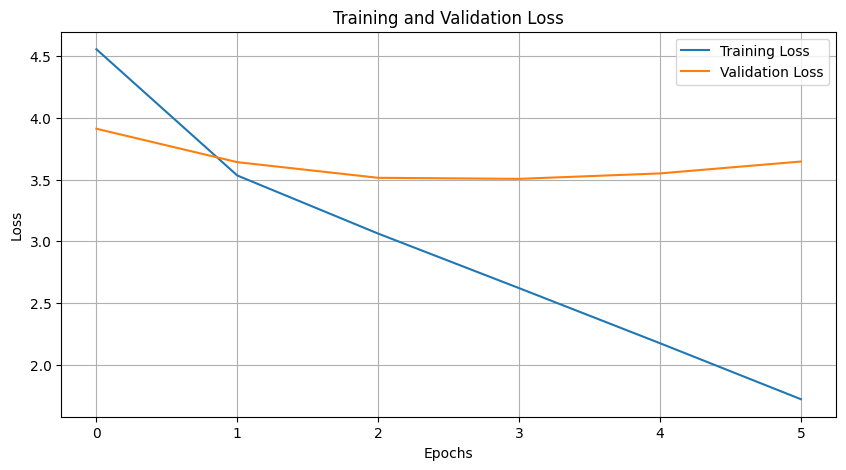

In [20]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
train_samples = [(train_dataset.loc[i,'questions'],train_dataset.loc[i,'answers']) for i in range(len(train_dataset))]
train_samples = train_samples[:1000]

In [18]:
# Load the best model state
model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_custom_100k.pt'))
# model.load_state_dict(torch.load('./kaggle_checkpoint/best_model.pt'))
model.eval()

correct_train = 0
total_train = 0

with torch.no_grad():
    for (src,tgt) in train_samples:
        input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

        bos = bert_tokenizer.token_to_id('<bos>')
            
        tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        # print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        tgt = tgt.lower()
        
        # Check if the predicted and actual sequences match
        if tgt_out == tgt:  # Adjust comparison logic as needed
            correct_train += 1
        total_train += 1

# Calculate accuracy
train_accuracy = correct_train / total_train
print(f'Training set accuracy of the best model: {train_accuracy:.4f}')


/tmp/ipykernel_2608669/1756670725.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_custom_100k.pt'))


Training set accuracy of the best model: 0.0370
